<a href="https://colab.research.google.com/github/artirocks/Bank-Customers-Predictor/blob/master/AxisMarkingDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
 from PIL import Image

In [17]:
import sys
sys.path.append("/content/drive/MyDrive/Graph API Work/axis_detection")
from ocr_rem import clean_OCR_boxes
import os
import glob
from datetime import datetime
import pdb
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [70]:
from get_OCR_boxes import recursive_OCR_removal

In [2]:
sys.path.append("/content/drive/MyDrive/pylsd")
from pylsd.lsd import lsd
from get_hor_ver_lines import get_hor_and_ver_merged_lines

In [11]:
axis_output = "/content/drive/MyDrive/Graph API Work/axis_output"
PADDING_THRESHOLD = 10

In [6]:
sys.path.append("/content/drive/MyDrive/Graph API Work/Axis Detection")
from axis_detection_main import get_axis_detection ,removing_thrshold,display_axis

In [152]:
crop_bin = "/content/drive/MyDrive/Graph API Work/axis_detection/bin/"
axis_markings_result = "/content/drive/MyDrive/Graph API Work/axis_markings_output/"

In [14]:
def get_OCR_image(image_path,word_bounding_boxes):
  img = cv2.imread(image_path)
  blank_ocr_image = 255 * np.ones(shape=[img.shape[0], img.shape[1], img.shape[2]], dtype=np.uint8)

  for box in word_bounding_boxes:
      coords = box['boundingBox']
      cv2.rectangle(blank_ocr_image, (coords[0],coords[1]), (coords[4],coords[5]), (255,255,0), 1)
  return blank_ocr_image

In [163]:
def get_y_axis_info(X_axis,Y_axis,image_with_OCR_boxes, word_bounding_boxes,crop_bin):
  graph_markings = {}
  im_pil = Image.fromarray(image_with_OCR_boxes)
  pix = im_pil.load()
  #Y-AXIS :
  start_x = Y_axis[0][0]
  start_y = min(Y_axis[0][1],Y_axis[1][1])
  end_y = max(Y_axis[0][1],Y_axis[1][1])
  column_flag = 0
  temp = []
  # display(image_with_OCR_boxes)
  for i in range(start_x, 0, -1):
    for j in range(start_y,end_y,1):
      if pix[i,j] != (255,255,255):
        column_flag = 1
    if column_flag == 0:
      cv2.line(image_with_OCR_boxes,(i,start_y),(i,end_y),(255,0,0),1)    # Blue
    else:
      cv2.line(image_with_OCR_boxes,(i,start_y),(i,end_y),(0,0,255),1)    # Red
    temp.append([column_flag,i])
    column_flag = 0
  detected_line = None
  for i in range(0,len(temp)-1):
    if temp[i][0] == 1 and temp[i+1][0] == 0:
      detected_line = [(temp[i][1],0),(temp[i][1],X_axis[0][1])]
      # print("line :", temp[i][1])
      cv2.line(image_with_OCR_boxes,(temp[i][1],start_y),(temp[i][1],end_y),(0,255,0),2)  # Green 
      break
  # display(image_with_OCR_boxes)
  cv2_imshow(image_with_OCR_boxes)
  if(detected_line == None ):
    return []
  else:
    y_axis_info = get_y_axis_markings_and_text(image_path,crop_bin, detected_line, X_axis, Y_axis)
  return y_axis_info

def get_x_axis_info(X_axis,Y_axis,image_with_OCR_boxes,height_of_img,word_bounding_boxes,crop_bin):
  graph_markings = {}
  im_pil = Image.fromarray(image_with_OCR_boxes)
  pix = im_pil.load()
  start_x = X_axis[0][0]
  end_x = X_axis[1][0]
  start_y = X_axis[0][1]
  end_y = height_of_img
  column_flag = 0
  temp = []
  for i in range(start_y,end_y,1):
    for j in range(start_x,end_x):
      try:
        if pix[j,i] != (255,255,255):
          column_flag = 1
      except Exception as e:
        print(i,j)
        pdb.set_trace()
        print('error in get_x_axis_based_markings method')
    if column_flag == 0:
      cv2.line(image_with_OCR_boxes,(start_x,i),(end_x,i),(255,0,0),1)    # Blue
    else:
      cv2.line(image_with_OCR_boxes,(start_x,i),(end_x,i),(0,0,255),1)    # Red
    temp.append([column_flag,i])
    column_flag = 0
  detected_line = None
  for i in range(0,len(temp)-1):
    if temp[i][0] == 1 and temp[i+1][0] == 0:
      # print("line :", temp[i][1])
      cv2.line(image_with_OCR_boxes,(start_x,temp[i][1]),(end_x,temp[i][1]),(0,255,0),2)   # Green
      detected_line = [(start_x,temp[i][1]), (end_x,temp[i][1])]
      break
  cv2_imshow(image_with_OCR_boxes)
  #x_axis_info = get_x_axis_markings_and_text(word_bounding_boxes, detected_line, X_axis, Y_axis)	
  if(detected_line == None):
    return []
  else:
    x_axis_info = get_x_axis_markings_and_text(image_path,crop_bin, detected_line, X_axis, Y_axis)
  return x_axis_info

In [53]:
def add_padding(image_path, temp_bin, top_THRESHOLD, bott_THRESHOLD, left_THRESHOLD, right_THRESHOLD):
  borderType = cv2.BORDER_CONSTANT
  window_name = "copyMakeBorder Demo"
  src = cv2.imread(cv2.samples.findFile(image_path), cv2.IMREAD_COLOR)
  top = top_THRESHOLD
  bottom = bott_THRESHOLD
  left = left_THRESHOLD
  right = right_THRESHOLD
  value = [255, 255, 255]
  dst = cv2.copyMakeBorder(src, top, bottom, left, right, borderType, None, value)
  file = image_path.split('/')[-1]
  file_path = temp_bin + "add_padding" + file
  cv2.imwrite(file_path,dst)
  return file_path

In [121]:
def remove_padding(ocr_boxes,top_THRESHOLD, left_THRESHOLD):
  for box in ocr_boxes:
    box['boundingBox'][0] = box['boundingBox'][0] - left_THRESHOLD
    box['boundingBox'][1] = box['boundingBox'][1] - top_THRESHOLD
    box['boundingBox'][2] = box['boundingBox'][2] - left_THRESHOLD
    box['boundingBox'][3] = box['boundingBox'][3] - top_THRESHOLD
    box['boundingBox'][4] = box['boundingBox'][4] - left_THRESHOLD
    box['boundingBox'][5] = box['boundingBox'][5] - top_THRESHOLD
    box['boundingBox'][6] = box['boundingBox'][6] - left_THRESHOLD
    box['boundingBox'][7] = box['boundingBox'][7] - top_THRESHOLD
  return ocr_boxes

In [140]:
def remove_crop_effet(ocr_boxes, x_effect, y_effect):
  for box in ocr_boxes:
    box['boundingBox'][0] = box['boundingBox'][0] + x_effect
    box['boundingBox'][1] = box['boundingBox'][1] + y_effect
    box['boundingBox'][2] = box['boundingBox'][2] + x_effect
    box['boundingBox'][3] = box['boundingBox'][3] + y_effect
    box['boundingBox'][4] = box['boundingBox'][4] + x_effect
    box['boundingBox'][5] = box['boundingBox'][5] + y_effect
    box['boundingBox'][6] = box['boundingBox'][6] + x_effect
    box['boundingBox'][7] = box['boundingBox'][7] + y_effect
  return ocr_boxes

In [142]:
def get_x_axis_markings_and_text(image_path,crop_bin, detected_line, X_axis, Y_axis):
  img = cv2.imread(image_path)
  x1 = max( (X_axis[0][0]-5) ,0 )
  x2 = min( (X_axis[1][0]+5) , img.shape[1] )
  y1 = X_axis[0][1]
  y2 = min( (detected_line[0][1] + 5 ) , img.shape[0] )
  crop_img = img[y1:y2,x1:x2]
  file_path = image_path.split('/')[-1]
  crop_img_path = crop_bin + "crop_x" + file_path
  cv2.imwrite(crop_img_path,crop_img)
  cv2_imshow(crop_img)
  print(crop_img.shape)
  padded_image_path = add_padding(crop_img_path, crop_bin,25,25,0,0)
  padded_image = cv2.imread(padded_image_path)
  cv2_imshow(padded_image)
  print(padded_image.shape)
  word_boxes = recursive_OCR_removal(padded_image_path,[])
  print(word_boxes)
  word_boxes = remove_padding(word_boxes,25,0)
  print(word_boxes)
  word_boxes = remove_crop_effet(word_boxes,x1,y1)
  print(word_boxes)
  return word_boxes

In [141]:
def get_y_axis_markings_and_text(image_path,crop_bin, detected_line, X_axis, Y_axis):
  img = cv2.imread(image_path)
  x1 = max((detected_line[0][0] -5 ), 0) 
  x2 = Y_axis[0][0] 
  y1 = max( (min(Y_axis[0][1],Y_axis[1][1]) - 5) , 0)
  y2 = min( (max(Y_axis[0][1],Y_axis[1][1]) + 5), img.shape[0])
  crop_img = img[y1:y2,x1:x2]
  file_path = image_path.split('/')[-1]
  crop_img_path = crop_bin + "crop_y" + file_path
  cv2.imwrite(crop_img_path,crop_img)
  cv2_imshow(crop_img)
  print(crop_img.shape)
  padded_image_path = add_padding(crop_img_path, crop_bin,0,0,25,25)
  padded_image = cv2.imread(padded_image_path)
  cv2_imshow(padded_image)
  print(padded_image.shape)
  word_boxes = recursive_OCR_removal(padded_image_path,[])
  print(word_boxes)
  word_boxes = remove_padding(word_boxes,0,25)
  print(word_boxes)
  word_boxes = remove_crop_effet(word_boxes,x1,y1)
  print(word_boxes)
  return word_boxes

In [164]:
def display_markings(image_path,x_axis_markings,y_axis_markings,axis_marking_result):
  x_label_color = (0,255,0)
  y_label_color = (0,0,255)
  img = cv2.imread(image_path)
  for ocr_box in x_axis_markings:
      cv2.rectangle(img, (ocr_box['boundingBox'][0],ocr_box['boundingBox'][1]), (ocr_box['boundingBox'][4],ocr_box['boundingBox'][5]), x_label_color,2)

  for ocr_box in y_axis_markings:
      cv2.rectangle(img, (ocr_box['boundingBox'][0],ocr_box['boundingBox'][1]), (ocr_box['boundingBox'][4],ocr_box['boundingBox'][5]), y_label_color,2)
  
  file_path = image_path.split("/")[-1]
  img_marking_path = axis_marking_result + "out" + file_path
  cv2.imwrite(img_marking_path,img)
  return img

202
202
202
[[[71, 293], [621, 293]], [[88, 128], [616, 128]]] [[[83, 40], [83, 306]], [[145, 298], [145, 306]]]


202
202
202


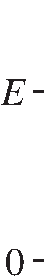

(276, 44, 3)


(276, 94, 3)
202
202
[{'boundingBox': [30, 77, 72, 78, 71, 108, 29, 107], 'text': 'E-', 'confidence': 'Low'}, {'boundingBox': [31, 248, 48, 248, 49, 273, 32, 273], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [58, 247, 70, 247, 70, 272, 59, 272], 'text': '-'}]
[{'boundingBox': [5, 77, 47, 78, 46, 108, 4, 107], 'text': 'E-', 'confidence': 'Low'}, {'boundingBox': [6, 248, 23, 248, 24, 273, 7, 273], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [33, 247, 45, 247, 45, 272, 34, 272], 'text': '-'}]
[{'boundingBox': [44, 112, 86, 113, 85, 143, 43, 142], 'text': 'E-', 'confidence': 'Low'}, {'boundingBox': [45, 283, 62, 283, 63, 308, 46, 308], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [72, 282, 84, 282, 84, 307, 73, 307], 'text': '-'}]


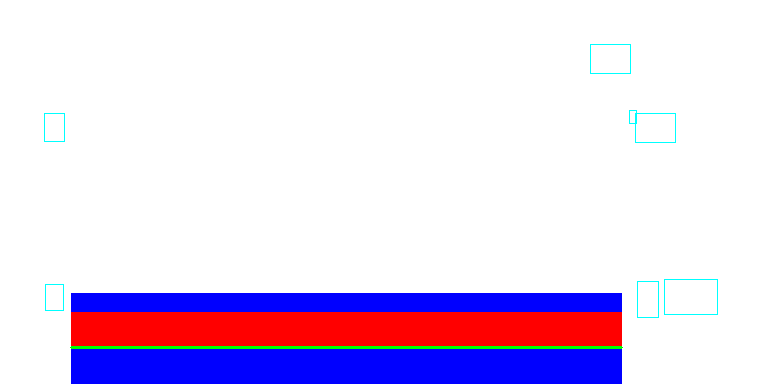

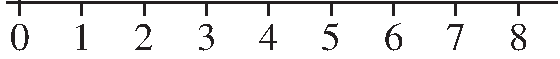

(59, 560, 3)


(109, 560, 3)
202
202
[{'boundingBox': [7, 74, 7, 59, 30, 59, 30, 74], 'text': 'O'}, {'boundingBox': [76, 43, 99, 44, 99, 79, 75, 79], 'text': '1'}, {'boundingBox': [136, 44, 159, 44, 159, 79, 136, 79], 'text': '2'}, {'boundingBox': [198, 44, 224, 45, 224, 79, 198, 79], 'text': '3'}, {'boundingBox': [261, 45, 284, 45, 284, 79, 261, 79], 'text': '4'}, {'boundingBox': [323, 45, 349, 45, 349, 79, 323, 79], 'text': '5'}, {'boundingBox': [386, 45, 409, 45, 409, 79, 386, 79], 'text': '6'}, {'boundingBox': [451, 45, 476, 45, 477, 79, 451, 79], 'text': '7'}, {'boundingBox': [513, 44, 529, 44, 530, 78, 514, 78], 'text': '8'}]
[{'boundingBox': [7, 49, 7, 34, 30, 34, 30, 49], 'text': 'O'}, {'boundingBox': [76, 18, 99, 19, 99, 54, 75, 54], 'text': '1'}, {'boundingBox': [136, 19, 159, 19, 159, 54, 136, 54], 'text': '2'}, {'boundingBox': [198, 19, 224, 20, 224, 54, 198, 54], 'text': '3'}, {'boundingBox': [261, 20, 284, 20, 284, 54, 261, 54], 'text': '4'}, {'boundingBox': [323, 20, 349, 20, 349, 54, 

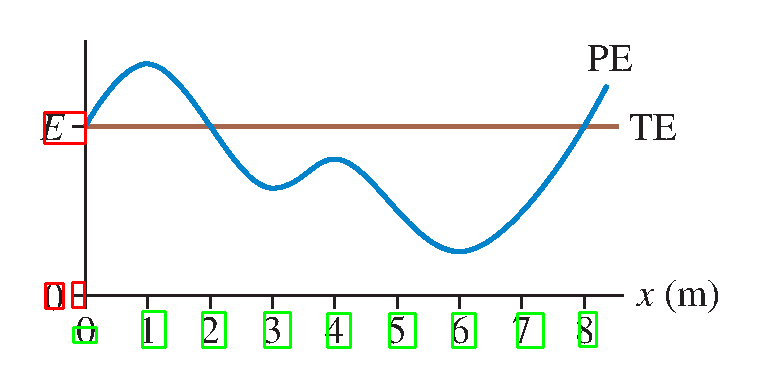

In [159]:
image_path = "/content/drive/MyDrive/Graph API Work/GraphAPI_samples/9426510052.png"
x_axis,y_axis = get_axis_detection(image_path,0,0)
print(x_axis,y_axis)
result_image_path, img_axis = display_axis(image_path,x_axis,y_axis,axis_output,PADDING_THRESHOLD)
cv2_imshow(img_axis)

image_without_OCR,word_bounding_boxes,image_with_OCR_boxes,text_bounding_boxes = clean_OCR_boxes(image_path)

img = cv2.imread(image_path)
height_of_img = img.shape[0]
X_axis = x_axis[0]
Y_axis = y_axis[0]

blank_ocr_image = get_OCR_image(image_path,word_bounding_boxes)
y_axis_info = get_y_axis_info(X_axis,Y_axis, blank_ocr_image, word_bounding_boxes,crop_bin)

blank_ocr_image = get_OCR_image(image_path,word_bounding_boxes)
x_axis_info = get_x_axis_info(X_axis, Y_axis, blank_ocr_image, height_of_img, word_bounding_boxes,crop_bin)
print(y_axis_info)
print(x_axis_info)

image_marks =  display_markings(image_path,x_axis_info,y_axis_info,axis_markings_result)
cv2_imshow(image_marks)

202
202
202
[[[141, 294], [424, 294]], [[313, 90], [323, 90]]] [[[218, 78], [218, 514]], [[199, 250], [199, 343]]]


202
202
202


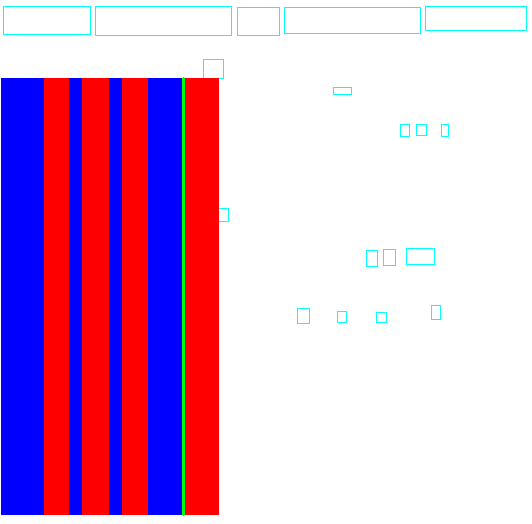

(446, 40, 3)


(446, 90, 3)
202
202
[{'boundingBox': [44, 52, 56, 52, 56, 68, 44, 68], 'text': '4'}, {'boundingBox': [59, 52, 62, 52, 62, 68, 59, 68], 'text': '-'}, {'boundingBox': [29, 149, 29, 127, 63, 127, 63, 150], 'text': 'N'}, {'boundingBox': [30, 109, 30, 86, 64, 86, 64, 109], 'text': 'w'}, {'boundingBox': [44, 295, 55, 295, 55, 312, 44, 312], 'text': '2'}, {'boundingBox': [58, 295, 65, 295, 65, 312, 58, 312], 'text': '-'}, {'boundingBox': [29, 337, 54, 336, 54, 350, 29, 351], 'text': '-3', 'confidence': 'Low'}, {'boundingBox': [58, 336, 64, 336, 64, 350, 59, 350], 'text': '-'}, {'boundingBox': [31, 380, 53, 380, 53, 392, 31, 392], 'text': '-4'}, {'boundingBox': [59, 380, 65, 380, 65, 392, 59, 392], 'text': '-'}]
[{'boundingBox': [19, 52, 31, 52, 31, 68, 19, 68], 'text': '4'}, {'boundingBox': [34, 52, 37, 52, 37, 68, 34, 68], 'text': '-'}, {'boundingBox': [4, 149, 4, 127, 38, 127, 38, 150], 'text': 'N'}, {'boundingBox': [5, 109, 5, 86, 39, 86, 39, 109], 'text': 'w'}, {'boundingBox': [19, 295, 

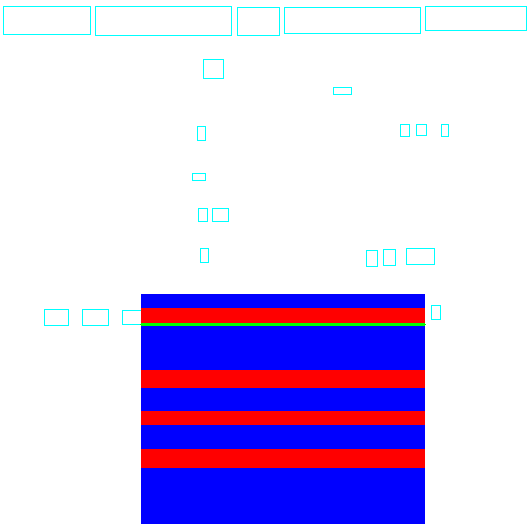

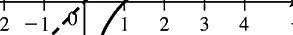

(35, 293, 3)


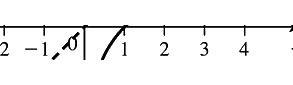

(85, 293, 3)
202
202
[{'boundingBox': [0, 35, 18, 33, 18, 60, 0, 60], 'text': '2'}, {'boundingBox': [26, 32, 83, 28, 83, 57, 26, 60], 'text': '-1,0', 'confidence': 'Low'}, {'boundingBox': [161, 32, 172, 32, 173, 56, 161, 56], 'text': '2'}, {'boundingBox': [200, 36, 212, 35, 213, 56, 201, 57], 'text': '3'}, {'boundingBox': [241, 38, 252, 39, 251, 59, 240, 58], 'text': '4'}]
[{'boundingBox': [0, 10, 18, 8, 18, 35, 0, 35], 'text': '2'}, {'boundingBox': [26, 7, 83, 3, 83, 32, 26, 35], 'text': '-1,0', 'confidence': 'Low'}, {'boundingBox': [161, 7, 172, 7, 173, 31, 161, 31], 'text': '2'}, {'boundingBox': [200, 11, 212, 10, 213, 31, 201, 32], 'text': '3'}, {'boundingBox': [241, 13, 252, 14, 251, 34, 240, 33], 'text': '4'}]
[{'boundingBox': [136, 304, 154, 302, 154, 329, 136, 329], 'text': '2'}, {'boundingBox': [162, 301, 219, 297, 219, 326, 162, 329], 'text': '-1,0', 'confidence': 'Low'}, {'boundingBox': [297, 301, 308, 301, 309, 325, 297, 325], 'text': '2'}, {'boundingBox': [336, 305, 348, 3

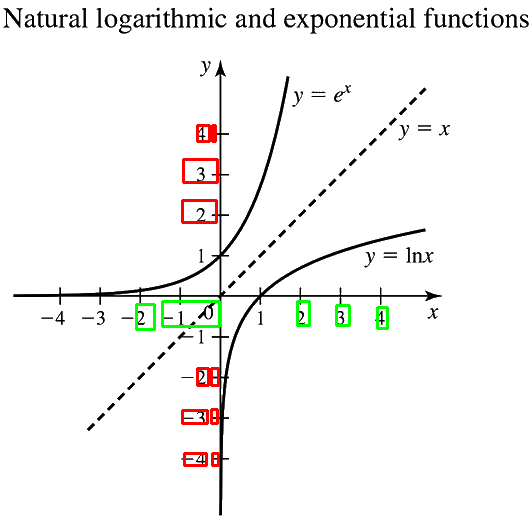

In [160]:
image_path = "/content/drive/MyDrive/Graph API Work/preprocessed_image/766301_BEP_PG01_08_bg.png"
x_axis,y_axis = get_axis_detection(image_path,0,0)
print(x_axis,y_axis)
result_image_path, img_axis = display_axis(image_path,x_axis,y_axis,axis_output,PADDING_THRESHOLD)
cv2_imshow(img_axis)

image_without_OCR,word_bounding_boxes,image_with_OCR_boxes,text_bounding_boxes = clean_OCR_boxes(image_path)

img = cv2.imread(image_path)
height_of_img = img.shape[0]
X_axis = x_axis[0]
Y_axis = y_axis[0]

blank_ocr_image = get_OCR_image(image_path,word_bounding_boxes)
y_axis_info = get_y_axis_info(X_axis,Y_axis, blank_ocr_image, word_bounding_boxes,crop_bin)

blank_ocr_image = get_OCR_image(image_path,word_bounding_boxes)
x_axis_info = get_x_axis_info(X_axis, Y_axis, blank_ocr_image, height_of_img, word_bounding_boxes,crop_bin)
print(y_axis_info)
print(x_axis_info)

image_marks =  display_markings(image_path,x_axis_info,y_axis_info,axis_markings_result)
cv2_imshow(image_marks)

202
202
202
202
[[[53, 299], [404, 299]], [[45, 149], [56, 149]]] [[[205, 73], [205, 390]], [[-109, 99990], [-109, -10010]]]


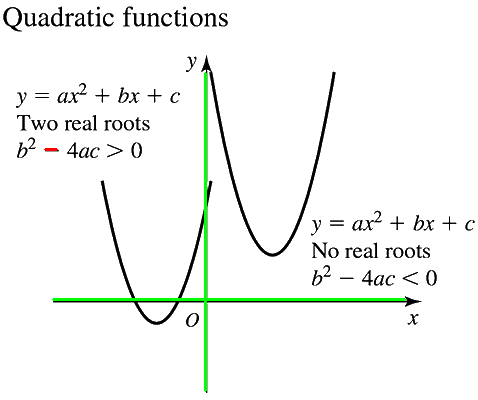

202
202
202


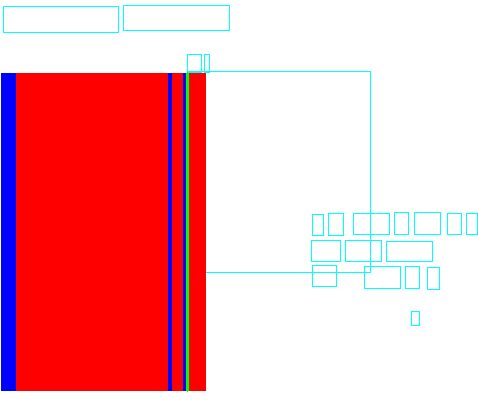

(327, 23, 3)


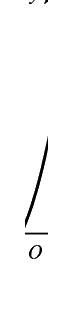

(327, 73, 3)
202
202
[{'boundingBox': [26, 258, 25, 245, 45, 244, 46, 257], 'text': 'O'}]
[{'boundingBox': [1, 258, 0, 245, 20, 244, 21, 257], 'text': 'O'}]
[{'boundingBox': [183, 326, 182, 313, 202, 312, 203, 325], 'text': 'O'}]


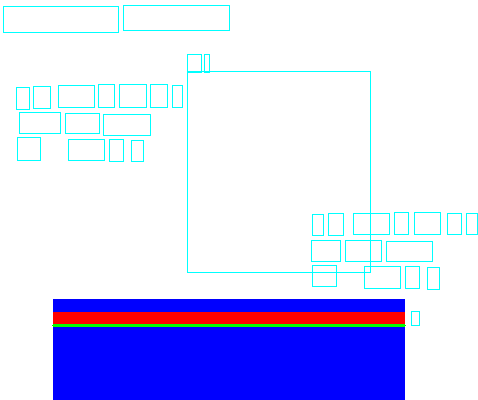

(31, 361, 3)


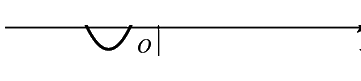

(81, 361, 3)
202
[]
[]
[]
[{'boundingBox': [183, 326, 182, 313, 202, 312, 203, 325], 'text': 'O'}]
[]


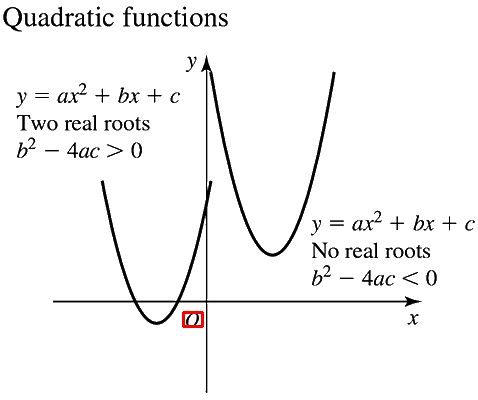

202
202
202
202
[[[4, 212], [89, 212]], [[99990, -109], [-10010, -109]]] [[[43, 24], [43, 300]], [[54, 154], [54, 198]]]


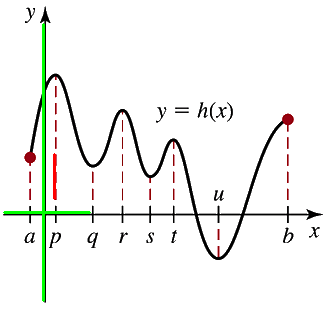

202
202
202


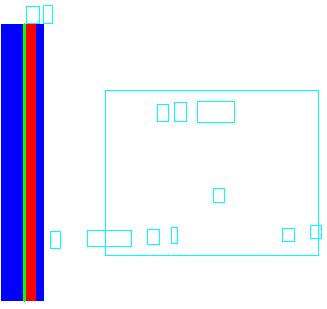

(286, 24, 3)


(286, 74, 3)
202
[]
[]
[]


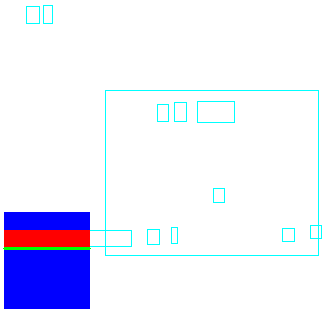

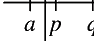

(41, 94, 3)


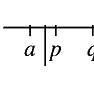

(91, 94, 3)
202
202
[{'boundingBox': [24, 33, 38, 31, 42, 58, 27, 60], 'text': 'a'}, {'boundingBox': [49, 36, 61, 35, 63, 60, 51, 61], 'text': 'p'}]
[{'boundingBox': [24, 8, 38, 6, 42, 33, 27, 35], 'text': 'a'}, {'boundingBox': [49, 11, 61, 10, 63, 35, 51, 36], 'text': 'p'}]
[{'boundingBox': [24, 220, 38, 218, 42, 245, 27, 247], 'text': 'a'}, {'boundingBox': [49, 223, 61, 222, 63, 247, 51, 248], 'text': 'p'}]
[]
[{'boundingBox': [24, 220, 38, 218, 42, 245, 27, 247], 'text': 'a'}, {'boundingBox': [49, 223, 61, 222, 63, 247, 51, 248], 'text': 'p'}]


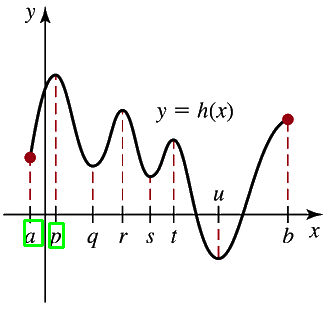

202
202
202
[[[0, 195], [296, 195]], [[99990, -109], [-10010, -109]]] [[[41, 19], [41, 324]], [[-109, 99990], [-109, -10010]]]


202
202


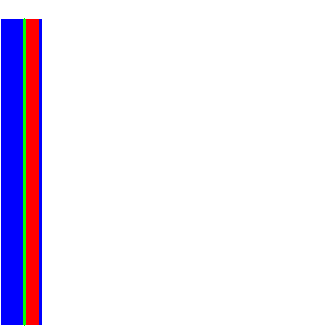

(315, 22, 3)


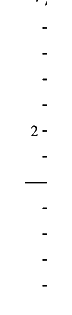

(315, 72, 3)
202
202
[{'boundingBox': [31, 124, 39, 123, 40, 136, 32, 137], 'text': '2'}, {'boundingBox': [42, 123, 45, 123, 45, 136, 43, 136], 'text': '-'}]
[{'boundingBox': [6, 124, 14, 123, 15, 136, 7, 137], 'text': '2'}, {'boundingBox': [17, 123, 20, 123, 20, 136, 18, 136], 'text': '-'}]
[{'boundingBox': [25, 138, 33, 137, 34, 150, 26, 151], 'text': '2'}, {'boundingBox': [36, 137, 39, 137, 39, 150, 37, 150], 'text': '-'}]


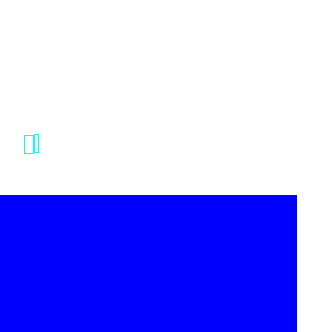

[{'boundingBox': [25, 138, 33, 137, 34, 150, 26, 151], 'text': '2'}, {'boundingBox': [36, 137, 39, 137, 39, 150, 37, 150], 'text': '-'}]
[]


202
202
202
[[[4, 386], [411, 386]], [[48, 66], [365, 66]]] [[[44, 26], [44, 433]], [[90, 68], [90, 416]]]


202
202


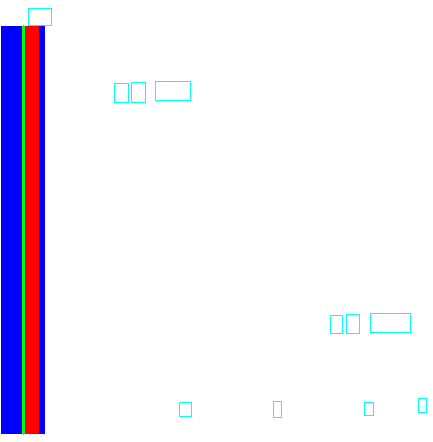

(417, 26, 3)


(417, 76, 3)
202
202
202
[{'boundingBox': [30, 39, 41, 38, 42, 54, 31, 55], 'text': '7'}, {'boundingBox': [44, 38, 51, 38, 51, 54, 45, 54], 'text': '-'}, {'boundingBox': [30, 131, 41, 130, 42, 146, 31, 147], 'text': '5'}, {'boundingBox': [44, 129, 50, 129, 51, 145, 45, 145], 'text': '-'}, {'boundingBox': [29, 221, 40, 220, 42, 236, 31, 237], 'text': '3'}, {'boundingBox': [43, 220, 50, 219, 52, 235, 45, 236], 'text': '-'}, {'boundingBox': [30, 313, 39, 312, 41, 330, 32, 331], 'text': '1'}, {'boundingBox': [42, 311, 45, 311, 47, 329, 44, 329], 'text': '-'}, {'boundingBox': [44, 267, 49, 266, 52, 283, 46, 284], 'text': '-'}, {'boundingBox': [32, 367, 45, 367, 46, 391, 33, 391], 'text': '0', 'confidence': 'Low'}]
[{'boundingBox': [5, 39, 16, 38, 17, 54, 6, 55], 'text': '7'}, {'boundingBox': [19, 38, 26, 38, 26, 54, 20, 54], 'text': '-'}, {'boundingBox': [5, 131, 16, 130, 17, 146, 6, 147], 'text': '5'}, {'boundingBox': [19, 129, 25, 129, 26, 145, 20, 145], 'text': '-'}, {'boundingBox': [4, 

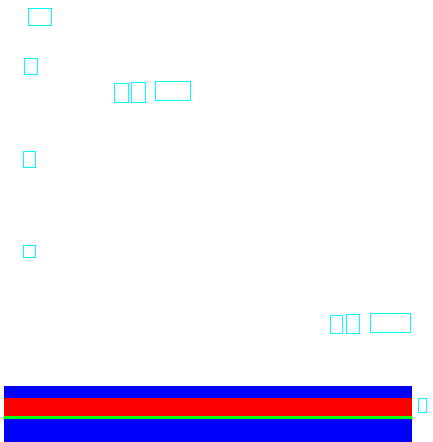

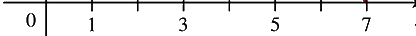

(36, 416, 3)


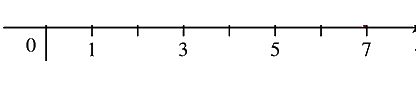

(86, 416, 3)
202
202
[{'boundingBox': [178, 42, 189, 40, 192, 54, 182, 57], 'text': '3'}, {'boundingBox': [269, 56, 269, 48, 281, 47, 281, 55], 'text': 'U', 'confidence': 'Low'}]
[{'boundingBox': [178, 17, 189, 15, 192, 29, 182, 32], 'text': '3'}, {'boundingBox': [269, 31, 269, 23, 281, 22, 281, 30], 'text': 'U', 'confidence': 'Low'}]
[{'boundingBox': [178, 403, 189, 401, 192, 415, 182, 418], 'text': '3'}, {'boundingBox': [269, 417, 269, 409, 281, 408, 281, 416], 'text': 'U', 'confidence': 'Low'}]
[{'boundingBox': [23, 60, 34, 59, 35, 75, 24, 76], 'text': '7'}, {'boundingBox': [37, 59, 44, 59, 44, 75, 38, 75], 'text': '-'}, {'boundingBox': [23, 152, 34, 151, 35, 167, 24, 168], 'text': '5'}, {'boundingBox': [37, 150, 43, 150, 44, 166, 38, 166], 'text': '-'}, {'boundingBox': [22, 242, 33, 241, 35, 257, 24, 258], 'text': '3'}, {'boundingBox': [36, 241, 43, 240, 45, 256, 38, 257], 'text': '-'}, {'boundingBox': [23, 334, 32, 333, 34, 351, 25, 352], 'text': '1'}, {'boundingBox': [35, 332, 38

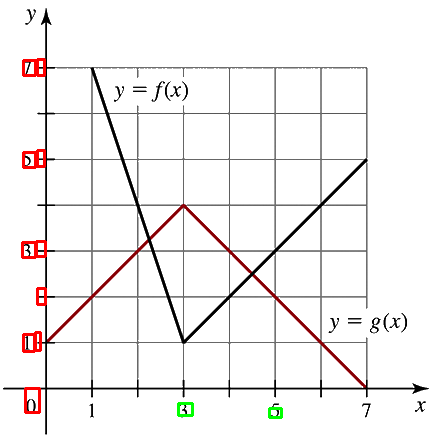

202
202
202
202
[[[33, 78], [380, 78]], [[70, 6], [375, 6]]] [[[202, 110], [202, 508]], [[164, 110], [164, 471]]]


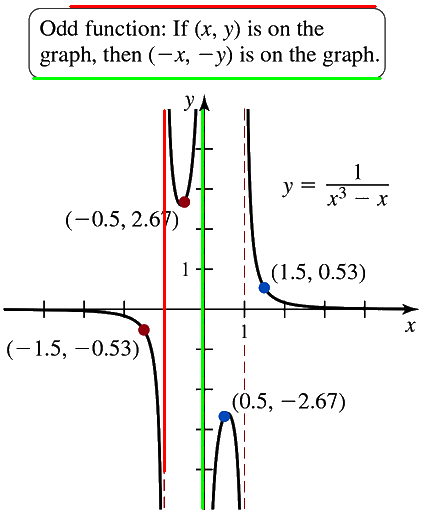

202
202
202


(408, 201, 3)


(408, 251, 3)
202
202
[{'boundingBox': [89, 103, 153, 104, 151, 126, 88, 126], 'text': '(-0.5,'}, {'boundingBox': [157, 104, 210, 103, 209, 127, 156, 126], 'text': '2.67)'}, {'boundingBox': [31, 233, 96, 234, 95, 256, 31, 256], 'text': '(-1.5,'}, {'boundingBox': [100, 234, 165, 233, 165, 255, 100, 256], 'text': '-0.53)'}]
[{'boundingBox': [64, 103, 128, 104, 126, 126, 63, 126], 'text': '(-0.5,'}, {'boundingBox': [132, 104, 185, 103, 184, 127, 131, 126], 'text': '2.67)'}, {'boundingBox': [6, 233, 71, 234, 70, 256, 6, 256], 'text': '(-1.5,'}, {'boundingBox': [75, 234, 140, 233, 140, 255, 75, 256], 'text': '-0.53)'}]
[{'boundingBox': [65, 208, 129, 209, 127, 231, 64, 231], 'text': '(-0.5,'}, {'boundingBox': [133, 209, 186, 208, 185, 232, 132, 231], 'text': '2.67)'}, {'boundingBox': [7, 338, 72, 339, 71, 361, 7, 361], 'text': '(-1.5,'}, {'boundingBox': [76, 339, 141, 338, 141, 360, 76, 361], 'text': '-0.53)'}]


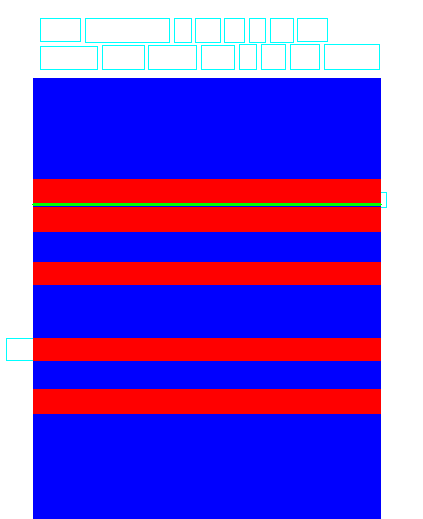

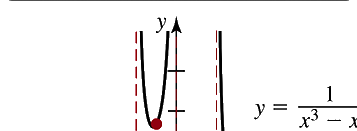

(131, 357, 3)


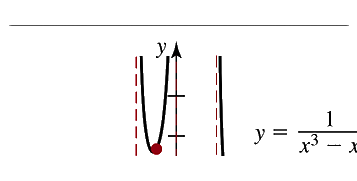

(181, 357, 3)
202
202
[{'boundingBox': [255, 128, 282, 125, 283, 139, 256, 142], 'text': 'y=', 'confidence': 'Low'}, {'boundingBox': [301, 137, 321, 134, 322, 151, 302, 153], 'text': 'x3'}, {'boundingBox': [327, 134, 338, 136, 338, 152, 328, 151], 'text': '-'}]
[{'boundingBox': [255, 103, 282, 100, 283, 114, 256, 117], 'text': 'y=', 'confidence': 'Low'}, {'boundingBox': [301, 112, 321, 109, 322, 126, 302, 128], 'text': 'x3'}, {'boundingBox': [327, 109, 338, 111, 338, 127, 328, 126], 'text': '-'}]
[{'boundingBox': [283, 181, 310, 178, 311, 192, 284, 195], 'text': 'y=', 'confidence': 'Low'}, {'boundingBox': [329, 190, 349, 187, 350, 204, 330, 206], 'text': 'x3'}, {'boundingBox': [355, 187, 366, 189, 366, 205, 356, 204], 'text': '-'}]
[{'boundingBox': [65, 208, 129, 209, 127, 231, 64, 231], 'text': '(-0.5,'}, {'boundingBox': [133, 209, 186, 208, 185, 232, 132, 231], 'text': '2.67)'}, {'boundingBox': [7, 338, 72, 339, 71, 361, 7, 361], 'text': '(-1.5,'}, {'boundingBox': [76, 339, 141, 338,

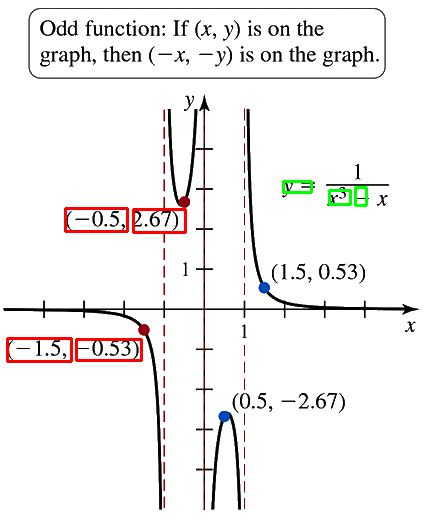

202
202
202
[[[1, 260], [400, 260]], [[48, 6], [375, 6]]] [[[200, 113], [200, 461]], [[42, 13], [42, 73]]]


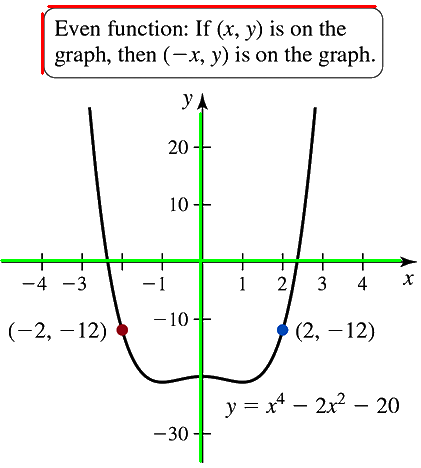

202
202


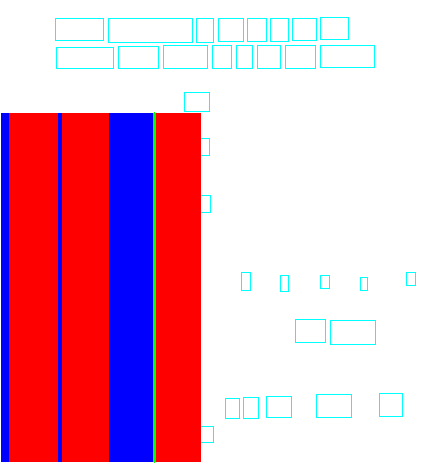

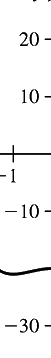

(358, 51, 3)


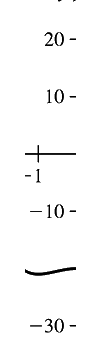

(358, 101, 3)
202
202
[{'boundingBox': [46, 32, 65, 31, 65, 46, 46, 47], 'text': '20'}, {'boundingBox': [71, 31, 78, 31, 78, 46, 71, 46], 'text': '-'}, {'boundingBox': [46, 87, 65, 87, 66, 105, 46, 105], 'text': '10'}, {'boundingBox': [69, 87, 75, 87, 75, 105, 69, 105], 'text': '-'}, {'boundingBox': [29, 204, 64, 204, 64, 219, 29, 218], 'text': '-10', 'confidence': 'Low'}, {'boundingBox': [70, 204, 76, 204, 76, 219, 70, 219], 'text': '-'}, {'boundingBox': [30, 319, 65, 317, 66, 332, 31, 334], 'text': '-30'}, {'boundingBox': [70, 317, 76, 317, 77, 331, 71, 332], 'text': '-'}]
[{'boundingBox': [21, 32, 40, 31, 40, 46, 21, 47], 'text': '20'}, {'boundingBox': [46, 31, 53, 31, 53, 46, 46, 46], 'text': '-'}, {'boundingBox': [21, 87, 40, 87, 41, 105, 21, 105], 'text': '10'}, {'boundingBox': [44, 87, 50, 87, 50, 105, 44, 105], 'text': '-'}, {'boundingBox': [4, 204, 39, 204, 39, 219, 4, 218], 'text': '-10', 'confidence': 'Low'}, {'boundingBox': [45, 204, 51, 204, 51, 219, 45, 219], 'text': '-'}

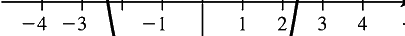

(36, 405, 3)


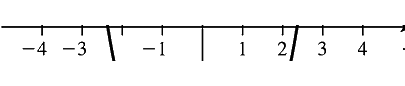

(86, 405, 3)
202
202
[{'boundingBox': [26, 41, 49, 41, 49, 56, 26, 56], 'text': '-4'}, {'boundingBox': [63, 40, 88, 39, 88, 56, 63, 57], 'text': '-3'}, {'boundingBox': [237, 24, 262, 24, 262, 63, 237, 63], 'text': '1'}, {'boundingBox': [277, 24, 310, 24, 310, 62, 277, 63], 'text': '2/'}, {'boundingBox': [318, 24, 343, 25, 343, 61, 318, 62], 'text': '3'}, {'boundingBox': [358, 25, 376, 25, 376, 60, 359, 61], 'text': '4'}]
[{'boundingBox': [26, 16, 49, 16, 49, 31, 26, 31], 'text': '-4'}, {'boundingBox': [63, 15, 88, 14, 88, 31, 63, 32], 'text': '-3'}, {'boundingBox': [237, -1, 262, -1, 262, 38, 237, 38], 'text': '1'}, {'boundingBox': [277, -1, 310, -1, 310, 37, 277, 38], 'text': '2/'}, {'boundingBox': [318, -1, 343, 0, 343, 36, 318, 37], 'text': '3'}, {'boundingBox': [358, 0, 376, 0, 376, 35, 359, 36], 'text': '4'}]
[{'boundingBox': [26, 276, 49, 276, 49, 291, 26, 291], 'text': '-4'}, {'boundingBox': [63, 275, 88, 274, 88, 291, 63, 292], 'text': '-3'}, {'boundingBox': [237, 259, 262, 259

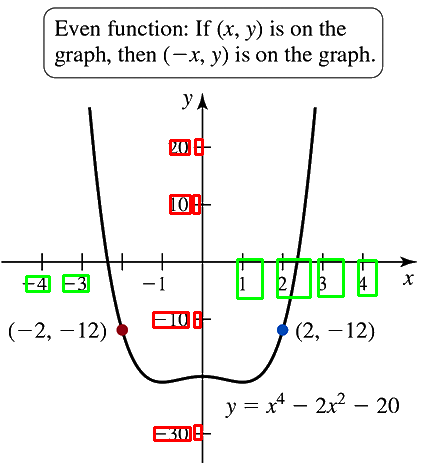

202
202
[[[0, 142], [254, 142]], [[11, 161], [19, 161]]] [[[127, 18], [127, 271]], [[-109, 99990], [-109, -10010]]]


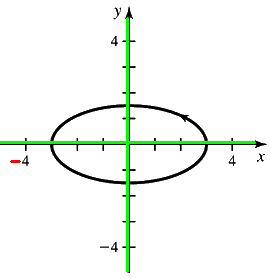

202
202


(27, 259, 3)


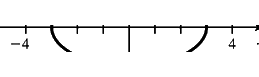

(77, 259, 3)
202
202
[{'boundingBox': [15, 35, 31, 34, 32, 49, 16, 50], 'text': '-4'}]
[{'boundingBox': [15, 10, 31, 9, 32, 24, 16, 25], 'text': '-4'}]
[{'boundingBox': [15, 152, 31, 151, 32, 166, 16, 167], 'text': '-4'}]
[]
[{'boundingBox': [15, 152, 31, 151, 32, 166, 16, 167], 'text': '-4'}]


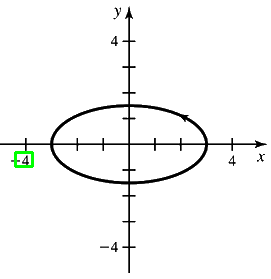

202
202
[[[0, 247], [244, 247]], [[101, 233], [138, 233]]] [[[39, 19], [39, 285]], [[25, 193], [25, 200]]]


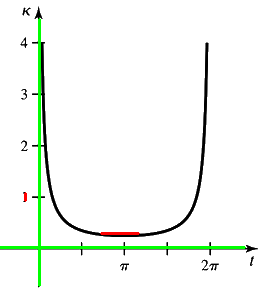

202
202


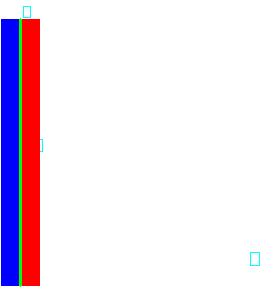

(276, 24, 3)


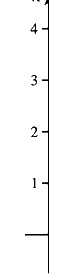

(276, 74, 3)
202
202
202
[{'boundingBox': [31, 24, 39, 24, 39, 34, 31, 34], 'text': '4'}, {'boundingBox': [42, 24, 44, 24, 44, 34, 42, 34], 'text': '-'}, {'boundingBox': [31, 127, 50, 125, 51, 138, 32, 140], 'text': '2-'}, {'boundingBox': [31, 74, 39, 73, 40, 84, 32, 85], 'text': '3'}, {'boundingBox': [41, 73, 44, 73, 45, 84, 42, 84], 'text': '-'}]
[{'boundingBox': [6, 24, 14, 24, 14, 34, 6, 34], 'text': '4'}, {'boundingBox': [17, 24, 19, 24, 19, 34, 17, 34], 'text': '-'}, {'boundingBox': [6, 127, 25, 125, 26, 138, 7, 140], 'text': '2-'}, {'boundingBox': [6, 74, 14, 73, 15, 84, 7, 85], 'text': '3'}, {'boundingBox': [16, 73, 19, 73, 20, 84, 17, 84], 'text': '-'}]
[{'boundingBox': [21, 38, 29, 38, 29, 48, 21, 48], 'text': '4'}, {'boundingBox': [32, 38, 34, 38, 34, 48, 32, 48], 'text': '-'}, {'boundingBox': [21, 141, 40, 139, 41, 152, 22, 154], 'text': '2-'}, {'boundingBox': [21, 88, 29, 87, 30, 98, 22, 99], 'text': '3'}, {'boundingBox': [31, 87, 34, 87, 35, 98, 32, 98], 'text': '-'}]


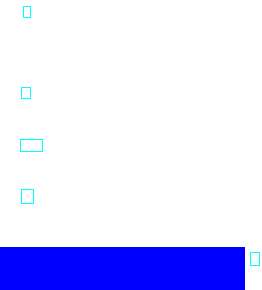

[{'boundingBox': [21, 38, 29, 38, 29, 48, 21, 48], 'text': '4'}, {'boundingBox': [32, 38, 34, 38, 34, 48, 32, 48], 'text': '-'}, {'boundingBox': [21, 141, 40, 139, 41, 152, 22, 154], 'text': '2-'}, {'boundingBox': [21, 88, 29, 87, 30, 98, 22, 99], 'text': '3'}, {'boundingBox': [31, 87, 34, 87, 35, 98, 32, 98], 'text': '-'}]
[]


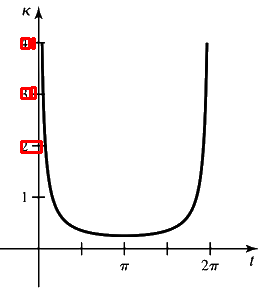

202
202
[[[0, 144], [254, 144]], [[99990, -109], [-10010, -109]]] [[[127, 19], [127, 273]], [[-109, 99990], [-109, -10010]]]


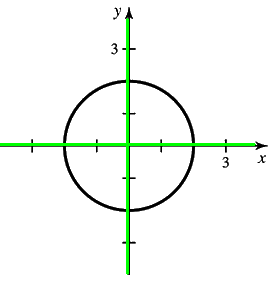

202
202


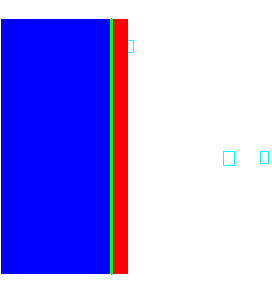

(264, 21, 3)


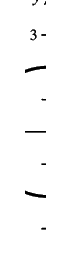

(264, 71, 3)
202
[]
[]
[]


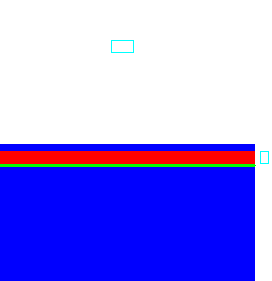

(26, 259, 3)


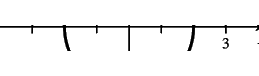

(76, 259, 3)
202
202
[{'boundingBox': [219, 48, 218, 39, 231, 39, 232, 47], 'text': 'w'}, {'boundingBox': [218, 32, 218, 28, 231, 28, 231, 32], 'text': '-'}]
[{'boundingBox': [219, 23, 218, 14, 231, 14, 232, 22], 'text': 'w'}, {'boundingBox': [218, 7, 218, 3, 231, 3, 231, 7], 'text': '-'}]
[{'boundingBox': [219, 167, 218, 158, 231, 158, 232, 166], 'text': 'w'}, {'boundingBox': [218, 151, 218, 147, 231, 147, 231, 151], 'text': '-'}]
[]
[{'boundingBox': [219, 167, 218, 158, 231, 158, 232, 166], 'text': 'w'}, {'boundingBox': [218, 151, 218, 147, 231, 147, 231, 151], 'text': '-'}]


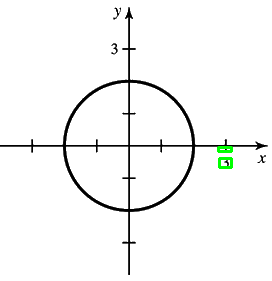

202
202
[[[0, 292], [294, 292]], [[99, 215], [106, 215]]] [[[24, 20], [24, 318]], [[98, 200], [98, 214]]]


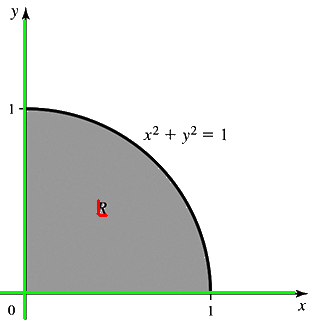

202
202


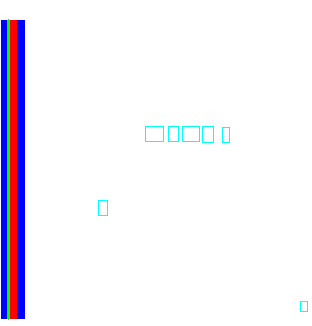

(308, 21, 3)


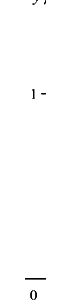

(308, 71, 3)
202
202
[{'boundingBox': [31, 88, 38, 87, 40, 99, 32, 100], 'text': '1', 'confidence': 'Low'}, {'boundingBox': [41, 86, 47, 85, 48, 98, 42, 99], 'text': '-'}]
[{'boundingBox': [6, 88, 13, 87, 15, 99, 7, 100], 'text': '1', 'confidence': 'Low'}, {'boundingBox': [16, 86, 22, 85, 23, 98, 17, 99], 'text': '-'}]
[{'boundingBox': [9, 103, 16, 102, 18, 114, 10, 115], 'text': '1', 'confidence': 'Low'}, {'boundingBox': [19, 101, 25, 100, 26, 113, 20, 114], 'text': '-'}]


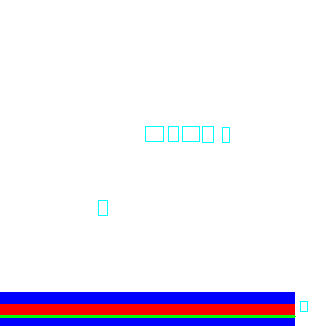

(29, 299, 3)


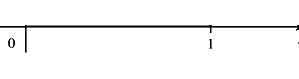

(79, 299, 3)
202
202
[{'boundingBox': [7, 35, 17, 35, 18, 50, 8, 50], 'text': '0'}]
[{'boundingBox': [7, 10, 17, 10, 18, 25, 8, 25], 'text': '0'}]
[{'boundingBox': [7, 302, 17, 302, 18, 317, 8, 317], 'text': '0'}]
[{'boundingBox': [9, 103, 16, 102, 18, 114, 10, 115], 'text': '1', 'confidence': 'Low'}, {'boundingBox': [19, 101, 25, 100, 26, 113, 20, 114], 'text': '-'}]
[{'boundingBox': [7, 302, 17, 302, 18, 317, 8, 317], 'text': '0'}]


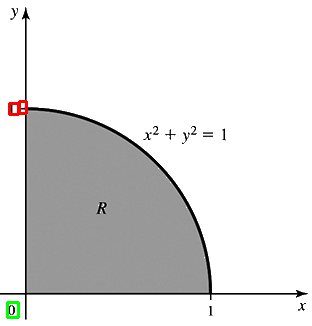

202
202
[[[0, 78], [253, 78]], [[171, 157], [180, 157]]] [[[62, 19], [62, 271]], [[-109, 99990], [-109, -10010]]]


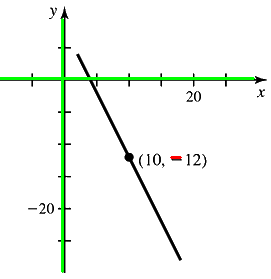

202
202


(262, 39, 3)


(262, 89, 3)
202
202
[{'boundingBox': [32, 58, 42, 58, 42, 73, 32, 73], 'text': '+'}, {'boundingBox': [30, 189, 57, 188, 57, 201, 30, 201], 'text': '-20'}, {'boundingBox': [60, 188, 66, 188, 67, 201, 61, 201], 'text': '-'}]
[{'boundingBox': [7, 58, 17, 58, 17, 73, 7, 73], 'text': '+'}, {'boundingBox': [5, 189, 32, 188, 32, 201, 5, 201], 'text': '-20'}, {'boundingBox': [35, 188, 41, 188, 42, 201, 36, 201], 'text': '-'}]
[{'boundingBox': [30, 72, 40, 72, 40, 87, 30, 87], 'text': '+'}, {'boundingBox': [28, 203, 55, 202, 55, 215, 28, 215], 'text': '-20'}, {'boundingBox': [58, 202, 64, 202, 65, 215, 59, 215], 'text': '-'}]


(27, 258, 3)


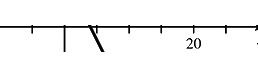

(77, 258, 3)
202
202
[{'boundingBox': [187, 37, 201, 36, 202, 48, 187, 49], 'text': '20'}]
[{'boundingBox': [187, 12, 201, 11, 202, 23, 187, 24], 'text': '20'}]
[{'boundingBox': [187, 90, 201, 89, 202, 101, 187, 102], 'text': '20'}]
[{'boundingBox': [30, 72, 40, 72, 40, 87, 30, 87], 'text': '+'}, {'boundingBox': [28, 203, 55, 202, 55, 215, 28, 215], 'text': '-20'}, {'boundingBox': [58, 202, 64, 202, 65, 215, 59, 215], 'text': '-'}]
[{'boundingBox': [187, 90, 201, 89, 202, 101, 187, 102], 'text': '20'}]


202
202
[[[3, 285], [309, 285]], [[99990, -109], [-10010, -109]]] [[[40, 19], [40, 324]], [[26, 128], [26, 136]]]


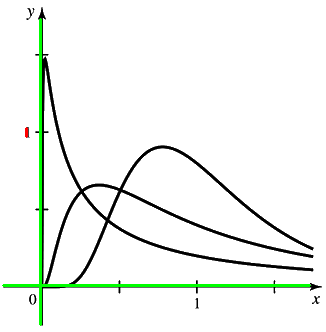

202
202


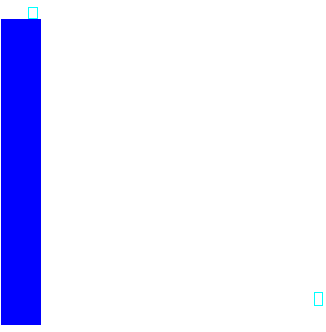

[]
[]


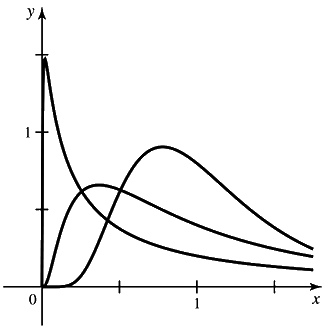

202
202
[[[0, 304], [319, 304]], [[39, 42], [298, 42]]] [[[35, 25], [35, 341]], [[299, 44], [299, 303]]]


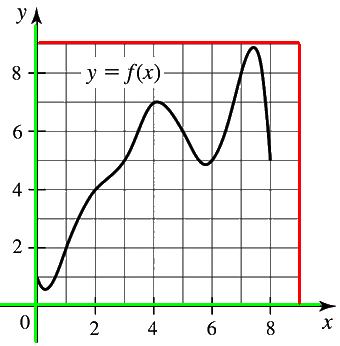

202
202


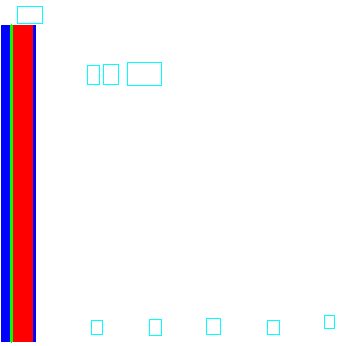

(326, 29, 3)


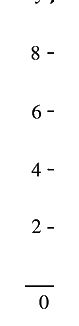

(326, 79, 3)
202
202
[{'boundingBox': [32, 46, 41, 45, 42, 59, 33, 60], 'text': '8'}, {'boundingBox': [47, 45, 53, 45, 54, 58, 47, 59], 'text': '-'}, {'boundingBox': [31, 105, 41, 104, 43, 119, 33, 120], 'text': '6'}, {'boundingBox': [46, 103, 48, 103, 50, 118, 48, 118], 'text': '-', 'confidence': 'Low'}, {'boundingBox': [33, 162, 44, 162, 44, 177, 33, 177], 'text': '4'}, {'boundingBox': [32, 218, 43, 217, 44, 233, 33, 234], 'text': '2'}, {'boundingBox': [47, 217, 53, 217, 53, 232, 48, 233], 'text': '-'}]
[{'boundingBox': [7, 46, 16, 45, 17, 59, 8, 60], 'text': '8'}, {'boundingBox': [22, 45, 28, 45, 29, 58, 22, 59], 'text': '-'}, {'boundingBox': [6, 105, 16, 104, 18, 119, 8, 120], 'text': '6'}, {'boundingBox': [21, 103, 23, 103, 25, 118, 23, 118], 'text': '-', 'confidence': 'Low'}, {'boundingBox': [8, 162, 19, 162, 19, 177, 8, 177], 'text': '4'}, {'boundingBox': [7, 218, 18, 217, 19, 233, 8, 234], 'text': '2'}, {'boundingBox': [22, 217, 28, 217, 28, 232, 23, 233], 'text': '-'}]
[{'boun

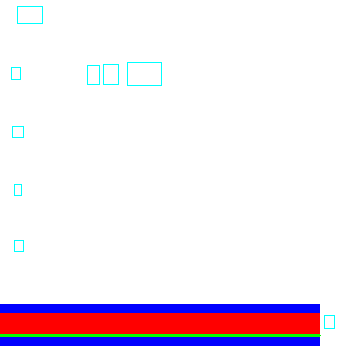

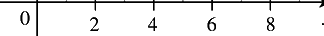

(36, 324, 3)


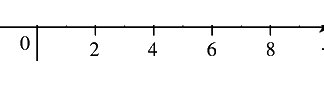

(86, 324, 3)
202
202
[{'boundingBox': [91, 41, 101, 40, 103, 55, 93, 56], 'text': '2'}, {'boundingBox': [150, 40, 161, 41, 160, 57, 149, 56], 'text': '4'}, {'boundingBox': [207, 42, 217, 40, 219, 55, 209, 56], 'text': '6'}, {'boundingBox': [267, 39, 276, 39, 278, 55, 268, 56], 'text': '8'}]
[{'boundingBox': [91, 16, 101, 15, 103, 30, 93, 31], 'text': '2'}, {'boundingBox': [150, 15, 161, 16, 160, 32, 149, 31], 'text': '4'}, {'boundingBox': [207, 17, 217, 15, 219, 30, 209, 31], 'text': '6'}, {'boundingBox': [267, 14, 276, 14, 278, 30, 268, 31], 'text': '8'}]
[{'boundingBox': [91, 320, 101, 319, 103, 334, 93, 335], 'text': '2'}, {'boundingBox': [150, 319, 161, 320, 160, 336, 149, 335], 'text': '4'}, {'boundingBox': [207, 321, 217, 319, 219, 334, 209, 335], 'text': '6'}, {'boundingBox': [267, 318, 276, 318, 278, 334, 268, 335], 'text': '8'}]
[{'boundingBox': [13, 66, 22, 65, 23, 79, 14, 80], 'text': '8'}, {'boundingBox': [28, 65, 34, 65, 35, 78, 28, 79], 'text': '-'}, {'boundingBox': [12, 

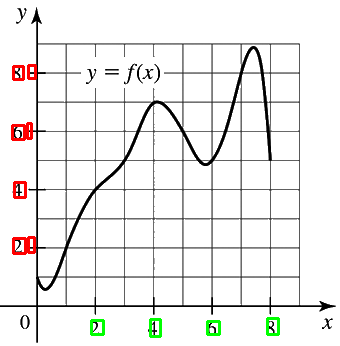

202
202
[[[33, 372], [428, 372]], [[71, 81], [398, 81]]] [[[68, 26], [68, 409]], [[401, 54], [401, 371]]]


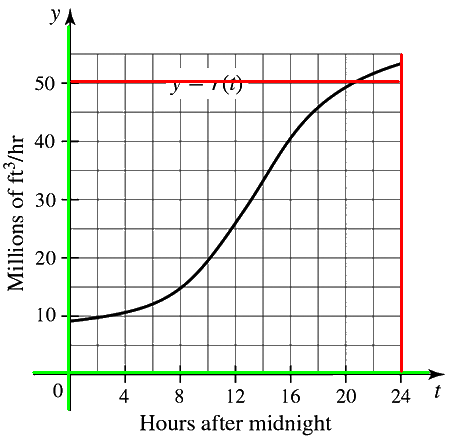

202
202


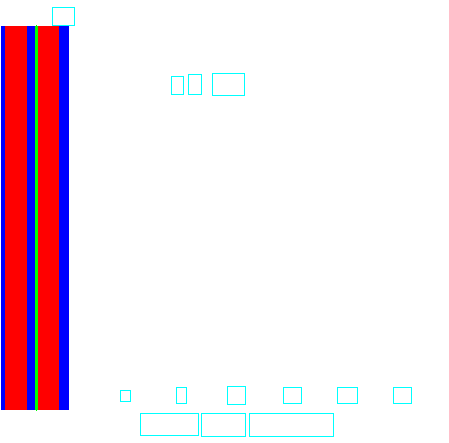

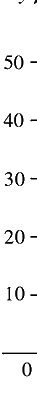

(393, 37, 3)


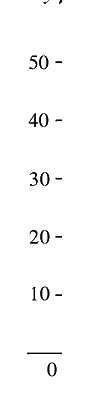

(393, 87, 3)
202
202
[{'boundingBox': [30, 55, 49, 54, 50, 69, 31, 70], 'text': '50'}, {'boundingBox': [55, 53, 63, 53, 64, 68, 56, 68], 'text': '-'}, {'boundingBox': [30, 112, 49, 112, 49, 127, 30, 127], 'text': '40'}, {'boundingBox': [56, 112, 62, 111, 62, 126, 56, 127], 'text': '-'}, {'boundingBox': [29, 171, 51, 170, 51, 186, 30, 187], 'text': '30'}, {'boundingBox': [55, 170, 61, 170, 62, 185, 56, 186], 'text': '-'}, {'boundingBox': [30, 229, 50, 227, 51, 242, 31, 244], 'text': '20'}, {'boundingBox': [55, 227, 63, 226, 64, 241, 56, 242], 'text': '-'}, {'boundingBox': [31, 285, 51, 285, 51, 301, 31, 301], 'text': '10'}, {'boundingBox': [56, 285, 63, 285, 63, 301, 56, 301], 'text': '-'}, {'boundingBox': [46, 355, 58, 354, 59, 376, 47, 377], 'text': '0', 'confidence': 'Low'}]
[{'boundingBox': [5, 55, 24, 54, 25, 69, 6, 70], 'text': '50'}, {'boundingBox': [30, 53, 38, 53, 39, 68, 31, 68], 'text': '-'}, {'boundingBox': [5, 112, 24, 112, 24, 127, 5, 127], 'text': '40'}, {'boundingBox': [

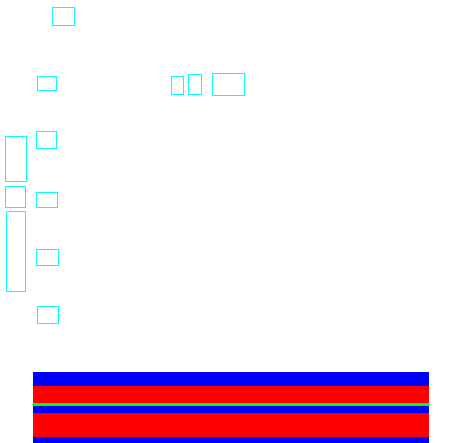

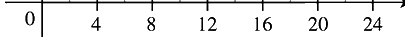

(37, 405, 3)


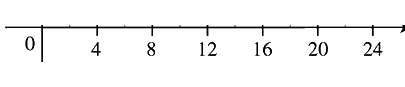

(87, 405, 3)
202
202
[{'boundingBox': [92, 42, 101, 41, 102, 54, 93, 55], 'text': '4'}, {'boundingBox': [148, 42, 158, 42, 158, 56, 148, 56], 'text': '8'}, {'boundingBox': [199, 40, 220, 40, 221, 57, 199, 57], 'text': '12'}, {'boundingBox': [254, 42, 274, 42, 274, 58, 254, 58], 'text': '16'}, {'boundingBox': [309, 41, 330, 41, 330, 57, 309, 57], 'text': '20'}, {'boundingBox': [365, 41, 384, 41, 384, 57, 365, 57], 'text': '24'}]
[{'boundingBox': [92, 17, 101, 16, 102, 29, 93, 30], 'text': '4'}, {'boundingBox': [148, 17, 158, 17, 158, 31, 148, 31], 'text': '8'}, {'boundingBox': [199, 15, 220, 15, 221, 32, 199, 32], 'text': '12'}, {'boundingBox': [254, 17, 274, 17, 274, 33, 254, 33], 'text': '16'}, {'boundingBox': [309, 16, 330, 16, 330, 32, 309, 32], 'text': '20'}, {'boundingBox': [365, 16, 384, 16, 384, 32, 365, 32], 'text': '24'}]
[{'boundingBox': [120, 389, 129, 388, 130, 401, 121, 402], 'text': '4'}, {'boundingBox': [176, 389, 186, 389, 186, 403, 176, 403], 'text': '8'}, {'boundingBo

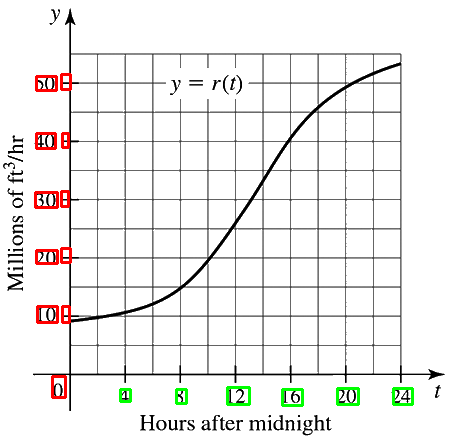

202
202
202
[[[4, 137], [234, 137]], [[99990, -109], [-10010, -109]]] [[[129, 19], [129, 263]], [[-109, 99990], [-109, -10010]]]


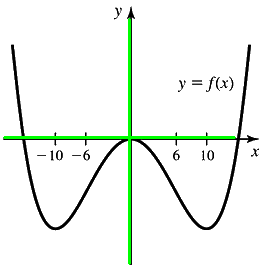

202
202


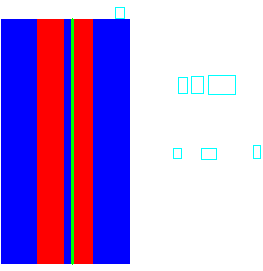

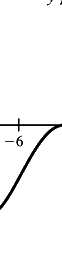

(254, 62, 3)


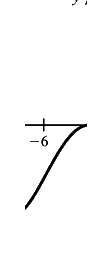

(254, 112, 3)
202
[]
[]
[]


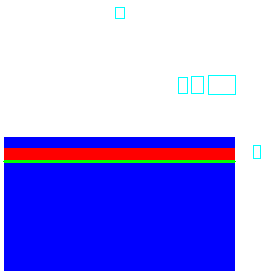

(29, 239, 3)


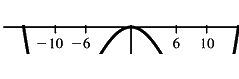

(79, 239, 3)
202
202
[{'boundingBox': [37, 34, 66, 33, 67, 52, 37, 52], 'text': '-10'}, {'boundingBox': [72, 33, 93, 34, 94, 52, 72, 52], 'text': '-6'}, {'boundingBox': [174, 36, 182, 37, 181, 49, 173, 48], 'text': '6'}, {'boundingBox': [200, 36, 214, 36, 215, 49, 201, 50], 'text': '10'}]
[{'boundingBox': [37, 9, 66, 8, 67, 27, 37, 27], 'text': '-10'}, {'boundingBox': [72, 8, 93, 9, 94, 27, 72, 27], 'text': '-6'}, {'boundingBox': [174, 11, 182, 12, 181, 24, 173, 23], 'text': '6'}, {'boundingBox': [200, 11, 214, 11, 215, 24, 201, 25], 'text': '10'}]
[{'boundingBox': [37, 146, 66, 145, 67, 164, 37, 164], 'text': '-10'}, {'boundingBox': [72, 145, 93, 146, 94, 164, 72, 164], 'text': '-6'}, {'boundingBox': [174, 148, 182, 149, 181, 161, 173, 160], 'text': '6'}, {'boundingBox': [200, 148, 214, 148, 215, 161, 201, 162], 'text': '10'}]
[]
[{'boundingBox': [37, 146, 66, 145, 67, 164, 37, 164], 'text': '-10'}, {'boundingBox': [72, 145, 93, 146, 94, 164, 72, 164], 'text': '-6'}, {'boundingBox': [

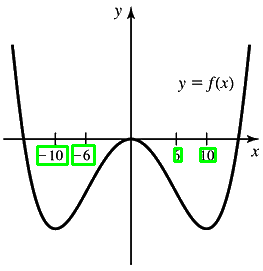

202
202
202
[[[3, 121], [274, 121]], [[99990, -109], [-10010, -109]]] [[[104, 23], [104, 224]], [[85, 49], [85, 60]]]


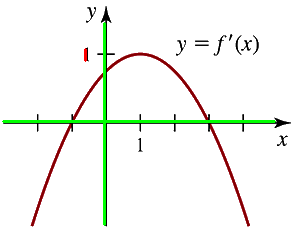

202
202
202
202


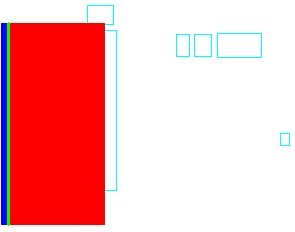

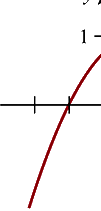

(211, 101, 3)


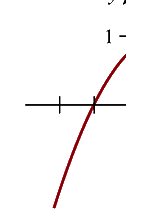

(211, 151, 3)
202
202
[{'boundingBox': [107, 26, 119, 27, 118, 44, 106, 43], 'text': '1'}]
[{'boundingBox': [82, 26, 94, 27, 93, 44, 81, 43], 'text': '1'}]
[{'boundingBox': [85, 44, 97, 45, 96, 62, 84, 61], 'text': '1'}]


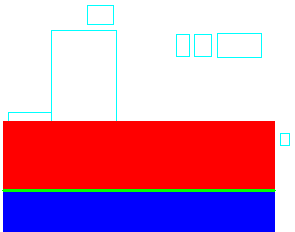

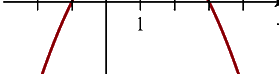

(74, 279, 3)


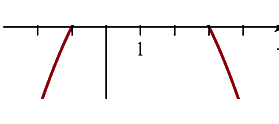

(124, 279, 3)
202
[]
[]
[]
[{'boundingBox': [85, 44, 97, 45, 96, 62, 84, 61], 'text': '1'}]
[]


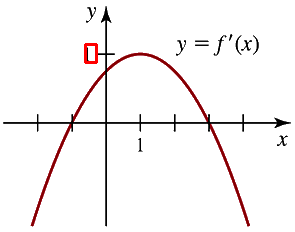

202
202
202
[[[664, 462], [1381, 462]], [[945, 299], [974, 299]]] [[[958, 46], [958, 754]], [[798, 449], [798, 479]]]


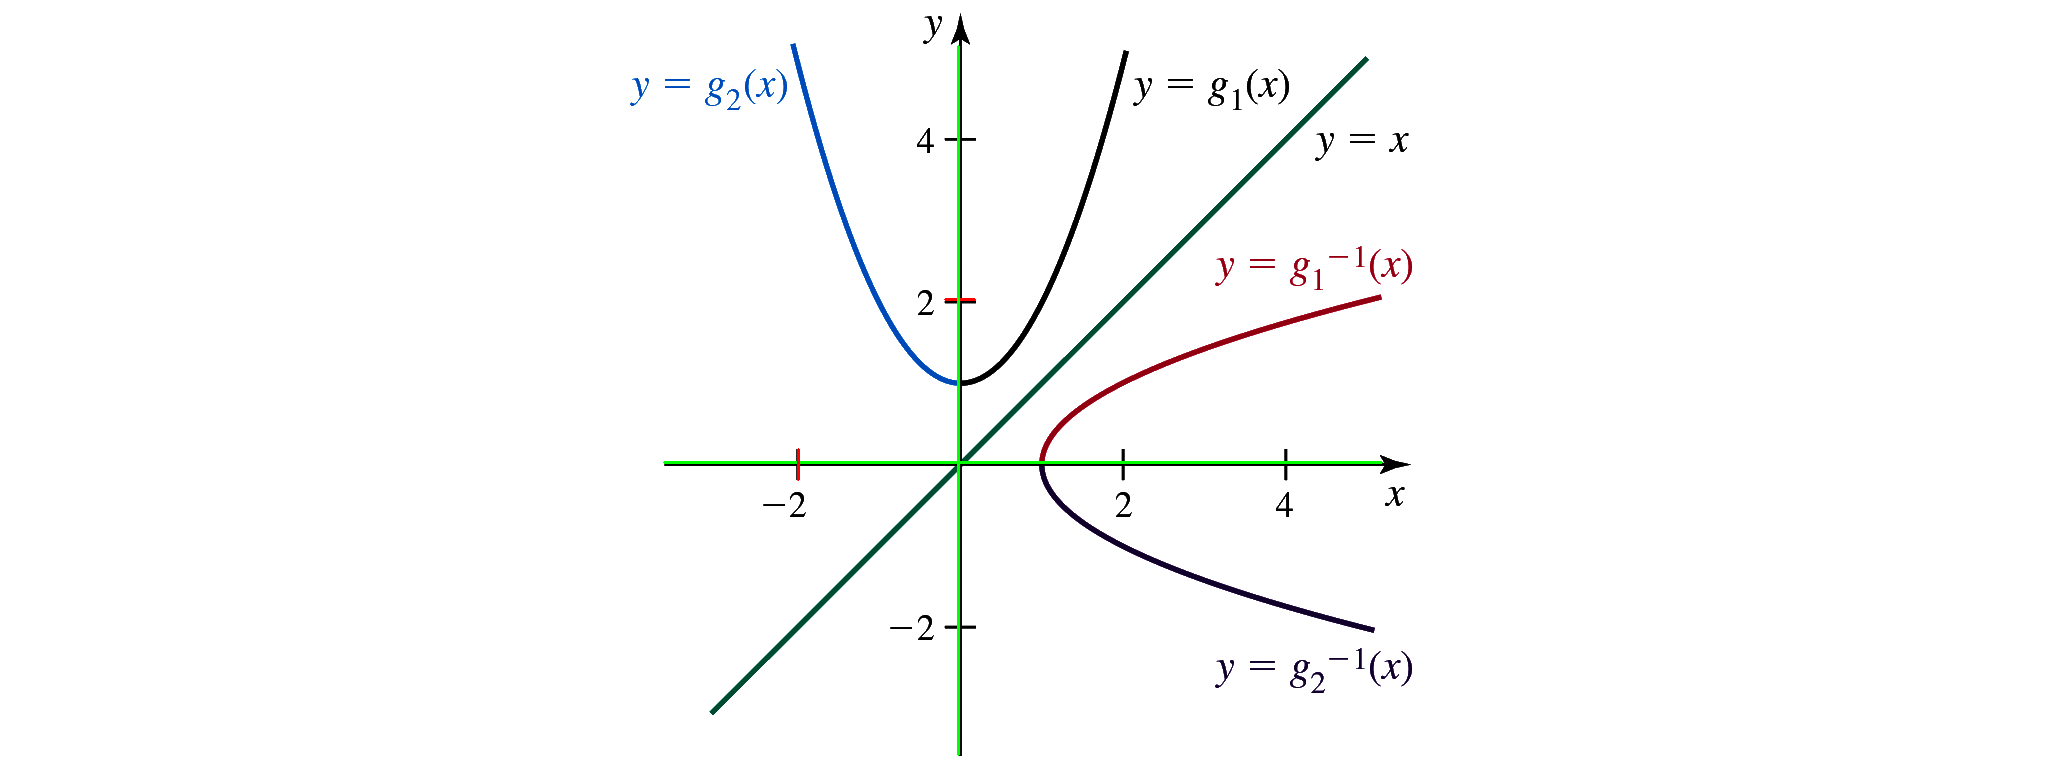

202
202


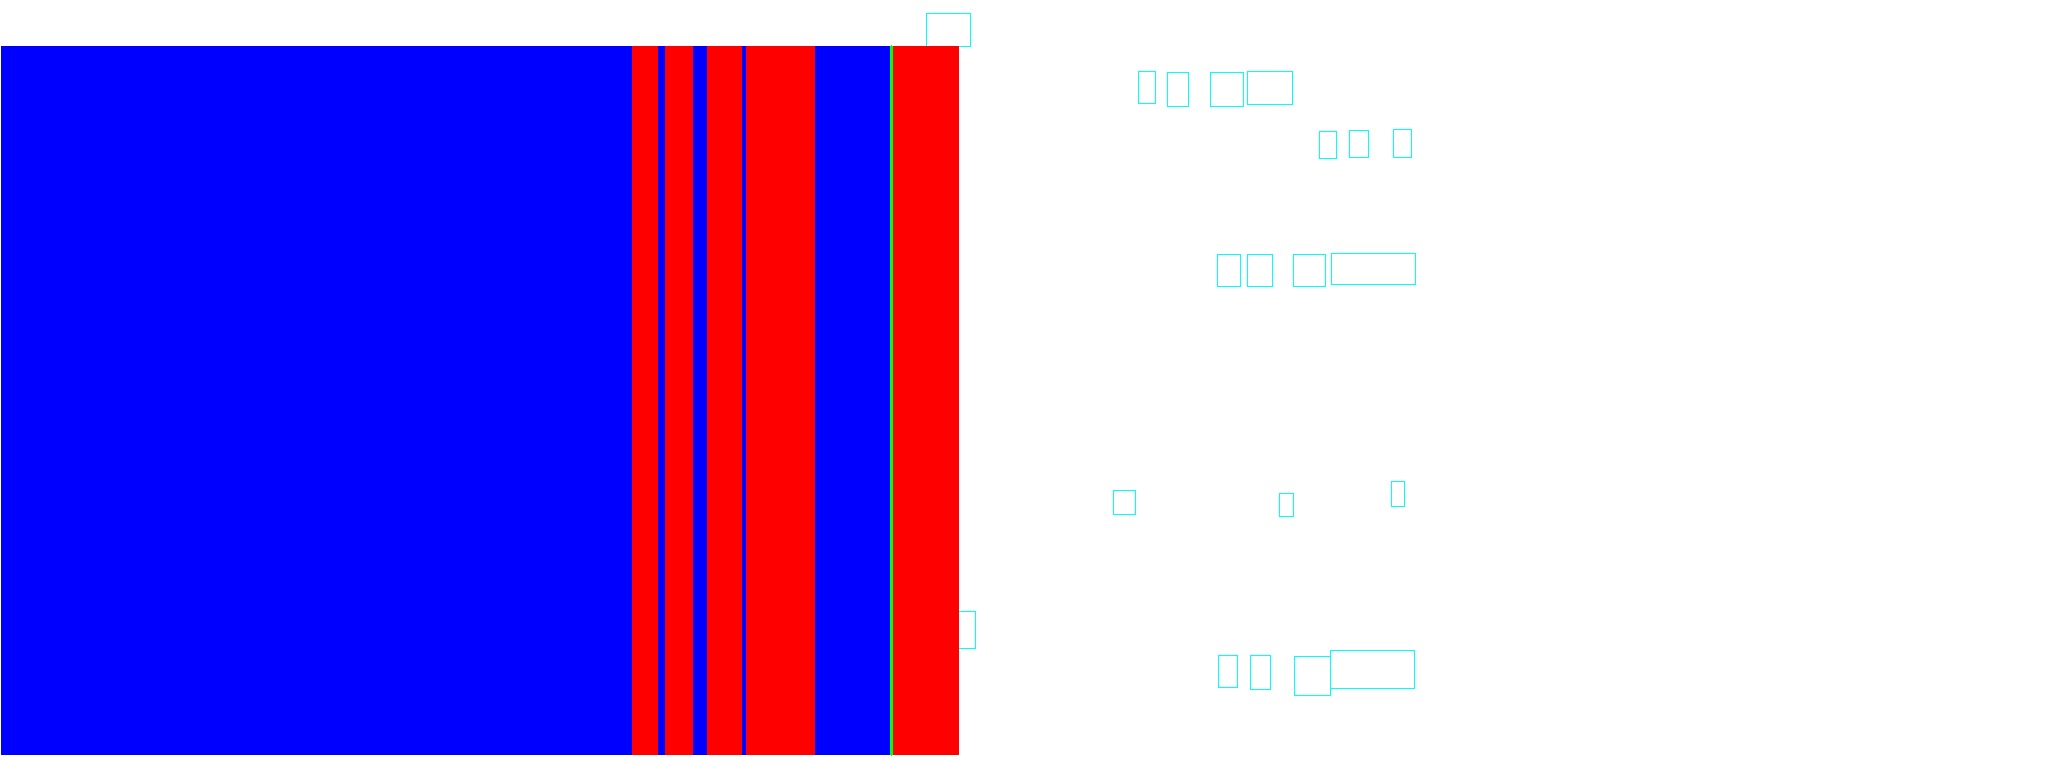

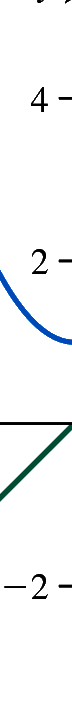

(718, 72, 3)


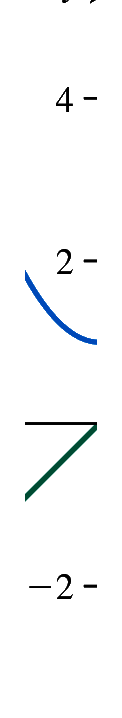

(718, 122, 3)
202
202
[{'boundingBox': [56, 88, 74, 87, 76, 111, 58, 112], 'text': '4'}, {'boundingBox': [84, 86, 96, 85, 98, 109, 85, 110], 'text': '-'}, {'boundingBox': [58, 248, 76, 247, 77, 274, 59, 275], 'text': '2'}, {'boundingBox': [83, 247, 96, 246, 97, 273, 84, 274], 'text': '-'}, {'boundingBox': [31, 572, 79, 572, 79, 602, 31, 602], 'text': '-2'}, {'boundingBox': [85, 572, 99, 572, 99, 602, 85, 602], 'text': '-'}]
[{'boundingBox': [31, 88, 49, 87, 51, 111, 33, 112], 'text': '4'}, {'boundingBox': [59, 86, 71, 85, 73, 109, 60, 110], 'text': '-'}, {'boundingBox': [33, 248, 51, 247, 52, 274, 34, 275], 'text': '2'}, {'boundingBox': [58, 247, 71, 246, 72, 273, 59, 274], 'text': '-'}, {'boundingBox': [6, 572, 54, 572, 54, 602, 6, 602], 'text': '-2'}, {'boundingBox': [60, 572, 74, 572, 74, 602, 60, 602], 'text': '-'}]
[{'boundingBox': [917, 129, 935, 128, 937, 152, 919, 153], 'text': '4'}, {'boundingBox': [945, 127, 957, 126, 959, 150, 946, 151], 'text': '-'}, {'boundingBox': [919, 2

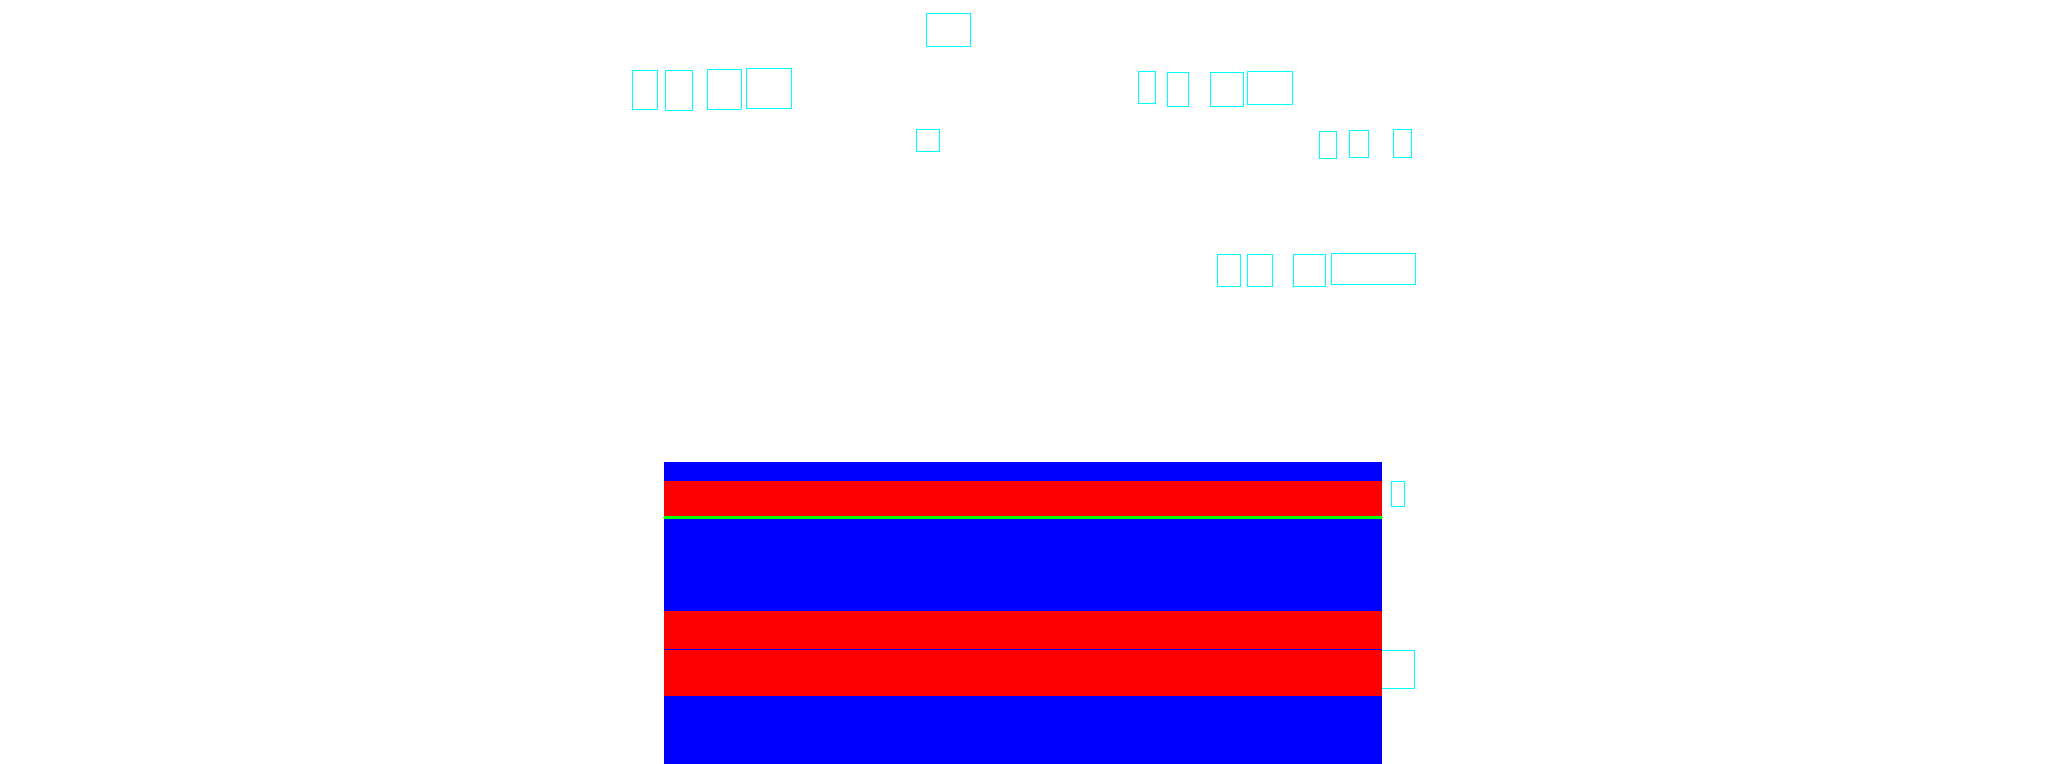

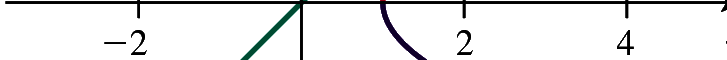

(60, 727, 3)


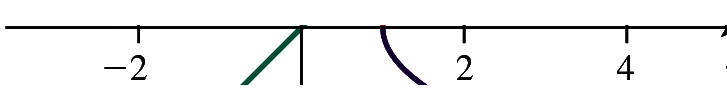

(110, 727, 3)
202
202
[{'boundingBox': [104, 53, 148, 51, 149, 81, 105, 83], 'text': '-2'}, {'boundingBox': [459, 56, 470, 55, 472, 79, 460, 80], 'text': '2'}, {'boundingBox': [621, 57, 635, 58, 634, 79, 620, 78], 'text': '4'}]
[{'boundingBox': [104, 28, 148, 26, 149, 56, 105, 58], 'text': '-2'}, {'boundingBox': [459, 31, 470, 30, 472, 54, 460, 55], 'text': '2'}, {'boundingBox': [621, 32, 635, 33, 634, 54, 620, 53], 'text': '4'}]
[{'boundingBox': [763, 490, 807, 488, 808, 518, 764, 520], 'text': '-2'}, {'boundingBox': [1118, 493, 1129, 492, 1131, 516, 1119, 517], 'text': '2'}, {'boundingBox': [1280, 494, 1294, 495, 1293, 516, 1279, 515], 'text': '4'}]
[{'boundingBox': [917, 129, 935, 128, 937, 152, 919, 153], 'text': '4'}, {'boundingBox': [945, 127, 957, 126, 959, 150, 946, 151], 'text': '-'}, {'boundingBox': [919, 289, 937, 288, 938, 315, 920, 316], 'text': '2'}, {'boundingBox': [944, 288, 957, 287, 958, 314, 945, 315], 'text': '-'}, {'boundingBox': [892, 613, 940, 613, 940, 643, 892,

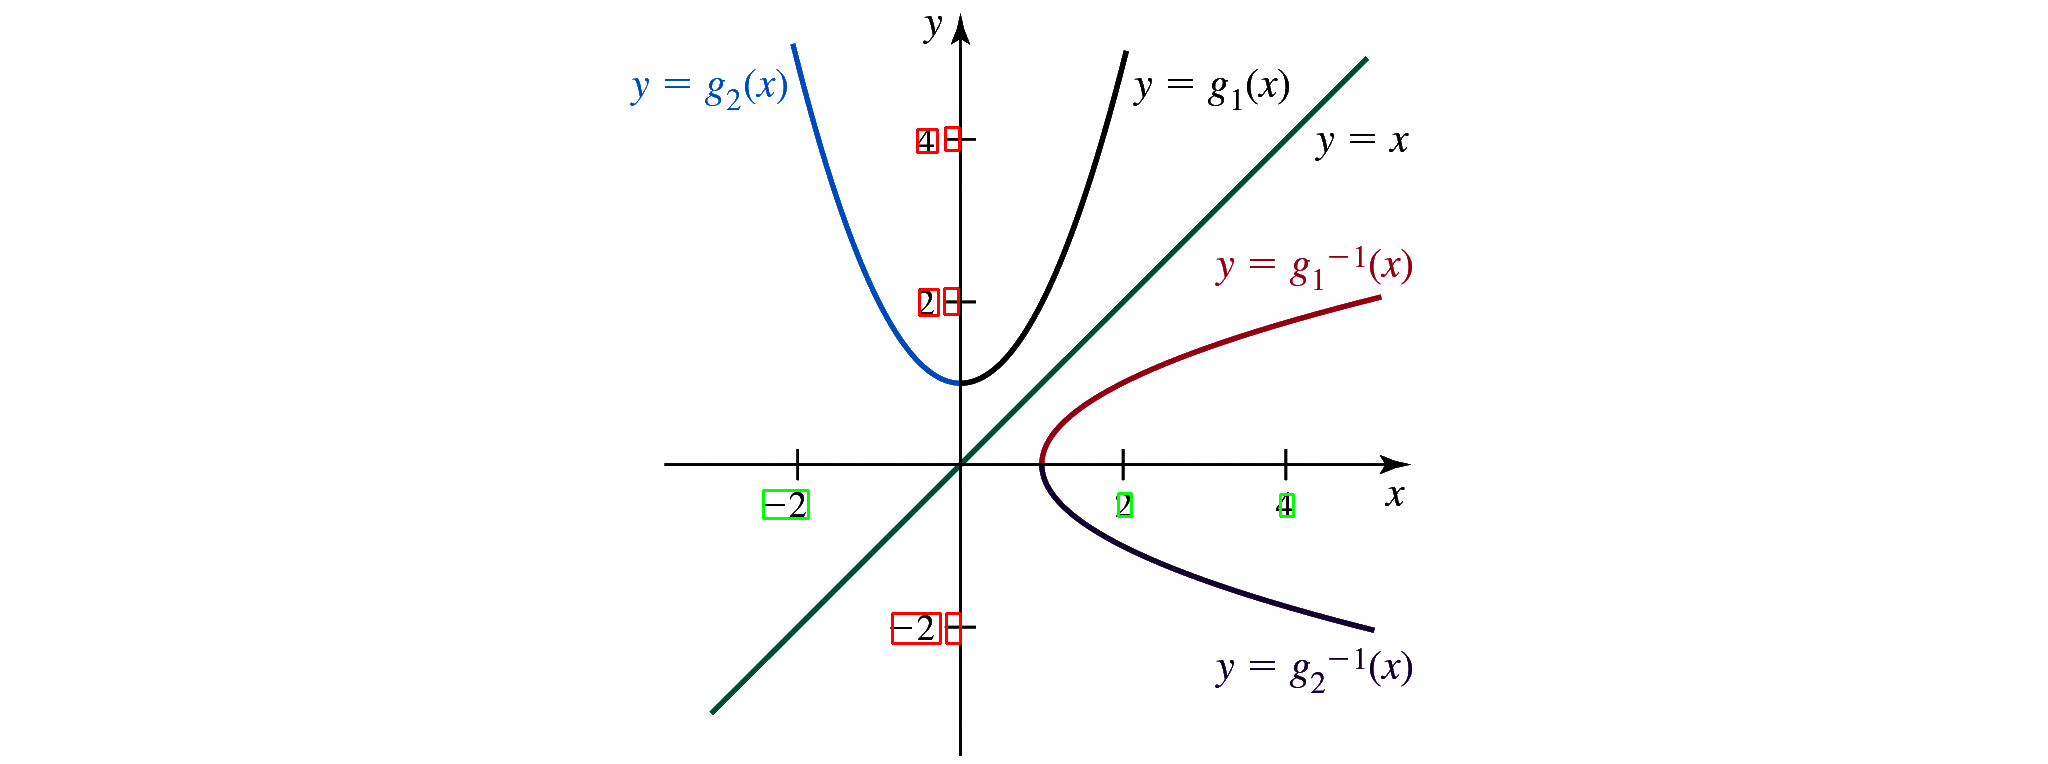

202
202
202
[[[31, 108], [211, 108]], [[33, 161], [204, 161]]] [[[27, 39], [27, 180]], [[120, 108], [120, 165]]]


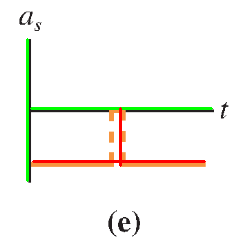

202
202


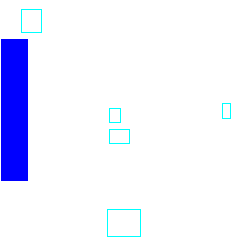

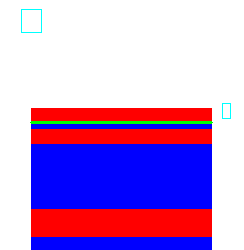

(19, 190, 3)


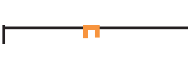

(69, 190, 3)
202
[]
[]
[]
[]
[]


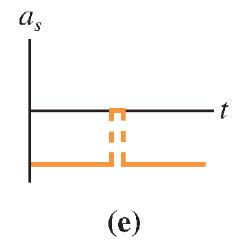

202
202
[[[65, 130], [489, 130]], [[65, 270], [489, 270]]] [[[78, 46], [78, 389]], [[122, 65], [122, 383]]]


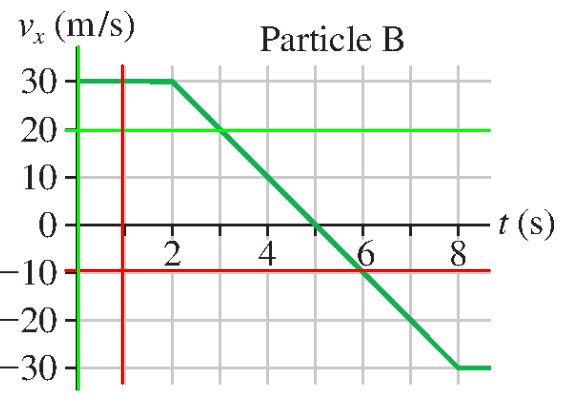

202
202
202


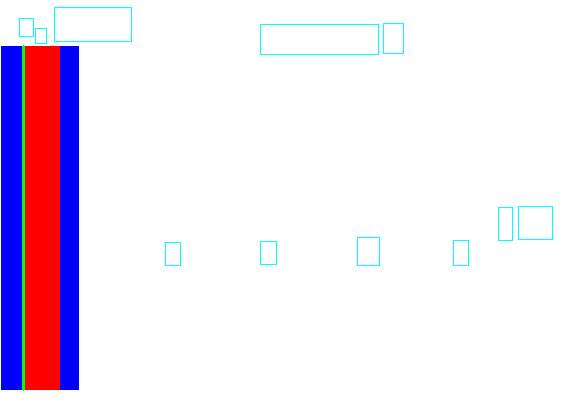

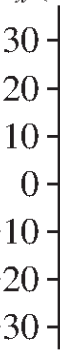

(353, 60, 3)


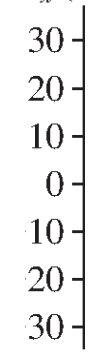

(353, 110, 3)
202
202
[{'boundingBox': [30, 25, 65, 25, 66, 54, 31, 54], 'text': '30'}, {'boundingBox': [31, 74, 61, 74, 61, 102, 31, 102], 'text': '20'}, {'boundingBox': [32, 121, 65, 121, 65, 150, 32, 150], 'text': '10'}, {'boundingBox': [45, 166, 64, 165, 65, 201, 46, 202], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [32, 217, 64, 217, 63, 245, 31, 245], 'text': '10'}, {'boundingBox': [30, 263, 61, 263, 61, 292, 30, 292], 'text': '20'}, {'boundingBox': [30, 312, 66, 312, 65, 342, 29, 342], 'text': '30'}, {'boundingBox': [72, 313, 86, 313, 85, 343, 71, 343], 'text': '-'}]
[{'boundingBox': [5, 25, 40, 25, 41, 54, 6, 54], 'text': '30'}, {'boundingBox': [6, 74, 36, 74, 36, 102, 6, 102], 'text': '20'}, {'boundingBox': [7, 121, 40, 121, 40, 150, 7, 150], 'text': '10'}, {'boundingBox': [20, 166, 39, 165, 40, 201, 21, 202], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [7, 217, 39, 217, 38, 245, 6, 245], 'text': '10'}, {'boundingBox': [5, 263, 36, 263, 36, 292, 5, 292], 'text': 

(140, 434, 3)


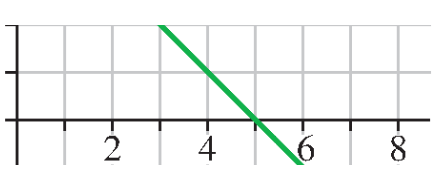

(190, 434, 3)
202
202
[{'boundingBox': [107, 135, 119, 135, 120, 160, 108, 160], 'text': '2'}, {'boundingBox': [201, 134, 216, 134, 216, 162, 201, 162], 'text': '4'}, {'boundingBox': [297, 122, 318, 122, 317, 165, 297, 165], 'text': '6'}, {'boundingBox': [393, 132, 408, 132, 409, 160, 394, 161], 'text': '8'}]
[{'boundingBox': [107, 110, 119, 110, 120, 135, 108, 135], 'text': '2'}, {'boundingBox': [201, 109, 216, 109, 216, 137, 201, 137], 'text': '4'}, {'boundingBox': [297, 97, 318, 97, 317, 140, 297, 140], 'text': '6'}, {'boundingBox': [393, 107, 408, 107, 409, 135, 394, 136], 'text': '8'}]
[{'boundingBox': [167, 240, 179, 240, 180, 265, 168, 265], 'text': '2'}, {'boundingBox': [261, 239, 276, 239, 276, 267, 261, 267], 'text': '4'}, {'boundingBox': [357, 227, 378, 227, 377, 270, 357, 270], 'text': '6'}, {'boundingBox': [453, 237, 468, 237, 469, 265, 454, 266], 'text': '8'}]
[{'boundingBox': [23, 66, 58, 66, 59, 95, 24, 95], 'text': '30'}, {'boundingBox': [24, 115, 54, 115, 54, 143, 24,

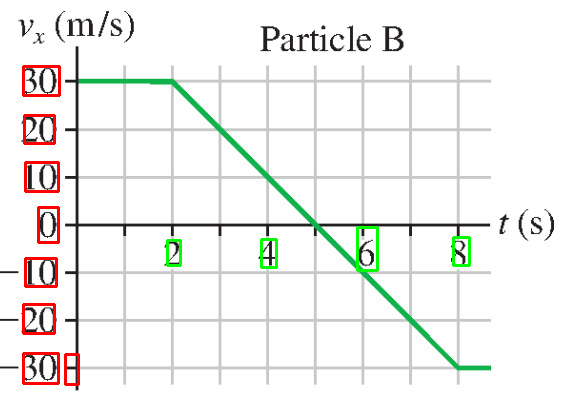

202
202
202
[[[100, 236], [524, 236]], [[100, 283], [524, 283]]] [[[109, 56], [109, 399]], [[158, 75], [158, 393]]]


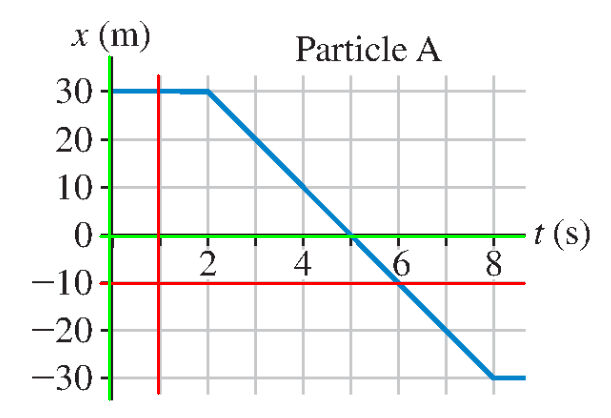

202
202
202


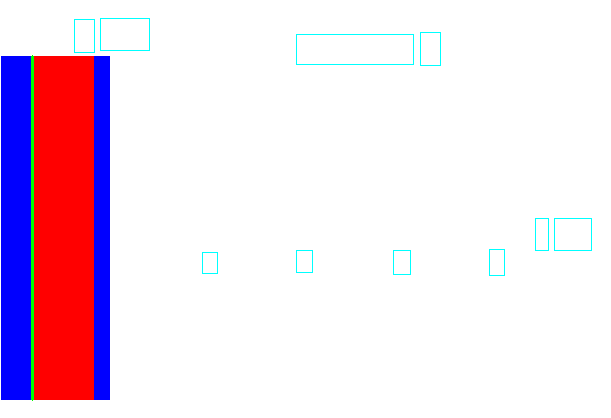

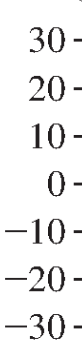

(353, 82, 3)


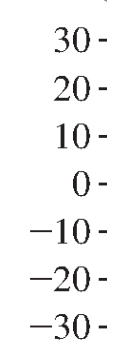

(353, 132, 3)
202
202
[{'boundingBox': [56, 25, 93, 26, 92, 55, 55, 54], 'text': '30'}, {'boundingBox': [100, 26, 112, 26, 111, 55, 100, 55], 'text': '-'}, {'boundingBox': [55, 75, 92, 74, 93, 102, 56, 103], 'text': '20'}, {'boundingBox': [100, 74, 109, 73, 110, 101, 100, 102], 'text': '-'}, {'boundingBox': [56, 121, 91, 120, 92, 148, 57, 149], 'text': '10'}, {'boundingBox': [99, 119, 106, 119, 107, 147, 100, 147], 'text': '-'}, {'boundingBox': [72, 168, 91, 167, 93, 196, 74, 197], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [97, 166, 103, 166, 105, 195, 99, 195], 'text': '-'}, {'boundingBox': [30, 218, 93, 218, 93, 246, 30, 246], 'text': '-10'}, {'boundingBox': [99, 218, 110, 218, 110, 246, 99, 246], 'text': '-'}, {'boundingBox': [30, 265, 91, 263, 92, 291, 31, 293], 'text': '-20'}, {'boundingBox': [99, 262, 106, 262, 107, 290, 100, 290], 'text': '-'}, {'boundingBox': [29, 315, 92, 313, 92, 342, 31, 343], 'text': '-30'}, {'boundingBox': [99, 313, 112, 313, 112, 341, 99, 341], '

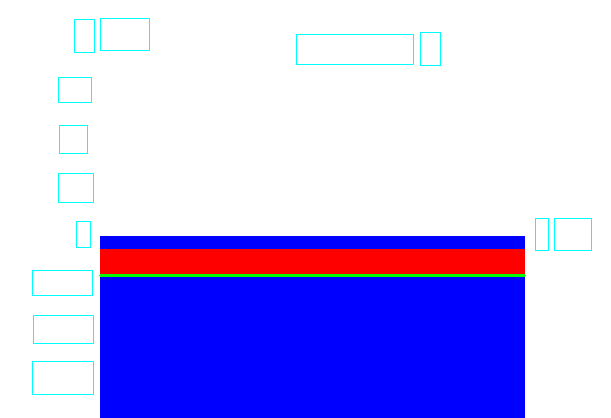

(44, 434, 3)


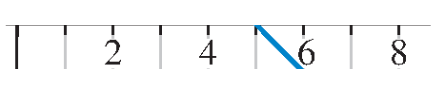

(94, 434, 3)
202
202
202
202
[{'boundingBox': [202, 35, 214, 35, 214, 64, 203, 64], 'text': '4'}, {'boundingBox': [249, 23, 332, 22, 333, 72, 249, 73], 'text': 'N6'}, {'boundingBox': [389, 64, 386, 27, 404, 26, 407, 63], 'text': 'Co-', 'confidence': 'Low'}]
[{'boundingBox': [202, 10, 214, 10, 214, 39, 203, 39], 'text': '4'}, {'boundingBox': [249, -2, 332, -3, 333, 47, 249, 48], 'text': 'N6'}, {'boundingBox': [389, 39, 386, 2, 404, 1, 407, 38], 'text': 'Co-', 'confidence': 'Low'}]
[{'boundingBox': [297, 246, 309, 246, 309, 275, 298, 275], 'text': '4'}, {'boundingBox': [344, 234, 427, 233, 428, 283, 344, 284], 'text': 'N6'}, {'boundingBox': [484, 275, 481, 238, 499, 237, 502, 274], 'text': 'Co-', 'confidence': 'Low'}]
[{'boundingBox': [58, 76, 95, 77, 94, 106, 57, 105], 'text': '30'}, {'boundingBox': [102, 77, 114, 77, 113, 106, 102, 106], 'text': '-'}, {'boundingBox': [57, 126, 94, 125, 95, 153, 58, 154], 'text': '20'}, {'boundingBox': [102, 125, 111, 124, 112, 152, 102, 153], 'text': '

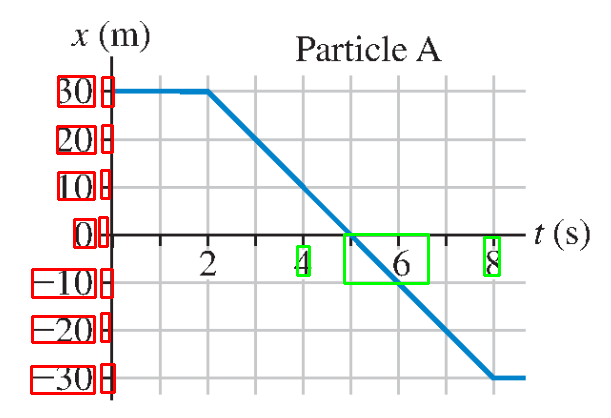

202
202
[[[31, 111], [211, 111]], [[31, 162], [200, 162]]] [[[27, 43], [27, 184]], [[-109, 99990], [-109, -10010]]]


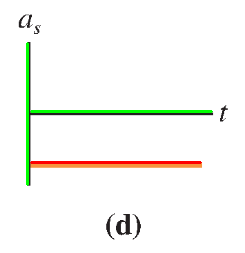

202
202


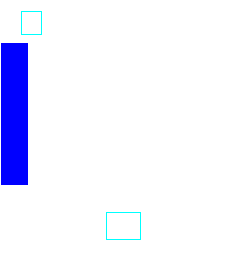

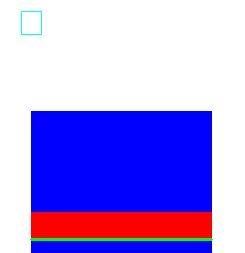

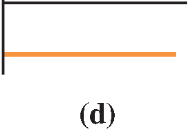

(133, 190, 3)


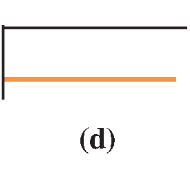

(183, 190, 3)
202
202
[{'boundingBox': [80, 126, 113, 125, 114, 154, 81, 155], 'text': '(d)'}]
[{'boundingBox': [80, 101, 113, 100, 114, 129, 81, 130], 'text': '(d)'}]
[{'boundingBox': [106, 212, 139, 211, 140, 240, 107, 241], 'text': '(d)'}]
[]
[{'boundingBox': [106, 212, 139, 211, 140, 240, 107, 241], 'text': '(d)'}]


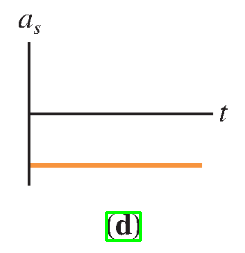

202
202
[[[34, 109], [214, 109]], [[115, 56], [201, 56]]] [[[29, 40], [29, 181]], [[114, 56], [114, 143]]]


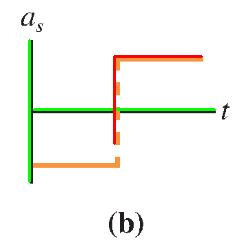

202
202
202


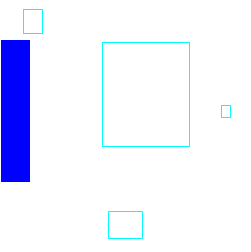

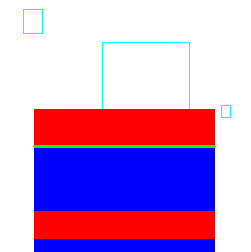

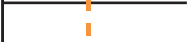

(42, 190, 3)


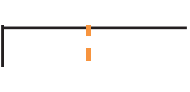

(92, 190, 3)
202
[]
[]
[]
[]
[]


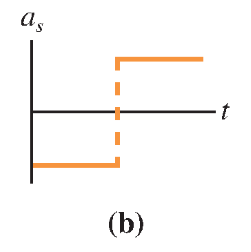

202
202
[[[30, 109], [210, 109]], [[31, 56], [199, 56]]] [[[26, 40], [26, 181]], [[-109, 99990], [-109, -10010]]]


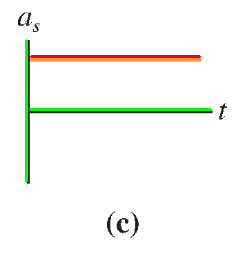

202
202


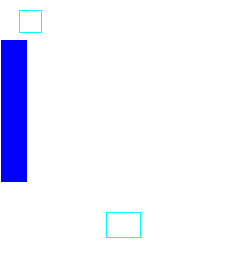

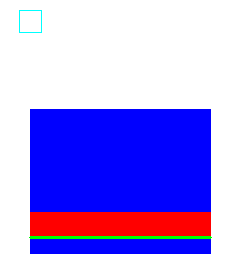

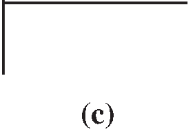

(133, 190, 3)


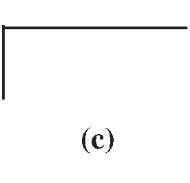

(183, 190, 3)
202
202
[{'boundingBox': [82, 126, 113, 126, 113, 154, 82, 154], 'text': '(c)'}]
[{'boundingBox': [82, 101, 113, 101, 113, 129, 82, 129], 'text': '(c)'}]
[{'boundingBox': [107, 210, 138, 210, 138, 238, 107, 238], 'text': '(c)'}]
[]
[{'boundingBox': [107, 210, 138, 210, 138, 238, 107, 238], 'text': '(c)'}]


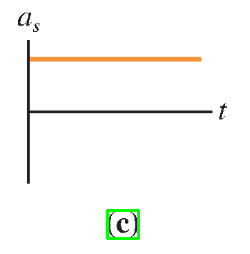

202
202
202
[[[83, 37], [738, 37]], [[83, 368], [738, 368]]] [[[627, 40], [627, 391]], [[80, 39], [80, 366]]]


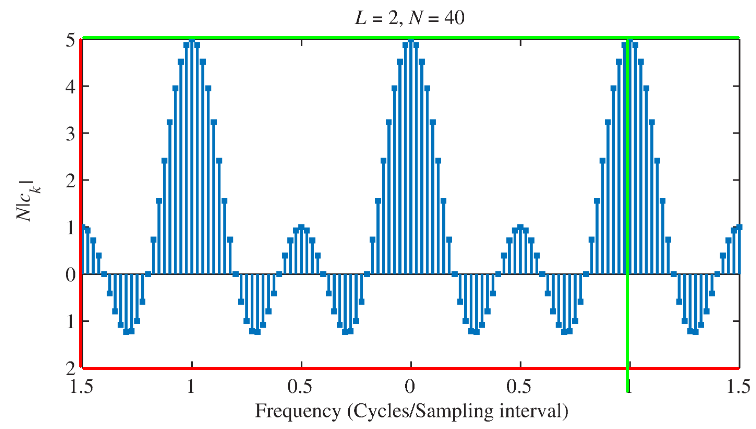

202
202


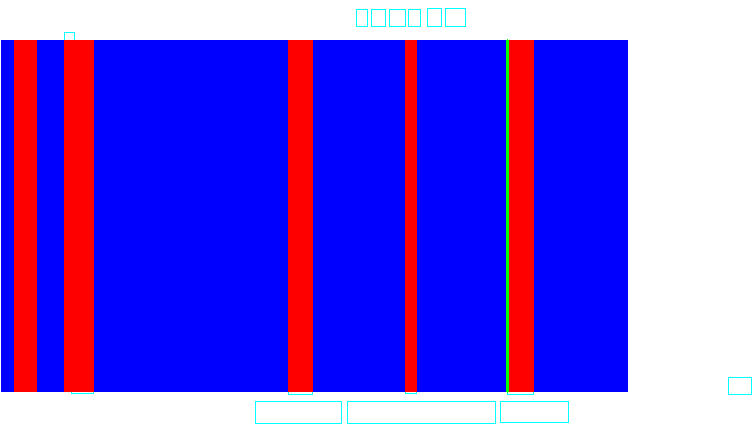

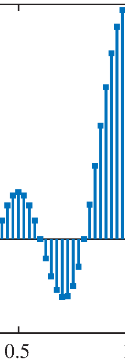

(361, 125, 3)


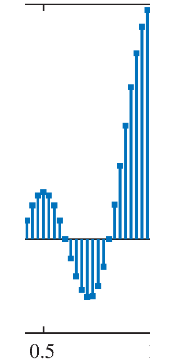

(361, 175, 3)
202
202
[{'boundingBox': [30, 342, 56, 342, 57, 357, 30, 358], 'text': '0.5'}]
[{'boundingBox': [5, 342, 31, 342, 32, 357, 5, 358], 'text': '0.5'}]
[{'boundingBox': [507, 377, 533, 377, 534, 392, 507, 393], 'text': '0.5'}]


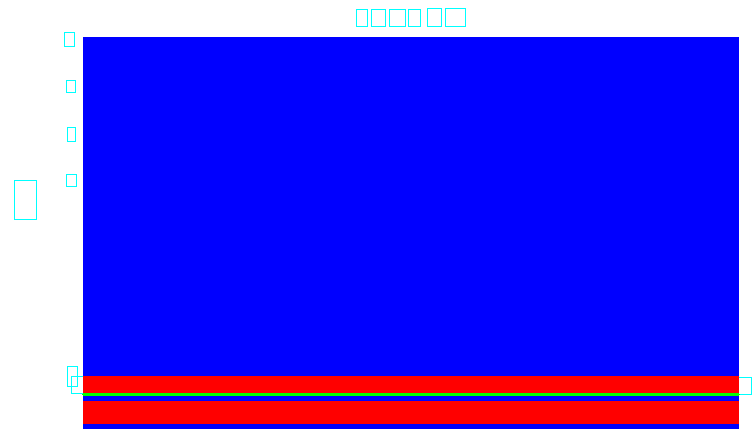

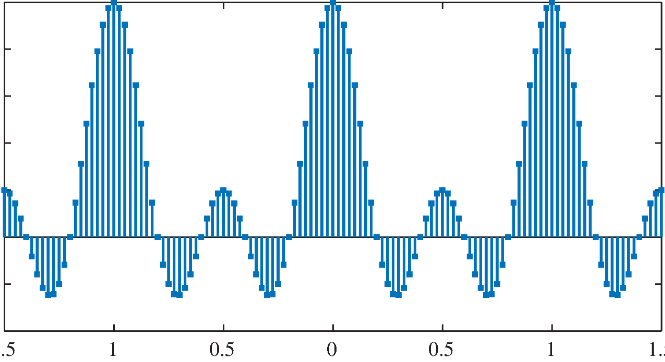

(362, 665, 3)


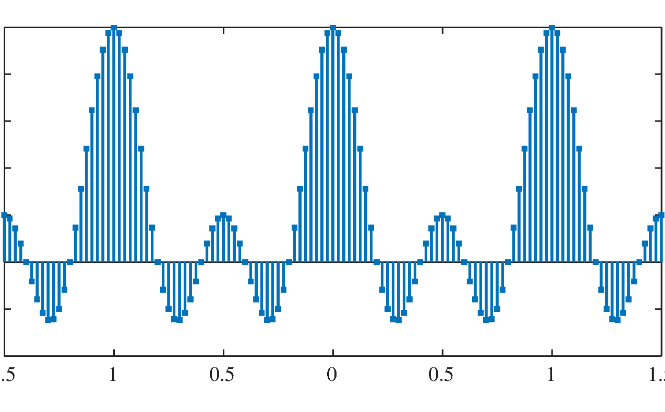

(412, 665, 3)
202
202
[{'boundingBox': [2, 366, 17, 366, 17, 382, 2, 382], 'text': '.5'}, {'boundingBox': [210, 365, 235, 365, 235, 382, 210, 382], 'text': '0.5'}, {'boundingBox': [325, 366, 335, 364, 338, 379, 328, 381], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [429, 366, 456, 366, 456, 382, 429, 382], 'text': '0.5'}, {'boundingBox': [650, 365, 655, 365, 656, 382, 650, 382], 'text': '1'}, {'boundingBox': [659, 365, 661, 364, 662, 381, 659, 382], 'text': '.'}]
[{'boundingBox': [2, 341, 17, 341, 17, 357, 2, 357], 'text': '.5'}, {'boundingBox': [210, 340, 235, 340, 235, 357, 210, 357], 'text': '0.5'}, {'boundingBox': [325, 341, 335, 339, 338, 354, 328, 356], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [429, 341, 456, 341, 456, 357, 429, 357], 'text': '0.5'}, {'boundingBox': [650, 340, 655, 340, 656, 357, 650, 357], 'text': '1'}, {'boundingBox': [659, 340, 661, 339, 662, 356, 659, 357], 'text': '.'}]
[{'boundingBox': [80, 378, 95, 378, 95, 394, 80, 394], 'text': '.5'}, {'

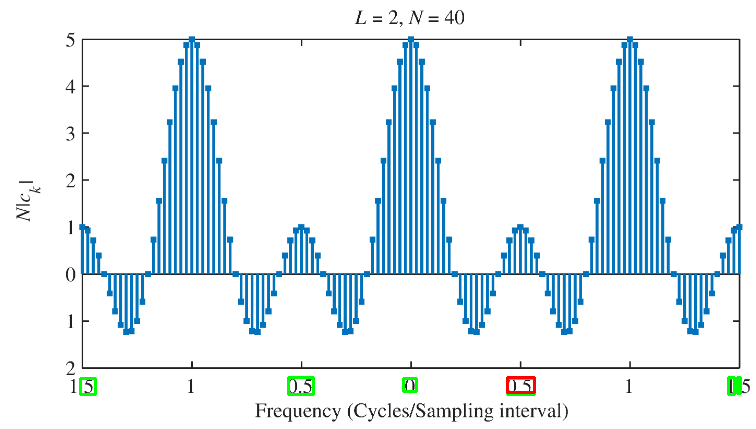

202
202
[[[71, 26], [728, 26]], [[73, 358], [728, 358]]] [[[620, 31], [620, 381]], [[182, 31], [182, 380]]]


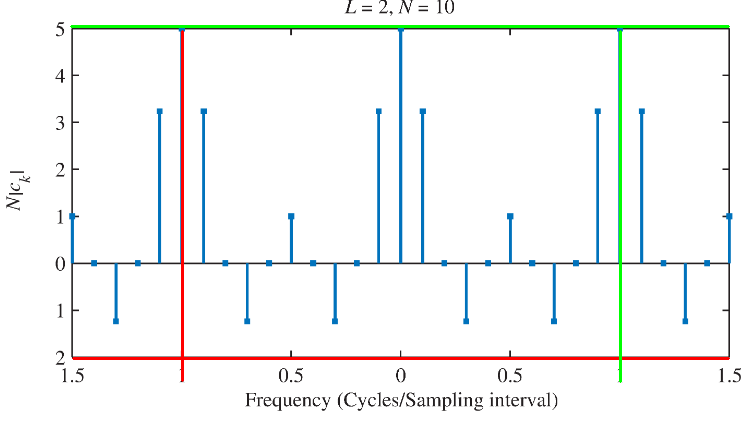

202
202
202


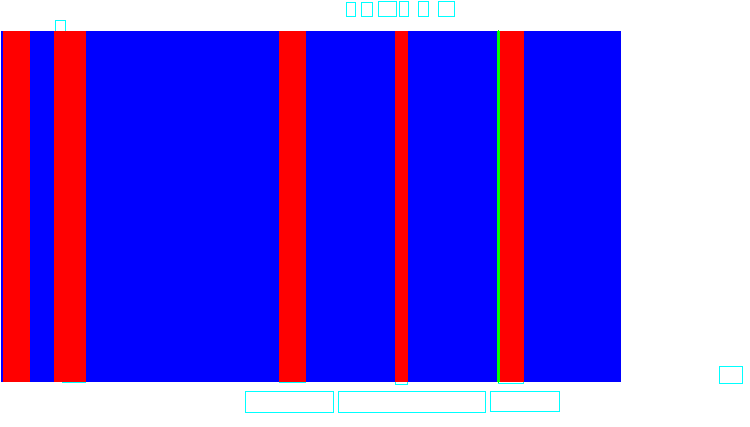

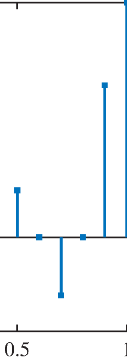

(360, 127, 3)


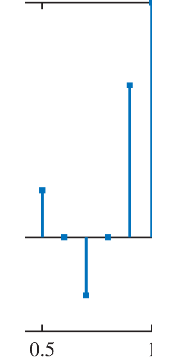

(360, 177, 3)
202
202
[{'boundingBox': [30, 340, 57, 340, 57, 357, 30, 357], 'text': '0.5'}]
[{'boundingBox': [5, 340, 32, 340, 32, 357, 5, 357], 'text': '0.5'}]
[{'boundingBox': [498, 366, 525, 366, 525, 383, 498, 383], 'text': '0.5'}]


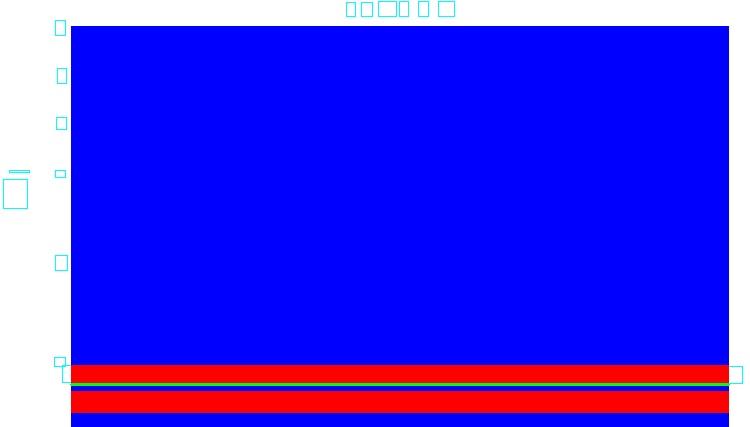

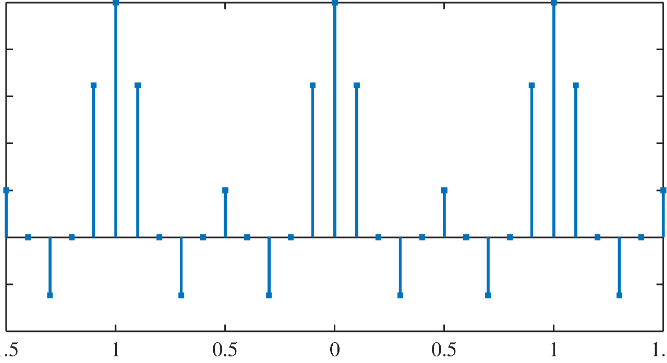

(363, 667, 3)


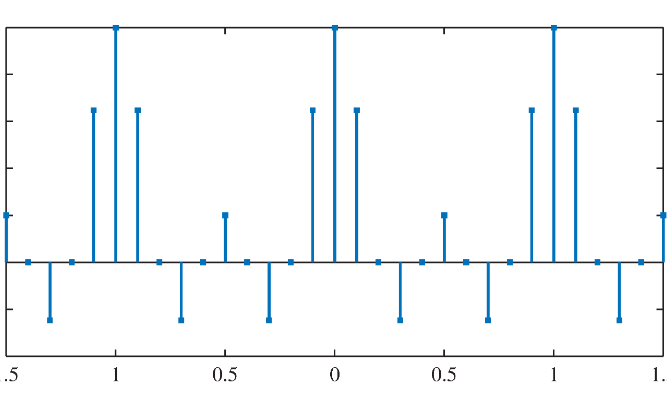

(413, 667, 3)
202
202
[{'boundingBox': [4, 366, 21, 366, 21, 383, 4, 383], 'text': '.5'}, {'boundingBox': [213, 366, 238, 365, 238, 382, 213, 383], 'text': '0.5'}, {'boundingBox': [330, 365, 340, 365, 340, 382, 330, 382], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [431, 366, 457, 365, 458, 381, 432, 382], 'text': '0.5'}, {'boundingBox': [654, 367, 665, 367, 665, 382, 654, 382], 'text': '1.', 'confidence': 'Low'}]
[{'boundingBox': [4, 341, 21, 341, 21, 358, 4, 358], 'text': '.5'}, {'boundingBox': [213, 341, 238, 340, 238, 357, 213, 358], 'text': '0.5'}, {'boundingBox': [330, 340, 340, 340, 340, 357, 330, 357], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [431, 341, 457, 340, 458, 356, 432, 357], 'text': '0.5'}, {'boundingBox': [654, 342, 665, 342, 665, 357, 654, 357], 'text': '1.', 'confidence': 'Low'}]
[{'boundingBox': [70, 367, 87, 367, 87, 384, 70, 384], 'text': '.5'}, {'boundingBox': [279, 367, 304, 366, 304, 383, 279, 384], 'text': '0.5'}, {'boundingBox': [396, 366, 4

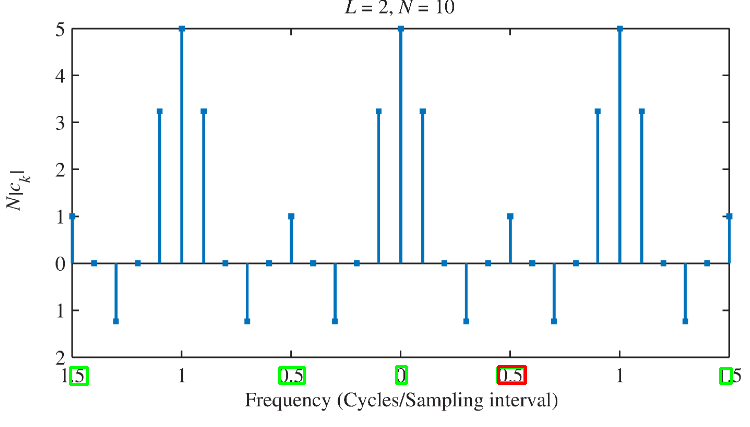

202
202
202
202
[[[91, 130], [670, 130]], [[91, 345], [670, 345]]] [[[106, 74], [106, 579]], [[211, 74], [211, 579]]]


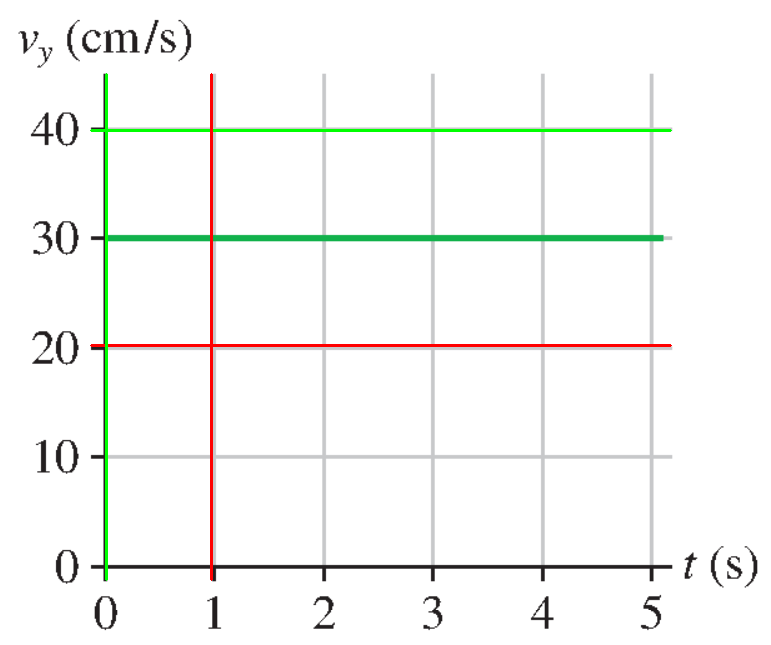

202
202
202


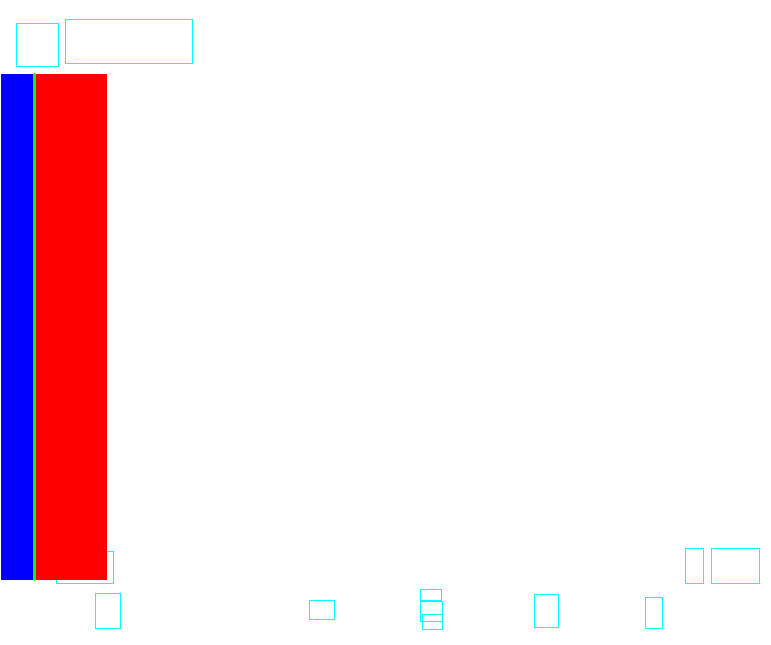

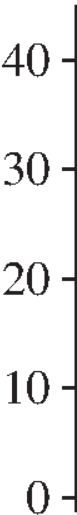

(515, 77, 3)


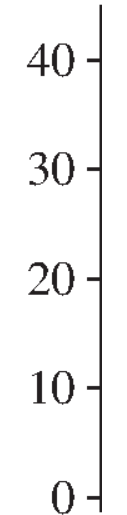

(515, 127, 3)
202
202
[{'boundingBox': [30, 39, 75, 40, 74, 80, 29, 79], 'text': '40'}, {'boundingBox': [30, 149, 80, 149, 79, 188, 30, 188], 'text': '30'}, {'boundingBox': [33, 261, 74, 263, 73, 296, 31, 294], 'text': '20'}, {'boundingBox': [32, 369, 74, 368, 75, 405, 33, 406], 'text': '10'}]
[{'boundingBox': [5, 39, 50, 40, 49, 80, 4, 79], 'text': '40'}, {'boundingBox': [5, 149, 55, 149, 54, 188, 5, 188], 'text': '30'}, {'boundingBox': [8, 261, 49, 263, 48, 296, 6, 294], 'text': '20'}, {'boundingBox': [7, 369, 49, 368, 50, 405, 8, 406], 'text': '10'}]
[{'boundingBox': [34, 108, 79, 109, 78, 149, 33, 148], 'text': '40'}, {'boundingBox': [34, 218, 84, 218, 83, 257, 34, 257], 'text': '30'}, {'boundingBox': [37, 330, 78, 332, 77, 365, 35, 363], 'text': '20'}, {'boundingBox': [36, 438, 78, 437, 79, 474, 37, 475], 'text': '10'}]


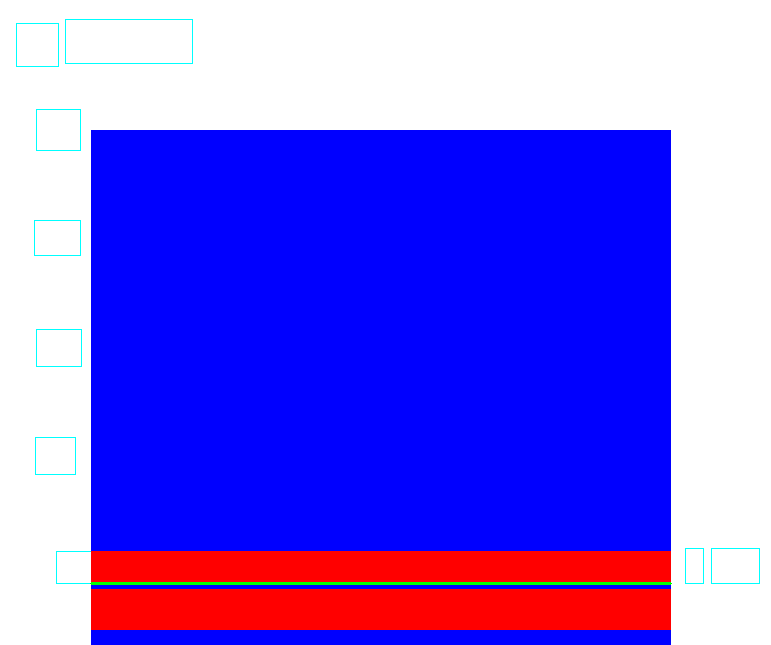

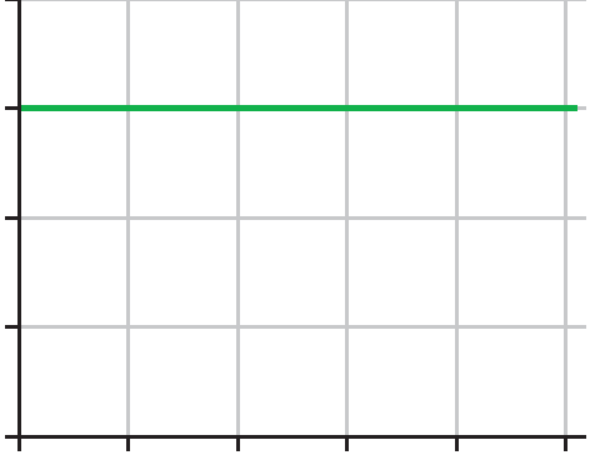

(458, 589, 3)


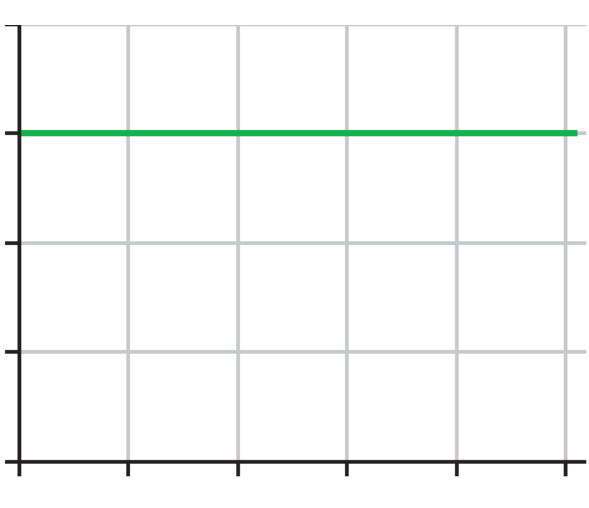

(508, 589, 3)
202
[]
[]
[]
[{'boundingBox': [34, 108, 79, 109, 78, 149, 33, 148], 'text': '40'}, {'boundingBox': [34, 218, 84, 218, 83, 257, 34, 257], 'text': '30'}, {'boundingBox': [37, 330, 78, 332, 77, 365, 35, 363], 'text': '20'}, {'boundingBox': [36, 438, 78, 437, 79, 474, 37, 475], 'text': '10'}]
[]


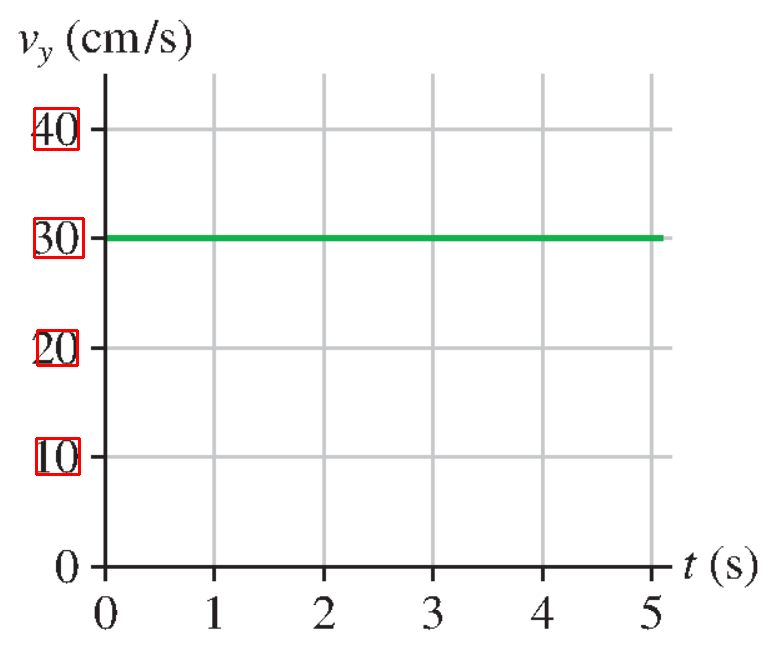

202
202
[[[35, 157], [373, 157]], [[99990, -109], [-10010, -109]]] [[[29, 50], [29, 268]], [[137, 163], [137, 176]]]


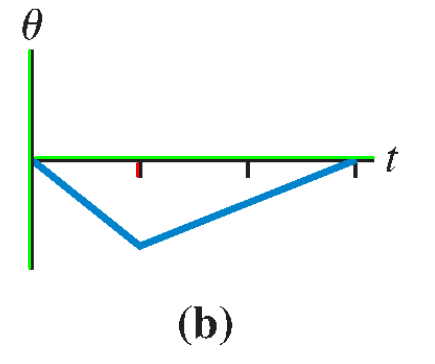

202
202


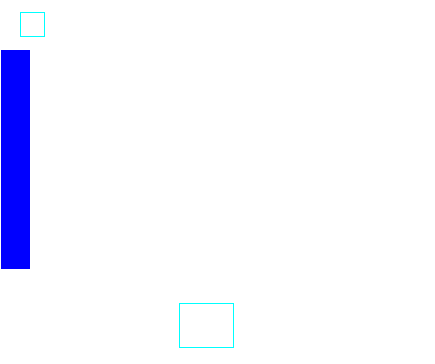

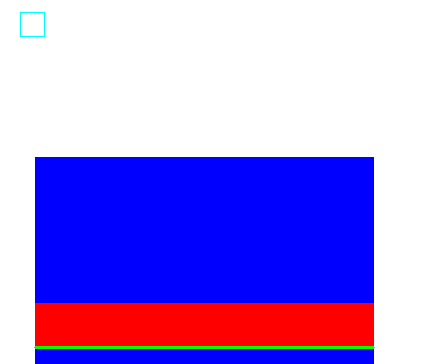

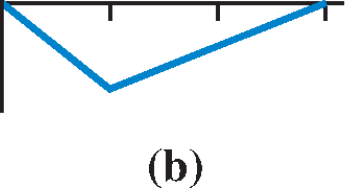

(195, 348, 3)


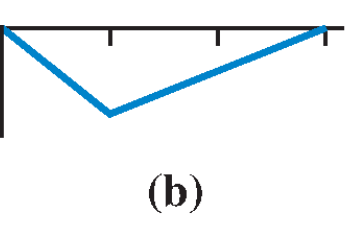

(245, 348, 3)
202
202
[{'boundingBox': [149, 176, 201, 174, 202, 209, 151, 211], 'text': '(b)'}]
[{'boundingBox': [149, 151, 201, 149, 202, 184, 151, 186], 'text': '(b)'}]
[{'boundingBox': [179, 308, 231, 306, 232, 341, 181, 343], 'text': '(b)'}]
[]
[{'boundingBox': [179, 308, 231, 306, 232, 341, 181, 343], 'text': '(b)'}]


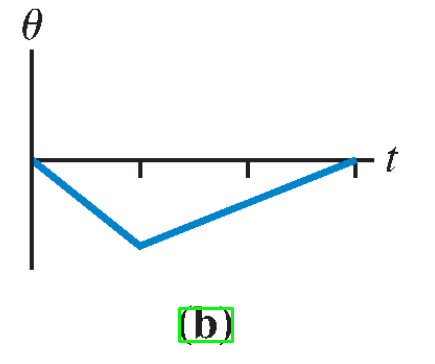

202
202
[[[48, 161], [381, 161]], [[99990, -109], [-10010, -109]]] [[[42, 54], [42, 271]], [[146, 166], [146, 180]]]


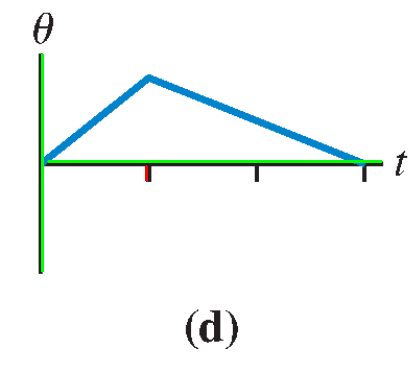

202
202


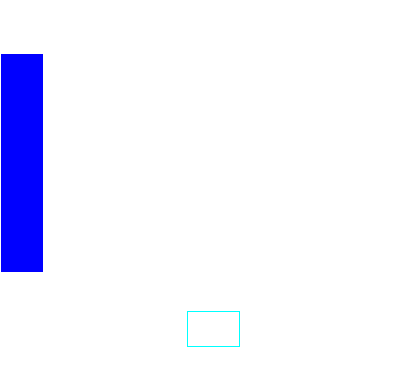

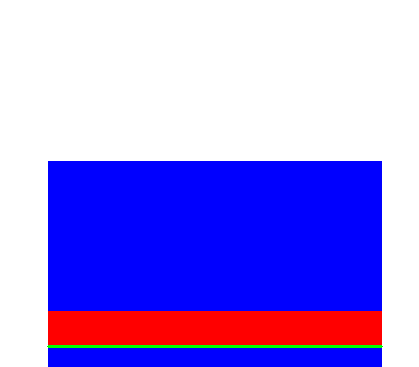

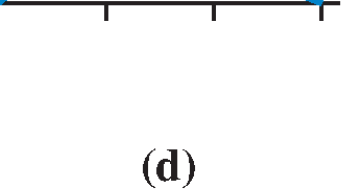

(190, 343, 3)


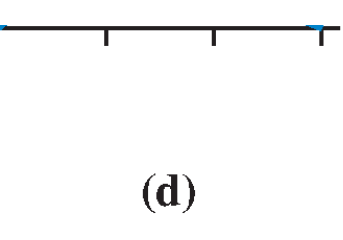

(240, 343, 3)
202
202
[{'boundingBox': [144, 171, 196, 171, 197, 214, 144, 215], 'text': '(d)'}]
[{'boundingBox': [144, 146, 196, 146, 197, 189, 144, 190], 'text': '(d)'}]
[{'boundingBox': [187, 307, 239, 307, 240, 350, 187, 351], 'text': '(d)'}]
[]
[{'boundingBox': [187, 307, 239, 307, 240, 350, 187, 351], 'text': '(d)'}]


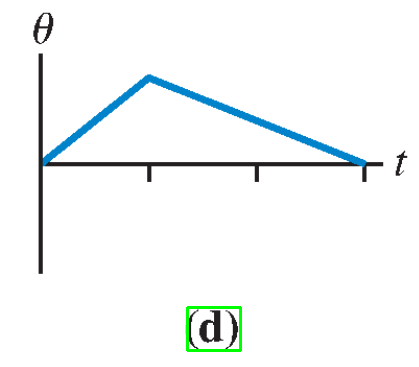

202
202
[[[0, 675], [778, 675]], [[99, 236], [679, 236]]] [[[220, 71], [220, 624]], [[111, 70], [111, 576]]]


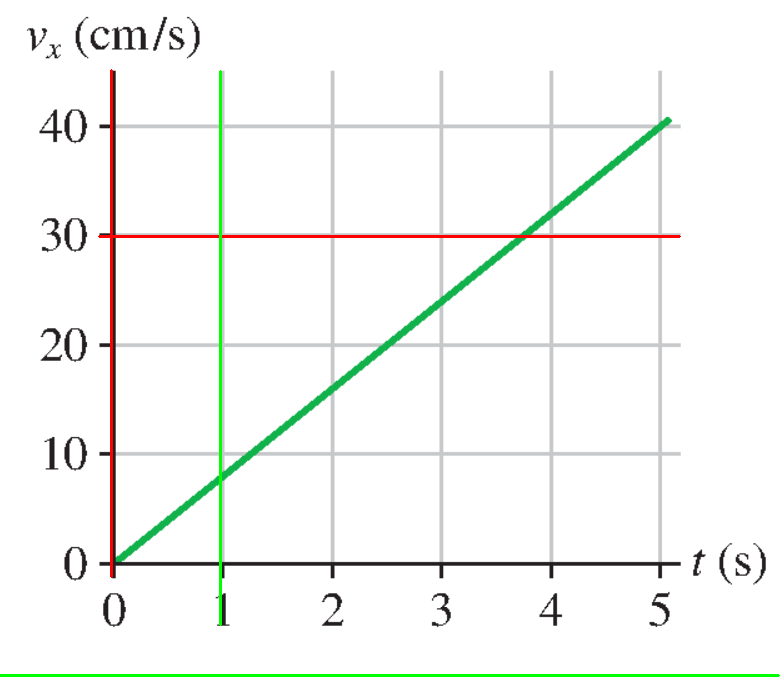

202
202
202
202


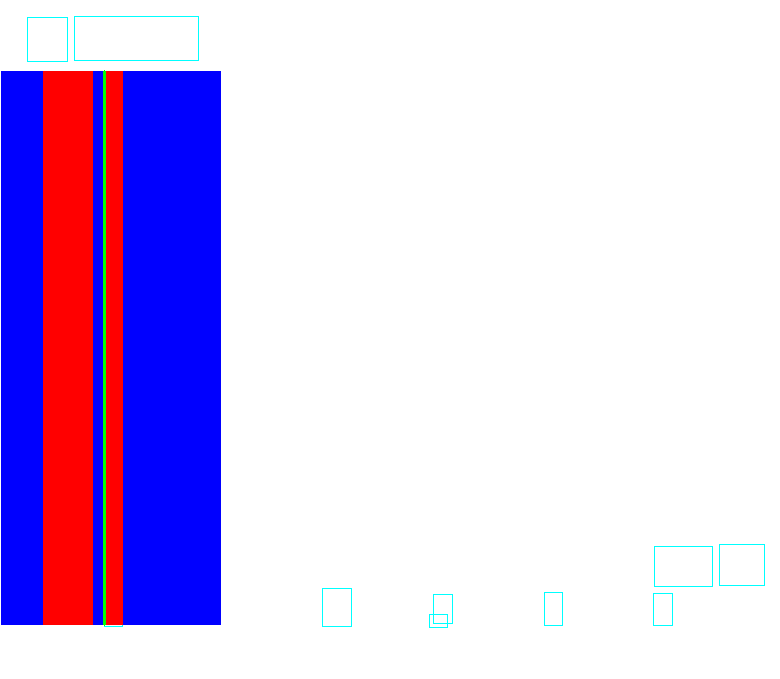

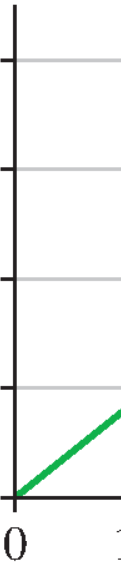

(563, 121, 3)


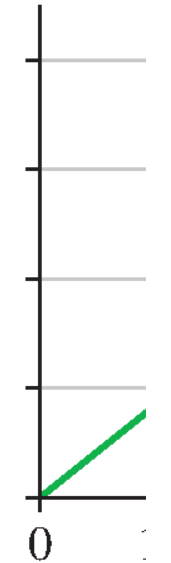

(563, 171, 3)
202
[]
[]
[]


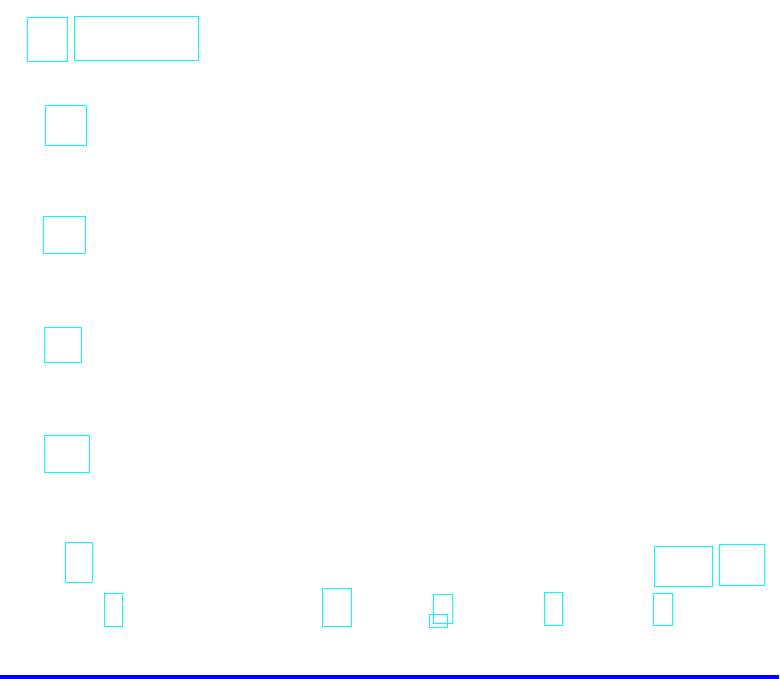

[]
[]


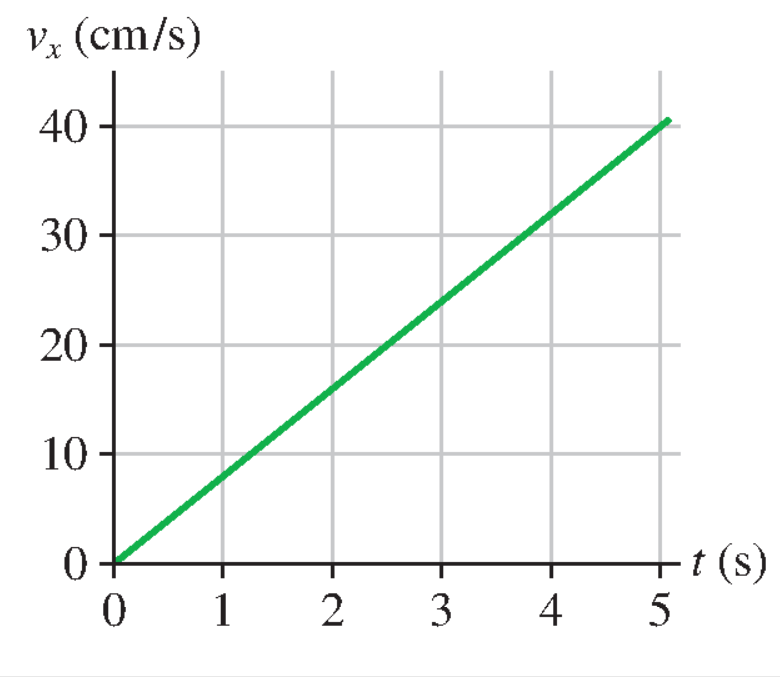

202
202
[[[51, 162], [384, 162]], [[99990, -109], [-10010, -109]]] [[[41, 54], [41, 273]], [[257, 166], [257, 181]]]


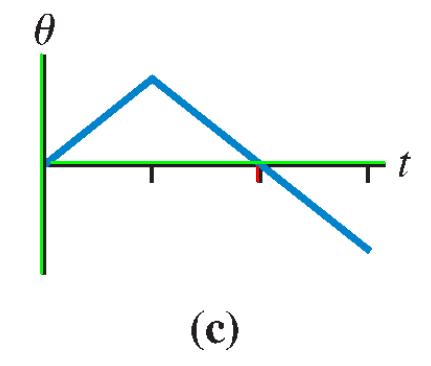

202
202


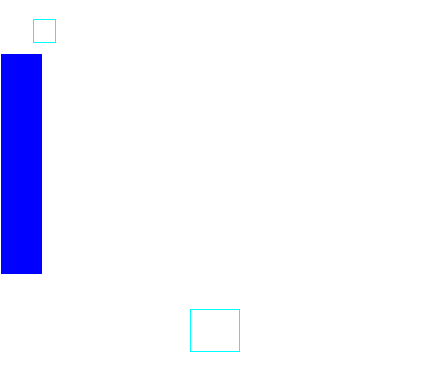

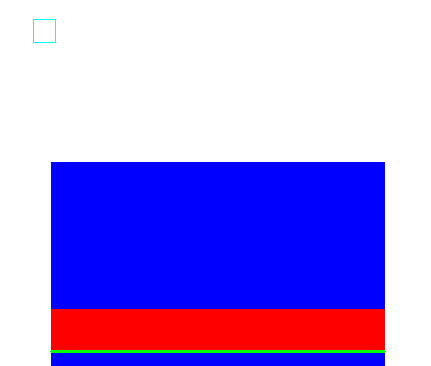

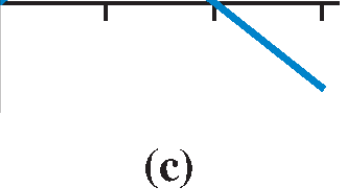

(194, 343, 3)


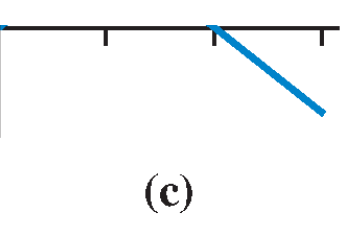

(244, 343, 3)
202
202
[{'boundingBox': [145, 172, 191, 172, 192, 215, 146, 215], 'text': '(c)'}]
[{'boundingBox': [145, 147, 191, 147, 192, 190, 146, 190], 'text': '(c)'}]
[{'boundingBox': [191, 309, 237, 309, 238, 352, 192, 352], 'text': '(c)'}]
[]
[{'boundingBox': [191, 309, 237, 309, 238, 352, 192, 352], 'text': '(c)'}]


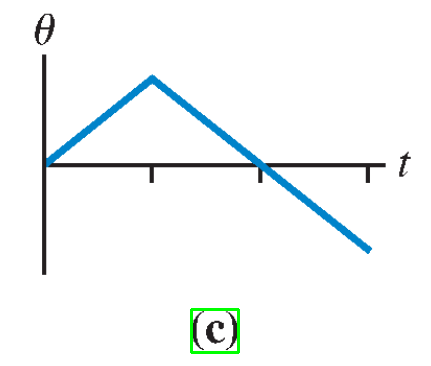

202
202
[[[36, 124], [216, 124]], [[99990, -109], [-10010, -109]]] [[[32, 55], [32, 196]], [[-109, 99990], [-109, -10010]]]


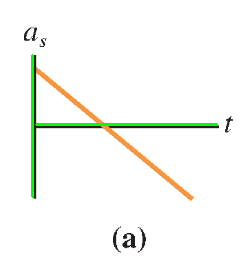

202
202


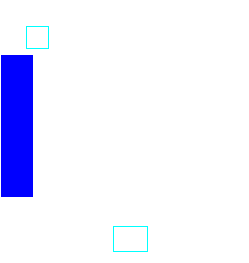

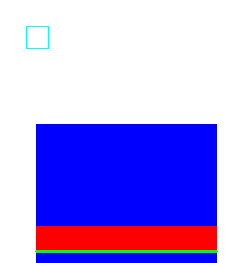

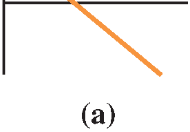

(132, 190, 3)


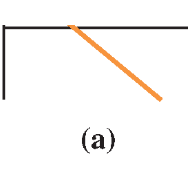

(182, 190, 3)
202
202
[{'boundingBox': [81, 128, 116, 127, 117, 152, 82, 153], 'text': '(a)'}]
[{'boundingBox': [81, 103, 116, 102, 117, 127, 82, 128], 'text': '(a)'}]
[{'boundingBox': [112, 227, 147, 226, 148, 251, 113, 252], 'text': '(a)'}]
[]
[{'boundingBox': [112, 227, 147, 226, 148, 251, 113, 252], 'text': '(a)'}]


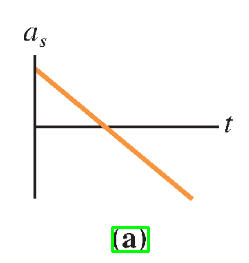

202
202
202
[[[355, 670], [2126, 670]], [[708, 1249], [991, 1249]]] [[[398, 163], [398, 1181]], [[649, 1218], [649, 1283]]]


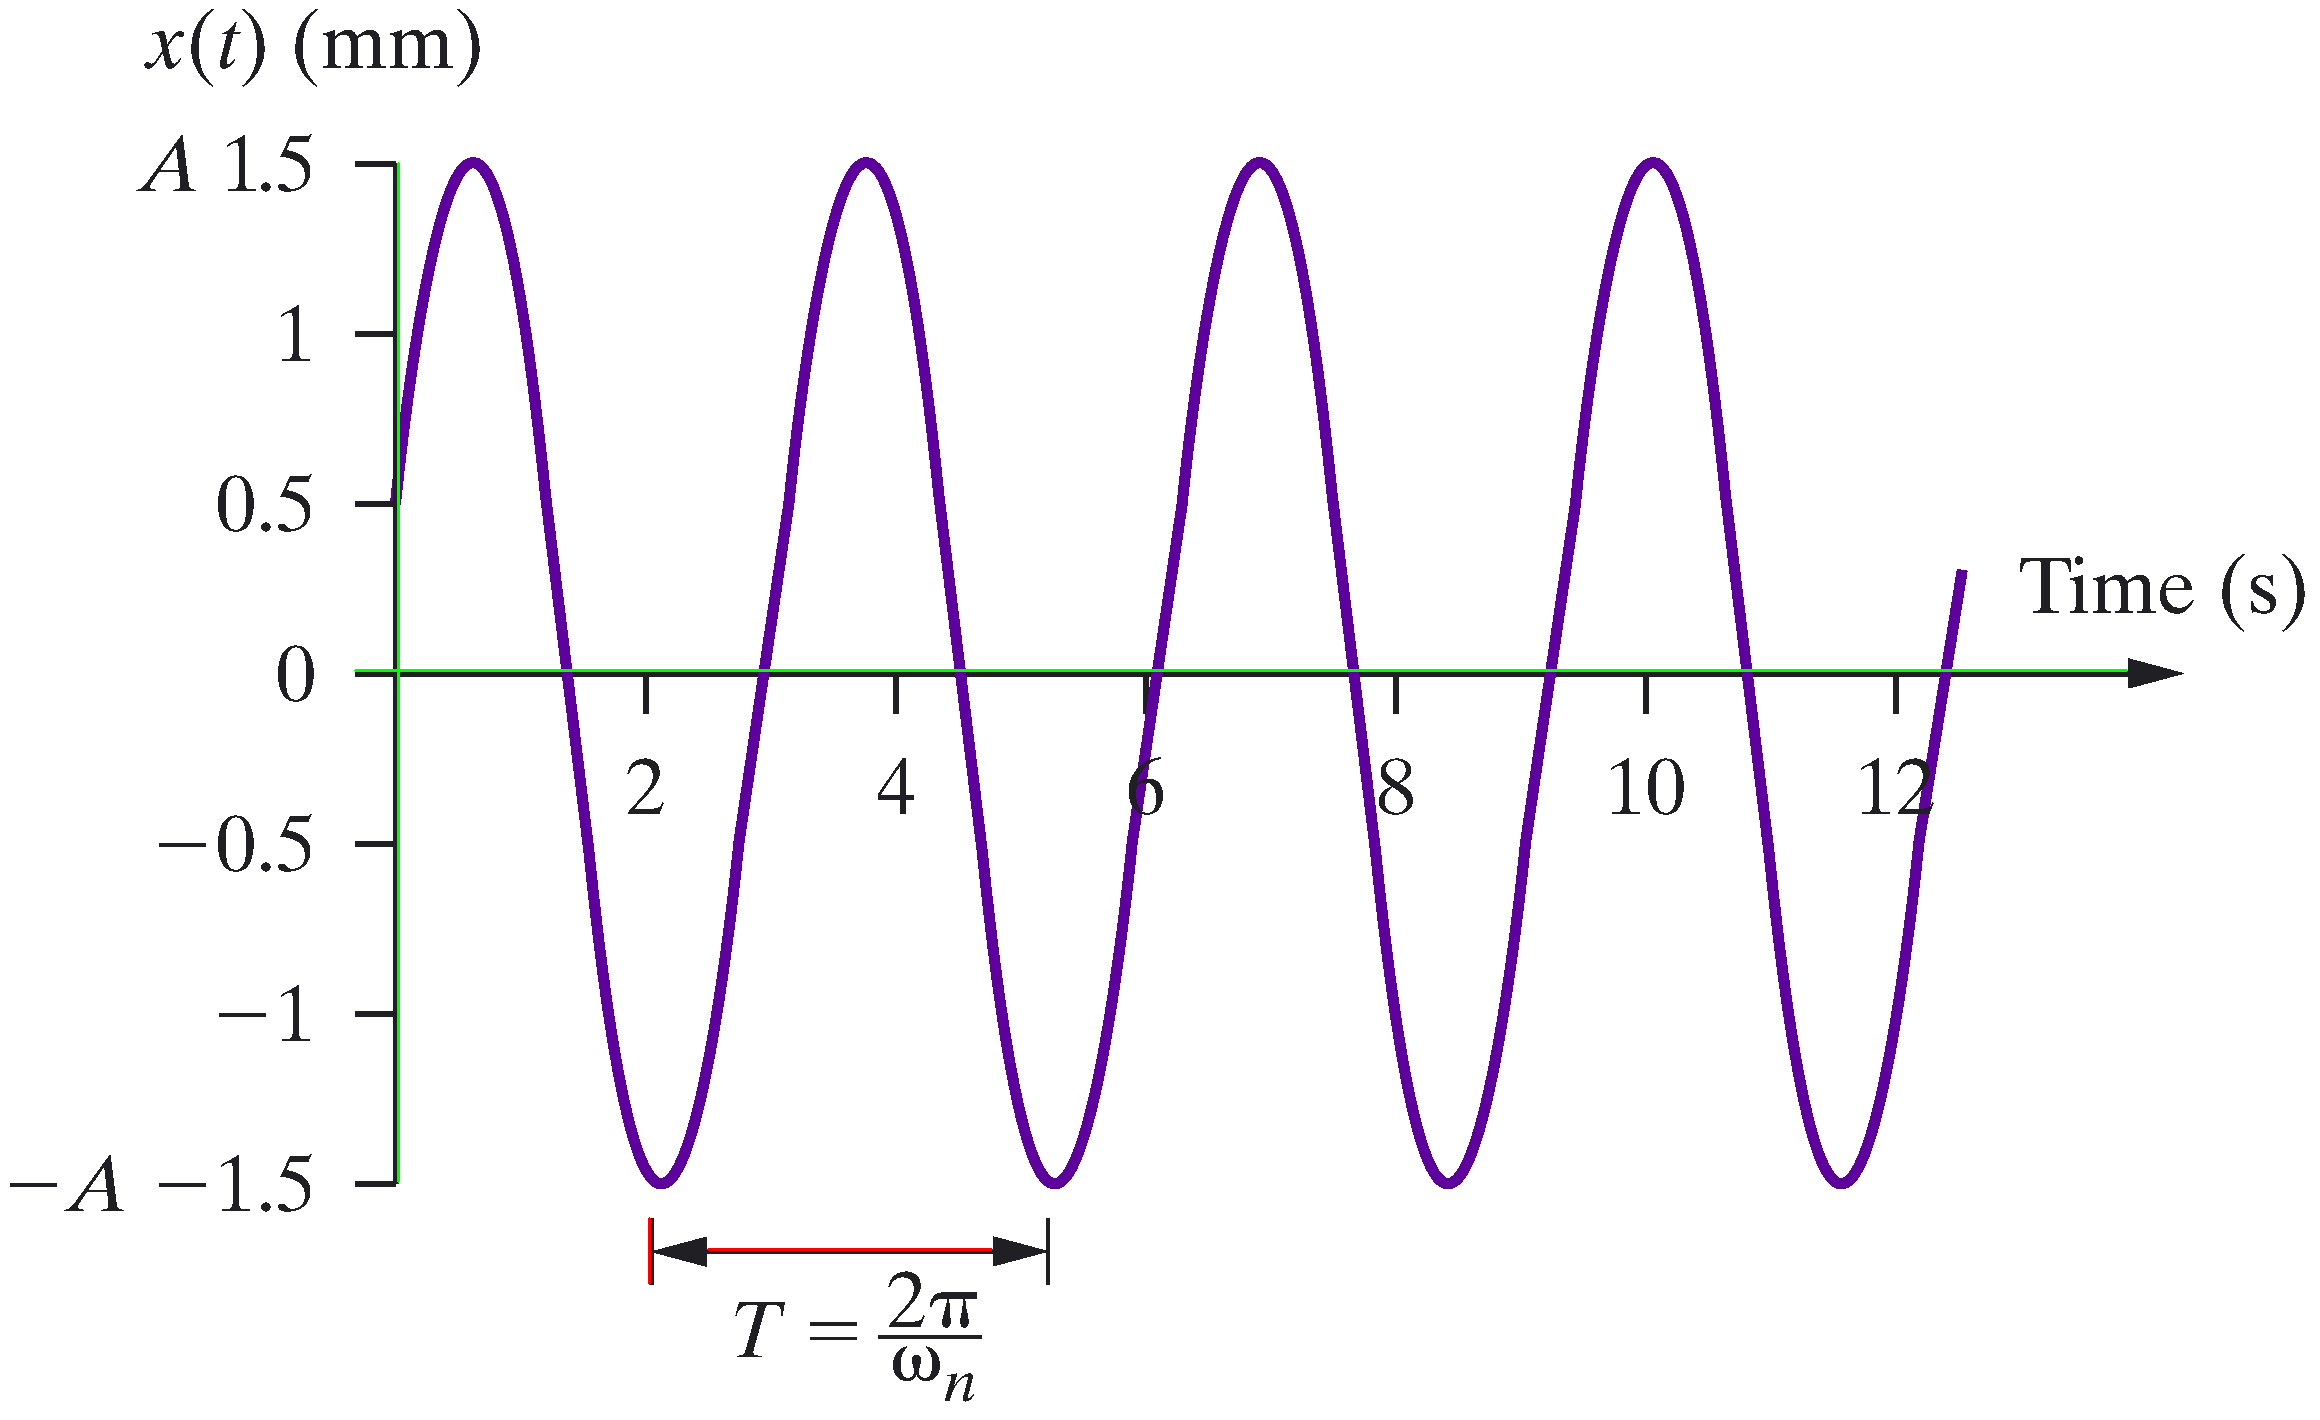

202
202
202
202


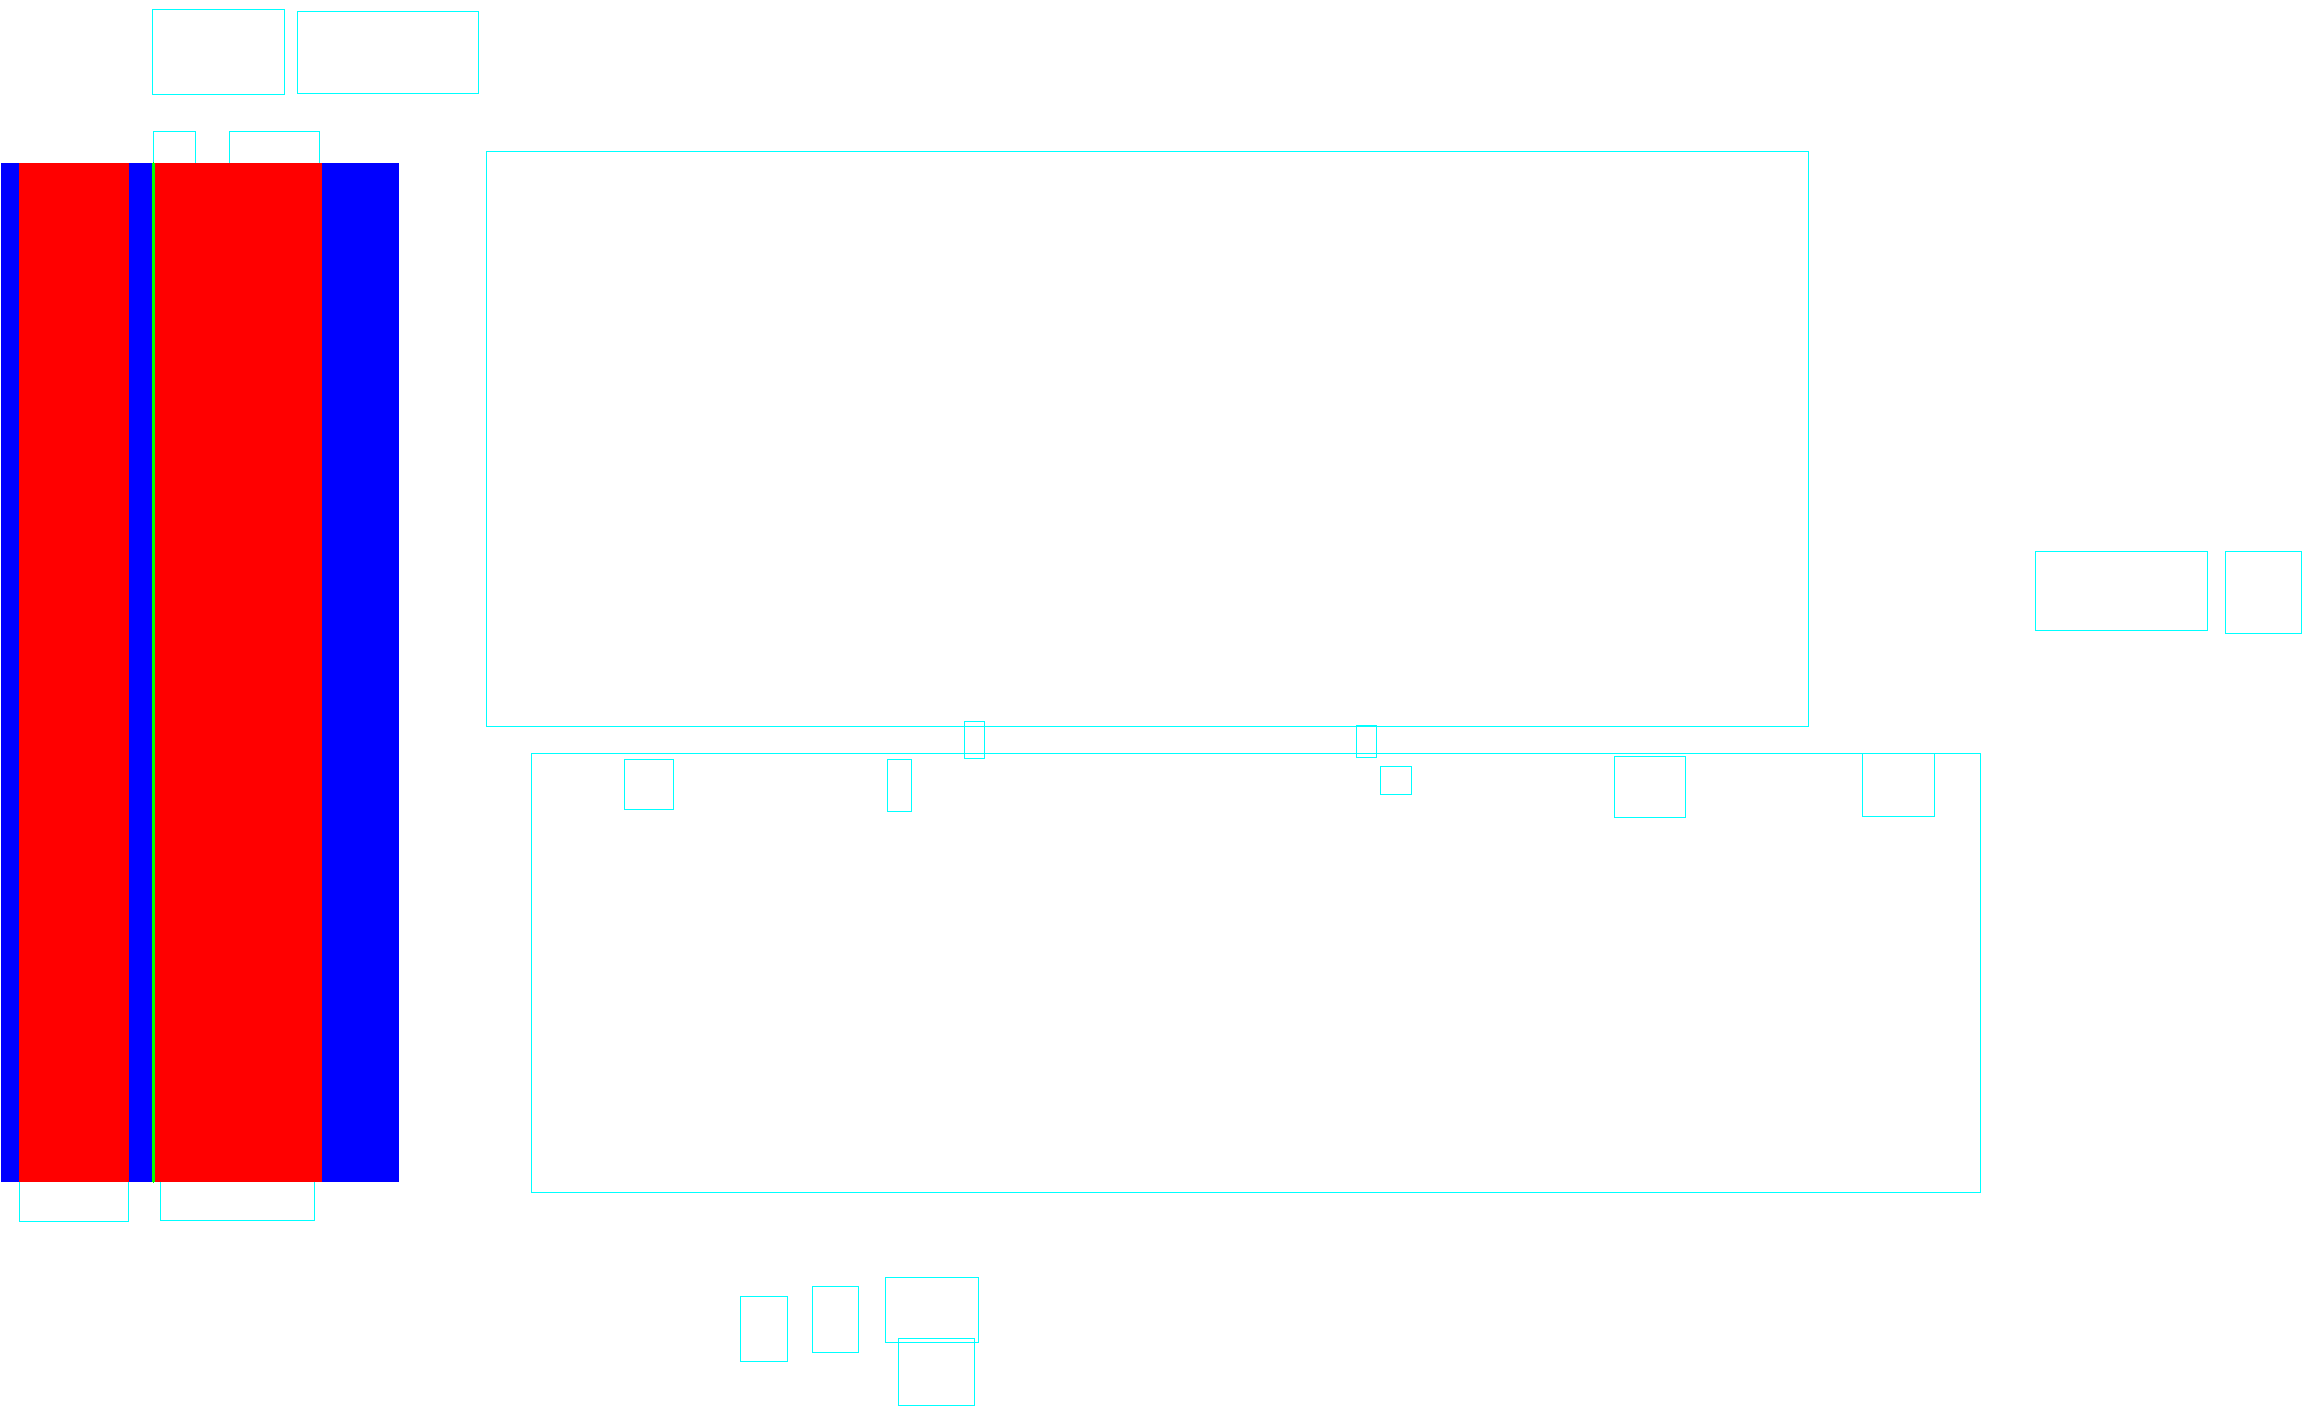

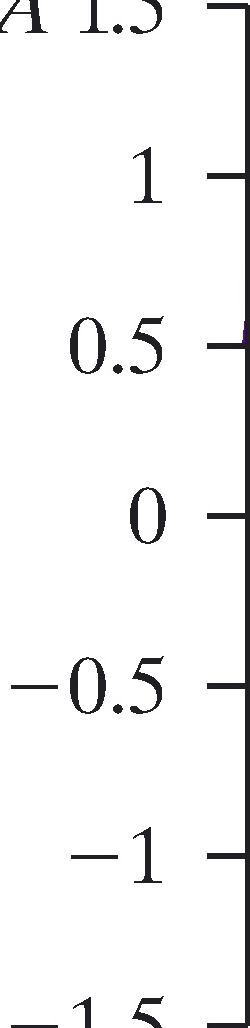

(1028, 250, 3)


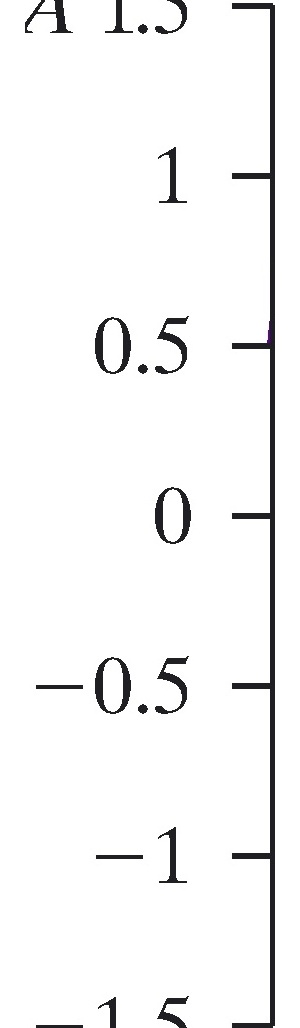

(1028, 300, 3)
202
202
[{'boundingBox': [26, 0, 52, 1, 51, 36, 25, 37], 'text': 'A'}, {'boundingBox': [112, 2, 183, 1, 183, 39, 111, 37], 'text': 'L.J', 'confidence': 'Low'}, {'boundingBox': [96, 314, 190, 314, 190, 375, 96, 375], 'text': '0.5'}, {'boundingBox': [158, 476, 205, 479, 201, 549, 154, 546], 'text': '0'}, {'boundingBox': [95, 658, 191, 658, 191, 713, 95, 713], 'text': '0.5'}]
[{'boundingBox': [1, 0, 27, 1, 26, 36, 0, 37], 'text': 'A'}, {'boundingBox': [87, 2, 158, 1, 158, 39, 86, 37], 'text': 'L.J', 'confidence': 'Low'}, {'boundingBox': [71, 314, 165, 314, 165, 375, 71, 375], 'text': '0.5'}, {'boundingBox': [133, 476, 180, 479, 176, 549, 129, 546], 'text': '0'}, {'boundingBox': [70, 658, 166, 658, 166, 713, 70, 713], 'text': '0.5'}]
[{'boundingBox': [149, 158, 175, 159, 174, 194, 148, 195], 'text': 'A'}, {'boundingBox': [235, 160, 306, 159, 306, 197, 234, 195], 'text': 'L.J', 'confidence': 'Low'}, {'boundingBox': [219, 472, 313, 472, 313, 533, 219, 533], 'text': '0.5'}, {'b

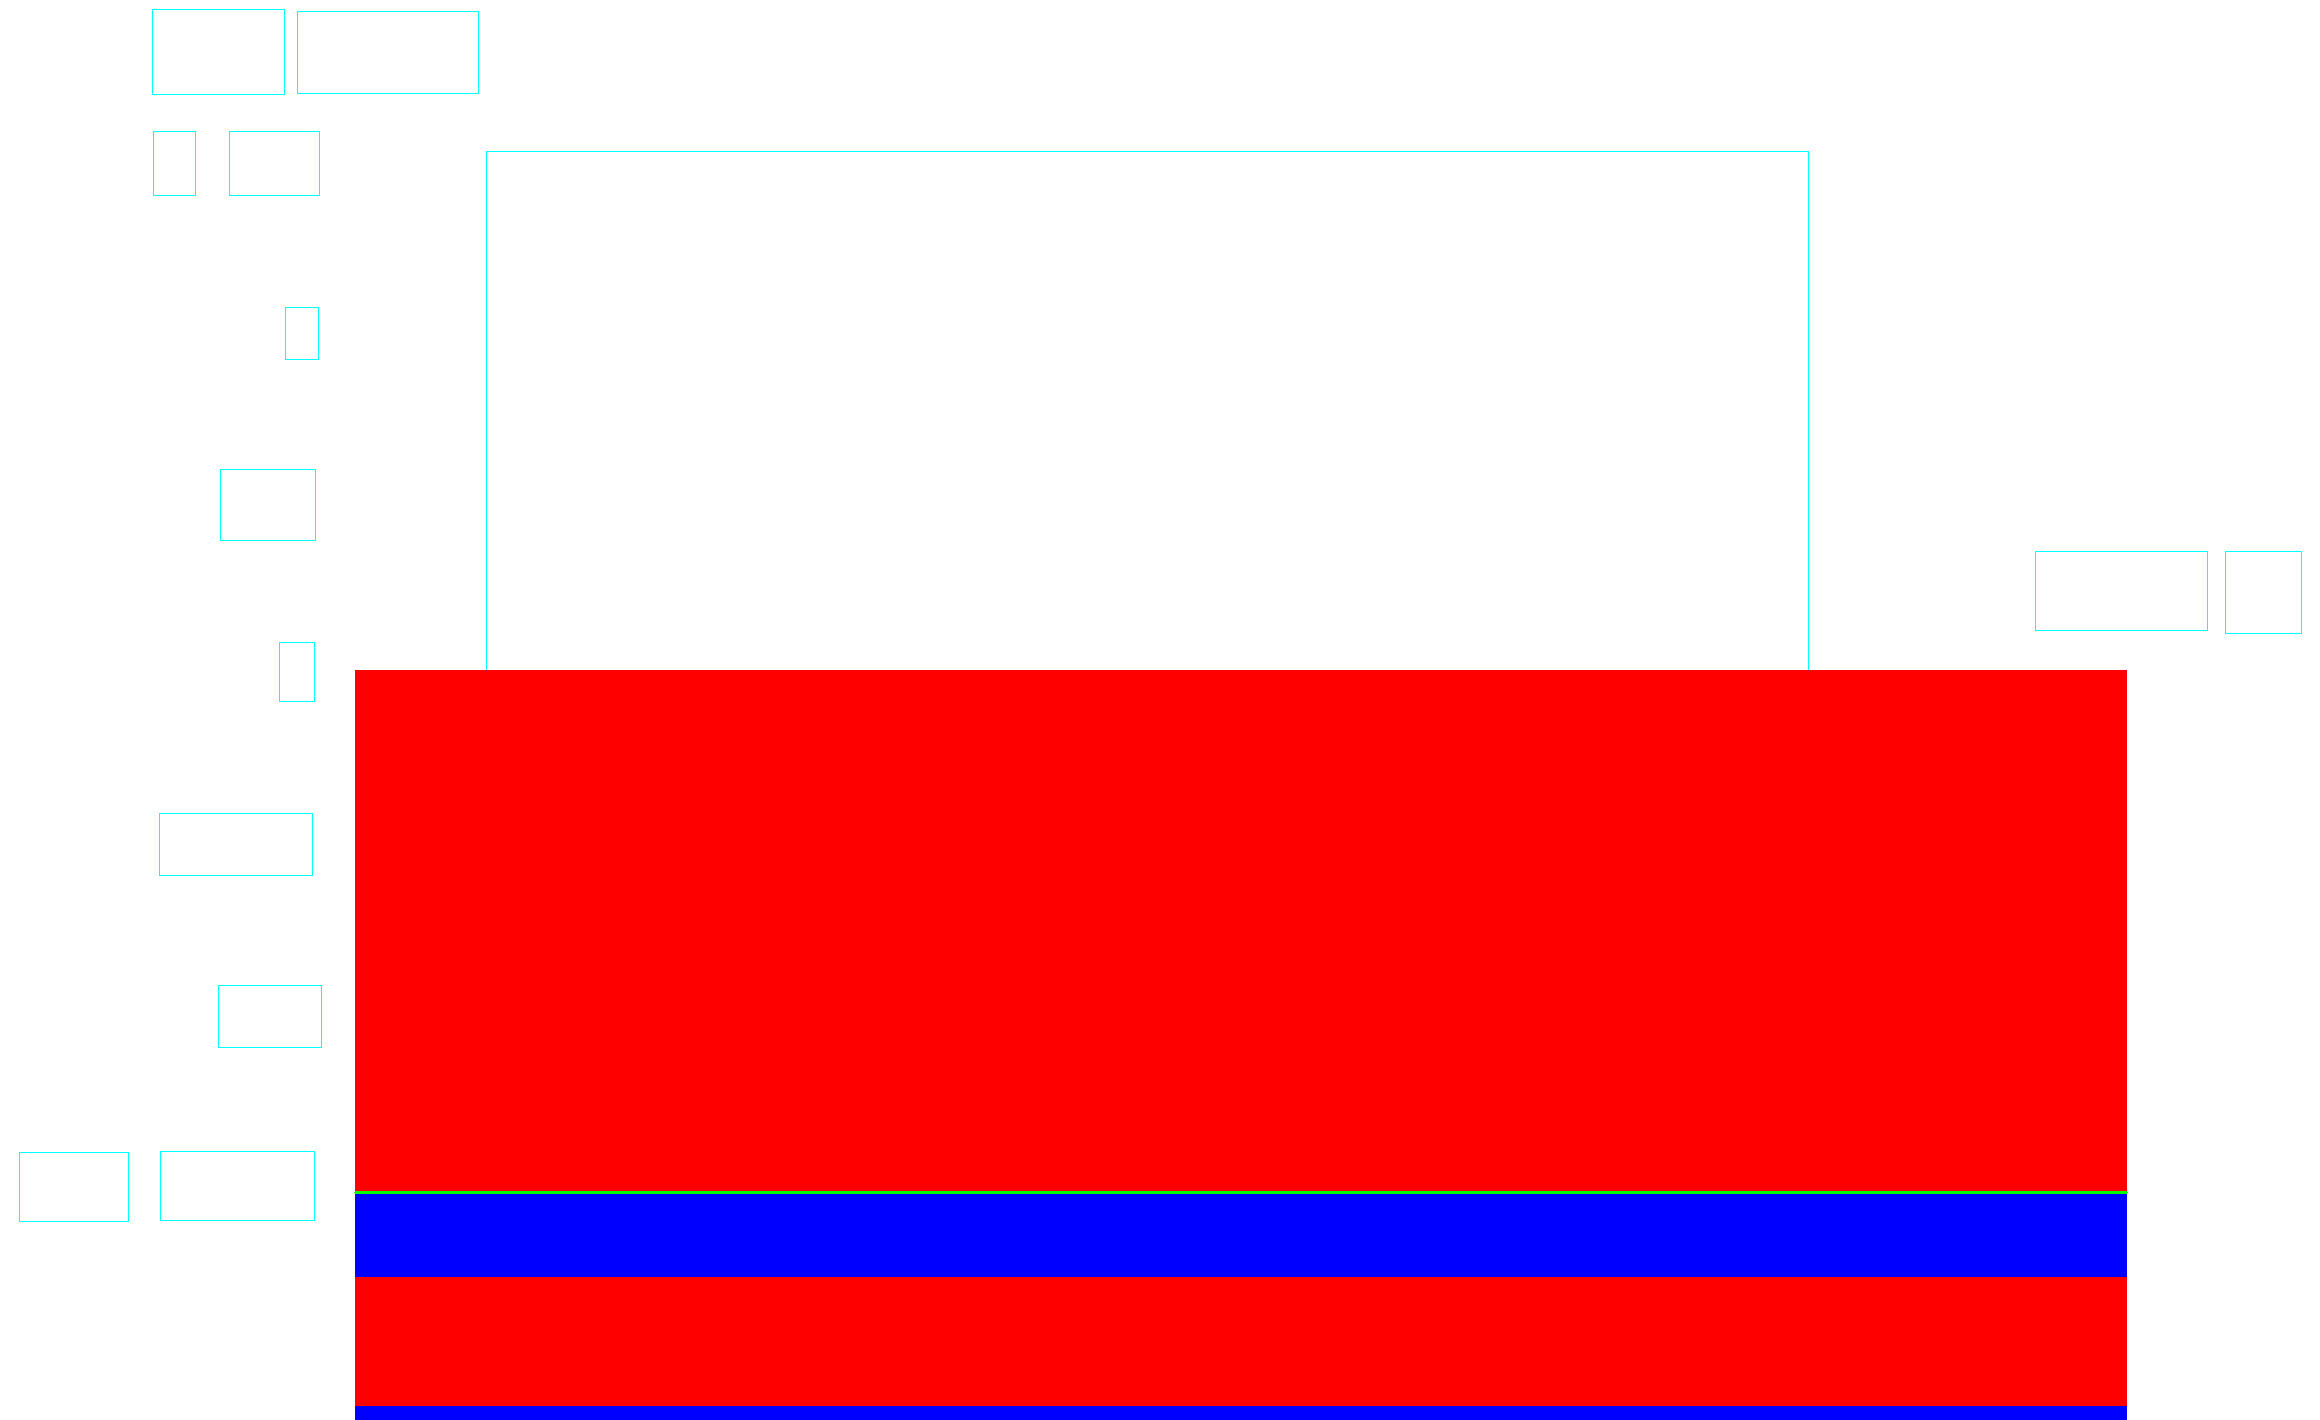

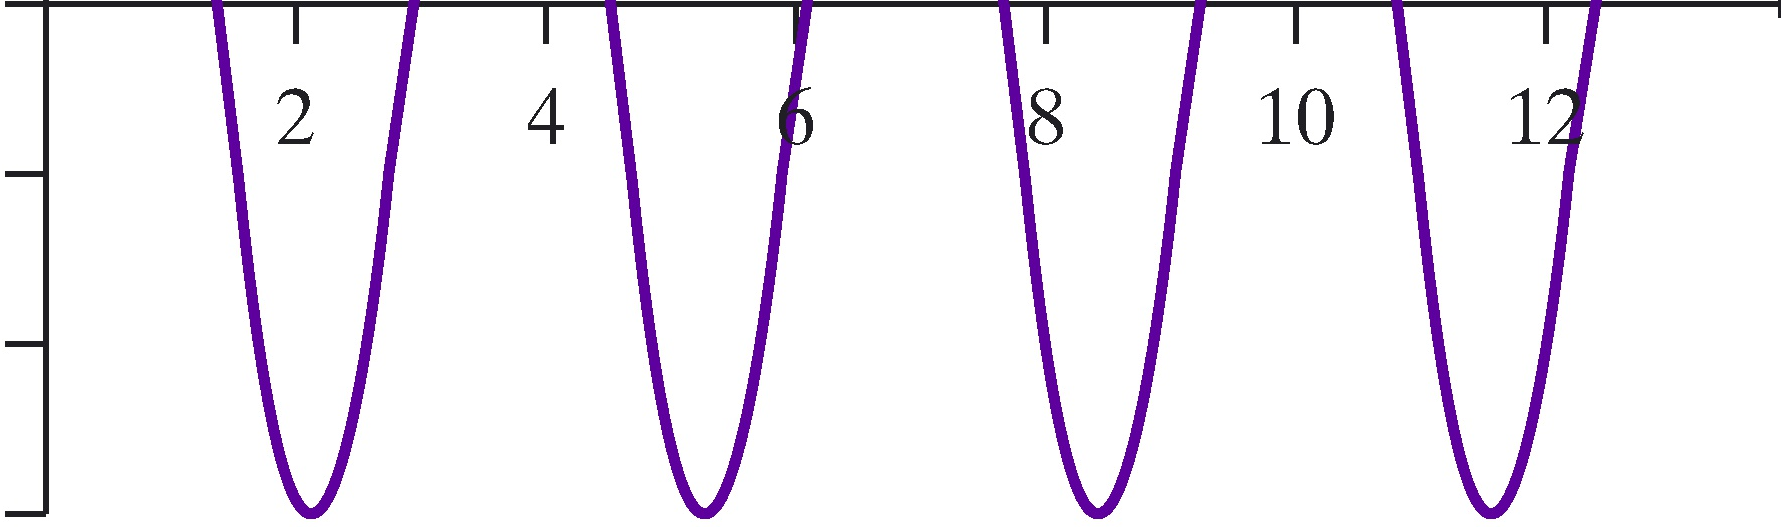

(527, 1781, 3)


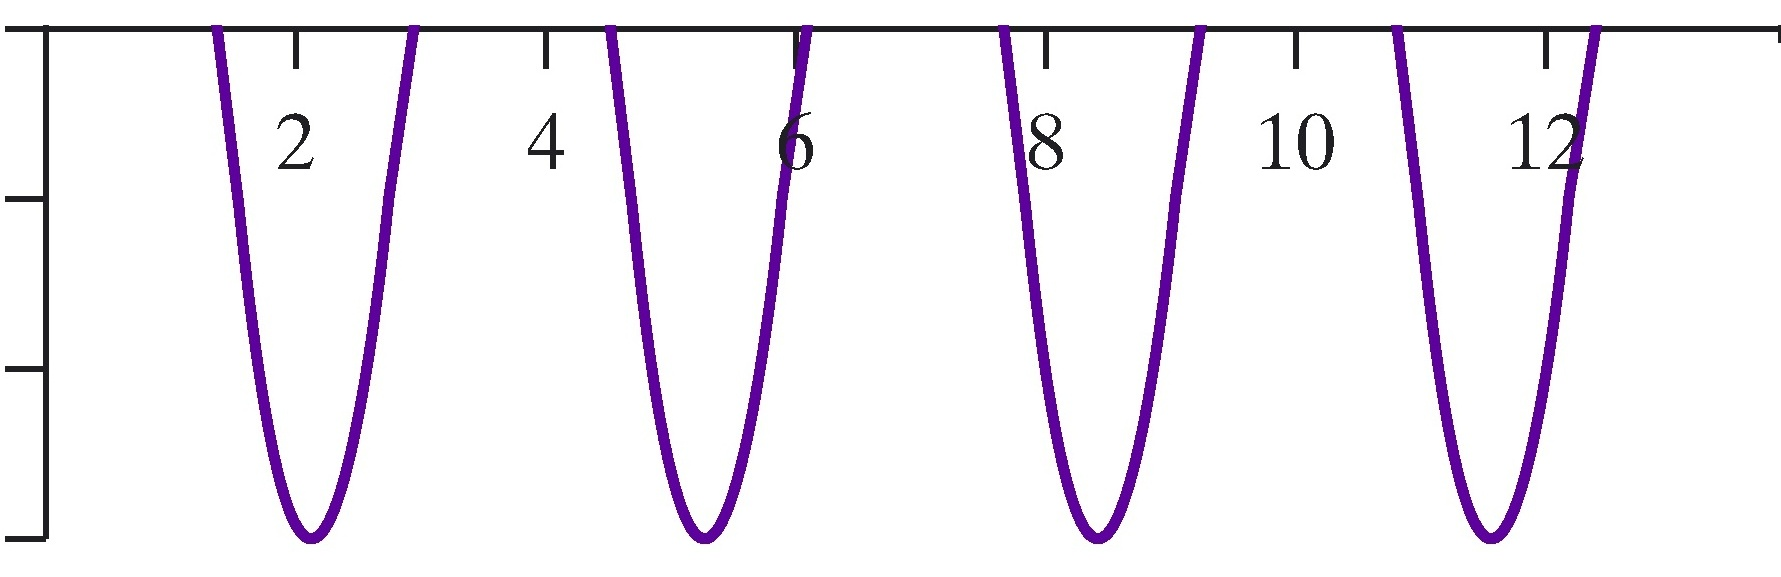

(577, 1781, 3)
202
202
[{'boundingBox': [279, 108, 311, 105, 317, 165, 285, 168], 'text': '2'}, {'boundingBox': [536, 108, 570, 110, 567, 167, 533, 165], 'text': '4'}, {'boundingBox': [1259, 110, 1331, 107, 1334, 170, 1262, 174], 'text': '10'}, {'boundingBox': [1513, 108, 1570, 105, 1573, 171, 1516, 174], 'text': '12'}]
[{'boundingBox': [279, 83, 311, 80, 317, 140, 285, 143], 'text': '2'}, {'boundingBox': [536, 83, 570, 85, 567, 142, 533, 140], 'text': '4'}, {'boundingBox': [1259, 85, 1331, 82, 1334, 145, 1262, 149], 'text': '10'}, {'boundingBox': [1513, 83, 1570, 80, 1573, 146, 1516, 149], 'text': '12'}]
[{'boundingBox': [629, 753, 661, 750, 667, 810, 635, 813], 'text': '2'}, {'boundingBox': [886, 753, 920, 755, 917, 812, 883, 810], 'text': '4'}, {'boundingBox': [1609, 755, 1681, 752, 1684, 815, 1612, 819], 'text': '10'}, {'boundingBox': [1863, 753, 1920, 750, 1923, 816, 1866, 819], 'text': '12'}]
[{'boundingBox': [149, 158, 175, 159, 174, 194, 148, 195], 'text': 'A'}, {'boundingBox':

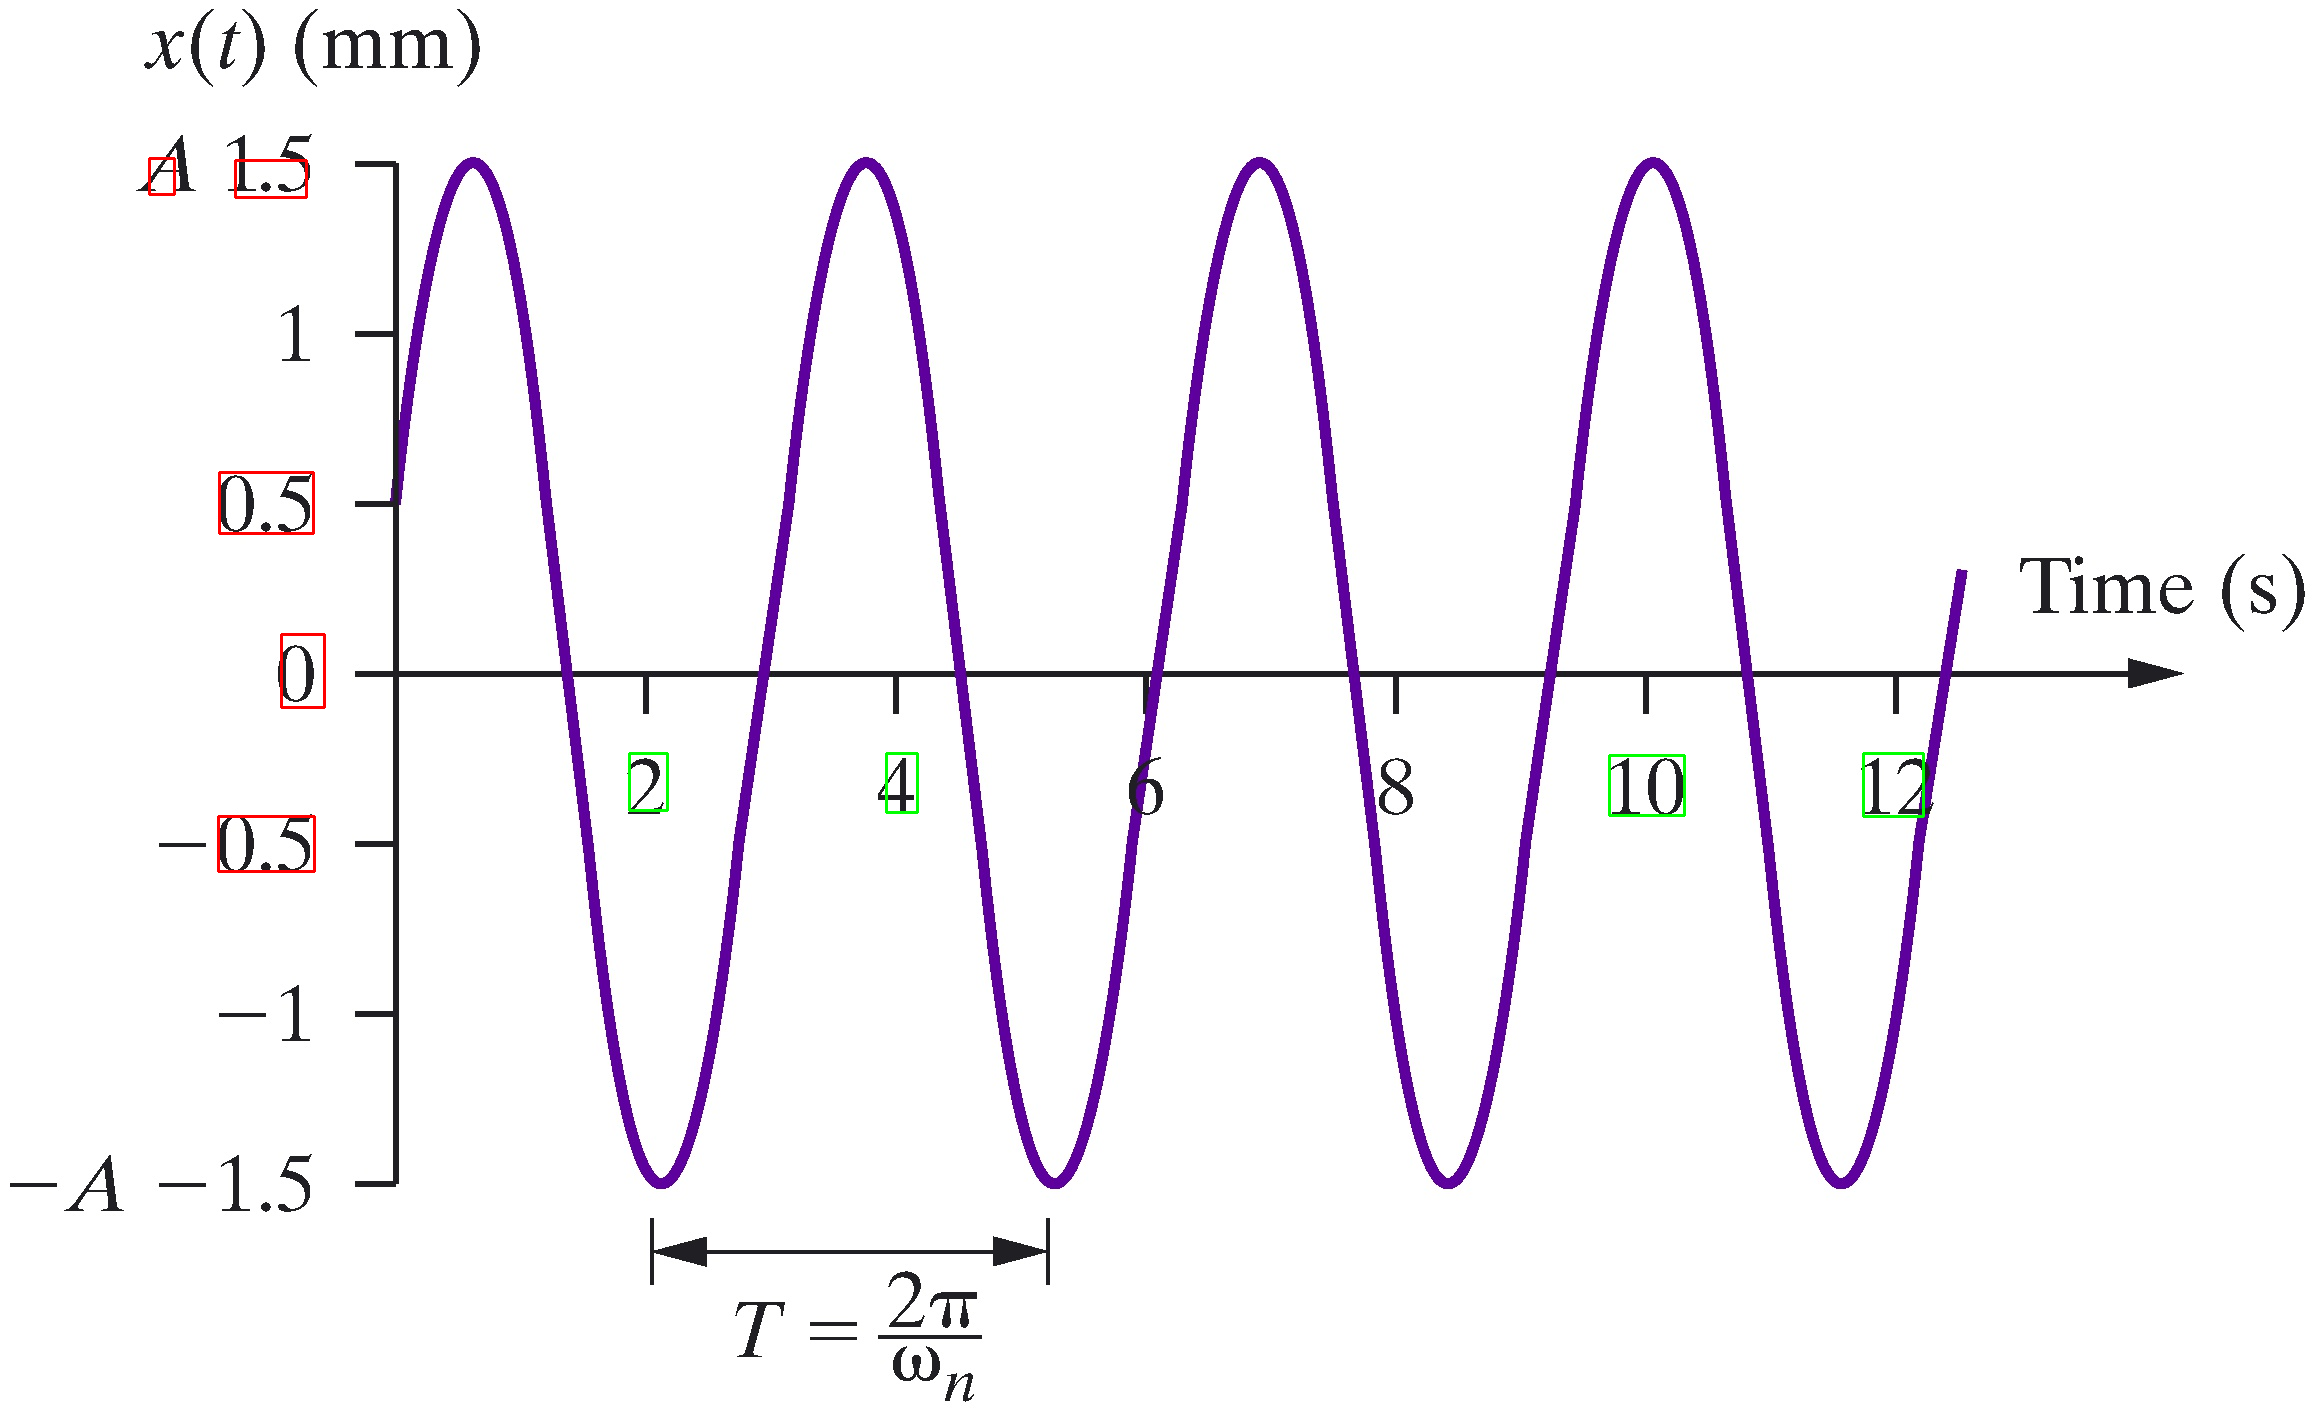

202
202
202
[[[11, 271], [493, 271]], [[23, 589], [391, 589]]] [[[245, 23], [245, 504]], [[464, 575], [464, 603]]]


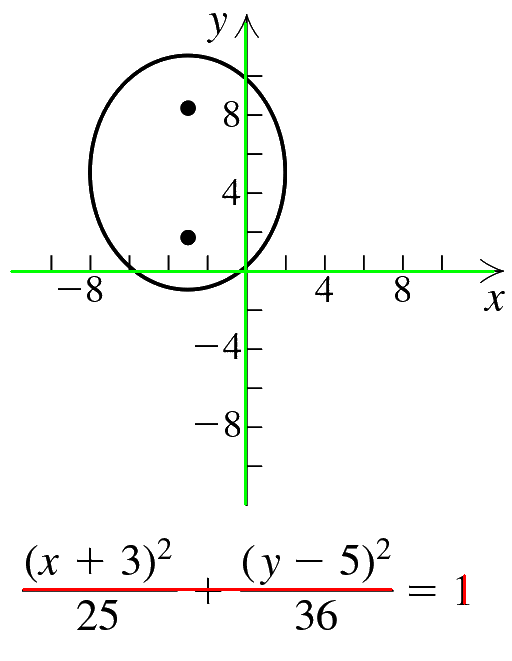

202
202
202


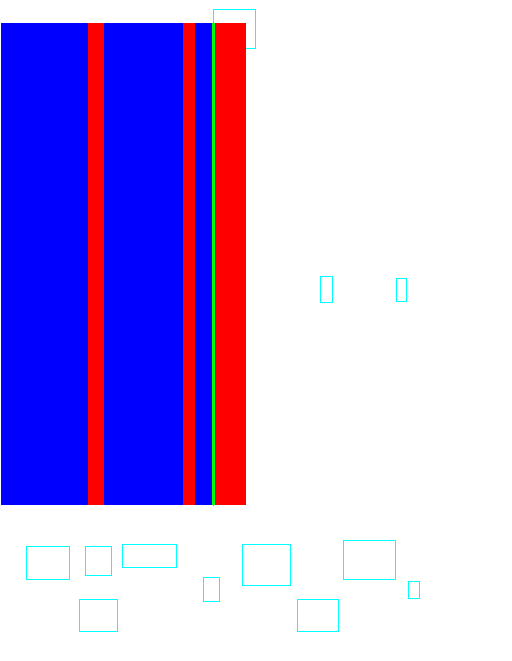

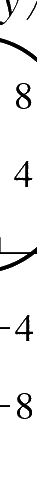

(491, 37, 3)


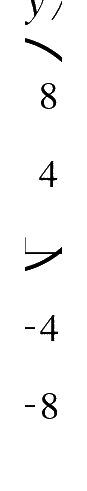

(491, 87, 3)
202
202
202
[{'boundingBox': [43, 160, 59, 160, 58, 187, 42, 187], 'text': '4'}, {'boundingBox': [26, 308, 63, 309, 62, 343, 25, 342], 'text': '-4'}, {'boundingBox': [27, 388, 37, 388, 36, 418, 26, 418], 'text': '-'}, {'boundingBox': [43, 388, 61, 389, 60, 419, 42, 418], 'text': '8'}, {'boundingBox': [42, 77, 63, 76, 63, 110, 43, 111], 'text': '8'}]
[{'boundingBox': [18, 160, 34, 160, 33, 187, 17, 187], 'text': '4'}, {'boundingBox': [1, 308, 38, 309, 37, 343, 0, 342], 'text': '-4'}, {'boundingBox': [2, 388, 12, 388, 11, 418, 1, 418], 'text': '-'}, {'boundingBox': [18, 388, 36, 389, 35, 419, 17, 418], 'text': '8'}, {'boundingBox': [17, 77, 38, 76, 38, 110, 18, 111], 'text': '8'}]
[{'boundingBox': [226, 178, 242, 178, 241, 205, 225, 205], 'text': '4'}, {'boundingBox': [209, 326, 246, 327, 245, 361, 208, 360], 'text': '-4'}, {'boundingBox': [210, 406, 220, 406, 219, 436, 209, 436], 'text': '-'}, {'boundingBox': [226, 406, 244, 407, 243, 437, 225, 436], 'text': '8'}, {'boundin

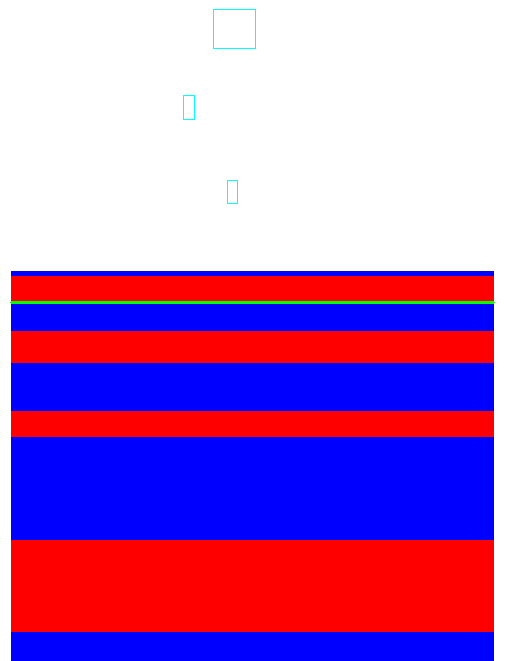

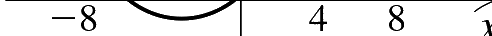

(36, 492, 3)


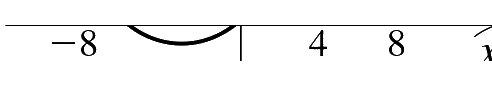

(86, 492, 3)
202
202
[{'boundingBox': [312, 31, 327, 31, 327, 53, 312, 53], 'text': '4'}, {'boundingBox': [388, 29, 404, 28, 405, 57, 390, 58], 'text': '8'}]
[{'boundingBox': [312, 6, 327, 6, 327, 28, 312, 28], 'text': '4'}, {'boundingBox': [388, 4, 404, 3, 405, 32, 390, 33], 'text': '8'}]
[{'boundingBox': [318, 277, 333, 277, 333, 299, 318, 299], 'text': '4'}, {'boundingBox': [394, 275, 410, 274, 411, 303, 396, 304], 'text': '8'}]
[{'boundingBox': [226, 178, 242, 178, 241, 205, 225, 205], 'text': '4'}, {'boundingBox': [209, 326, 246, 327, 245, 361, 208, 360], 'text': '-4'}, {'boundingBox': [210, 406, 220, 406, 219, 436, 209, 436], 'text': '-'}, {'boundingBox': [226, 406, 244, 407, 243, 437, 225, 436], 'text': '8'}, {'boundingBox': [225, 95, 246, 94, 246, 128, 226, 129], 'text': '8'}]
[{'boundingBox': [318, 277, 333, 277, 333, 299, 318, 299], 'text': '4'}, {'boundingBox': [394, 275, 410, 274, 411, 303, 396, 304], 'text': '8'}]


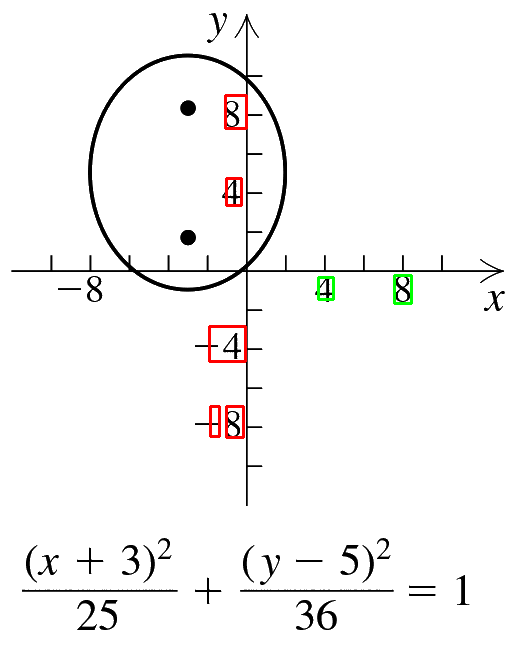

202
202
202
[[[49, 269], [530, 269]], [[326, 572], [351, 572]]] [[[282, 23], [282, 504]], [[126, 255], [126, 268]]]


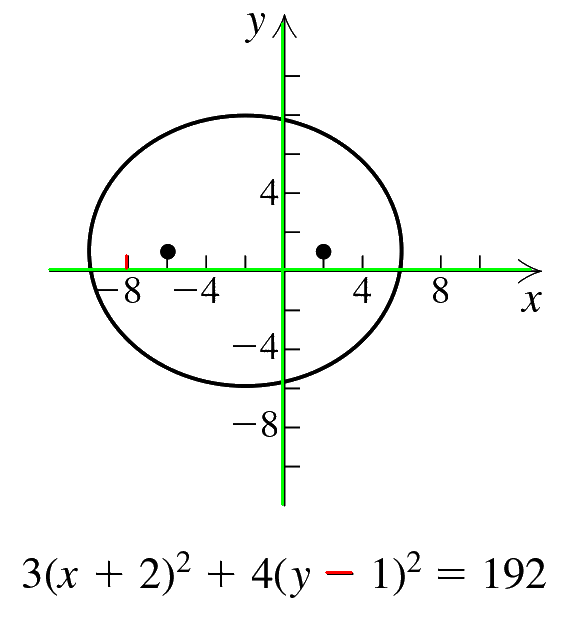

202
202
202


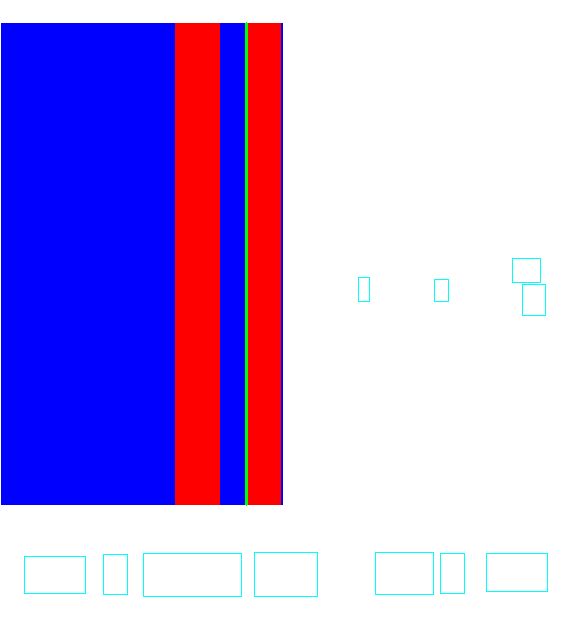

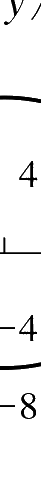

(491, 41, 3)


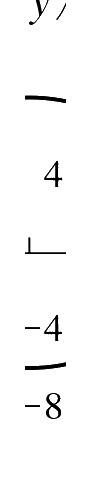

(491, 91, 3)
202
202
202
[{'boundingBox': [35, 1, 50, 1, 50, 24, 35, 24], 'text': 'y'}, {'boundingBox': [58, 1, 67, 1, 67, 24, 58, 24], 'text': '/', 'confidence': 'Low'}, {'boundingBox': [48, 160, 65, 162, 62, 187, 46, 185], 'text': '4'}, {'boundingBox': [26, 231, 48, 231, 47, 264, 25, 264], 'text': 'L'}, {'boundingBox': [26, 309, 65, 311, 63, 347, 25, 345], 'text': '-4'}, {'boundingBox': [28, 388, 63, 387, 63, 420, 28, 421], 'text': '-8', 'confidence': 'Low'}, {'boundingBox': [49, 244, 59, 244, 59, 260, 48, 260], 'text': '-'}]
[{'boundingBox': [10, 1, 25, 1, 25, 24, 10, 24], 'text': 'y'}, {'boundingBox': [33, 1, 42, 1, 42, 24, 33, 24], 'text': '/', 'confidence': 'Low'}, {'boundingBox': [23, 160, 40, 162, 37, 187, 21, 185], 'text': '4'}, {'boundingBox': [1, 231, 23, 231, 22, 264, 0, 264], 'text': 'L'}, {'boundingBox': [1, 309, 40, 311, 38, 347, 0, 345], 'text': '-4'}, {'boundingBox': [3, 388, 38, 387, 38, 420, 3, 421], 'text': '-8', 'confidence': 'Low'}, {'boundingBox': [24, 244, 34, 2

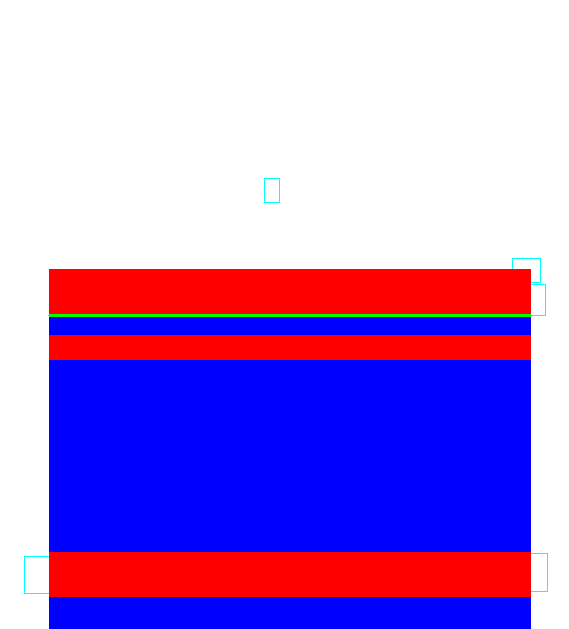

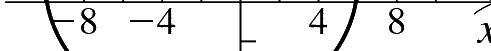

(51, 491, 3)


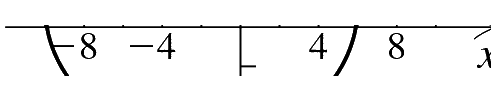

(101, 491, 3)
202
202
[{'boundingBox': [83, 34, 96, 33, 98, 58, 84, 59], 'text': '8'}, {'boundingBox': [132, 32, 179, 32, 179, 60, 132, 60], 'text': '-4'}, {'boundingBox': [314, 34, 326, 34, 326, 57, 314, 57], 'text': '4'}, {'boundingBox': [389, 34, 403, 33, 405, 59, 391, 60], 'text': '8'}]
[{'boundingBox': [83, 9, 96, 8, 98, 33, 84, 34], 'text': '8'}, {'boundingBox': [132, 7, 179, 7, 179, 35, 132, 35], 'text': '-4'}, {'boundingBox': [314, 9, 326, 9, 326, 32, 314, 32], 'text': '4'}, {'boundingBox': [389, 9, 403, 8, 405, 34, 391, 35], 'text': '8'}]
[{'boundingBox': [127, 278, 140, 277, 142, 302, 128, 303], 'text': '8'}, {'boundingBox': [176, 276, 223, 276, 223, 304, 176, 304], 'text': '-4'}, {'boundingBox': [358, 278, 370, 278, 370, 301, 358, 301], 'text': '4'}, {'boundingBox': [433, 278, 447, 277, 449, 303, 435, 304], 'text': '8'}]
[{'boundingBox': [251, 19, 266, 19, 266, 42, 251, 42], 'text': 'y'}, {'boundingBox': [274, 19, 283, 19, 283, 42, 274, 42], 'text': '/', 'confidence': 'Low'}

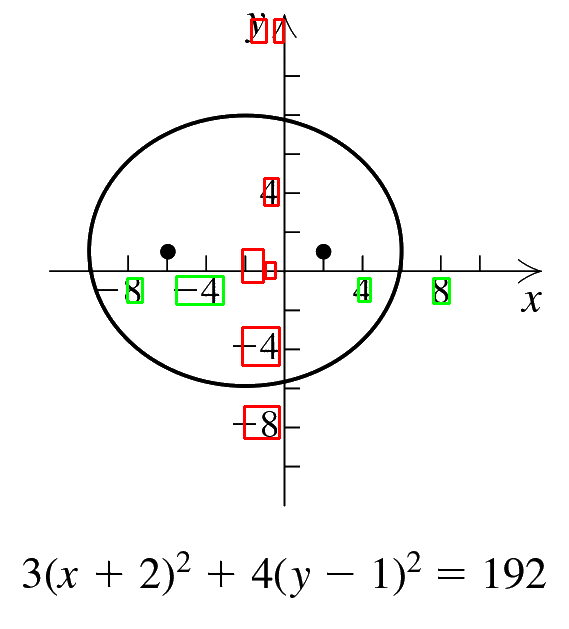

202
202
[[[6, 268], [489, 268]], [[181, 347], [255, 347]]] [[[239, 21], [239, 504]], [[219, 178], [219, 358]]]


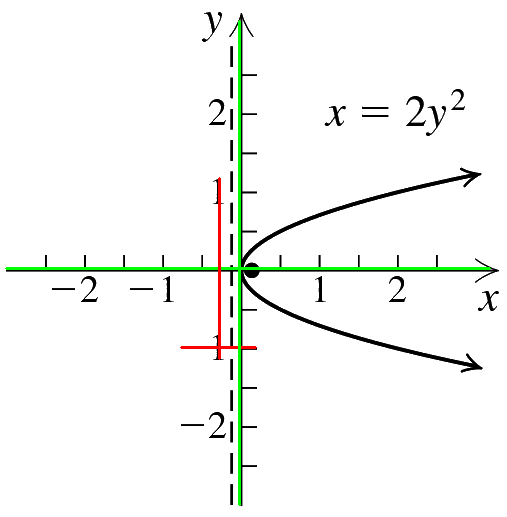

202
202


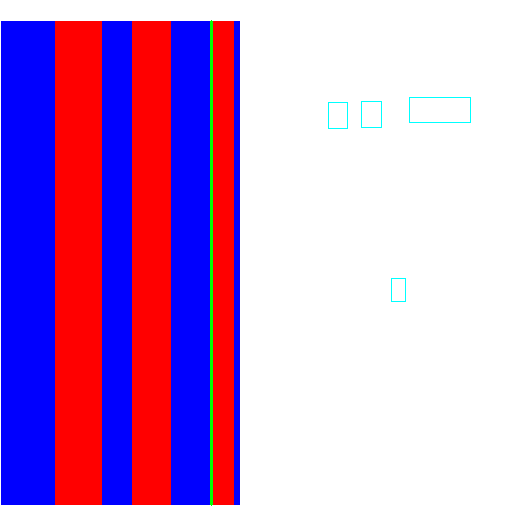

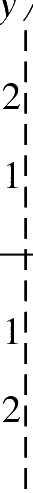

(493, 33, 3)


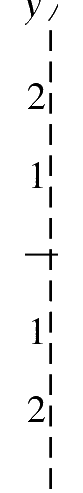

(493, 83, 3)
202
202
202
202
202
[{'boundingBox': [24, 423, 23, 371, 58, 372, 57, 424], 'text': 'N_', 'confidence': 'Low'}, {'boundingBox': [23, 362, 23, 341, 58, 342, 58, 363], 'text': '_', 'confidence': 'Low'}, {'boundingBox': [22, 300, 21, 282, 57, 283, 57, 300], 'text': '_', 'confidence': 'Low'}, {'boundingBox': [43, 487, 43, 477, 57, 478, 58, 488], 'text': '-'}, {'boundingBox': [43, 457, 43, 447, 57, 447, 57, 457], 'text': '-', 'confidence': 'Low'}, {'boundingBox': [43, 478, 43, 468, 57, 468, 57, 477], 'text': '-'}, {'boundingBox': [29, 340, 27, 315, 61, 313, 63, 337], 'text': '='}, {'boundingBox': [43, 446, 42, 437, 55, 437, 56, 445], 'text': '-', 'confidence': 'Low'}]
[{'boundingBox': [-1, 423, -2, 371, 33, 372, 32, 424], 'text': 'N_', 'confidence': 'Low'}, {'boundingBox': [-2, 362, -2, 341, 33, 342, 33, 363], 'text': '_', 'confidence': 'Low'}, {'boundingBox': [-3, 300, -4, 282, 32, 283, 32, 300], 'text': '_', 'confidence': 'Low'}, {'boundingBox': [18, 487, 18, 477, 32, 478, 33,

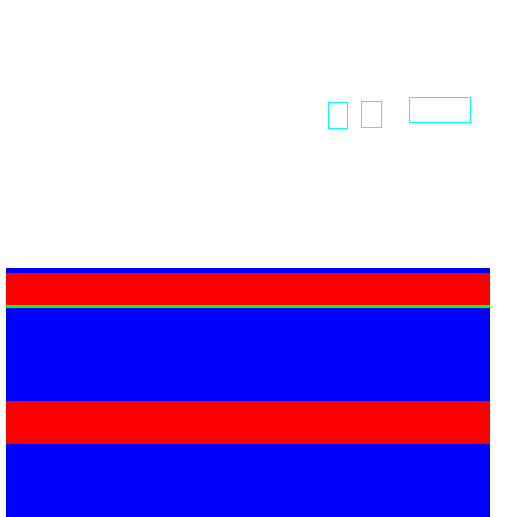

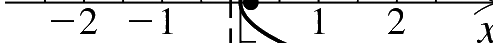

(43, 493, 3)


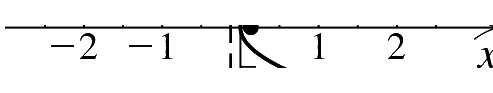

(93, 493, 3)
202
202
202
[{'boundingBox': [51, 33, 99, 32, 99, 62, 51, 60], 'text': '-2'}, {'boundingBox': [130, 32, 176, 33, 177, 62, 131, 63], 'text': '-1'}, {'boundingBox': [388, 31, 404, 30, 407, 60, 391, 61], 'text': '2'}, {'boundingBox': [222, 25, 253, 24, 254, 70, 223, 71], 'text': '1', 'confidence': 'Low'}, {'boundingBox': [314, 23, 323, 23, 324, 69, 315, 69], 'text': '1'}]
[{'boundingBox': [51, 8, 99, 7, 99, 37, 51, 35], 'text': '-2'}, {'boundingBox': [130, 7, 176, 8, 177, 37, 131, 38], 'text': '-1'}, {'boundingBox': [388, 6, 404, 5, 407, 35, 391, 36], 'text': '2'}, {'boundingBox': [222, 0, 253, -1, 254, 45, 223, 46], 'text': '1', 'confidence': 'Low'}, {'boundingBox': [314, -2, 323, -2, 324, 44, 315, 44], 'text': '1'}]
[{'boundingBox': [52, 276, 100, 275, 100, 305, 52, 303], 'text': '-2'}, {'boundingBox': [131, 275, 177, 276, 178, 305, 132, 306], 'text': '-1'}, {'boundingBox': [389, 274, 405, 273, 408, 303, 392, 304], 'text': '2'}, {'boundingBox': [223, 268, 254, 267, 255, 313

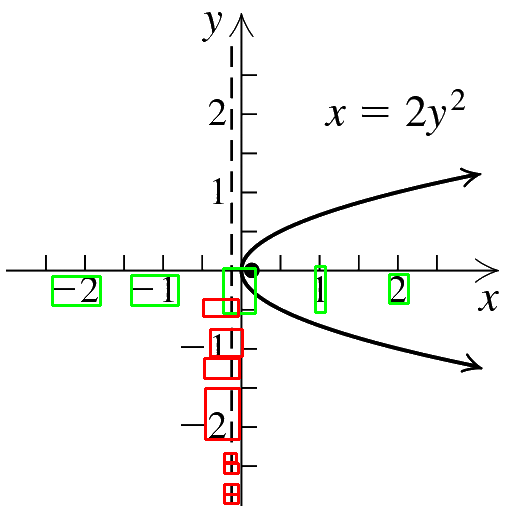

202
202
202
[[[41, 632], [823, 632]], [[41, 445], [808, 445]]] [[[414, 88], [414, 823]], [[102, 423], [102, 444]]]


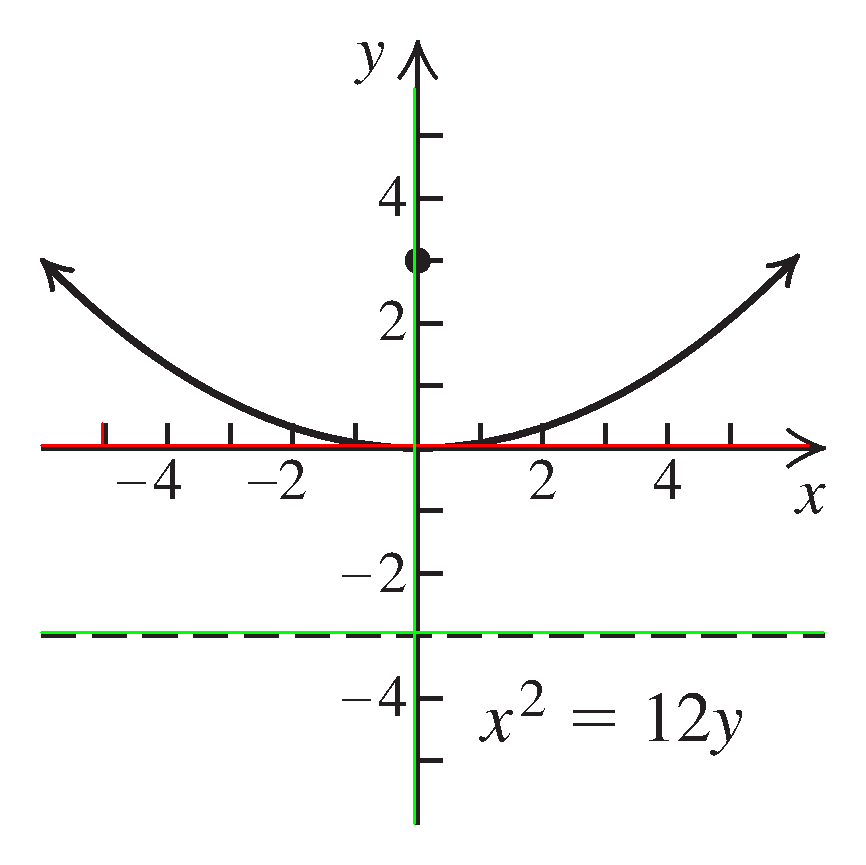

202
202
202


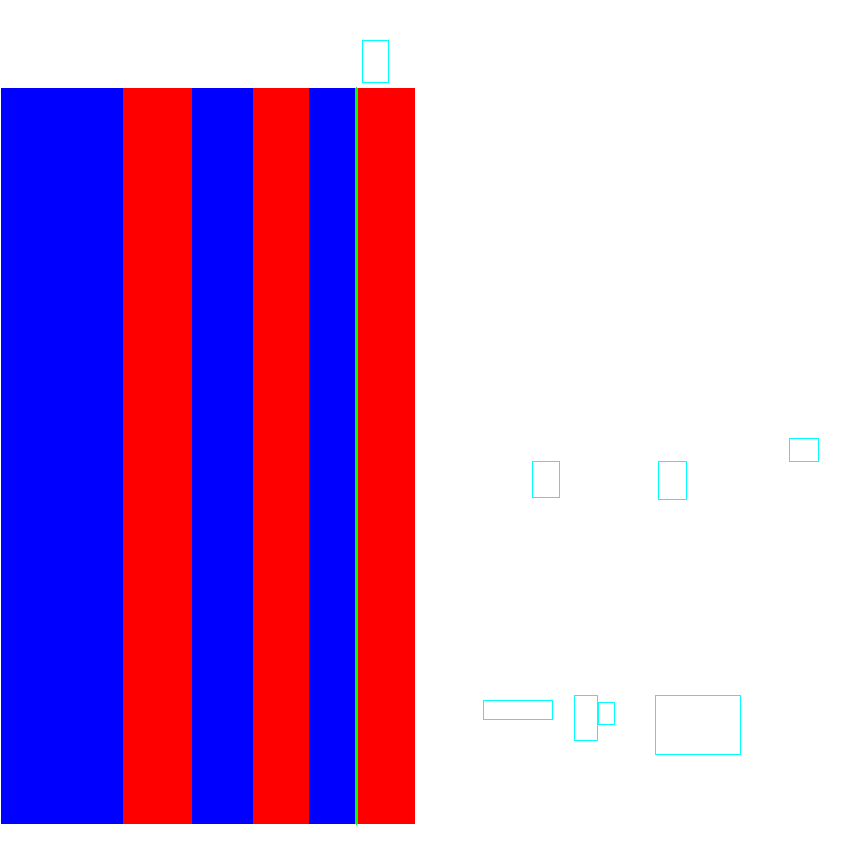

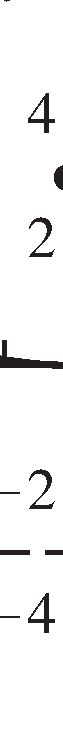

(745, 63, 3)


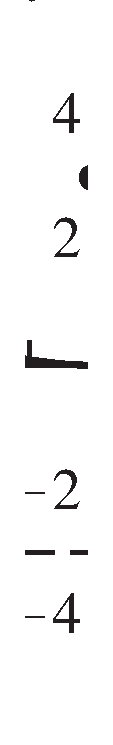

(745, 113, 3)
202
202
[{'boundingBox': [59, 95, 83, 98, 78, 134, 54, 130], 'text': '4'}, {'boundingBox': [33, 259, 35, 223, 89, 226, 87, 262], 'text': 'N'}, {'boundingBox': [59, 473, 78, 474, 77, 506, 57, 505], 'text': '2'}, {'boundingBox': [56, 595, 81, 596, 79, 634, 54, 633], 'text': '4'}]
[{'boundingBox': [34, 95, 58, 98, 53, 134, 29, 130], 'text': '4'}, {'boundingBox': [8, 259, 10, 223, 64, 226, 62, 262], 'text': 'N'}, {'boundingBox': [34, 473, 53, 474, 52, 506, 32, 505], 'text': '2'}, {'boundingBox': [31, 595, 56, 596, 54, 634, 29, 633], 'text': '4'}]
[{'boundingBox': [385, 178, 409, 181, 404, 217, 380, 213], 'text': '4'}, {'boundingBox': [359, 342, 361, 306, 415, 309, 413, 345], 'text': 'N'}, {'boundingBox': [385, 556, 404, 557, 403, 589, 383, 588], 'text': '2'}, {'boundingBox': [382, 678, 407, 679, 405, 717, 380, 716], 'text': '4'}]


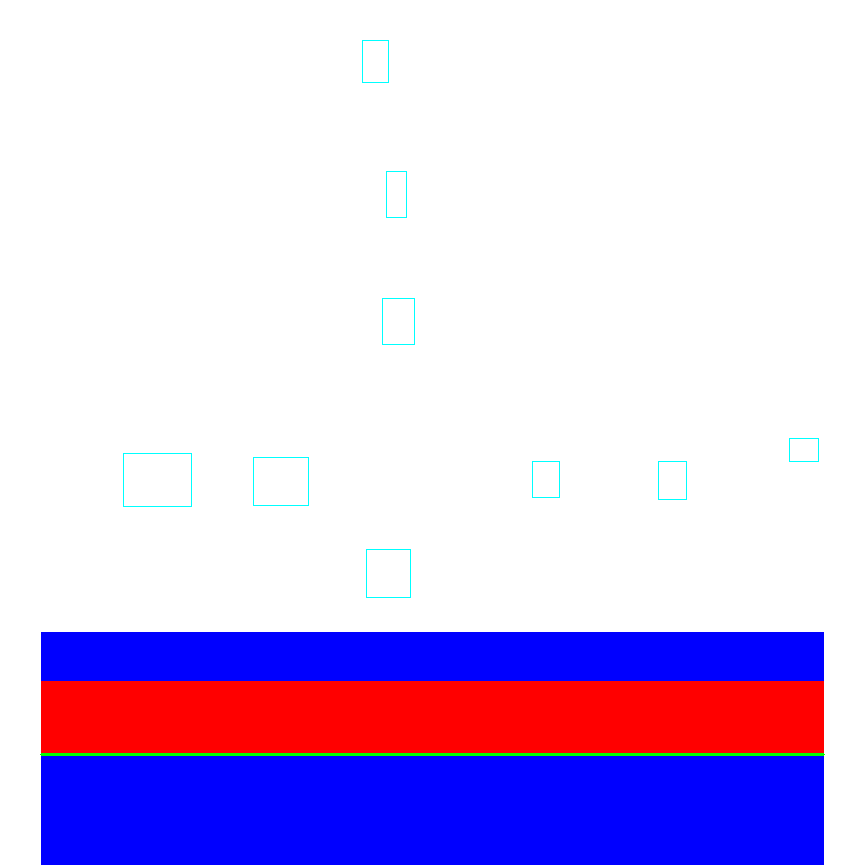

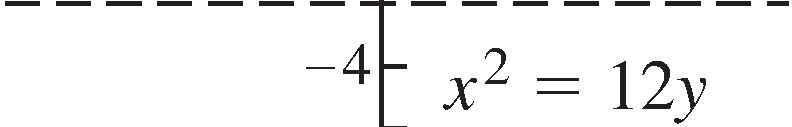

(127, 792, 3)


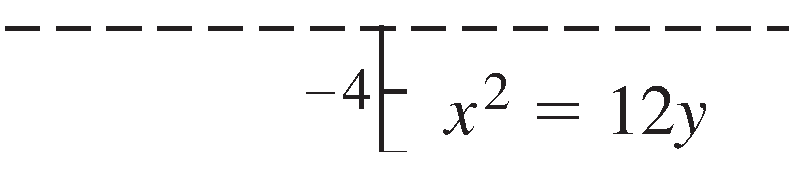

(177, 792, 3)
202
202
202
202
202
[{'boundingBox': [348, 30, 418, 47, 410, 135, 339, 136], 'text': '4', 'confidence': 'Low'}, {'boundingBox': [453, 56, 524, 72, 516, 133, 445, 134], 'text': 'x2', 'confidence': 'Low'}, {'boundingBox': [546, 75, 589, 79, 582, 138, 538, 135], 'text': '='}, {'boundingBox': [611, 81, 705, 90, 698, 147, 604, 140], 'text': '12y'}, {'boundingBox': [324, 87, 335, 87, 336, 103, 325, 103], 'text': '-'}, {'boundingBox': [344, 86, 348, 86, 348, 102, 344, 102], 'text': '6', 'confidence': 'Low'}, {'boundingBox': [378, 135, 390, 135, 390, 153, 378, 153], 'text': 'L'}, {'boundingBox': [306, 87, 315, 87, 315, 100, 306, 100], 'text': '-', 'confidence': 'Low'}, {'boundingBox': [342, 89, 345, 89, 345, 101, 342, 101], 'text': '1', 'confidence': 'Low'}, {'boundingBox': [315, 87, 322, 86, 325, 96, 318, 98], 'text': '-'}]
[{'boundingBox': [348, 5, 418, 22, 410, 110, 339, 111], 'text': '4', 'confidence': 'Low'}, {'boundingBox': [453, 31, 524, 47, 516, 108, 445, 109], 'text': 'x

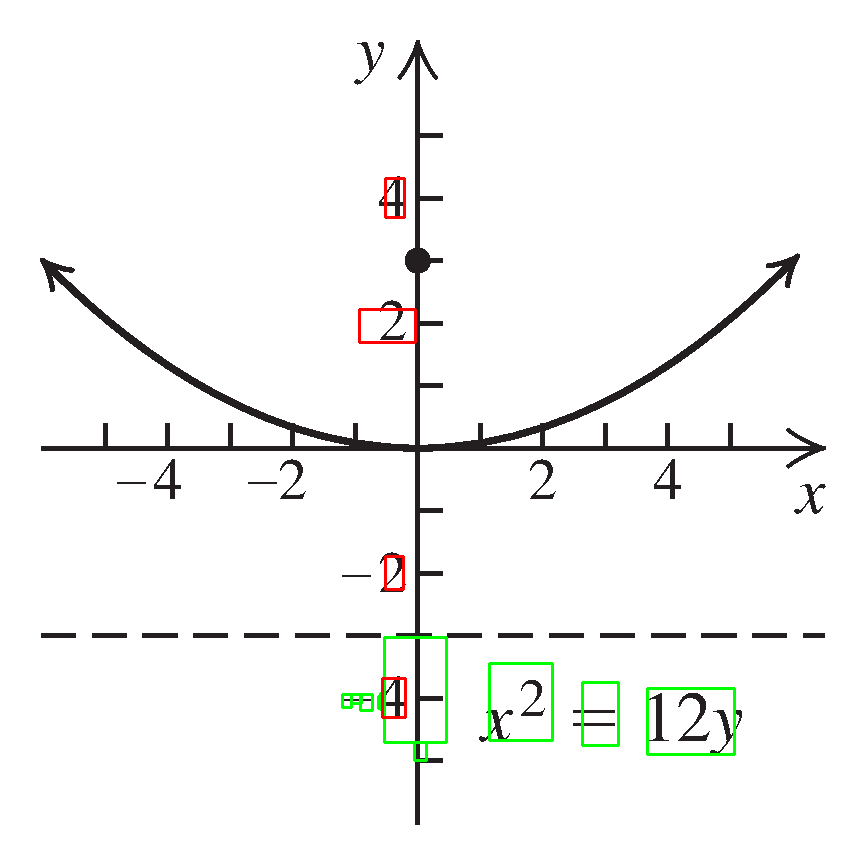

202
202
202
202
[[[40, 512], [696, 512]], [[126, 260], [690, 260]]] [[[408, 266], [408, 658]], [[709, 263], [709, 654]]]


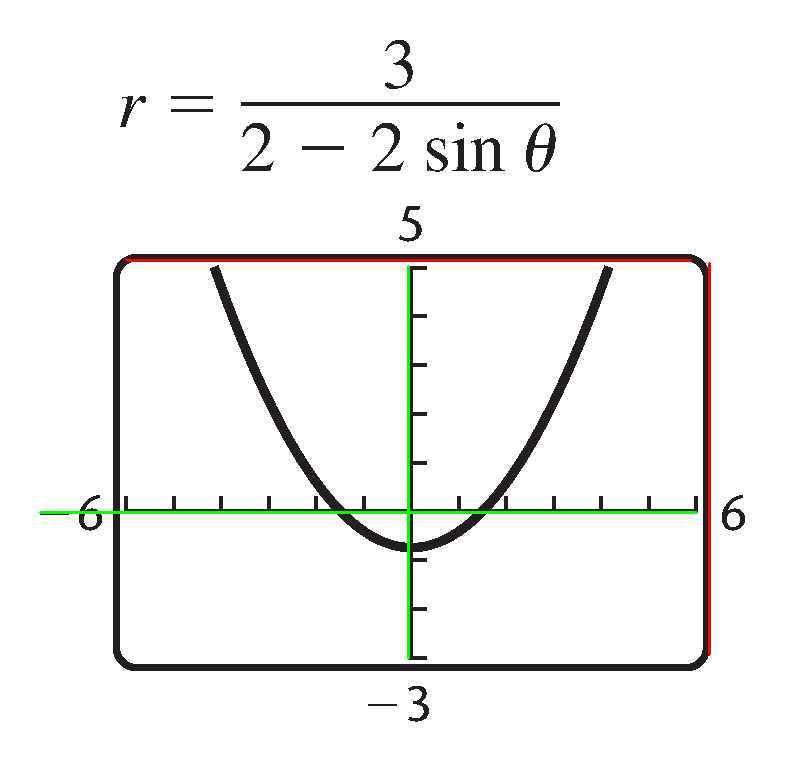

202
202


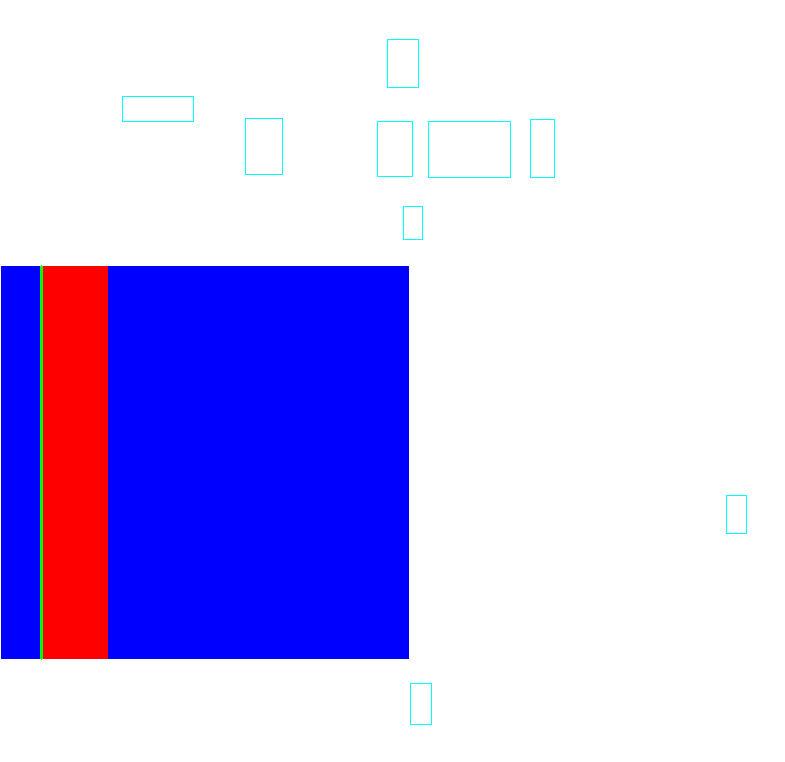

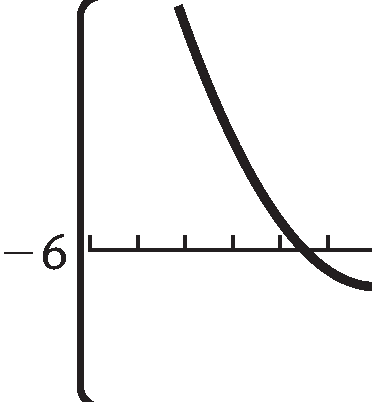

(402, 372, 3)


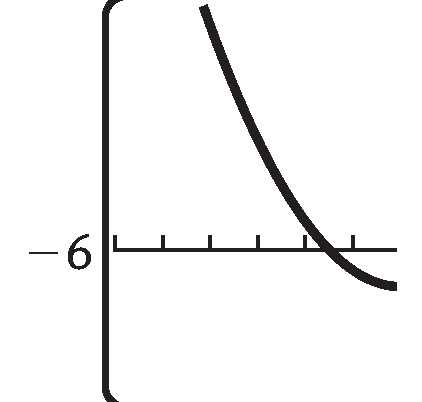

(402, 422, 3)
202
202
202
202
[{'boundingBox': [30, 235, 93, 232, 94, 268, 32, 271], 'text': '-6'}, {'boundingBox': [158, 232, 173, 232, 174, 254, 159, 254], 'text': 'L'}, {'boundingBox': [111, 233, 126, 233, 126, 255, 111, 255], 'text': 'L'}]
[{'boundingBox': [5, 235, 68, 232, 69, 268, 7, 271], 'text': '-6'}, {'boundingBox': [133, 232, 148, 232, 149, 254, 134, 254], 'text': 'L'}, {'boundingBox': [86, 233, 101, 233, 101, 255, 86, 255], 'text': 'L'}]
[{'boundingBox': [41, 496, 104, 493, 105, 529, 43, 532], 'text': '-6'}, {'boundingBox': [169, 493, 184, 493, 185, 515, 170, 515], 'text': 'L'}, {'boundingBox': [122, 494, 137, 494, 137, 516, 122, 516], 'text': 'L'}]


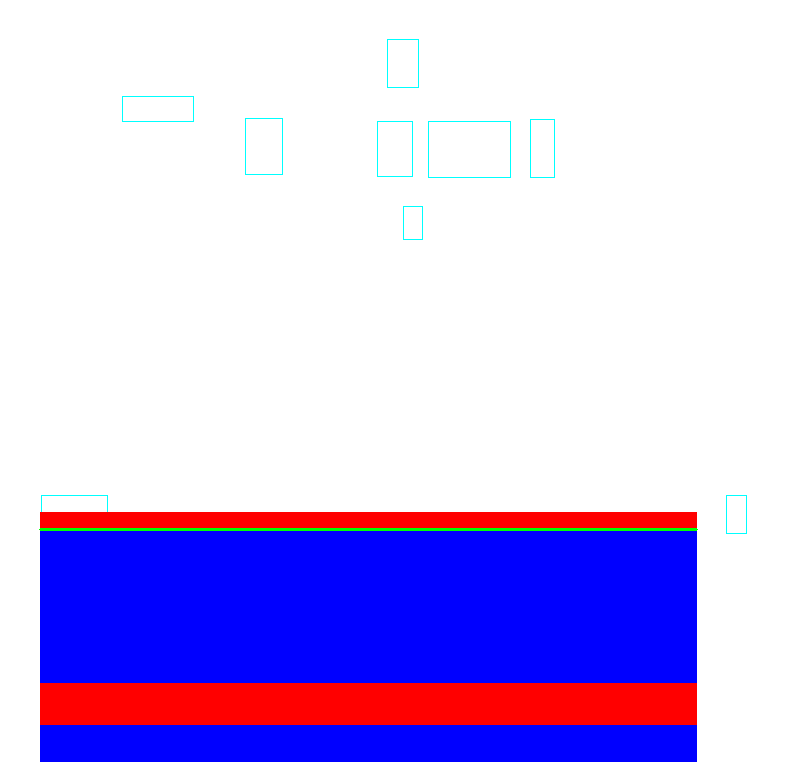

(22, 666, 3)


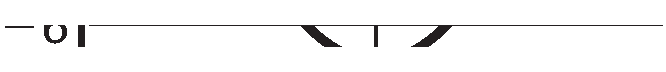

(72, 666, 3)
202
202
[{'boundingBox': [45, 23, 86, 25, 85, 47, 44, 45], 'text': 'UI', 'confidence': 'Low'}]
[{'boundingBox': [45, -2, 86, 0, 85, 22, 44, 20], 'text': 'UI', 'confidence': 'Low'}]
[{'boundingBox': [80, 510, 121, 512, 120, 534, 79, 532], 'text': 'UI', 'confidence': 'Low'}]
[{'boundingBox': [41, 496, 104, 493, 105, 529, 43, 532], 'text': '-6'}, {'boundingBox': [169, 493, 184, 493, 185, 515, 170, 515], 'text': 'L'}, {'boundingBox': [122, 494, 137, 494, 137, 516, 122, 516], 'text': 'L'}]
[{'boundingBox': [80, 510, 121, 512, 120, 534, 79, 532], 'text': 'UI', 'confidence': 'Low'}]


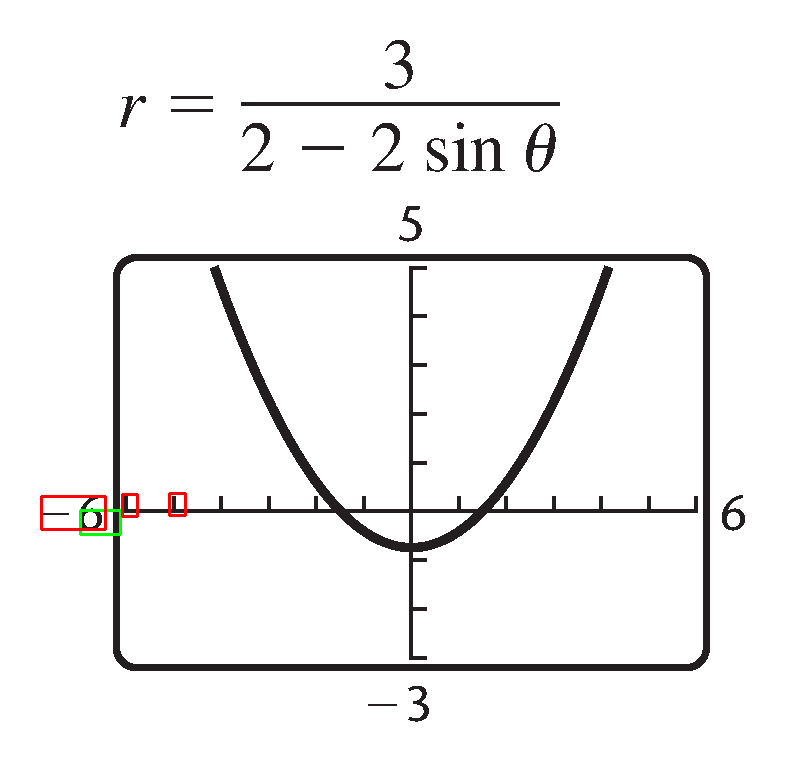

202
202
202
[[[126, 260], [690, 260]], [[130, 663], [694, 663]]] [[[313, 266], [313, 658]], [[709, 263], [709, 654]]]


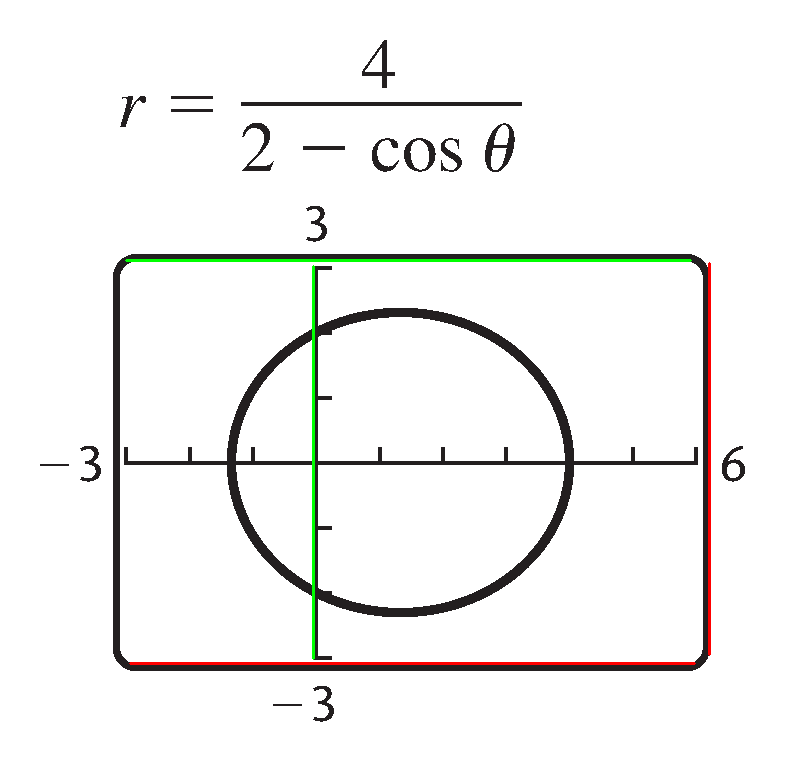

202
202
202


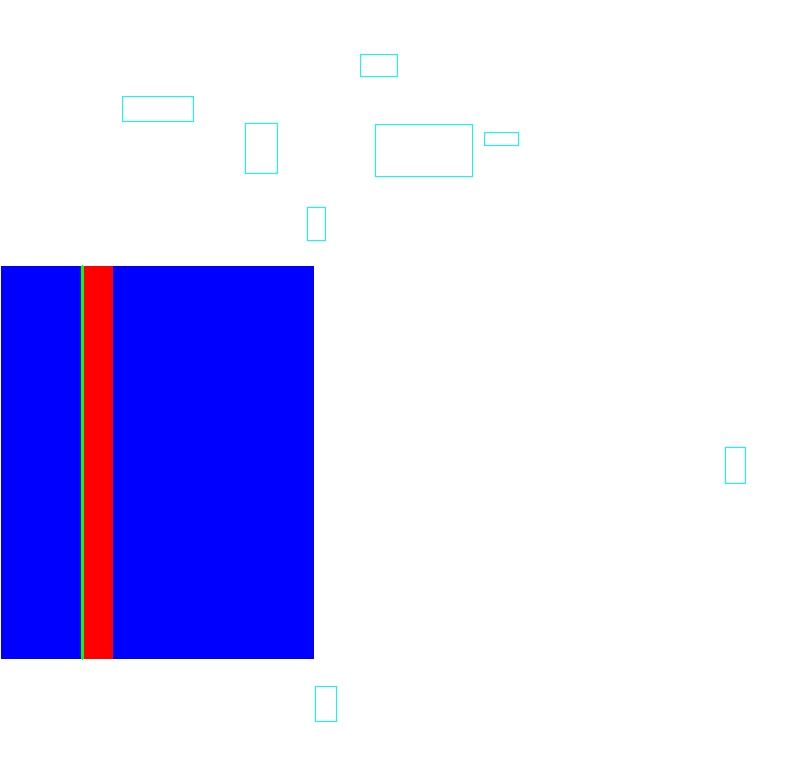

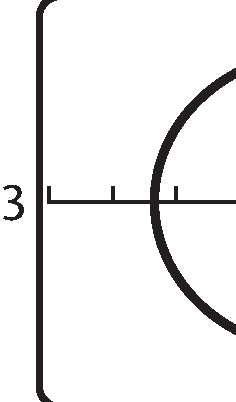

(402, 236, 3)


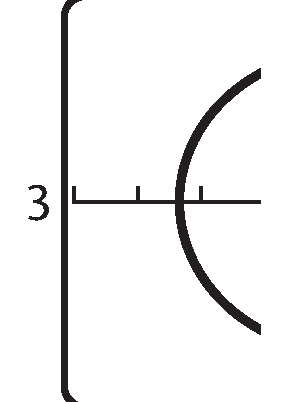

(402, 286, 3)
202
202
[{'boundingBox': [29, 184, 53, 183, 53, 218, 30, 219], 'text': '3'}]
[{'boundingBox': [4, 184, 28, 183, 28, 218, 5, 219], 'text': '3'}]
[{'boundingBox': [81, 445, 105, 444, 105, 479, 82, 480], 'text': '3'}]


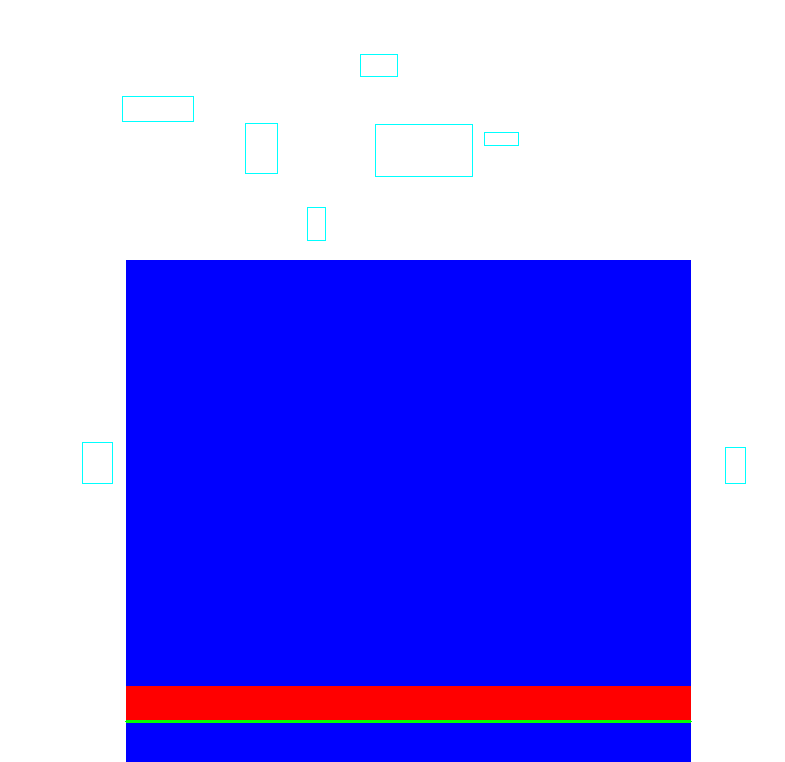

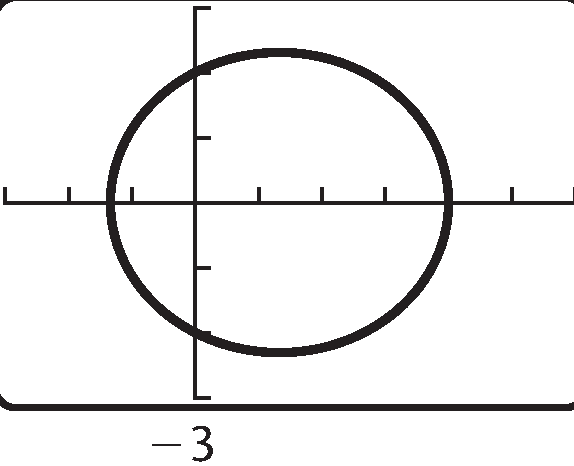

(466, 574, 3)


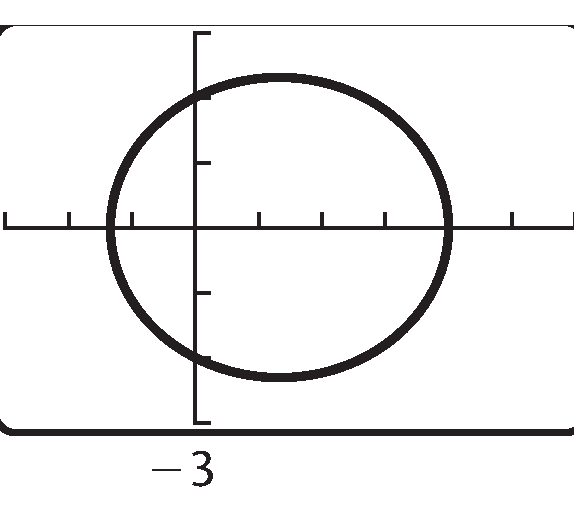

(516, 574, 3)
202
202
202
[{'boundingBox': [154, 454, 173, 453, 174, 481, 156, 482], 'text': '-'}, {'boundingBox': [191, 485, 190, 469, 214, 468, 215, 484], 'text': 'u'}, {'boundingBox': [171, 452, 188, 450, 192, 474, 176, 477], 'text': '-', 'confidence': 'Low'}, {'boundingBox': [195, 449, 209, 446, 213, 471, 199, 473], 'text': 'J', 'confidence': 'Low'}]
[{'boundingBox': [154, 429, 173, 428, 174, 456, 156, 457], 'text': '-'}, {'boundingBox': [191, 460, 190, 444, 214, 443, 215, 459], 'text': 'u'}, {'boundingBox': [171, 427, 188, 425, 192, 449, 176, 452], 'text': '-', 'confidence': 'Low'}, {'boundingBox': [195, 424, 209, 421, 213, 446, 199, 448], 'text': 'J', 'confidence': 'Low'}]
[{'boundingBox': [275, 689, 294, 688, 295, 716, 277, 717], 'text': '-'}, {'boundingBox': [312, 720, 311, 704, 335, 703, 336, 719], 'text': 'u'}, {'boundingBox': [292, 687, 309, 685, 313, 709, 297, 712], 'text': '-', 'confidence': 'Low'}, {'boundingBox': [316, 684, 330, 681, 334, 706, 320, 708], 'text': 'J', 'co

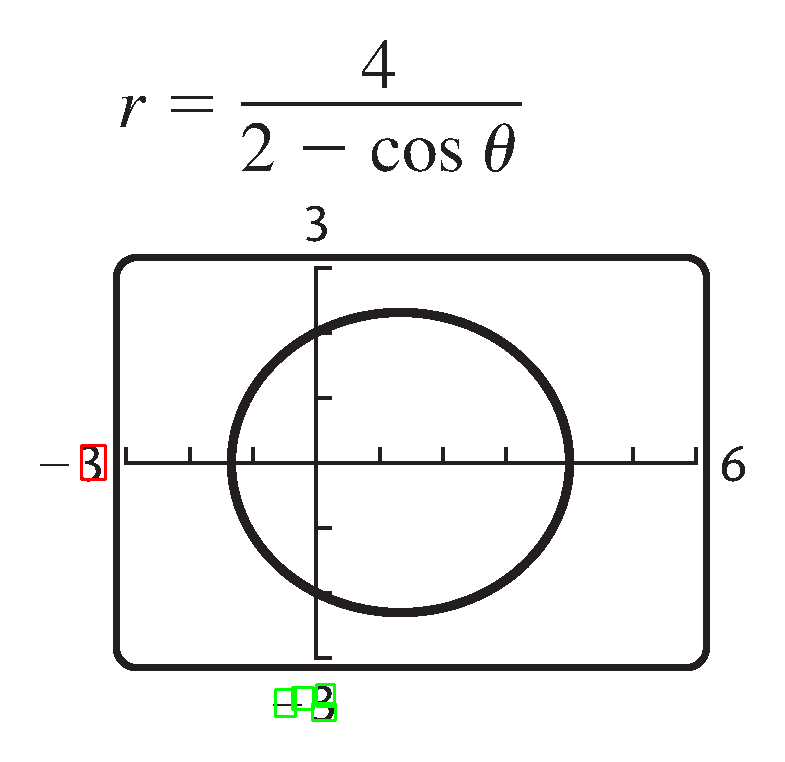

202
202
202
[[[36, 162], [230, 162]], [[40, 21], [226, 21]]] [[[237, 29], [237, 159]], [[31, 29], [31, 156]]]


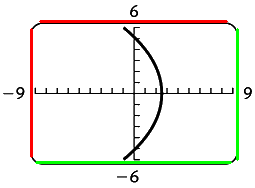

202
202


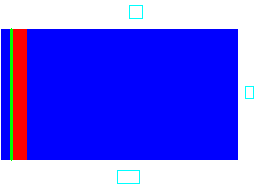

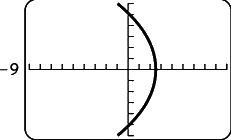

(140, 231, 3)


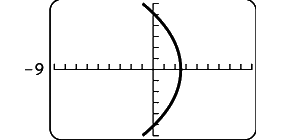

(140, 281, 3)
202
202
[{'boundingBox': [25, 61, 56, 60, 57, 73, 26, 75], 'text': '-94', 'confidence': 'Low'}]
[{'boundingBox': [0, 61, 31, 60, 32, 73, 1, 75], 'text': '-94', 'confidence': 'Low'}]
[{'boundingBox': [6, 85, 37, 84, 38, 97, 7, 99], 'text': '-94', 'confidence': 'Low'}]


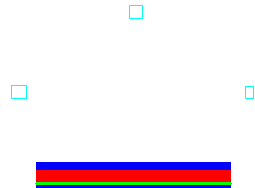

(26, 204, 3)


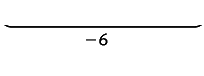

(76, 204, 3)
202
202
[{'boundingBox': [86, 31, 108, 31, 108, 47, 86, 47], 'text': '-6'}]
[{'boundingBox': [86, 6, 108, 6, 108, 22, 86, 22], 'text': '-6'}]
[{'boundingBox': [117, 168, 139, 168, 139, 184, 117, 184], 'text': '-6'}]
[{'boundingBox': [6, 85, 37, 84, 38, 97, 7, 99], 'text': '-94', 'confidence': 'Low'}]
[{'boundingBox': [117, 168, 139, 168, 139, 184, 117, 184], 'text': '-6'}]


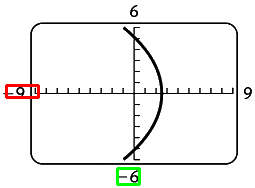

202
202
[[[5, 142], [280, 142]], [[4, 5], [278, 5]]] [[[2, 6], [2, 280]], [[140, 6], [140, 279]]]


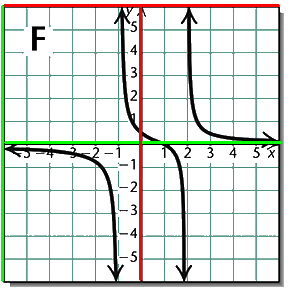

202
202


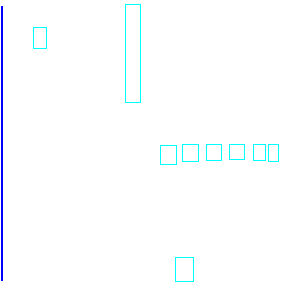

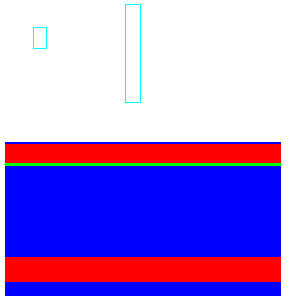

(27, 285, 3)


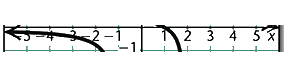

(77, 285, 3)
202
202
[{'boundingBox': [185, 27, 196, 27, 196, 46, 185, 46], 'text': '2'}, {'boundingBox': [207, 27, 217, 27, 217, 45, 207, 44], 'text': '3'}, {'boundingBox': [230, 26, 241, 26, 241, 45, 229, 45], 'text': '4'}, {'boundingBox': [253, 26, 264, 27, 264, 45, 253, 45], 'text': '5'}, {'boundingBox': [268, 27, 277, 28, 276, 45, 268, 45], 'text': 'X'}]
[{'boundingBox': [185, 2, 196, 2, 196, 21, 185, 21], 'text': '2'}, {'boundingBox': [207, 2, 217, 2, 217, 20, 207, 19], 'text': '3'}, {'boundingBox': [230, 1, 241, 1, 241, 20, 229, 20], 'text': '4'}, {'boundingBox': [253, 1, 264, 2, 264, 20, 253, 20], 'text': '5'}, {'boundingBox': [268, 2, 277, 3, 276, 20, 268, 20], 'text': 'X'}]
[{'boundingBox': [185, 144, 196, 144, 196, 163, 185, 163], 'text': '2'}, {'boundingBox': [207, 144, 217, 144, 217, 162, 207, 161], 'text': '3'}, {'boundingBox': [230, 143, 241, 143, 241, 162, 229, 162], 'text': '4'}, {'boundingBox': [253, 143, 264, 144, 264, 162, 253, 162], 'text': '5'}, {'boundingBox': [2

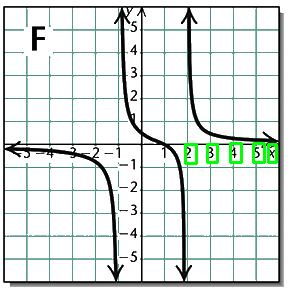

202
202
202
202
[[[3, 185], [341, 185]], [[238, 47], [384, 47]]] [[[202, 26], [202, 339]], [[116, 49], [116, 356]]]


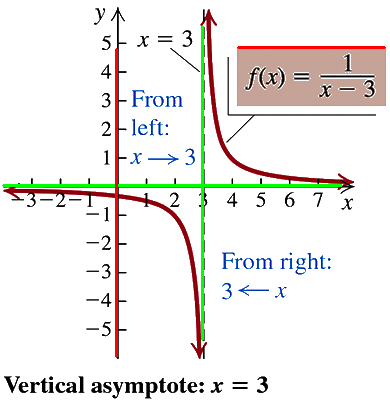

202
202
202
202


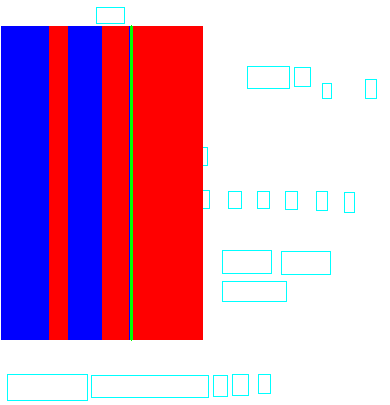

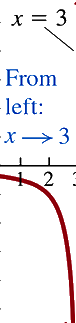

(323, 76, 3)


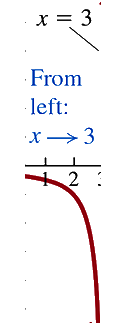

(323, 126, 3)
202
202
[{'boundingBox': [38, 13, 91, 10, 92, 27, 38, 27], 'text': 'X=3', 'confidence': 'Low'}, {'boundingBox': [32, 68, 77, 68, 77, 87, 32, 87], 'text': 'From'}, {'boundingBox': [30, 96, 67, 96, 66, 115, 30, 115], 'text': 'left:'}, {'boundingBox': [31, 130, 79, 127, 79, 147, 31, 147], 'text': '*->', 'confidence': 'Low'}, {'boundingBox': [86, 127, 96, 127, 96, 148, 85, 148], 'text': '3'}, {'boundingBox': [41, 168, 55, 168, 56, 189, 42, 189], 'text': '1', 'confidence': 'Low'}, {'boundingBox': [69, 167, 83, 167, 84, 188, 70, 188], 'text': '2'}]
[{'boundingBox': [13, 13, 66, 10, 67, 27, 13, 27], 'text': 'X=3', 'confidence': 'Low'}, {'boundingBox': [7, 68, 52, 68, 52, 87, 7, 87], 'text': 'From'}, {'boundingBox': [5, 96, 42, 96, 41, 115, 5, 115], 'text': 'left:'}, {'boundingBox': [6, 130, 54, 127, 54, 147, 6, 147], 'text': '*->', 'confidence': 'Low'}, {'boundingBox': [61, 127, 71, 127, 71, 148, 60, 148], 'text': '3'}, {'boundingBox': [16, 168, 30, 168, 31, 189, 17, 189], 'text

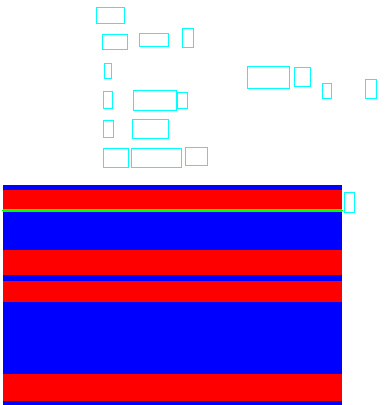

(30, 346, 3)


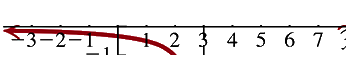

(80, 346, 3)
202
202
202
[{'boundingBox': [12, 27, 36, 28, 35, 49, 12, 48], 'text': '53', 'confidence': 'Low'}, {'boundingBox': [40, 29, 52, 29, 51, 50, 40, 49], 'text': '-'}, {'boundingBox': [171, 30, 183, 30, 183, 51, 171, 51], 'text': '2'}, {'boundingBox': [200, 31, 213, 32, 212, 50, 199, 49], 'text': '3'}, {'boundingBox': [228, 30, 241, 30, 241, 50, 228, 50], 'text': '4'}, {'boundingBox': [257, 30, 270, 30, 270, 49, 257, 49], 'text': '5'}, {'boundingBox': [285, 30, 298, 30, 298, 49, 285, 49], 'text': '6'}, {'boundingBox': [315, 29, 325, 29, 325, 49, 316, 49], 'text': '7'}, {'boundingBox': [57, 28, 65, 29, 64, 50, 56, 49], 'text': '2'}]
[{'boundingBox': [12, 2, 36, 3, 35, 24, 12, 23], 'text': '53', 'confidence': 'Low'}, {'boundingBox': [40, 4, 52, 4, 51, 25, 40, 24], 'text': '-'}, {'boundingBox': [171, 5, 183, 5, 183, 26, 171, 26], 'text': '2'}, {'boundingBox': [200, 6, 213, 7, 212, 25, 199, 24], 'text': '3'}, {'boundingBox': [228, 5, 241, 5, 241, 25, 228, 25], 'text': '4'}, {'bound

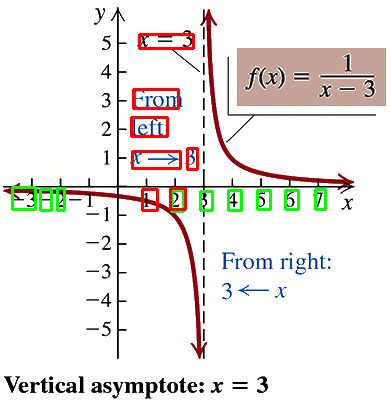

202
202
[[[35, 275], [305, 275]], [[34, 84], [303, 84]]] [[[28, 90], [28, 269]], [[110, 90], [110, 269]]]


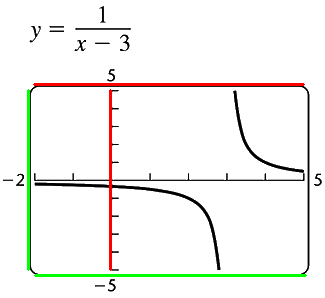

202
202
202
202


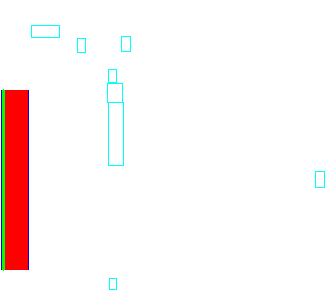

(189, 28, 3)


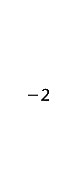

(189, 78, 3)
202
202
[{'boundingBox': [28, 86, 52, 87, 51, 103, 28, 102], 'text': '-2'}]
[{'boundingBox': [3, 86, 27, 87, 26, 103, 3, 102], 'text': '-2'}]
[{'boundingBox': [3, 171, 27, 172, 26, 188, 3, 187], 'text': '-2'}]


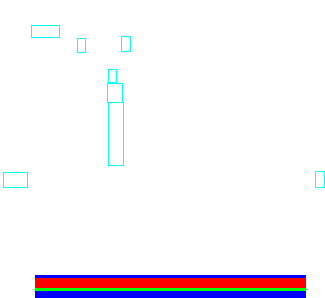

(19, 280, 3)


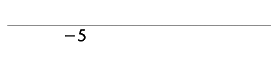

(69, 280, 3)
202
202
[{'boundingBox': [64, 29, 86, 28, 86, 42, 65, 43], 'text': '-5'}]
[{'boundingBox': [64, 4, 86, 3, 86, 17, 65, 18], 'text': '-5'}]
[{'boundingBox': [94, 279, 116, 278, 116, 292, 95, 293], 'text': '-5'}]
[{'boundingBox': [3, 171, 27, 172, 26, 188, 3, 187], 'text': '-2'}]
[{'boundingBox': [94, 279, 116, 278, 116, 292, 95, 293], 'text': '-5'}]


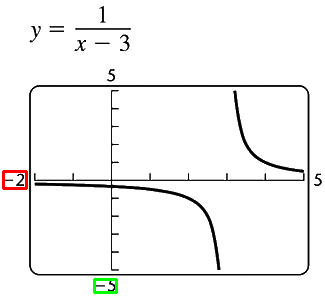

202
202
202
202
202
202
202
[[[4, 168], [289, 168]], [[29, 180], [81, 180]]] [[[131, 25], [131, 298]], [[-109, 99990], [-109, -10010]]]


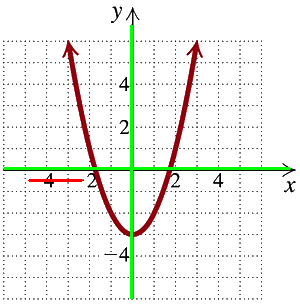

202
202
202
202
202
202


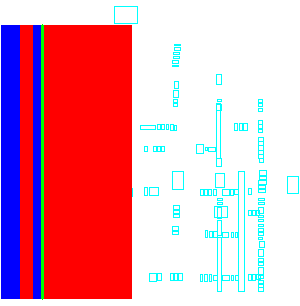

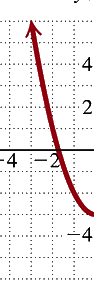

(283, 94, 3)


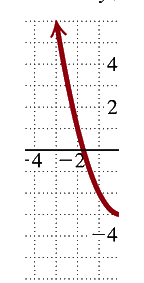

(283, 144, 3)
202
202
202
202
202
202
[{'boundingBox': [108, 62, 114, 62, 114, 70, 108, 70], 'text': '4'}, {'boundingBox': [30, 81, 33, 81, 32, 88, 29, 88], 'text': '.'}, {'boundingBox': [34, 81, 37, 82, 36, 89, 33, 88], 'text': '.'}, {'boundingBox': [38, 82, 42, 82, 41, 89, 38, 89], 'text': '.', 'confidence': 'Low'}, {'boundingBox': [109, 100, 118, 99, 119, 112, 109, 113], 'text': '2'}, {'boundingBox': [103, 125, 106, 125, 106, 131, 103, 131], 'text': '.', 'confidence': 'Low'}, {'boundingBox': [107, 125, 110, 125, 110, 131, 107, 131], 'text': '.', 'confidence': 'Low'}, {'boundingBox': [111, 125, 114, 125, 114, 131, 111, 131], 'text': '.', 'confidence': 'Low'}, {'boundingBox': [116, 125, 118, 125, 118, 131, 116, 131], 'text': '.', 'confidence': 'Low'}, {'boundingBox': [109, 227, 117, 228, 116, 241, 108, 240], 'text': '4'}, {'boundingBox': [93, 81, 101, 81, 101, 89, 94, 89], 'text': '-.', 'confidence': 'Low'}, {'boundingBox': [102, 81, 104, 81, 105, 88, 103, 89], 'text': '.'}, {'boundin

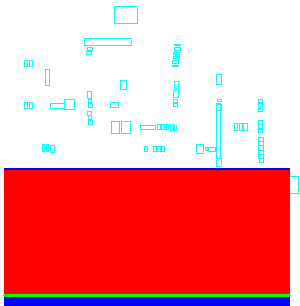

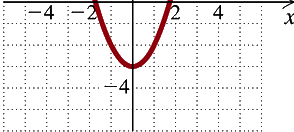

(132, 294, 3)


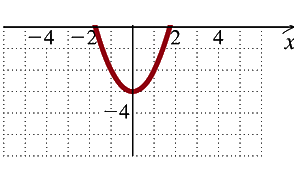

(182, 294, 3)
202
202
202
202
202
202
[{'boundingBox': [215, 30, 224, 31, 223, 44, 214, 43], 'text': '4'}, {'boundingBox': [22, 53, 21, 51, 28, 50, 28, 53], 'text': '.', 'confidence': 'Low'}, {'boundingBox': [21, 49, 21, 46, 28, 46, 28, 49], 'text': '.'}, {'boundingBox': [21, 45, 21, 42, 28, 42, 28, 44], 'text': '.'}, {'boundingBox': [21, 41, 21, 37, 29, 37, 28, 40], 'text': '-', 'confidence': 'Low'}, {'boundingBox': [21, 36, 21, 33, 29, 32, 29, 35], 'text': '.'}, {'boundingBox': [21, 32, 22, 28, 29, 27, 29, 31], 'text': '.'}, {'boundingBox': [173, 105, 173, 102, 179, 102, 179, 105], 'text': '.'}, {'boundingBox': [173, 101, 173, 98, 179, 98, 179, 101], 'text': '.', 'confidence': 'Low'}, {'boundingBox': [173, 96, 173, 92, 179, 93, 179, 97], 'text': '.'}, {'boundingBox': [173, 88, 173, 85, 179, 85, 179, 88], 'text': '.'}, {'boundingBox': [173, 84, 173, 80, 179, 81, 179, 84], 'text': '.'}, {'boundingBox': [173, 79, 173, 76, 179, 76, 179, 79], 'text': '.'}, {'boundingBox': [173, 75, 173, 7

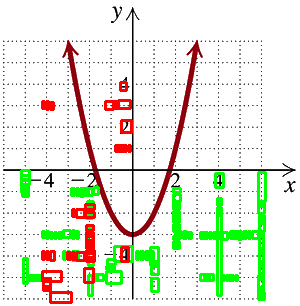

202
202
[[[4, 5], [278, 5]], [[6, 99], [279, 99]]] [[[2, 6], [2, 280]], [[140, 6], [140, 279]]]


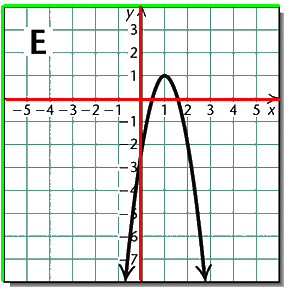

202
202
202


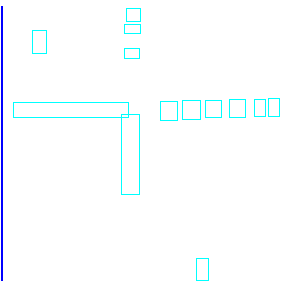

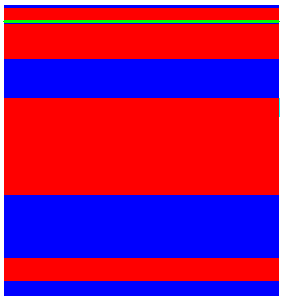

(21, 283, 3)


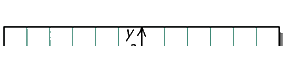

(71, 283, 3)
202
[]
[]
[]
[]
[]


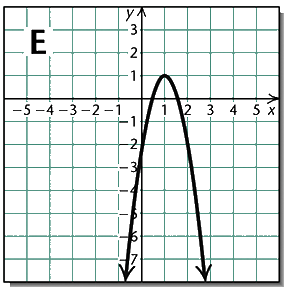

202
202
[[[89, 177], [556, 177]], [[89, 369], [556, 369]]] [[[120, 79], [120, 271]], [[526, 79], [526, 271]]]


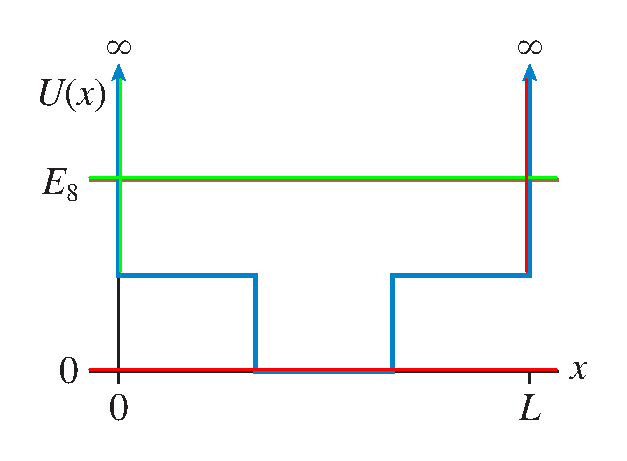

202
202


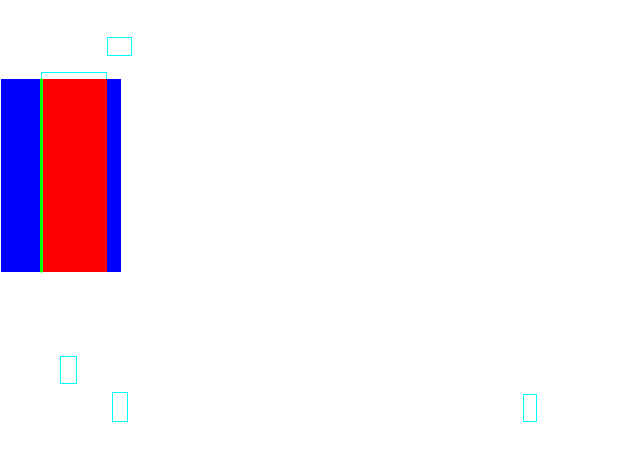

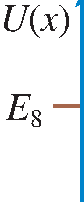

(202, 84, 3)


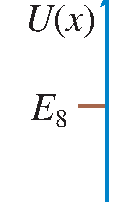

(202, 134, 3)
202
202
[{'boundingBox': [30, 3, 98, 5, 97, 36, 29, 34], 'text': 'U(x)', 'confidence': 'Low'}, {'boundingBox': [38, 93, 71, 99, 66, 128, 33, 122], 'text': 'Es'}]
[{'boundingBox': [5, 3, 73, 5, 72, 36, 4, 34], 'text': 'U(x)', 'confidence': 'Low'}, {'boundingBox': [13, 93, 46, 99, 41, 128, 8, 122], 'text': 'Es'}]
[{'boundingBox': [41, 77, 109, 79, 108, 110, 40, 108], 'text': 'U(x)', 'confidence': 'Low'}, {'boundingBox': [49, 167, 82, 173, 77, 202, 44, 196], 'text': 'Es'}]


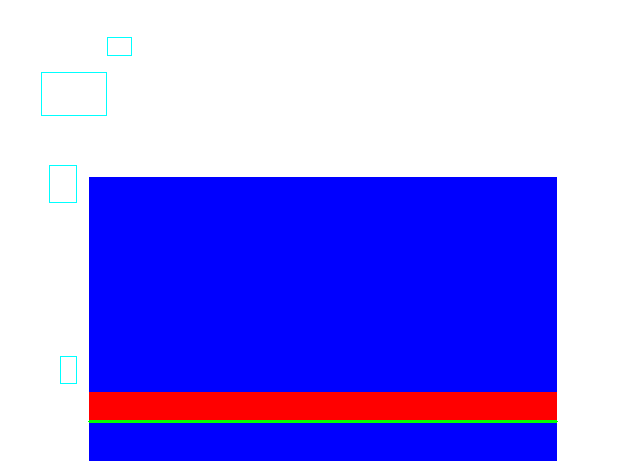

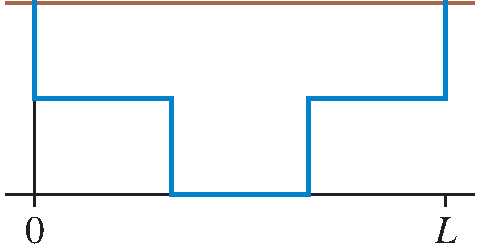

(249, 477, 3)


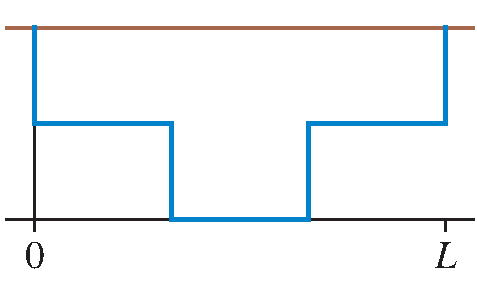

(299, 477, 3)
202
202
[{'boundingBox': [26, 240, 42, 239, 43, 265, 28, 266], 'text': 'O', 'confidence': 'Low'}, {'boundingBox': [437, 238, 459, 238, 458, 270, 437, 270], 'text': 'L'}]
[{'boundingBox': [26, 215, 42, 214, 43, 240, 28, 241], 'text': 'O', 'confidence': 'Low'}, {'boundingBox': [437, 213, 459, 213, 458, 245, 437, 245], 'text': 'L'}]
[{'boundingBox': [110, 392, 126, 391, 127, 417, 112, 418], 'text': 'O', 'confidence': 'Low'}, {'boundingBox': [521, 390, 543, 390, 542, 422, 521, 422], 'text': 'L'}]
[{'boundingBox': [41, 77, 109, 79, 108, 110, 40, 108], 'text': 'U(x)', 'confidence': 'Low'}, {'boundingBox': [49, 167, 82, 173, 77, 202, 44, 196], 'text': 'Es'}]
[{'boundingBox': [110, 392, 126, 391, 127, 417, 112, 418], 'text': 'O', 'confidence': 'Low'}, {'boundingBox': [521, 390, 543, 390, 542, 422, 521, 422], 'text': 'L'}]


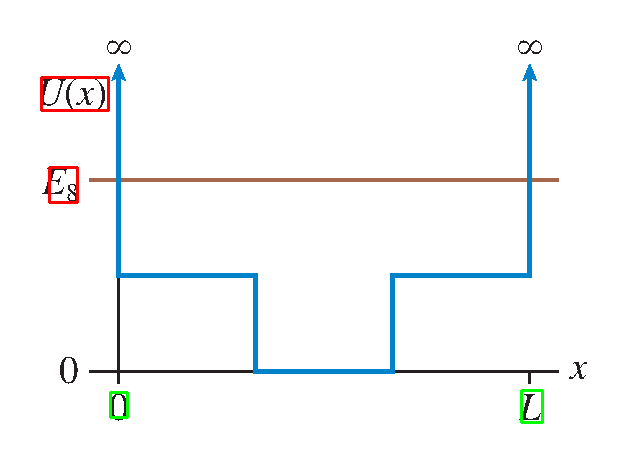

202
202
[[[85, 603], [765, 603]], [[99990, -109], [-10010, -109]]] [[[79, 144], [79, 606]], [[787, 53], [787, 68]]]


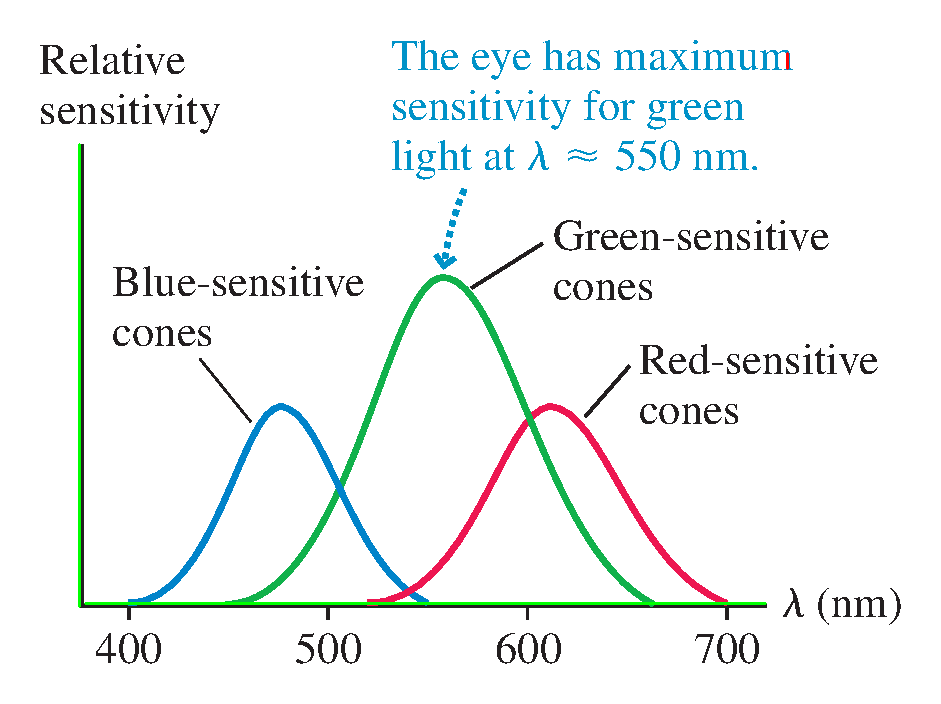

202
202
202


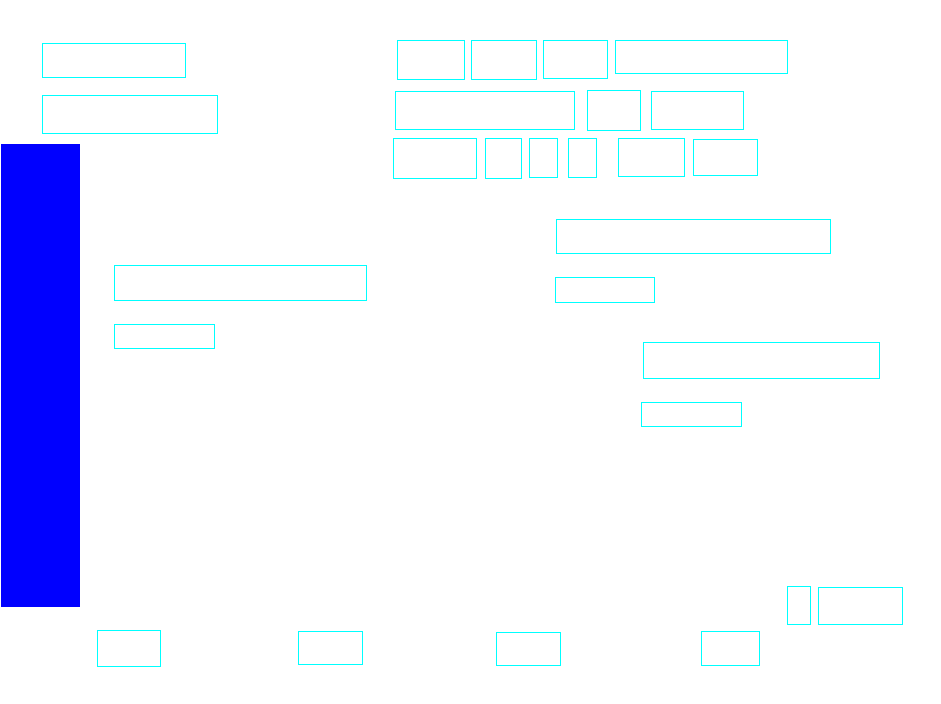

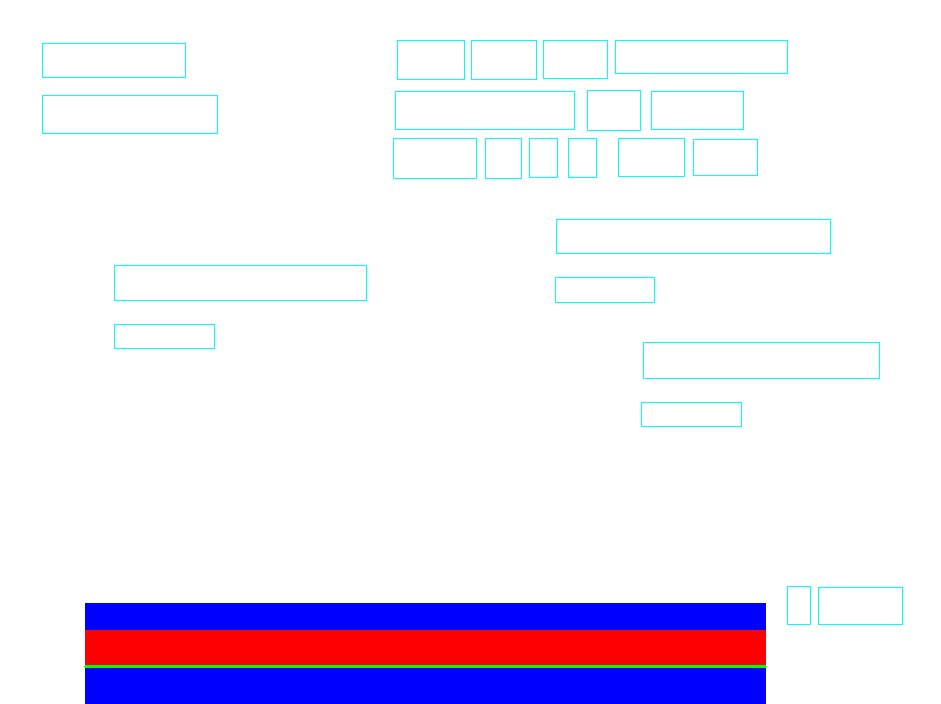

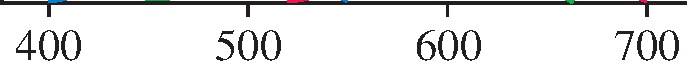

(68, 690, 3)


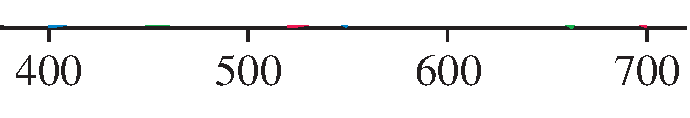

(118, 690, 3)
202
202
[{'boundingBox': [19, 52, 81, 53, 80, 86, 19, 85], 'text': '400'}, {'boundingBox': [218, 54, 282, 54, 282, 87, 218, 87], 'text': '500'}, {'boundingBox': [416, 53, 482, 53, 482, 88, 416, 88], 'text': '600'}, {'boundingBox': [619, 54, 677, 55, 676, 87, 619, 86], 'text': '700'}]
[{'boundingBox': [19, 27, 81, 28, 80, 61, 19, 60], 'text': '400'}, {'boundingBox': [218, 29, 282, 29, 282, 62, 218, 62], 'text': '500'}, {'boundingBox': [416, 28, 482, 28, 482, 63, 416, 63], 'text': '600'}, {'boundingBox': [619, 29, 677, 30, 676, 62, 619, 61], 'text': '700'}]
[{'boundingBox': [99, 630, 161, 631, 160, 664, 99, 663], 'text': '400'}, {'boundingBox': [298, 632, 362, 632, 362, 665, 298, 665], 'text': '500'}, {'boundingBox': [496, 631, 562, 631, 562, 666, 496, 666], 'text': '600'}, {'boundingBox': [699, 632, 757, 633, 756, 665, 699, 664], 'text': '700'}]
[]
[{'boundingBox': [99, 630, 161, 631, 160, 664, 99, 663], 'text': '400'}, {'boundingBox': [298, 632, 362, 632, 362, 665, 298, 6

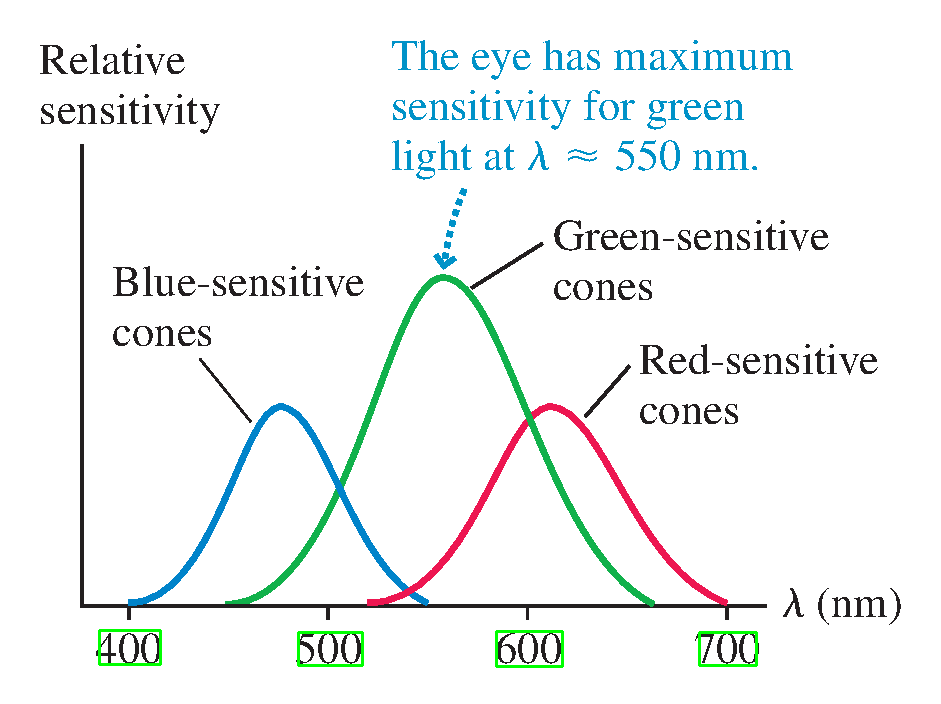

202
202
[[[90, 821], [890, 821]], [[308, 638], [685, 638]]] [[[105, 96], [105, 839]], [[301, 599], [301, 840]]]


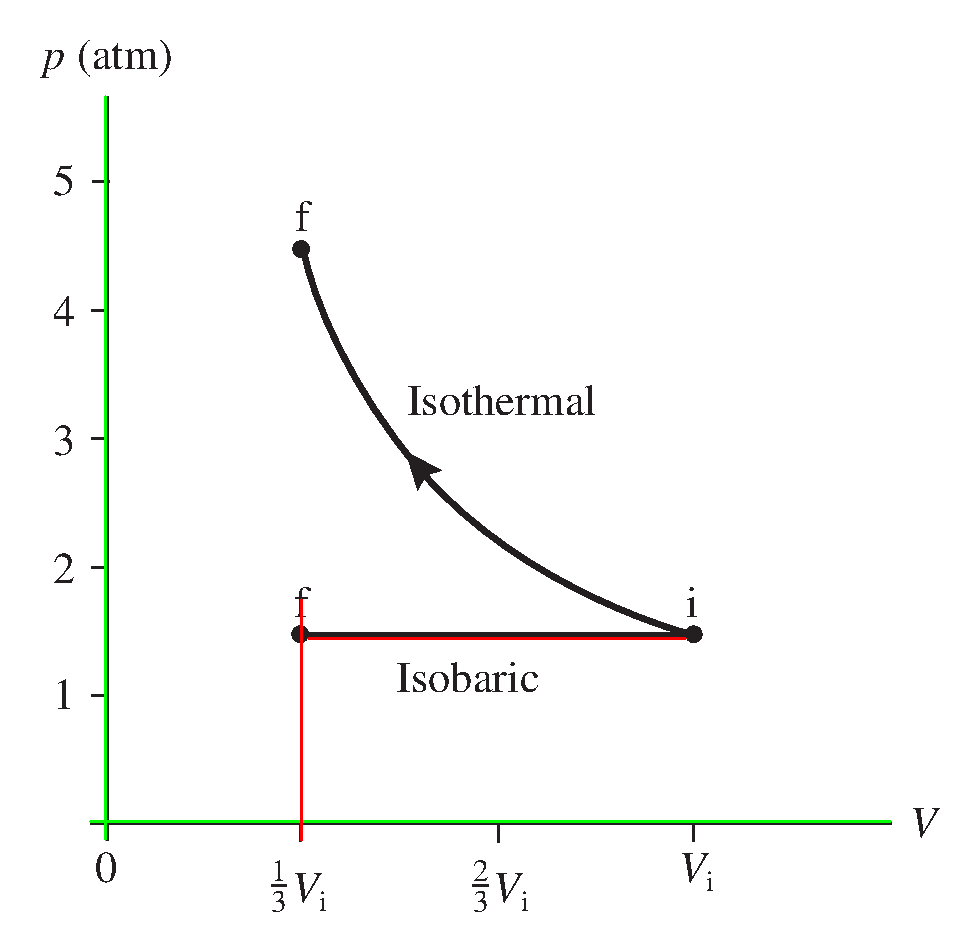

202
202


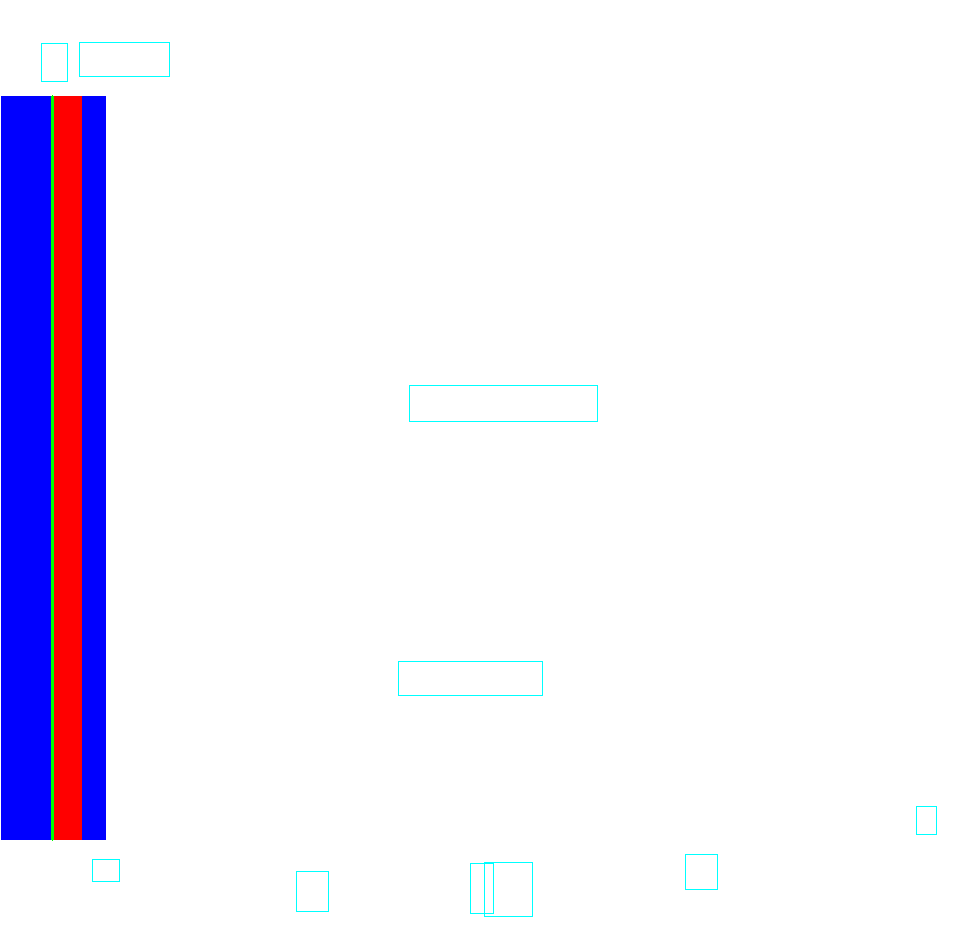

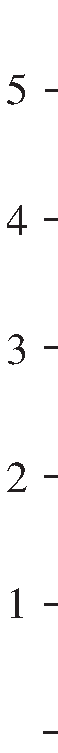

(753, 58, 3)


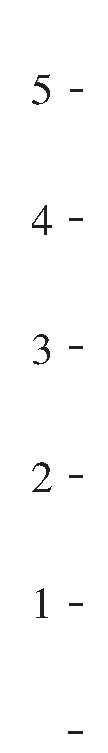

(753, 108, 3)
202
202
202
[{'boundingBox': [34, 77, 51, 76, 53, 100, 35, 101], 'text': '5'}, {'boundingBox': [69, 75, 83, 74, 85, 98, 70, 99], 'text': '-'}, {'boundingBox': [34, 205, 56, 205, 56, 234, 35, 234], 'text': '4'}, {'boundingBox': [33, 337, 51, 335, 55, 361, 37, 364], 'text': '3'}, {'boundingBox': [67, 333, 83, 330, 87, 357, 71, 359], 'text': '-'}, {'boundingBox': [35, 460, 56, 460, 57, 492, 35, 492], 'text': '2'}, {'boundingBox': [69, 460, 86, 460, 87, 492, 70, 492], 'text': '-'}, {'boundingBox': [36, 592, 52, 591, 54, 614, 38, 616], 'text': '1', 'confidence': 'Low'}, {'boundingBox': [68, 589, 84, 588, 86, 612, 70, 613], 'text': '-'}, {'boundingBox': [68, 212, 77, 211, 78, 224, 69, 225], 'text': '-'}, {'boundingBox': [68, 727, 75, 726, 76, 737, 69, 738], 'text': '-'}]
[{'boundingBox': [9, 77, 26, 76, 28, 100, 10, 101], 'text': '5'}, {'boundingBox': [44, 75, 58, 74, 60, 98, 45, 99], 'text': '-'}, {'boundingBox': [9, 205, 31, 205, 31, 234, 10, 234], 'text': '4'}, {'boundingBox

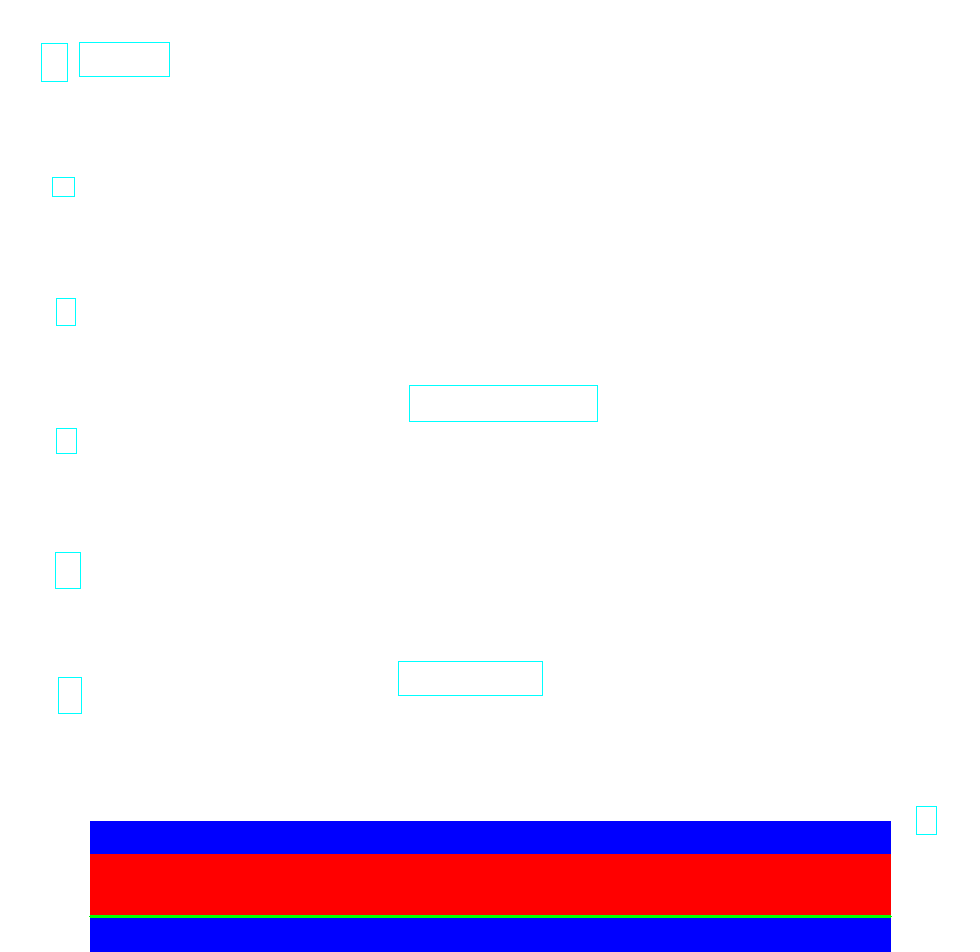

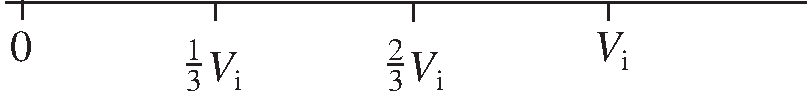

(100, 810, 3)


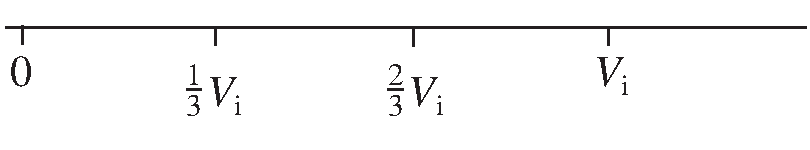

(150, 810, 3)
202
202
202
[{'boundingBox': [7, 84, 6, 64, 37, 63, 38, 84], 'text': 'O'}, {'boundingBox': [6, 43, 6, 41, 37, 40, 37, 43], 'text': '.', 'confidence': 'Low'}, {'boundingBox': [412, 74, 440, 72, 443, 111, 414, 113], 'text': 'Vi', 'confidence': 'Low'}, {'boundingBox': [598, 55, 628, 55, 629, 92, 599, 93], 'text': 'Vi', 'confidence': 'Low'}, {'boundingBox': [386, 117, 387, 73, 406, 73, 405, 116], 'text': 'WIN', 'confidence': 'Low'}]
[{'boundingBox': [7, 59, 6, 39, 37, 38, 38, 59], 'text': 'O'}, {'boundingBox': [6, 18, 6, 16, 37, 15, 37, 18], 'text': '.', 'confidence': 'Low'}, {'boundingBox': [412, 49, 440, 47, 443, 86, 414, 88], 'text': 'Vi', 'confidence': 'Low'}, {'boundingBox': [598, 30, 628, 30, 629, 67, 599, 68], 'text': 'Vi', 'confidence': 'Low'}, {'boundingBox': [386, 92, 387, 48, 406, 48, 405, 91], 'text': 'WIN', 'confidence': 'Low'}]
[{'boundingBox': [92, 880, 91, 860, 122, 859, 123, 880], 'text': 'O'}, {'boundingBox': [91, 839, 91, 837, 122, 836, 122, 839], 'text': '

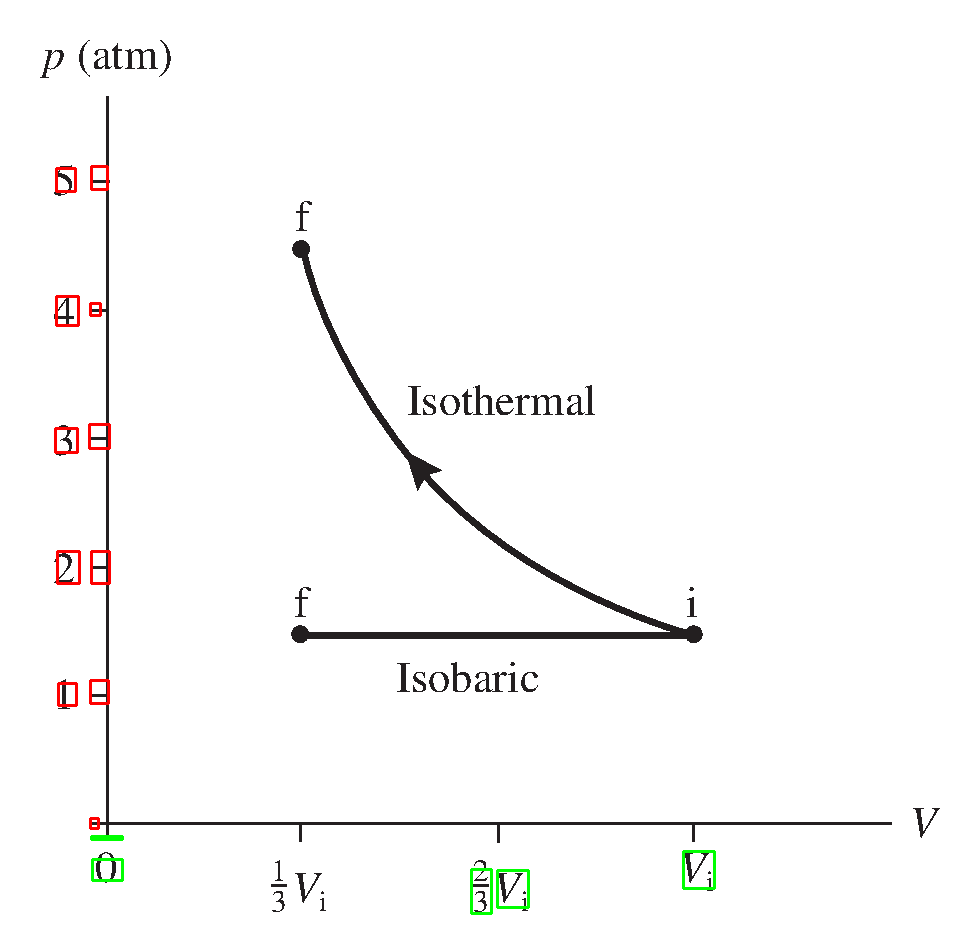

202
202
202
[[[120, 372], [756, 372]], [[120, 566], [756, 566]]] [[[259, 86], [259, 716]], [[615, 86], [615, 716]]]


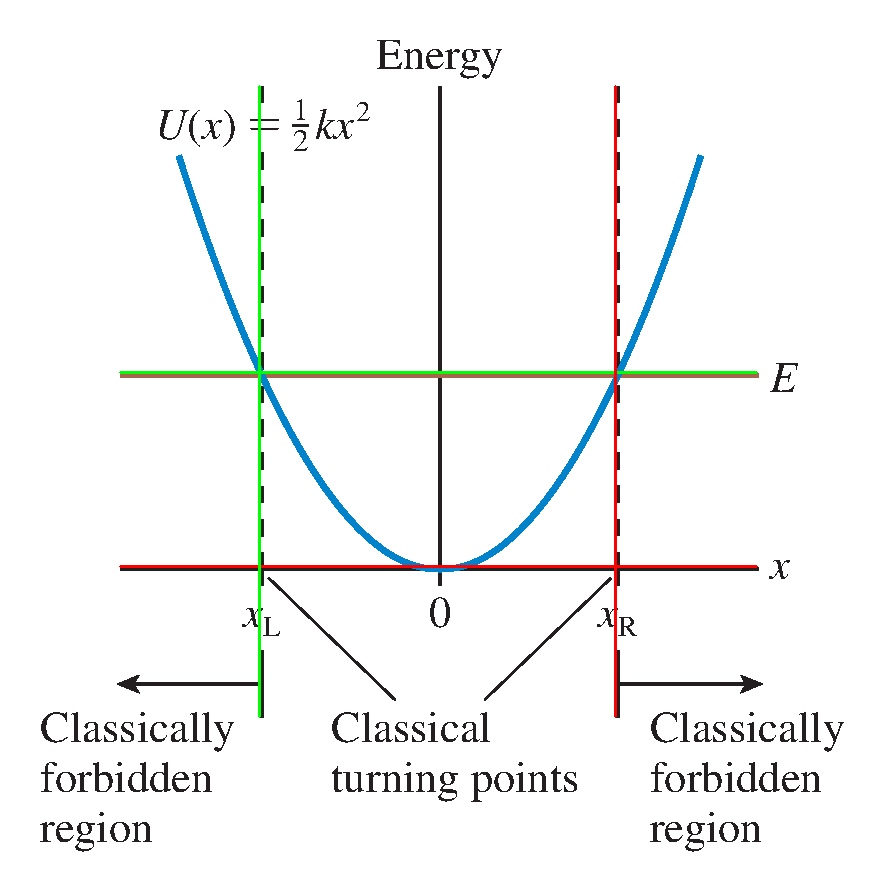

202
202


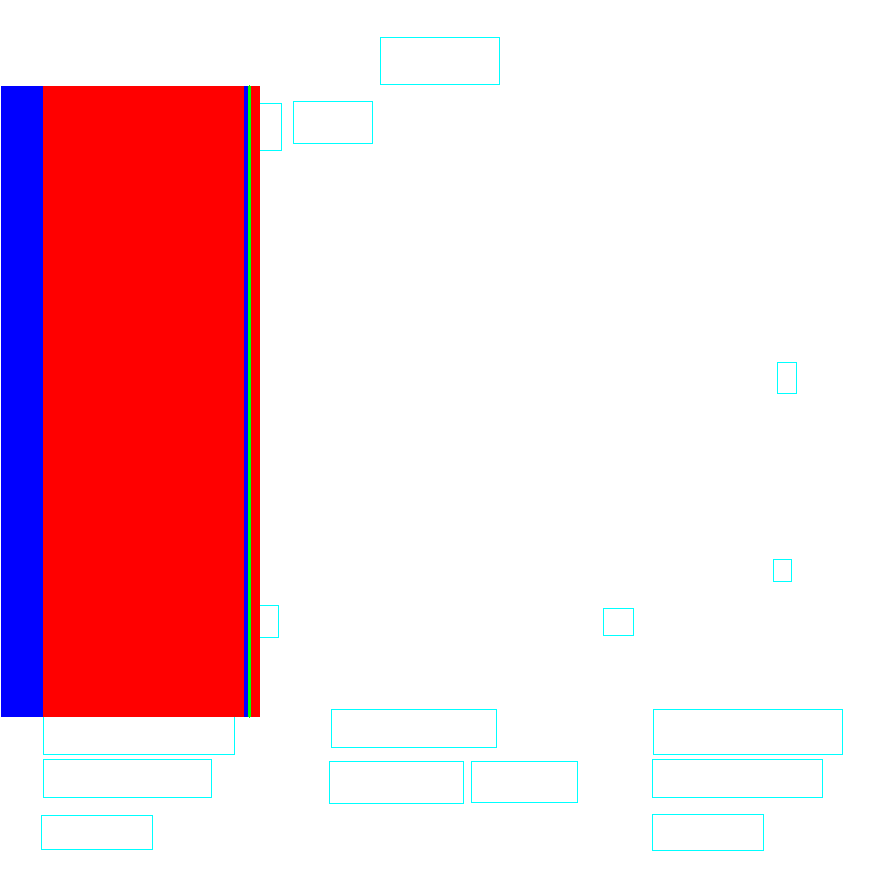

(640, 15, 3)


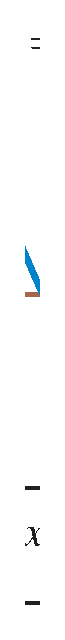

(640, 65, 3)
202
202
[{'boundingBox': [23, 298, 21, 284, 42, 282, 44, 296], 'text': 'L', 'confidence': 'Low'}, {'boundingBox': [28, 527, 42, 526, 43, 546, 30, 547], 'text': 'X'}]
[{'boundingBox': [-2, 298, -4, 284, 17, 282, 19, 296], 'text': 'L', 'confidence': 'Low'}, {'boundingBox': [3, 527, 17, 526, 18, 546, 5, 547], 'text': 'X'}]
[{'boundingBox': [242, 379, 240, 365, 261, 363, 263, 377], 'text': 'L', 'confidence': 'Low'}, {'boundingBox': [247, 608, 261, 607, 262, 627, 249, 628], 'text': 'X'}]


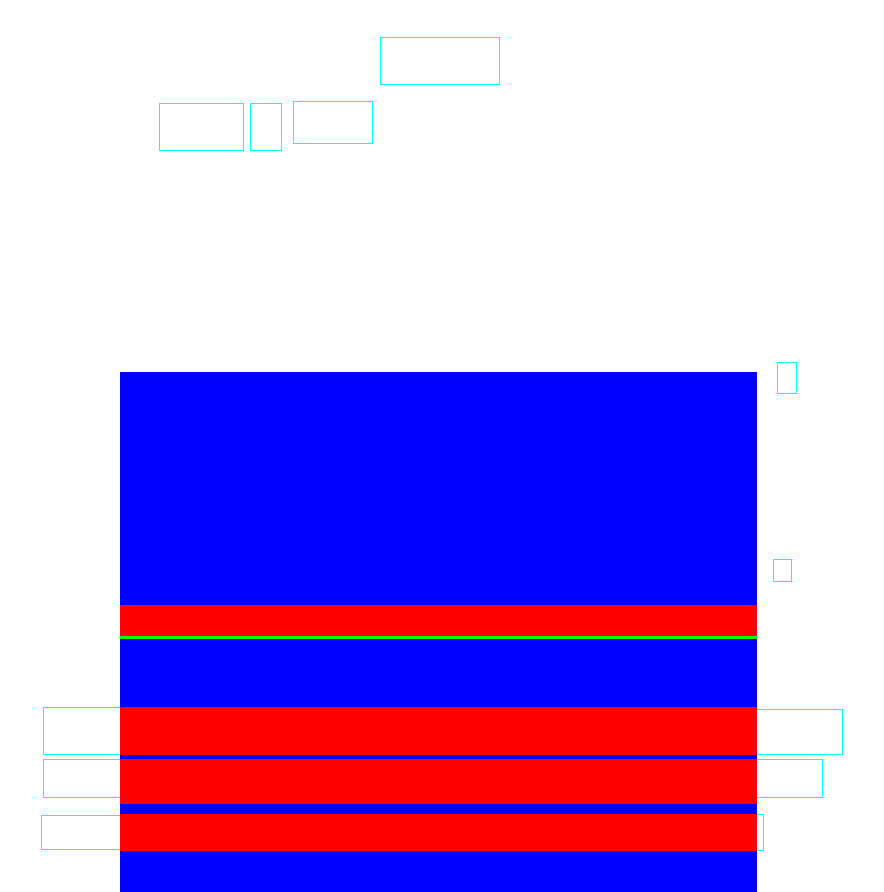

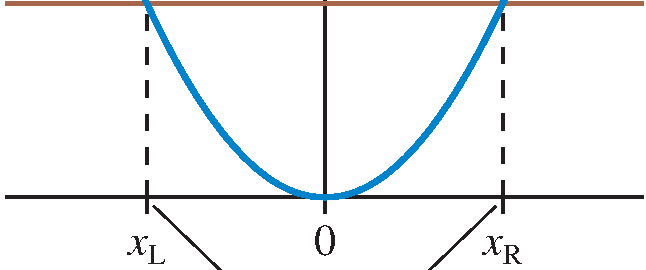

(270, 646, 3)


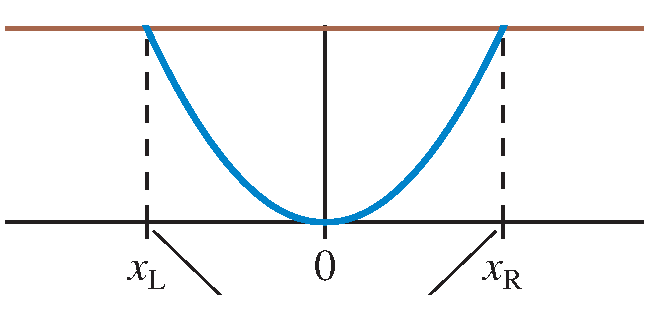

(320, 646, 3)
202
202
[{'boundingBox': [488, 260, 522, 265, 519, 289, 484, 283], 'text': 'XR'}, {'boundingBox': [132, 259, 168, 266, 164, 290, 128, 284], 'text': 'XL'}]
[{'boundingBox': [488, 235, 522, 240, 519, 264, 484, 258], 'text': 'XR'}, {'boundingBox': [132, 234, 168, 241, 164, 265, 128, 259], 'text': 'XL'}]
[{'boundingBox': [603, 607, 637, 612, 634, 636, 599, 630], 'text': 'XR'}, {'boundingBox': [247, 606, 283, 613, 279, 637, 243, 631], 'text': 'XL'}]
[{'boundingBox': [242, 379, 240, 365, 261, 363, 263, 377], 'text': 'L', 'confidence': 'Low'}, {'boundingBox': [247, 608, 261, 607, 262, 627, 249, 628], 'text': 'X'}]
[{'boundingBox': [603, 607, 637, 612, 634, 636, 599, 630], 'text': 'XR'}, {'boundingBox': [247, 606, 283, 613, 279, 637, 243, 631], 'text': 'XL'}]


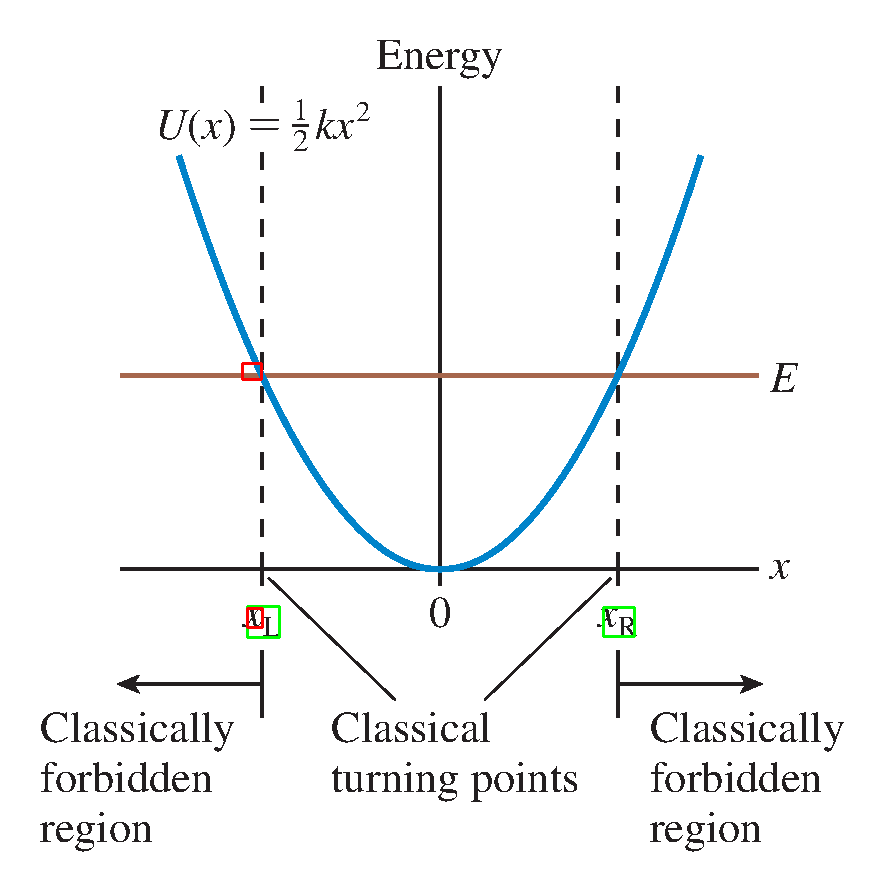

202
202
202
202
[[[69, 418], [513, 418]], [[69, 130], [76, 130]]] [[[78, 81], [78, 430]], [[115, 51], [115, 60]]]


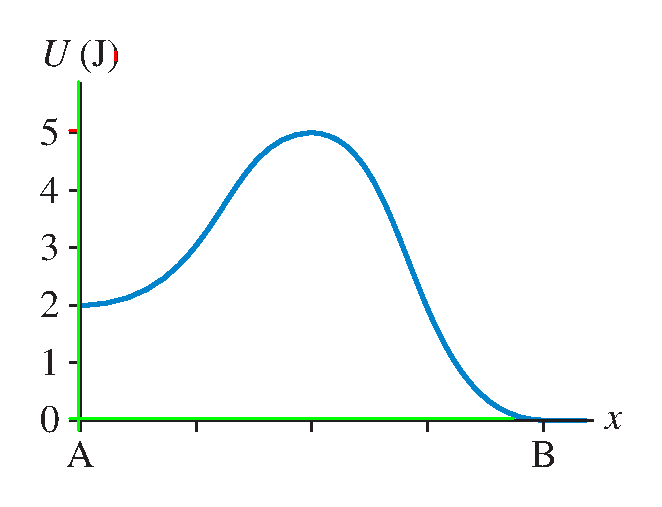

202
202
202


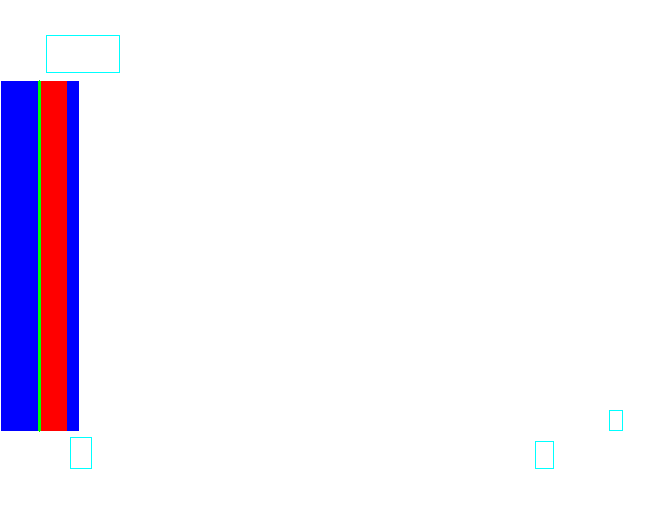

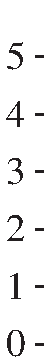

(359, 44, 3)


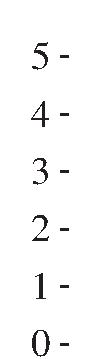

(359, 94, 3)
202
202
[{'boundingBox': [34, 41, 54, 40, 56, 70, 36, 71], 'text': '5'}, {'boundingBox': [60, 39, 64, 39, 66, 69, 62, 69], 'text': '-'}, {'boundingBox': [34, 101, 54, 100, 55, 128, 35, 129], 'text': '4'}, {'boundingBox': [60, 100, 64, 100, 65, 128, 61, 128], 'text': '-'}, {'boundingBox': [33, 155, 52, 154, 53, 185, 34, 186], 'text': '3'}, {'boundingBox': [58, 154, 64, 154, 65, 185, 59, 185], 'text': '-'}, {'boundingBox': [34, 212, 53, 212, 53, 244, 34, 244], 'text': '2'}, {'boundingBox': [59, 212, 64, 212, 64, 244, 60, 244], 'text': '-'}, {'boundingBox': [35, 271, 53, 270, 55, 297, 37, 299], 'text': '1'}, {'boundingBox': [59, 269, 66, 269, 68, 297, 61, 297], 'text': '-'}, {'boundingBox': [32, 326, 51, 326, 51, 355, 32, 355], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [61, 326, 69, 326, 69, 355, 61, 355], 'text': '-'}]
[{'boundingBox': [9, 41, 29, 40, 31, 70, 11, 71], 'text': '5'}, {'boundingBox': [35, 39, 39, 39, 41, 69, 37, 69], 'text': '-'}, {'boundingBox': [9, 1

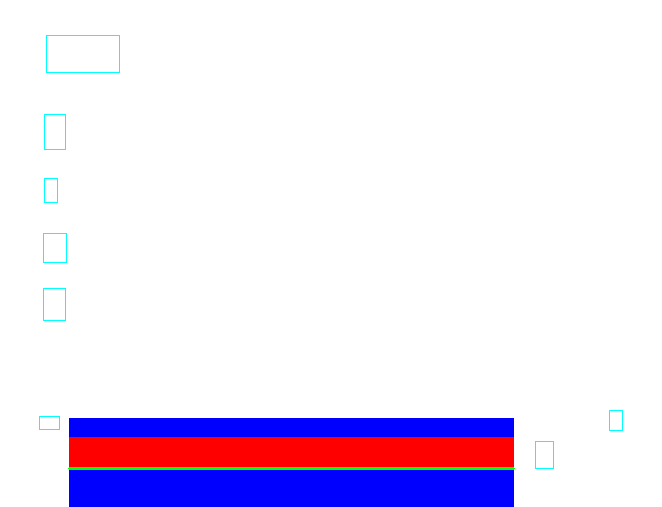

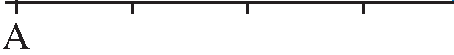

(55, 454, 3)


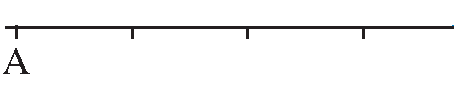

(105, 454, 3)
202
[]
[]
[]
[{'boundingBox': [43, 117, 63, 116, 65, 146, 45, 147], 'text': '5'}, {'boundingBox': [69, 115, 73, 115, 75, 145, 71, 145], 'text': '-'}, {'boundingBox': [43, 177, 63, 176, 64, 204, 44, 205], 'text': '4'}, {'boundingBox': [69, 176, 73, 176, 74, 204, 70, 204], 'text': '-'}, {'boundingBox': [42, 231, 61, 230, 62, 261, 43, 262], 'text': '3'}, {'boundingBox': [67, 230, 73, 230, 74, 261, 68, 261], 'text': '-'}, {'boundingBox': [43, 288, 62, 288, 62, 320, 43, 320], 'text': '2'}, {'boundingBox': [68, 288, 73, 288, 73, 320, 69, 320], 'text': '-'}, {'boundingBox': [44, 347, 62, 346, 64, 373, 46, 375], 'text': '1'}, {'boundingBox': [68, 345, 75, 345, 77, 373, 70, 373], 'text': '-'}, {'boundingBox': [41, 402, 60, 402, 60, 431, 41, 431], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [70, 402, 78, 402, 78, 431, 70, 431], 'text': '-'}]
[]


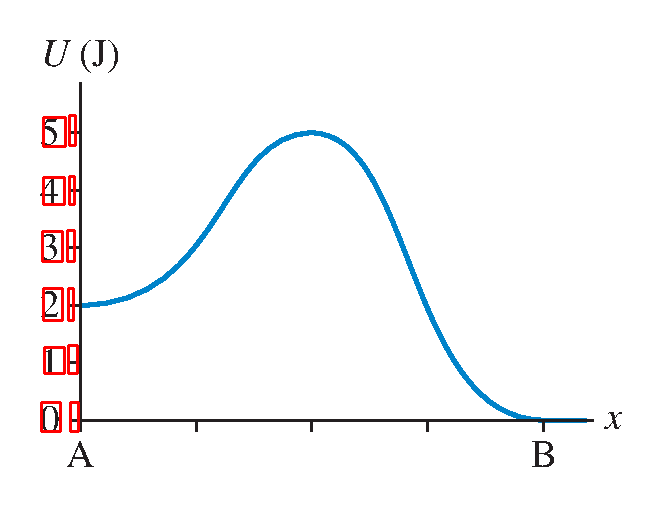

202
202
[[[70, 477], [541, 477]], [[41, 363], [55, 363]]] [[[79, 83], [79, 489]], [[47, 404], [47, 426]]]


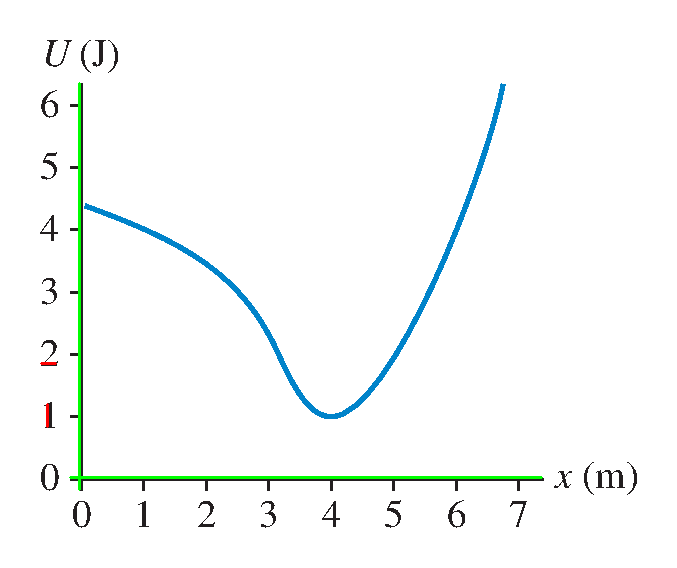

202
202
202


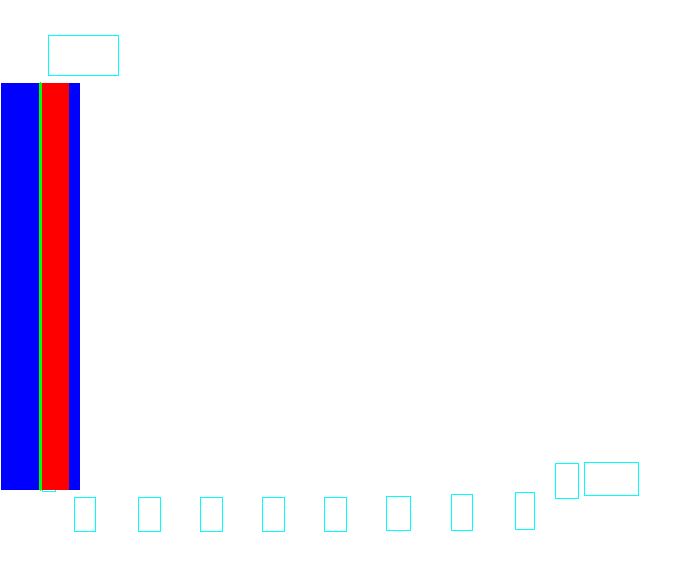

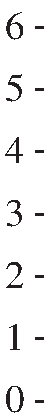

(416, 44, 3)


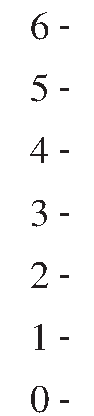

(416, 94, 3)
202
202
[{'boundingBox': [29, 14, 46, 12, 50, 38, 33, 40], 'text': '6'}, {'boundingBox': [57, 10, 65, 9, 69, 35, 61, 36], 'text': '-'}, {'boundingBox': [33, 73, 51, 72, 53, 103, 34, 104], 'text': '5'}, {'boundingBox': [58, 72, 64, 72, 65, 103, 59, 103], 'text': '-'}, {'boundingBox': [33, 135, 54, 135, 54, 164, 33, 164], 'text': '4'}, {'boundingBox': [60, 135, 64, 135, 64, 164, 60, 164], 'text': '-'}, {'boundingBox': [31, 200, 50, 197, 53, 224, 34, 227], 'text': '3'}, {'boundingBox': [57, 197, 66, 196, 69, 223, 60, 224], 'text': '-'}, {'boundingBox': [32, 259, 54, 258, 55, 290, 33, 291], 'text': '2'}, {'boundingBox': [60, 258, 64, 258, 65, 290, 61, 290], 'text': '-'}, {'boundingBox': [33, 319, 54, 318, 55, 353, 34, 354], 'text': '1'}, {'boundingBox': [61, 318, 70, 318, 71, 353, 62, 353], 'text': '-'}, {'boundingBox': [32, 382, 51, 382, 51, 410, 32, 410], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [60, 382, 64, 382, 64, 410, 60, 410], 'text': '-'}]
[{'boundingBox': [

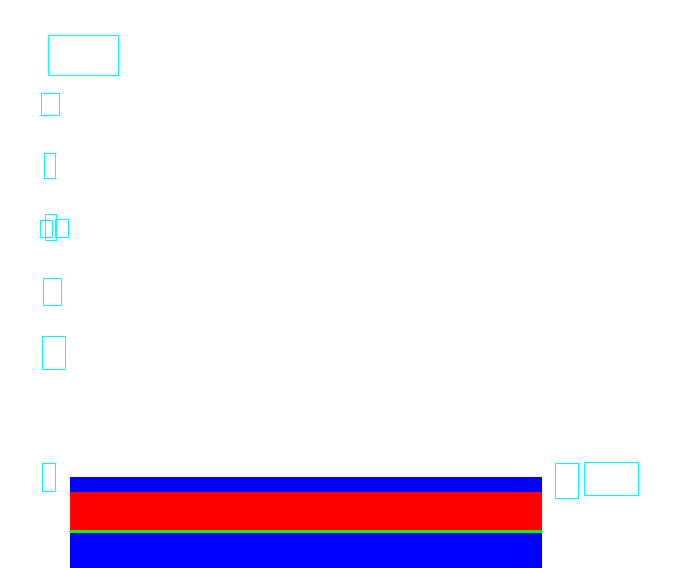

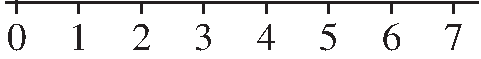

(59, 481, 3)


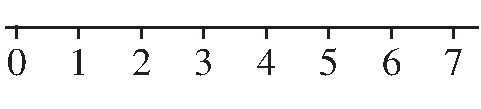

(109, 481, 3)
202
202
[{'boundingBox': [5, 75, 4, 59, 27, 59, 28, 74], 'text': 'O'}, {'boundingBox': [72, 45, 95, 45, 95, 79, 72, 79], 'text': '1'}, {'boundingBox': [134, 45, 156, 46, 157, 80, 134, 80], 'text': '2'}, {'boundingBox': [195, 46, 221, 46, 221, 79, 196, 79], 'text': '3'}, {'boundingBox': [260, 46, 282, 46, 283, 79, 260, 79], 'text': '4'}, {'boundingBox': [321, 46, 347, 46, 347, 79, 322, 79], 'text': '5'}, {'boundingBox': [386, 46, 408, 45, 410, 78, 387, 78], 'text': '6'}, {'boundingBox': [448, 41, 462, 41, 463, 76, 449, 76], 'text': '7'}]
[{'boundingBox': [5, 50, 4, 34, 27, 34, 28, 49], 'text': 'O'}, {'boundingBox': [72, 20, 95, 20, 95, 54, 72, 54], 'text': '1'}, {'boundingBox': [134, 20, 156, 21, 157, 55, 134, 55], 'text': '2'}, {'boundingBox': [195, 21, 221, 21, 221, 54, 196, 54], 'text': '3'}, {'boundingBox': [260, 21, 282, 21, 283, 54, 260, 54], 'text': '4'}, {'boundingBox': [321, 21, 347, 21, 347, 54, 322, 54], 'text': '5'}, {'boundingBox': [386, 21, 408, 20, 410, 53, 

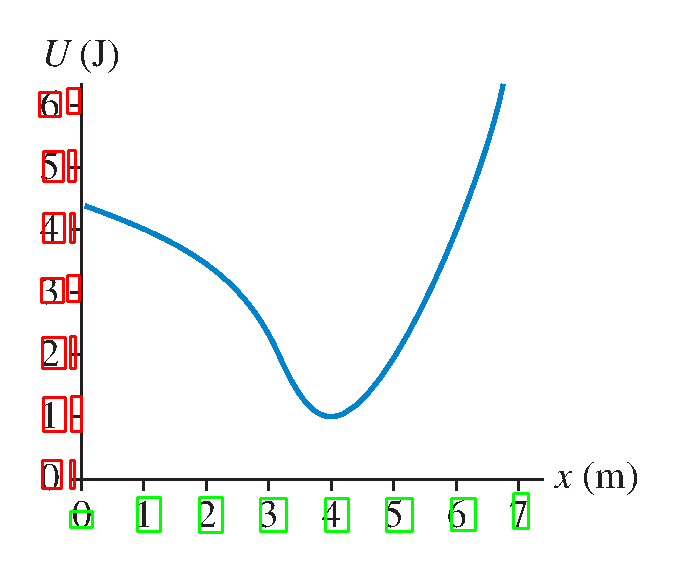

202
202
202
[[[71, 293], [621, 293]], [[88, 128], [616, 128]]] [[[83, 40], [83, 306]], [[145, 298], [145, 306]]]


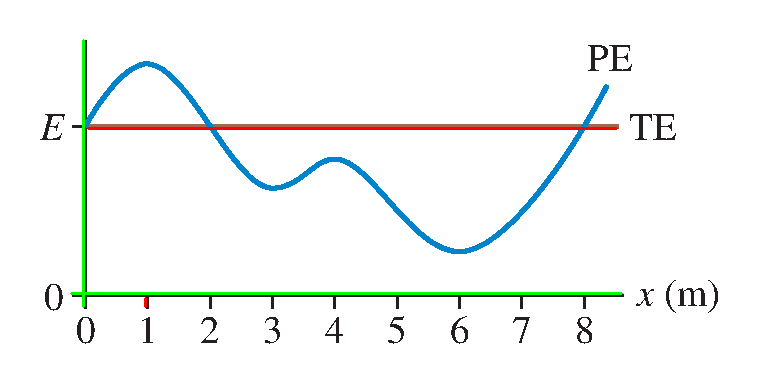

202
202
202


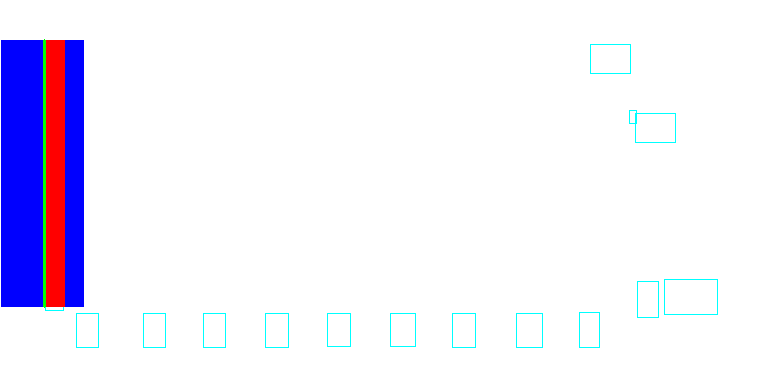

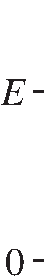

(276, 44, 3)


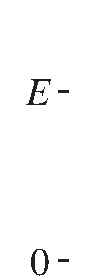

(276, 94, 3)
202
202
[{'boundingBox': [30, 77, 72, 78, 71, 108, 29, 107], 'text': 'E-', 'confidence': 'Low'}, {'boundingBox': [31, 248, 48, 248, 49, 273, 32, 273], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [58, 247, 70, 247, 70, 272, 59, 272], 'text': '-'}]
[{'boundingBox': [5, 77, 47, 78, 46, 108, 4, 107], 'text': 'E-', 'confidence': 'Low'}, {'boundingBox': [6, 248, 23, 248, 24, 273, 7, 273], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [33, 247, 45, 247, 45, 272, 34, 272], 'text': '-'}]
[{'boundingBox': [44, 112, 86, 113, 85, 143, 43, 142], 'text': 'E-', 'confidence': 'Low'}, {'boundingBox': [45, 283, 62, 283, 63, 308, 46, 308], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [72, 282, 84, 282, 84, 307, 73, 307], 'text': '-'}]


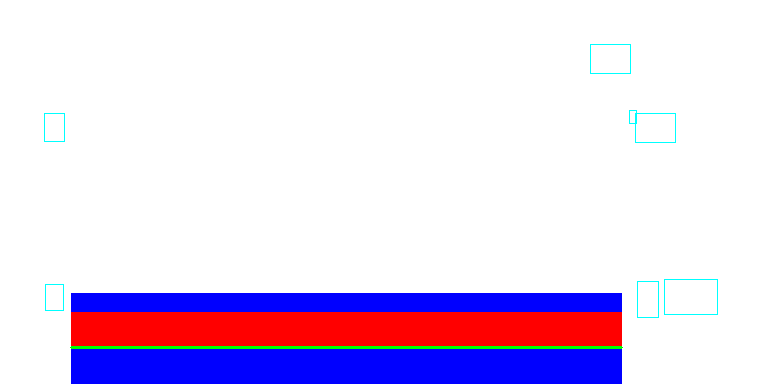

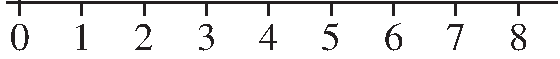

(59, 560, 3)


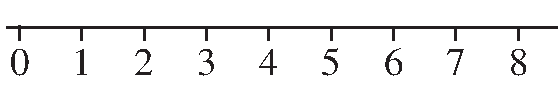

(109, 560, 3)
202
202
[{'boundingBox': [7, 74, 7, 59, 30, 59, 30, 74], 'text': 'O'}, {'boundingBox': [76, 43, 99, 44, 99, 79, 75, 79], 'text': '1'}, {'boundingBox': [136, 44, 159, 44, 159, 79, 136, 79], 'text': '2'}, {'boundingBox': [198, 44, 224, 45, 224, 79, 198, 79], 'text': '3'}, {'boundingBox': [261, 45, 284, 45, 284, 79, 261, 79], 'text': '4'}, {'boundingBox': [323, 45, 349, 45, 349, 79, 323, 79], 'text': '5'}, {'boundingBox': [386, 45, 409, 45, 409, 79, 386, 79], 'text': '6'}, {'boundingBox': [451, 45, 476, 45, 477, 79, 451, 79], 'text': '7'}, {'boundingBox': [513, 44, 529, 44, 530, 78, 514, 78], 'text': '8'}]
[{'boundingBox': [7, 49, 7, 34, 30, 34, 30, 49], 'text': 'O'}, {'boundingBox': [76, 18, 99, 19, 99, 54, 75, 54], 'text': '1'}, {'boundingBox': [136, 19, 159, 19, 159, 54, 136, 54], 'text': '2'}, {'boundingBox': [198, 19, 224, 20, 224, 54, 198, 54], 'text': '3'}, {'boundingBox': [261, 20, 284, 20, 284, 54, 261, 54], 'text': '4'}, {'boundingBox': [323, 20, 349, 20, 349, 54, 

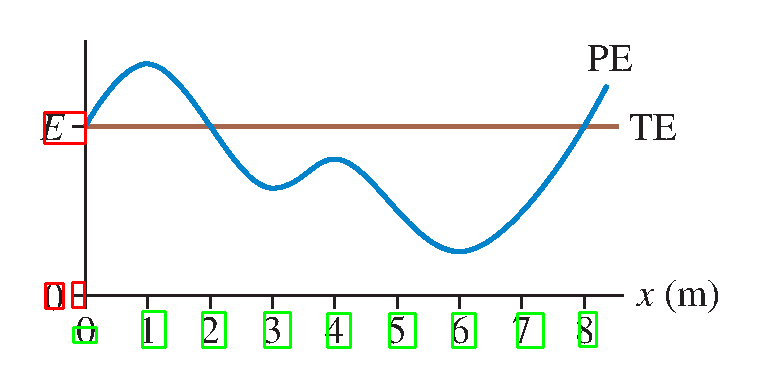

202
202
202
[[[113, 336], [695, 336]], [[136, 108], [470, 108]]] [[[130, 88], [130, 469]], [[467, 116], [467, 444]]]


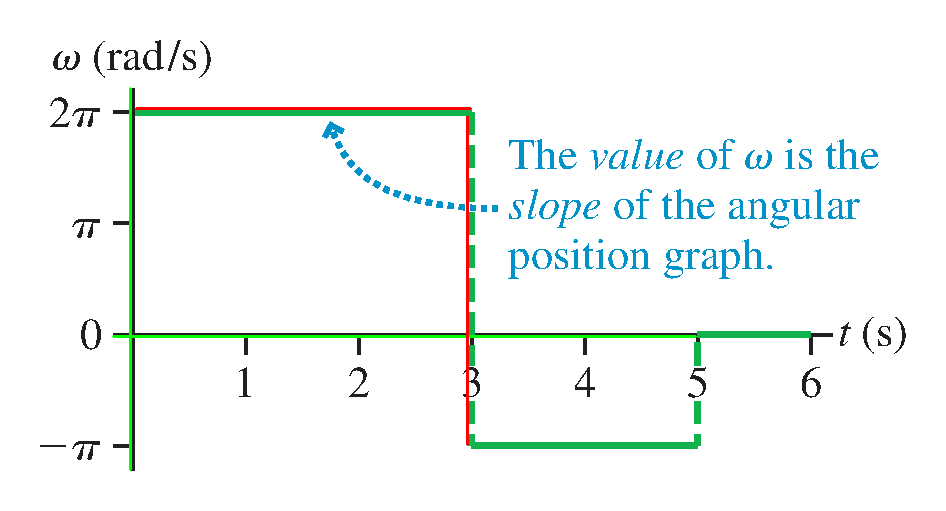

202
202
202


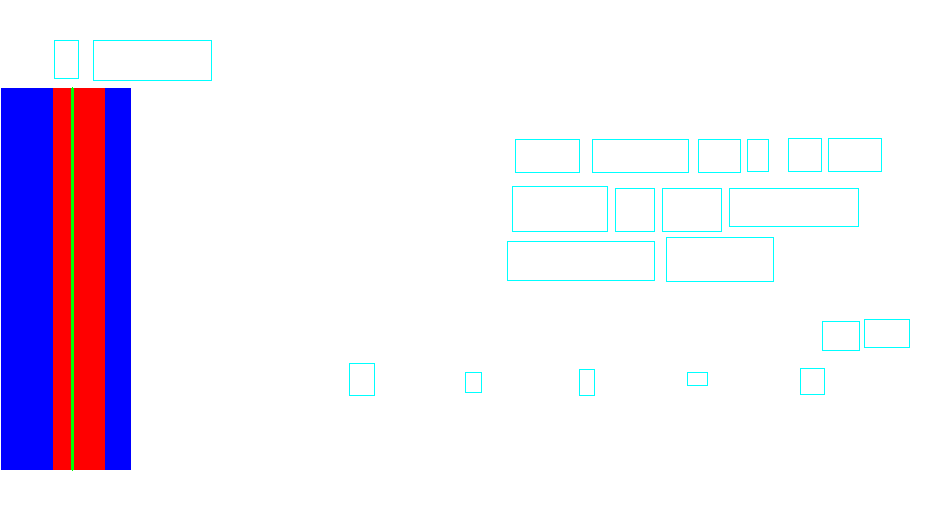

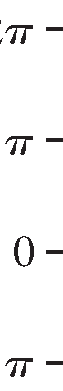

(391, 63, 3)


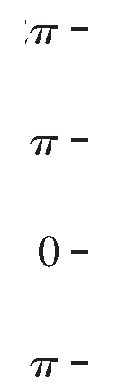

(391, 113, 3)
202
202
[{'boundingBox': [35, 21, 51, 21, 52, 45, 36, 45], 'text': 'T', 'confidence': 'Low'}, {'boundingBox': [71, 20, 87, 20, 87, 44, 71, 44], 'text': '-'}, {'boundingBox': [34, 134, 48, 133, 50, 154, 36, 155], 'text': 'T', 'confidence': 'Low'}, {'boundingBox': [71, 132, 85, 131, 86, 152, 72, 153], 'text': '-', 'confidence': 'Low'}, {'boundingBox': [38, 233, 62, 232, 63, 267, 39, 268], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [71, 232, 90, 231, 91, 266, 72, 267], 'text': '-'}, {'boundingBox': [34, 355, 62, 354, 63, 379, 35, 380], 'text': 'TT', 'confidence': 'Low'}, {'boundingBox': [72, 354, 89, 353, 90, 378, 73, 379], 'text': '-', 'confidence': 'Low'}]
[{'boundingBox': [10, 21, 26, 21, 27, 45, 11, 45], 'text': 'T', 'confidence': 'Low'}, {'boundingBox': [46, 20, 62, 20, 62, 44, 46, 44], 'text': '-'}, {'boundingBox': [9, 134, 23, 133, 25, 154, 11, 155], 'text': 'T', 'confidence': 'Low'}, {'boundingBox': [46, 132, 60, 131, 61, 152, 47, 153], 'text': '-', 'confiden

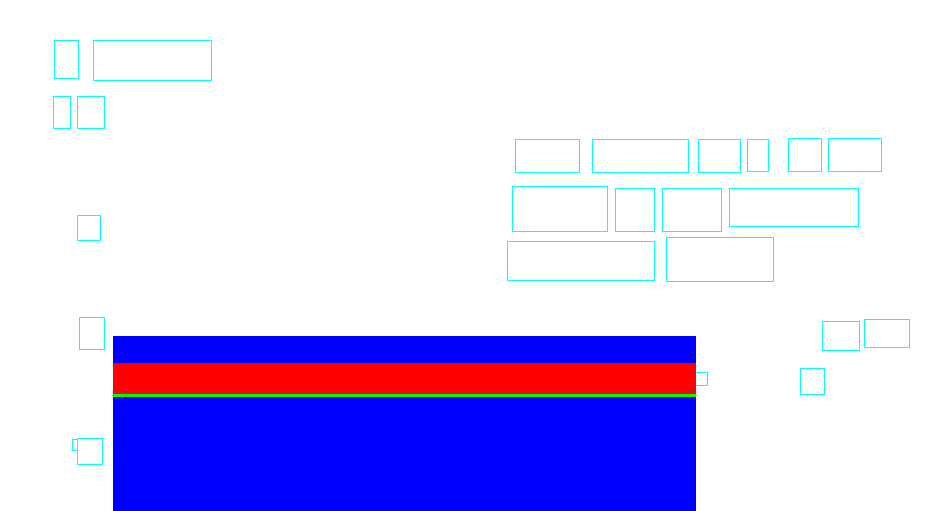

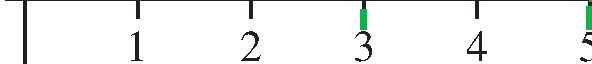

(64, 592, 3)


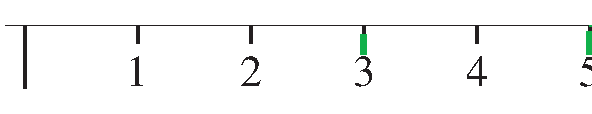

(114, 592, 3)
202
202
[{'boundingBox': [6, 76, 6, 51, 40, 51, 40, 76], 'text': '-'}, {'boundingBox': [242, 52, 259, 51, 262, 84, 244, 85], 'text': '2'}, {'boundingBox': [356, 54, 373, 52, 377, 85, 360, 87], 'text': '3'}, {'boundingBox': [469, 57, 483, 57, 483, 83, 469, 83], 'text': '4'}]
[{'boundingBox': [6, 51, 6, 26, 40, 26, 40, 51], 'text': '-'}, {'boundingBox': [242, 27, 259, 26, 262, 59, 244, 60], 'text': '2'}, {'boundingBox': [356, 29, 373, 27, 377, 60, 360, 62], 'text': '3'}, {'boundingBox': [469, 32, 483, 32, 483, 58, 469, 58], 'text': '4'}]
[{'boundingBox': [114, 387, 114, 362, 148, 362, 148, 387], 'text': '-'}, {'boundingBox': [350, 363, 367, 362, 370, 395, 352, 396], 'text': '2'}, {'boundingBox': [464, 365, 481, 363, 485, 396, 468, 398], 'text': '3'}, {'boundingBox': [577, 368, 591, 368, 591, 394, 577, 394], 'text': '4'}]
[{'boundingBox': [77, 104, 93, 104, 94, 128, 78, 128], 'text': 'T', 'confidence': 'Low'}, {'boundingBox': [113, 103, 129, 103, 129, 127, 113, 127], 'text':

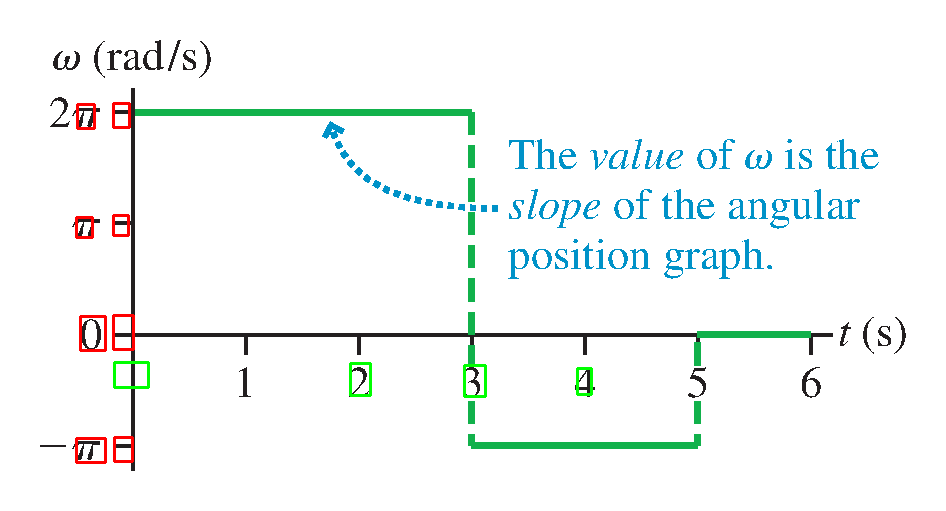

202
202
[[[51, 393], [450, 393]], [[178, 350], [253, 350]]] [[[50, 106], [50, 391]], [[144, 130], [144, 388]]]


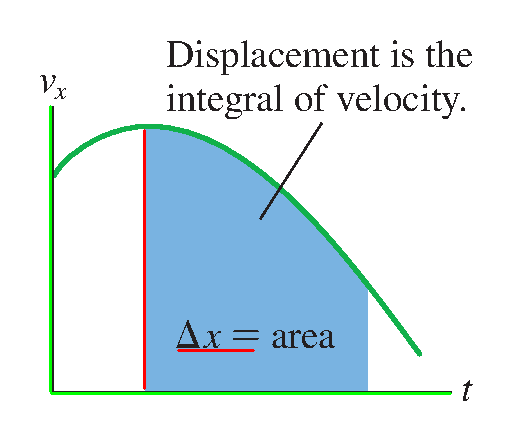

202
202


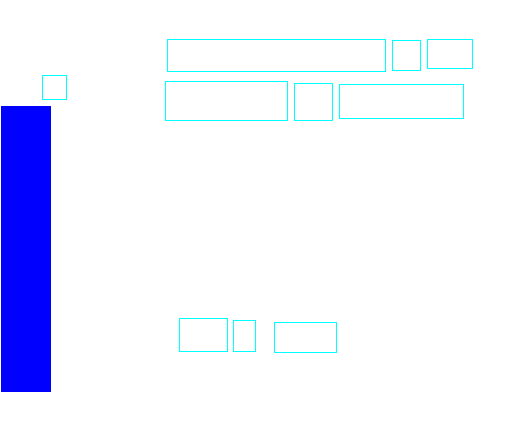

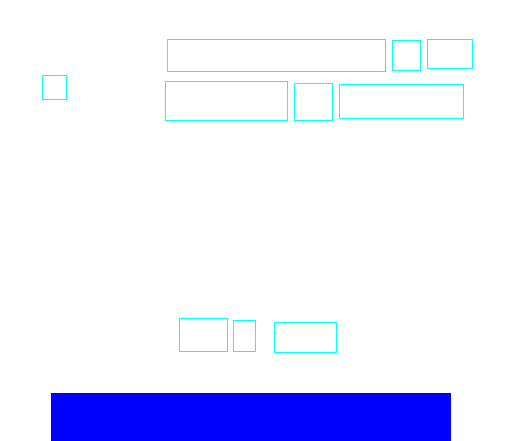

[]
[]


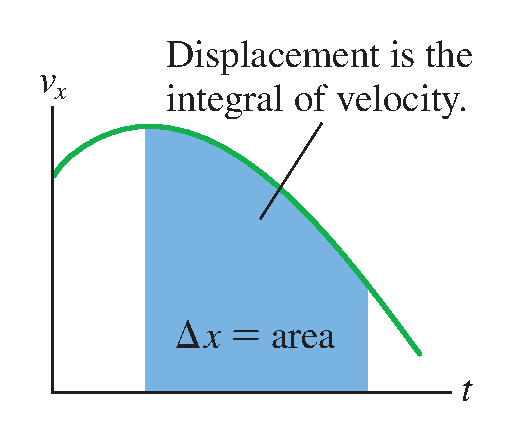

202
202
202
[[[101, 297], [689, 297]], [[120, 135], [330, 135]]] [[[114, 100], [114, 424]], [[221, 303], [221, 314]]]


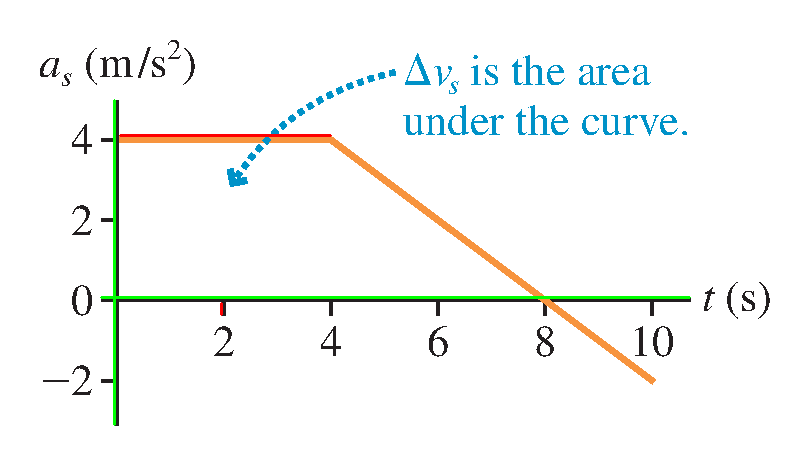

202
202
202


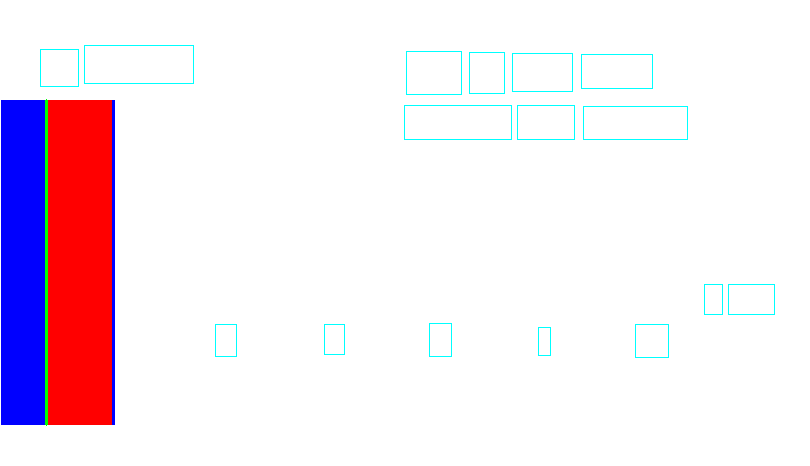

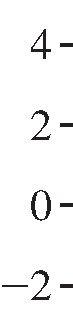

(334, 73, 3)


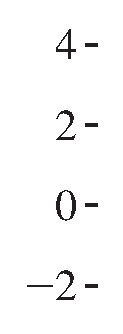

(334, 123, 3)
202
202
202
[{'boundingBox': [58, 30, 96, 31, 95, 61, 57, 60], 'text': '4-'}, {'boundingBox': [57, 111, 79, 109, 81, 139, 59, 141], 'text': '2'}, {'boundingBox': [85, 109, 97, 108, 99, 138, 87, 139], 'text': '-'}, {'boundingBox': [27, 271, 99, 271, 99, 301, 27, 301], 'text': '-2-'}, {'boundingBox': [56, 187, 77, 186, 79, 222, 58, 223], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [85, 185, 89, 185, 91, 221, 86, 221], 'text': '-'}]
[{'boundingBox': [33, 30, 71, 31, 70, 61, 32, 60], 'text': '4-'}, {'boundingBox': [32, 111, 54, 109, 56, 139, 34, 141], 'text': '2'}, {'boundingBox': [60, 109, 72, 108, 74, 138, 62, 139], 'text': '-'}, {'boundingBox': [2, 271, 74, 271, 74, 301, 2, 301], 'text': '-2-'}, {'boundingBox': [31, 187, 52, 186, 54, 222, 33, 223], 'text': '0', 'confidence': 'Low'}, {'boundingBox': [60, 185, 64, 185, 66, 221, 61, 221], 'text': '-'}]
[{'boundingBox': [74, 125, 112, 126, 111, 156, 73, 155], 'text': '4-'}, {'boundingBox': [73, 206, 95, 204, 97, 234, 75

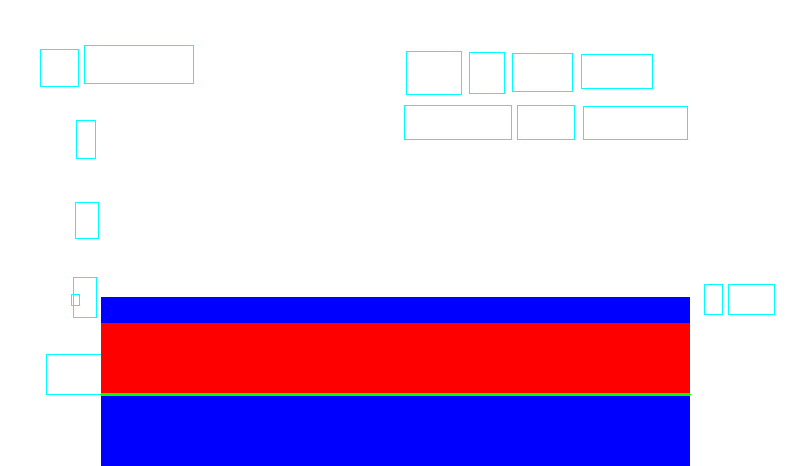

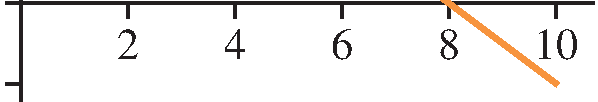

(102, 598, 3)


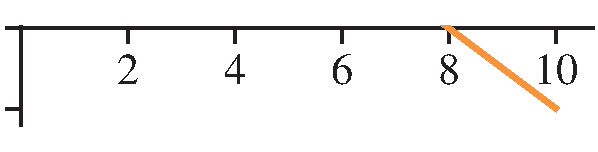

(152, 598, 3)
202
202
[{'boundingBox': [3, 75, 3, 52, 37, 53, 37, 76], 'text': '-'}, {'boundingBox': [120, 50, 140, 49, 141, 82, 122, 83], 'text': '2'}, {'boundingBox': [228, 54, 248, 54, 248, 82, 227, 82], 'text': '4'}, {'boundingBox': [333, 52, 354, 51, 356, 83, 334, 84], 'text': '6'}, {'boundingBox': [442, 56, 455, 55, 458, 80, 444, 81], 'text': '8', 'confidence': 'Low'}, {'boundingBox': [539, 52, 577, 52, 576, 85, 539, 85], 'text': '10'}]
[{'boundingBox': [3, 50, 3, 27, 37, 28, 37, 51], 'text': '-'}, {'boundingBox': [120, 25, 140, 24, 141, 57, 122, 58], 'text': '2'}, {'boundingBox': [228, 29, 248, 29, 248, 57, 227, 57], 'text': '4'}, {'boundingBox': [333, 27, 354, 26, 356, 58, 334, 59], 'text': '6'}, {'boundingBox': [442, 31, 455, 30, 458, 55, 444, 56], 'text': '8', 'confidence': 'Low'}, {'boundingBox': [539, 27, 577, 27, 576, 60, 539, 60], 'text': '10'}]
[{'boundingBox': [99, 347, 99, 324, 133, 325, 133, 348], 'text': '-'}, {'boundingBox': [216, 322, 236, 321, 237, 354, 218, 355],

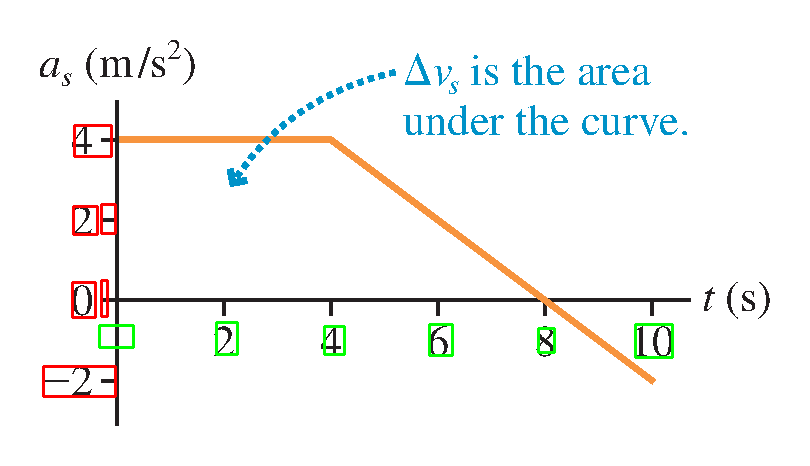

202
202
[[[20, 156], [356, 156]], [[99990, -109], [-10010, -109]]] [[[14, 49], [14, 266]], [[126, 161], [126, 175]]]


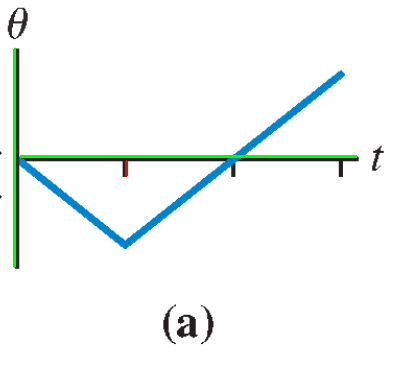

202
202


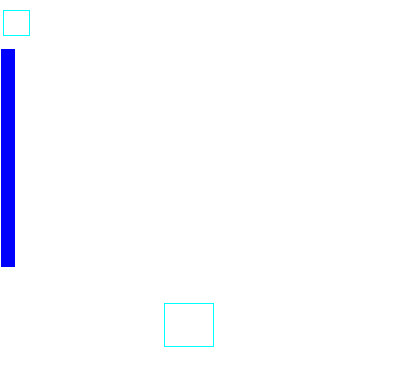

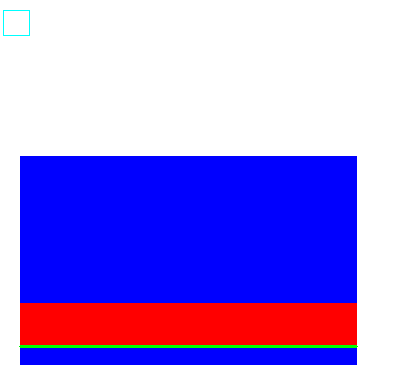

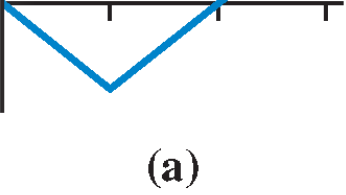

(195, 346, 3)


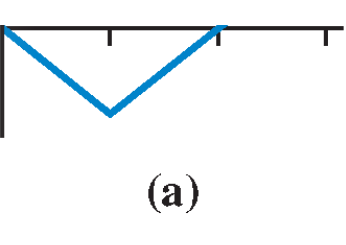

(245, 346, 3)
202
202
[{'boundingBox': [148, 173, 196, 172, 196, 214, 149, 215], 'text': '(a)'}]
[{'boundingBox': [148, 148, 196, 147, 196, 189, 149, 190], 'text': '(a)'}]
[{'boundingBox': [163, 304, 211, 303, 211, 345, 164, 346], 'text': '(a)'}]
[]
[{'boundingBox': [163, 304, 211, 303, 211, 345, 164, 346], 'text': '(a)'}]


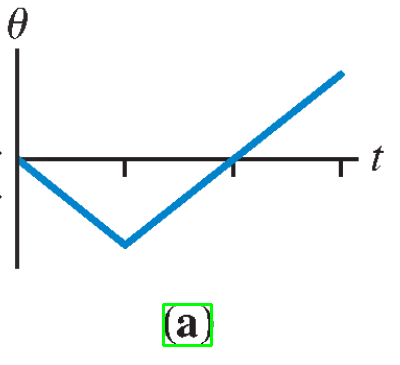

202
202
[[[80, 75], [503, 75]], [[80, 123], [503, 123]]] [[[92, 43], [92, 385]], [[136, 61], [136, 379]]]


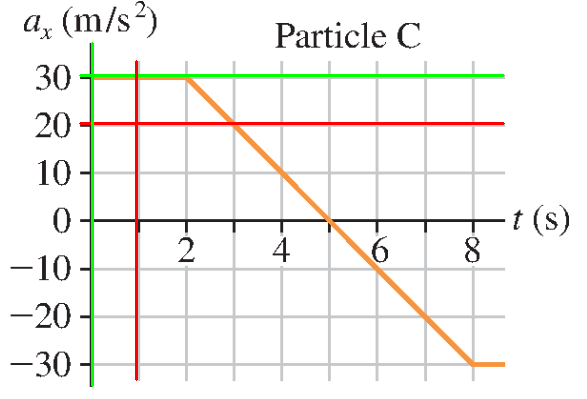

202
202


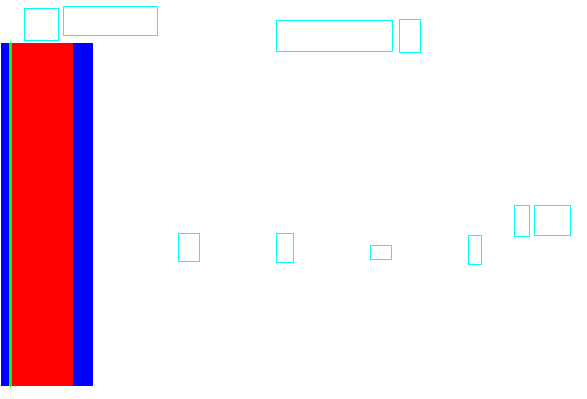

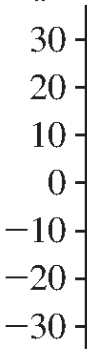

(352, 87, 3)


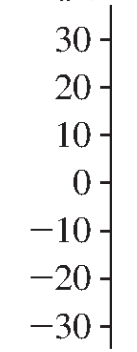

(352, 137, 3)
202
202
[{'boundingBox': [57, 24, 90, 24, 91, 52, 58, 53], 'text': '30'}, {'boundingBox': [100, 24, 115, 24, 115, 51, 100, 51], 'text': '-'}, {'boundingBox': [58, 74, 86, 73, 87, 100, 59, 101], 'text': '20'}, {'boundingBox': [58, 120, 89, 120, 89, 149, 58, 149], 'text': '10'}, {'boundingBox': [73, 168, 108, 167, 109, 195, 74, 196], 'text': '0-', 'confidence': 'Low'}, {'boundingBox': [31, 216, 93, 216, 93, 246, 31, 246], 'text': '-10'}, {'boundingBox': [31, 262, 93, 263, 93, 293, 31, 292], 'text': '-20'}, {'boundingBox': [32, 310, 94, 312, 94, 343, 32, 341], 'text': '-30'}, {'boundingBox': [100, 312, 115, 312, 114, 343, 100, 343], 'text': '-'}]
[{'boundingBox': [32, 24, 65, 24, 66, 52, 33, 53], 'text': '30'}, {'boundingBox': [75, 24, 90, 24, 90, 51, 75, 51], 'text': '-'}, {'boundingBox': [33, 74, 61, 73, 62, 100, 34, 101], 'text': '20'}, {'boundingBox': [33, 120, 64, 120, 64, 149, 33, 149], 'text': '10'}, {'boundingBox': [48, 168, 83, 167, 84, 195, 49, 196], 'text': '0-', 

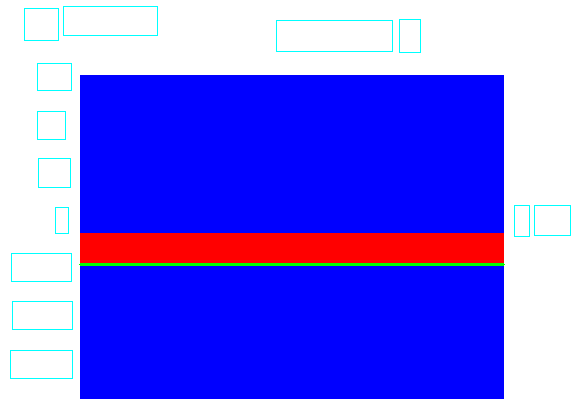

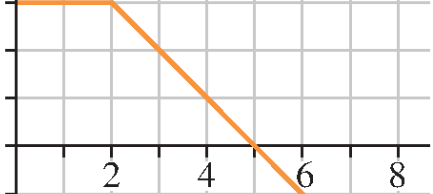

(194, 433, 3)


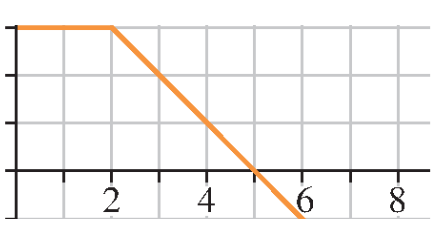

(244, 433, 3)
202
202
[{'boundingBox': [105, 187, 119, 186, 120, 210, 106, 211], 'text': '2'}, {'boundingBox': [199, 187, 214, 187, 215, 211, 200, 211], 'text': '4'}, {'boundingBox': [297, 187, 310, 186, 311, 210, 299, 211], 'text': '6'}]
[{'boundingBox': [105, 162, 119, 161, 120, 185, 106, 186], 'text': '2'}, {'boundingBox': [199, 162, 214, 162, 215, 186, 200, 186], 'text': '4'}, {'boundingBox': [297, 162, 310, 161, 311, 185, 299, 186], 'text': '6'}]
[{'boundingBox': [180, 237, 194, 236, 195, 260, 181, 261], 'text': '2'}, {'boundingBox': [274, 237, 289, 237, 290, 261, 275, 261], 'text': '4'}, {'boundingBox': [372, 237, 385, 236, 386, 260, 374, 261], 'text': '6'}]
[{'boundingBox': [37, 62, 70, 62, 71, 90, 38, 91], 'text': '30'}, {'boundingBox': [80, 62, 95, 62, 95, 89, 80, 89], 'text': '-'}, {'boundingBox': [38, 112, 66, 111, 67, 138, 39, 139], 'text': '20'}, {'boundingBox': [38, 158, 69, 158, 69, 187, 38, 187], 'text': '10'}, {'boundingBox': [53, 206, 88, 205, 89, 233, 54, 234], 'text

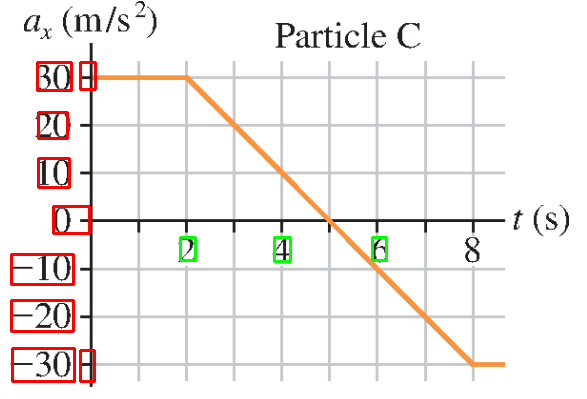

202
202
[[[14, 131], [333, 131]], [[99990, -109], [-10010, -109]]] [[[54, 26], [54, 309]], [[139, 149], [139, 161]]]


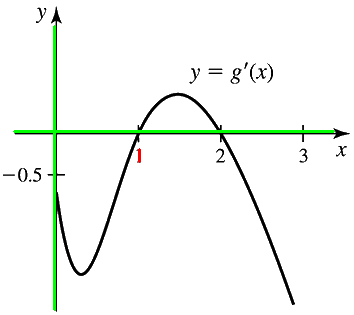

202
202
202


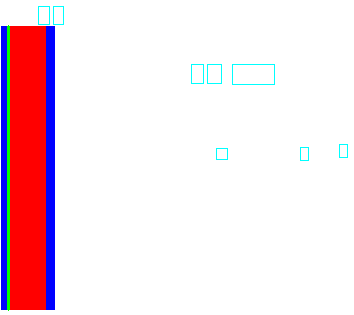

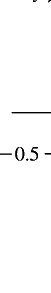

(293, 51, 3)


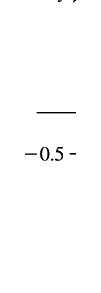

(293, 101, 3)
202
202
[{'boundingBox': [25, 147, 66, 146, 66, 161, 24, 162], 'text': '-0.5'}, {'boundingBox': [70, 146, 76, 146, 76, 161, 70, 161], 'text': '-'}]
[{'boundingBox': [0, 147, 41, 146, 41, 161, -1, 162], 'text': '-0.5'}, {'boundingBox': [45, 146, 51, 146, 51, 161, 45, 161], 'text': '-'}]
[{'boundingBox': [3, 168, 44, 167, 44, 182, 2, 183], 'text': '-0.5'}, {'boundingBox': [48, 167, 54, 167, 54, 182, 48, 182], 'text': '-'}]


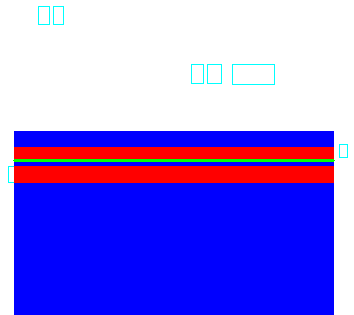

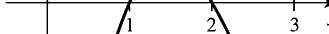

(34, 329, 3)


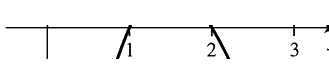

(84, 329, 3)
202
202
[{'boundingBox': [206, 37, 223, 36, 224, 59, 207, 60], 'text': '2'}, {'boundingBox': [290, 41, 300, 39, 302, 57, 293, 58], 'text': '3'}]
[{'boundingBox': [206, 12, 223, 11, 224, 34, 207, 35], 'text': '2'}, {'boundingBox': [290, 16, 300, 14, 302, 32, 293, 33], 'text': '3'}]
[{'boundingBox': [215, 143, 232, 142, 233, 165, 216, 166], 'text': '2'}, {'boundingBox': [299, 147, 309, 145, 311, 163, 302, 164], 'text': '3'}]
[{'boundingBox': [3, 168, 44, 167, 44, 182, 2, 183], 'text': '-0.5'}, {'boundingBox': [48, 167, 54, 167, 54, 182, 48, 182], 'text': '-'}]
[{'boundingBox': [215, 143, 232, 142, 233, 165, 216, 166], 'text': '2'}, {'boundingBox': [299, 147, 309, 145, 311, 163, 302, 164], 'text': '3'}]


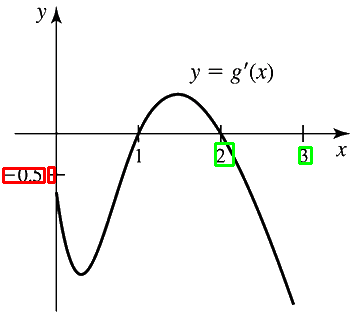

202
202
202
[[[141, 294], [424, 294]], [[313, 90], [323, 90]]] [[[218, 78], [218, 514]], [[199, 250], [199, 343]]]


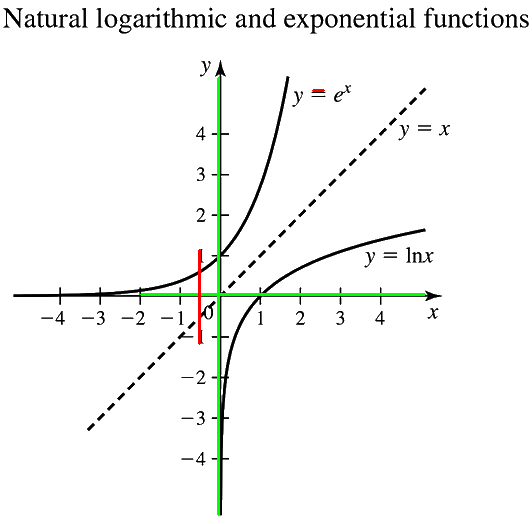

202
202
202


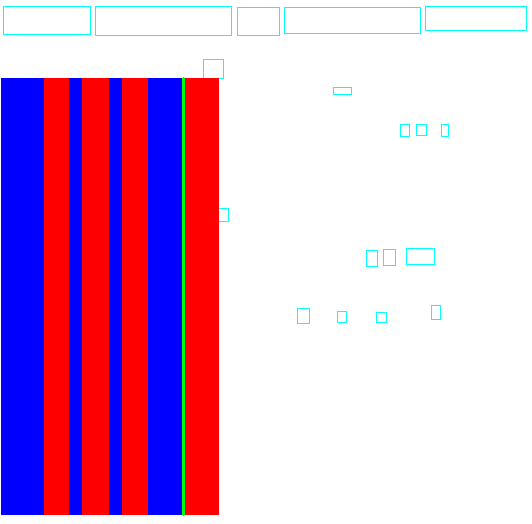

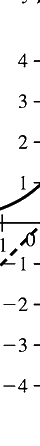

(446, 40, 3)


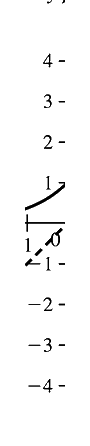

(446, 90, 3)
202
202
[{'boundingBox': [44, 52, 56, 52, 56, 68, 44, 68], 'text': '4'}, {'boundingBox': [59, 52, 62, 52, 62, 68, 59, 68], 'text': '-'}, {'boundingBox': [29, 149, 29, 127, 63, 127, 63, 150], 'text': 'N'}, {'boundingBox': [30, 109, 30, 86, 64, 86, 64, 109], 'text': 'w'}, {'boundingBox': [44, 295, 55, 295, 55, 312, 44, 312], 'text': '2'}, {'boundingBox': [58, 295, 65, 295, 65, 312, 58, 312], 'text': '-'}, {'boundingBox': [29, 337, 54, 336, 54, 350, 29, 351], 'text': '-3', 'confidence': 'Low'}, {'boundingBox': [58, 336, 64, 336, 64, 350, 59, 350], 'text': '-'}, {'boundingBox': [31, 380, 53, 380, 53, 392, 31, 392], 'text': '-4'}, {'boundingBox': [59, 380, 65, 380, 65, 392, 59, 392], 'text': '-'}]
[{'boundingBox': [19, 52, 31, 52, 31, 68, 19, 68], 'text': '4'}, {'boundingBox': [34, 52, 37, 52, 37, 68, 34, 68], 'text': '-'}, {'boundingBox': [4, 149, 4, 127, 38, 127, 38, 150], 'text': 'N'}, {'boundingBox': [5, 109, 5, 86, 39, 86, 39, 109], 'text': 'w'}, {'boundingBox': [19, 295, 

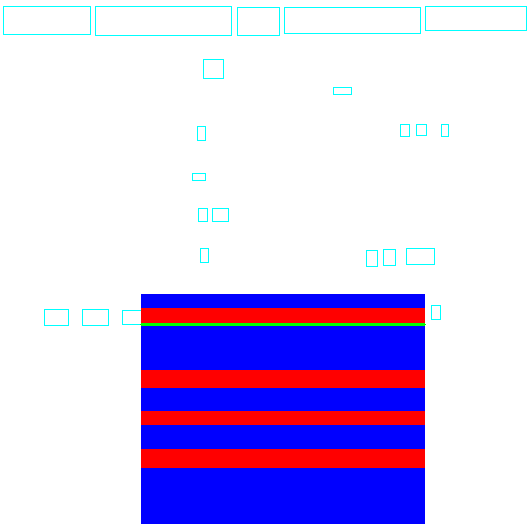

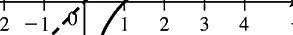

(35, 293, 3)


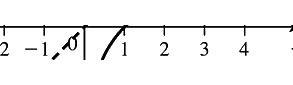

(85, 293, 3)
202
202
[{'boundingBox': [0, 35, 18, 33, 18, 60, 0, 60], 'text': '2'}, {'boundingBox': [26, 32, 83, 28, 83, 57, 26, 60], 'text': '-1,0', 'confidence': 'Low'}, {'boundingBox': [161, 32, 172, 32, 173, 56, 161, 56], 'text': '2'}, {'boundingBox': [200, 36, 212, 35, 213, 56, 201, 57], 'text': '3'}, {'boundingBox': [241, 38, 252, 39, 251, 59, 240, 58], 'text': '4'}]
[{'boundingBox': [0, 10, 18, 8, 18, 35, 0, 35], 'text': '2'}, {'boundingBox': [26, 7, 83, 3, 83, 32, 26, 35], 'text': '-1,0', 'confidence': 'Low'}, {'boundingBox': [161, 7, 172, 7, 173, 31, 161, 31], 'text': '2'}, {'boundingBox': [200, 11, 212, 10, 213, 31, 201, 32], 'text': '3'}, {'boundingBox': [241, 13, 252, 14, 251, 34, 240, 33], 'text': '4'}]
[{'boundingBox': [136, 304, 154, 302, 154, 329, 136, 329], 'text': '2'}, {'boundingBox': [162, 301, 219, 297, 219, 326, 162, 329], 'text': '-1,0', 'confidence': 'Low'}, {'boundingBox': [297, 301, 308, 301, 309, 325, 297, 325], 'text': '2'}, {'boundingBox': [336, 305, 348, 3

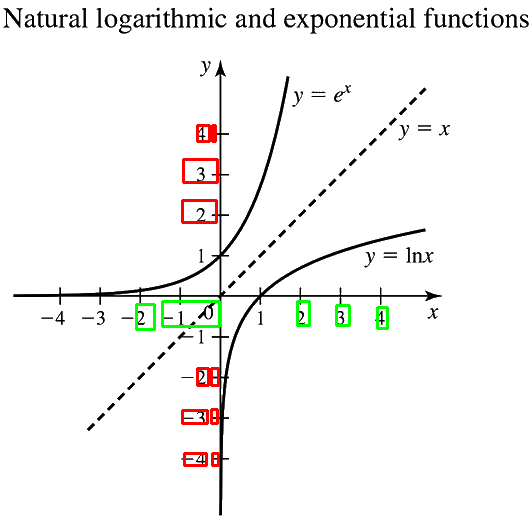

202
202
202
[[[144, 876], [1245, 876]], [[359, 322], [1414, 322]]] [[[143, 124], [143, 875]], [[244, 64], [244, 100]]]


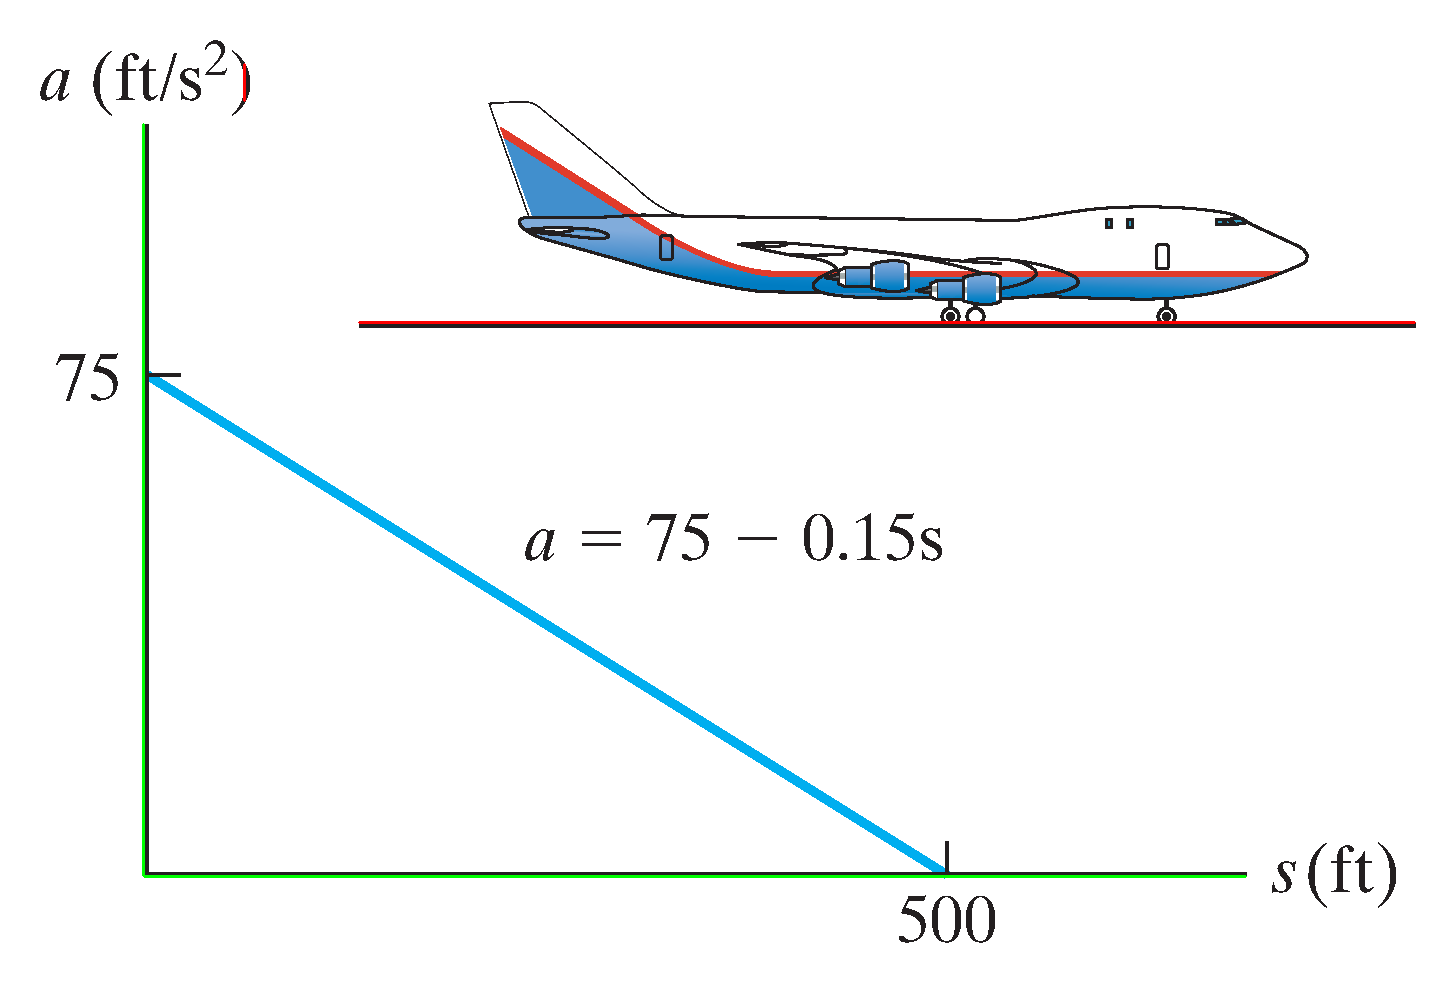

202
202
202


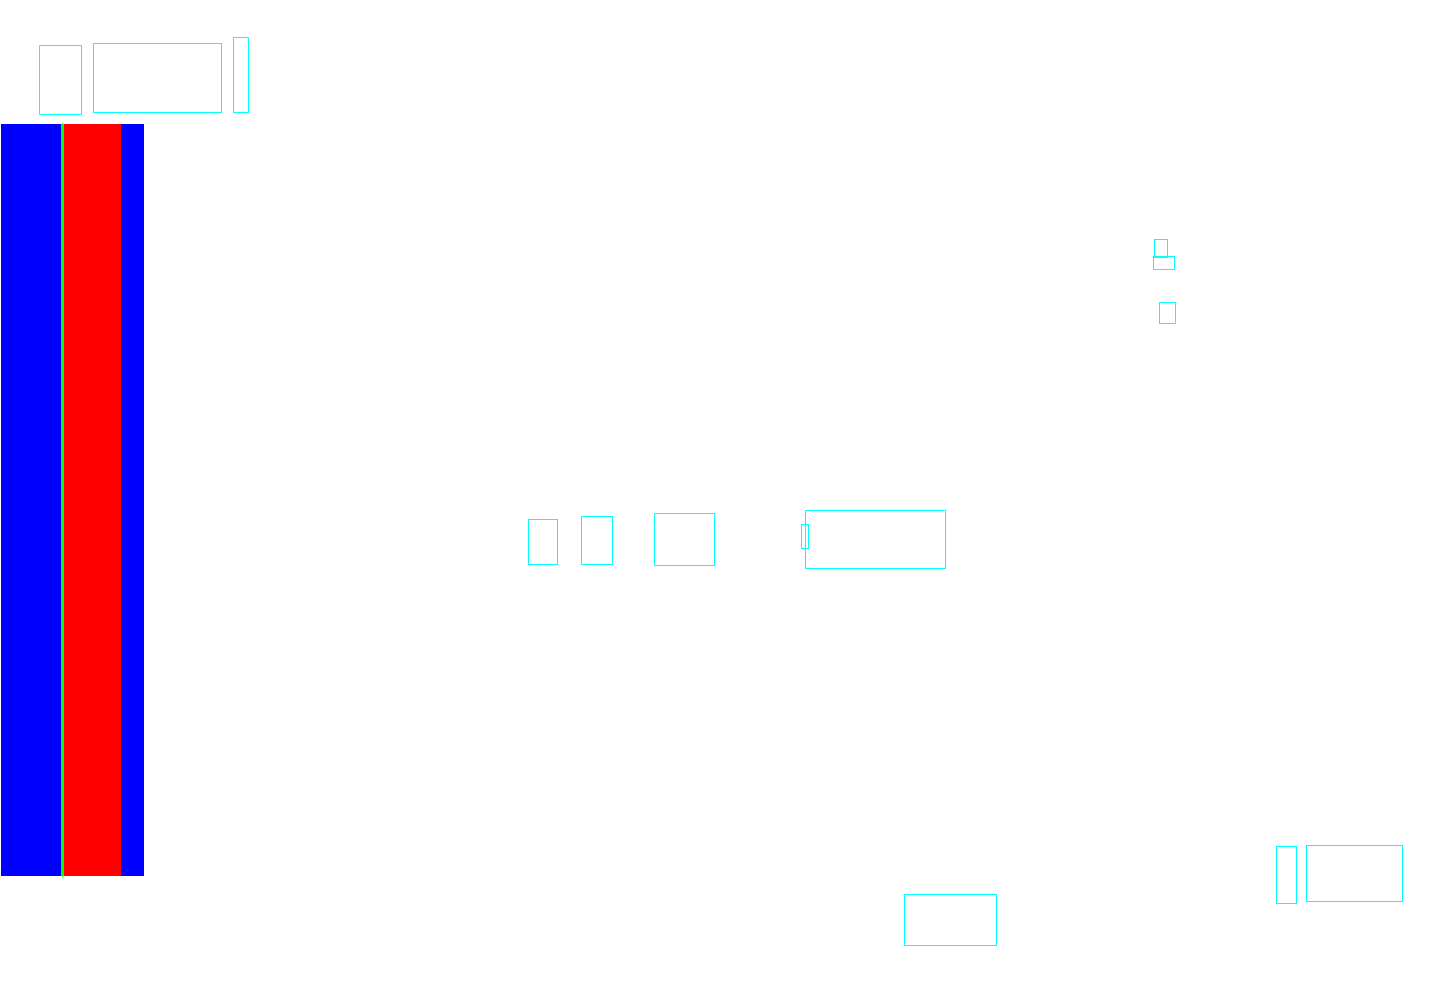

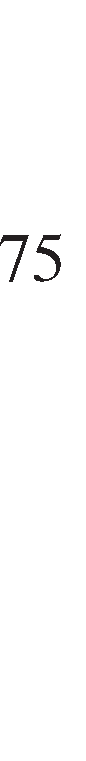

(761, 86, 3)


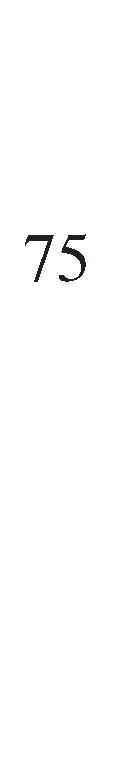

(761, 136, 3)
202
202
[{'boundingBox': [32, 233, 84, 235, 82, 287, 30, 285], 'text': '75'}]
[{'boundingBox': [7, 233, 59, 235, 57, 287, 5, 285], 'text': '75'}]
[{'boundingBox': [64, 352, 116, 354, 114, 406, 62, 404], 'text': '75'}]


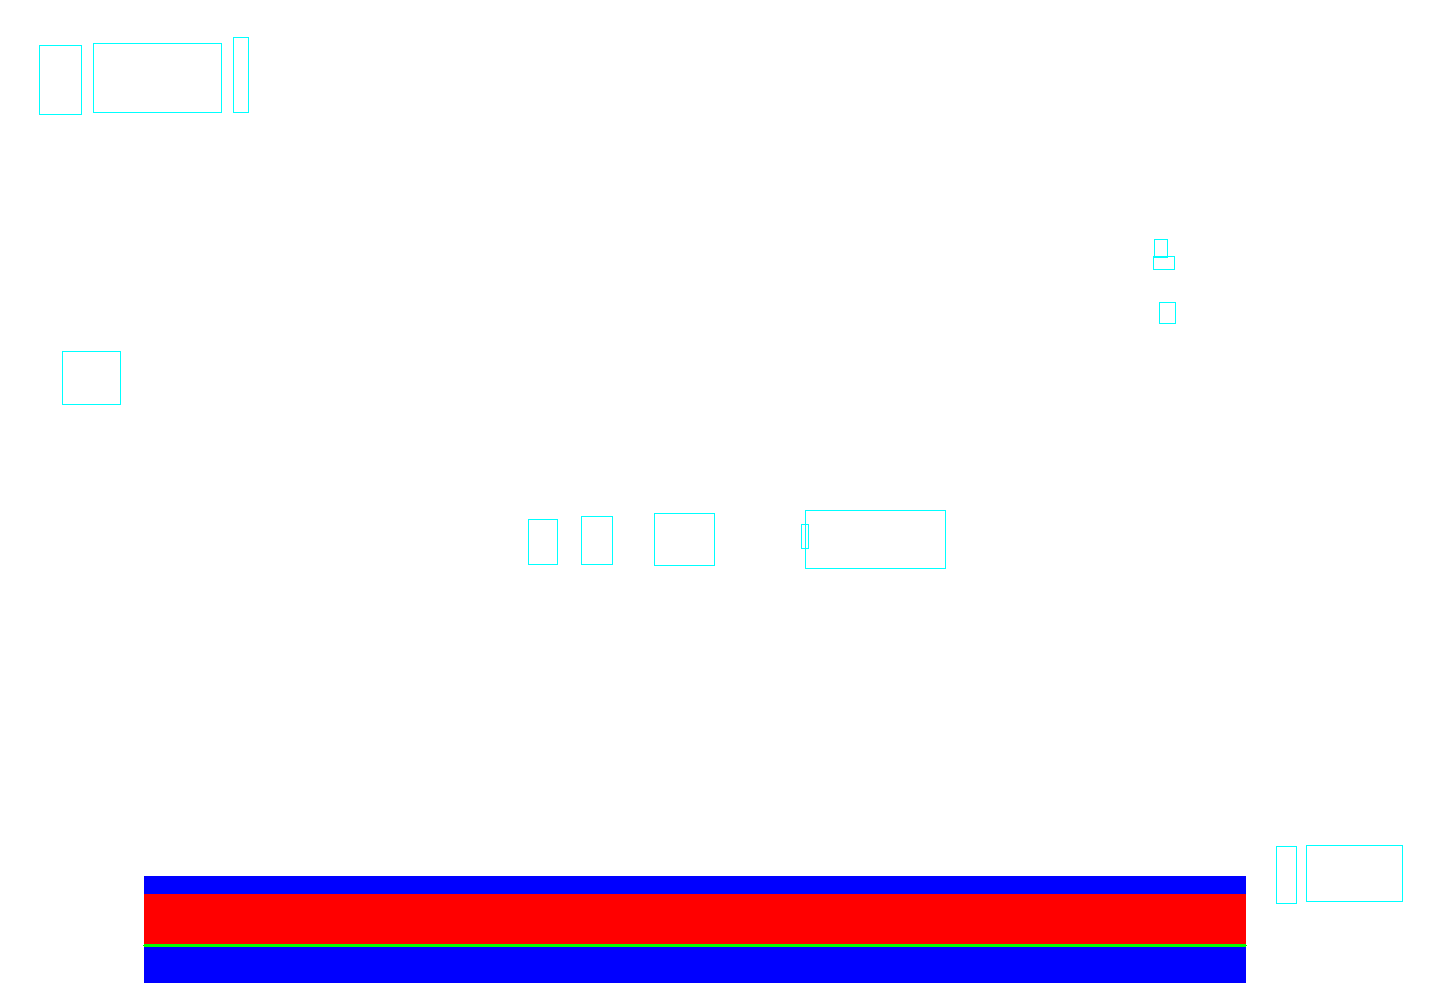

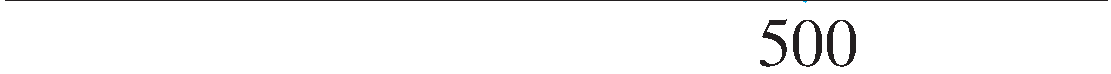

(74, 1111, 3)


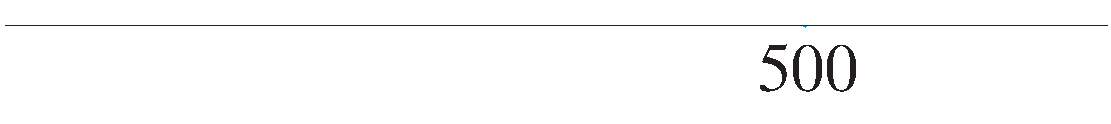

(124, 1111, 3)
202
202
[{'boundingBox': [763, 42, 858, 41, 858, 94, 763, 95], 'text': '500'}]
[{'boundingBox': [763, 17, 858, 16, 858, 69, 763, 70], 'text': '500'}]
[{'boundingBox': [902, 893, 997, 892, 997, 945, 902, 946], 'text': '500'}]
[{'boundingBox': [64, 352, 116, 354, 114, 406, 62, 404], 'text': '75'}]
[{'boundingBox': [902, 893, 997, 892, 997, 945, 902, 946], 'text': '500'}]


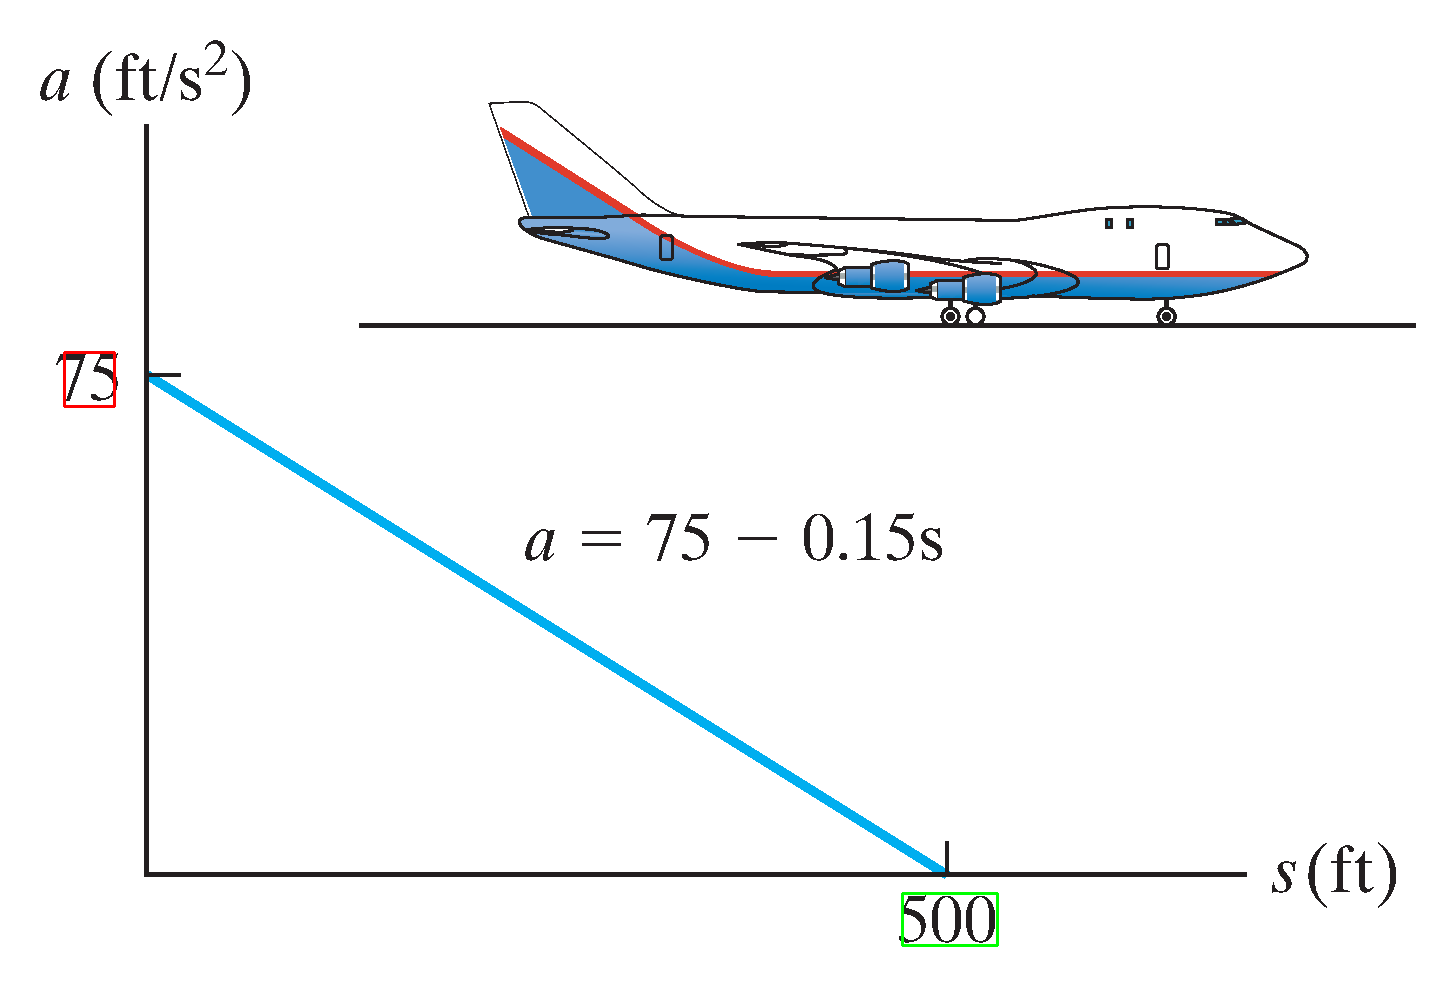

202
202
[[[140, 1118], [1393, 1118]], [[650, 396], [1543, 396]]] [[[139, 115], [139, 1116]], [[854, 803], [854, 1134]]]


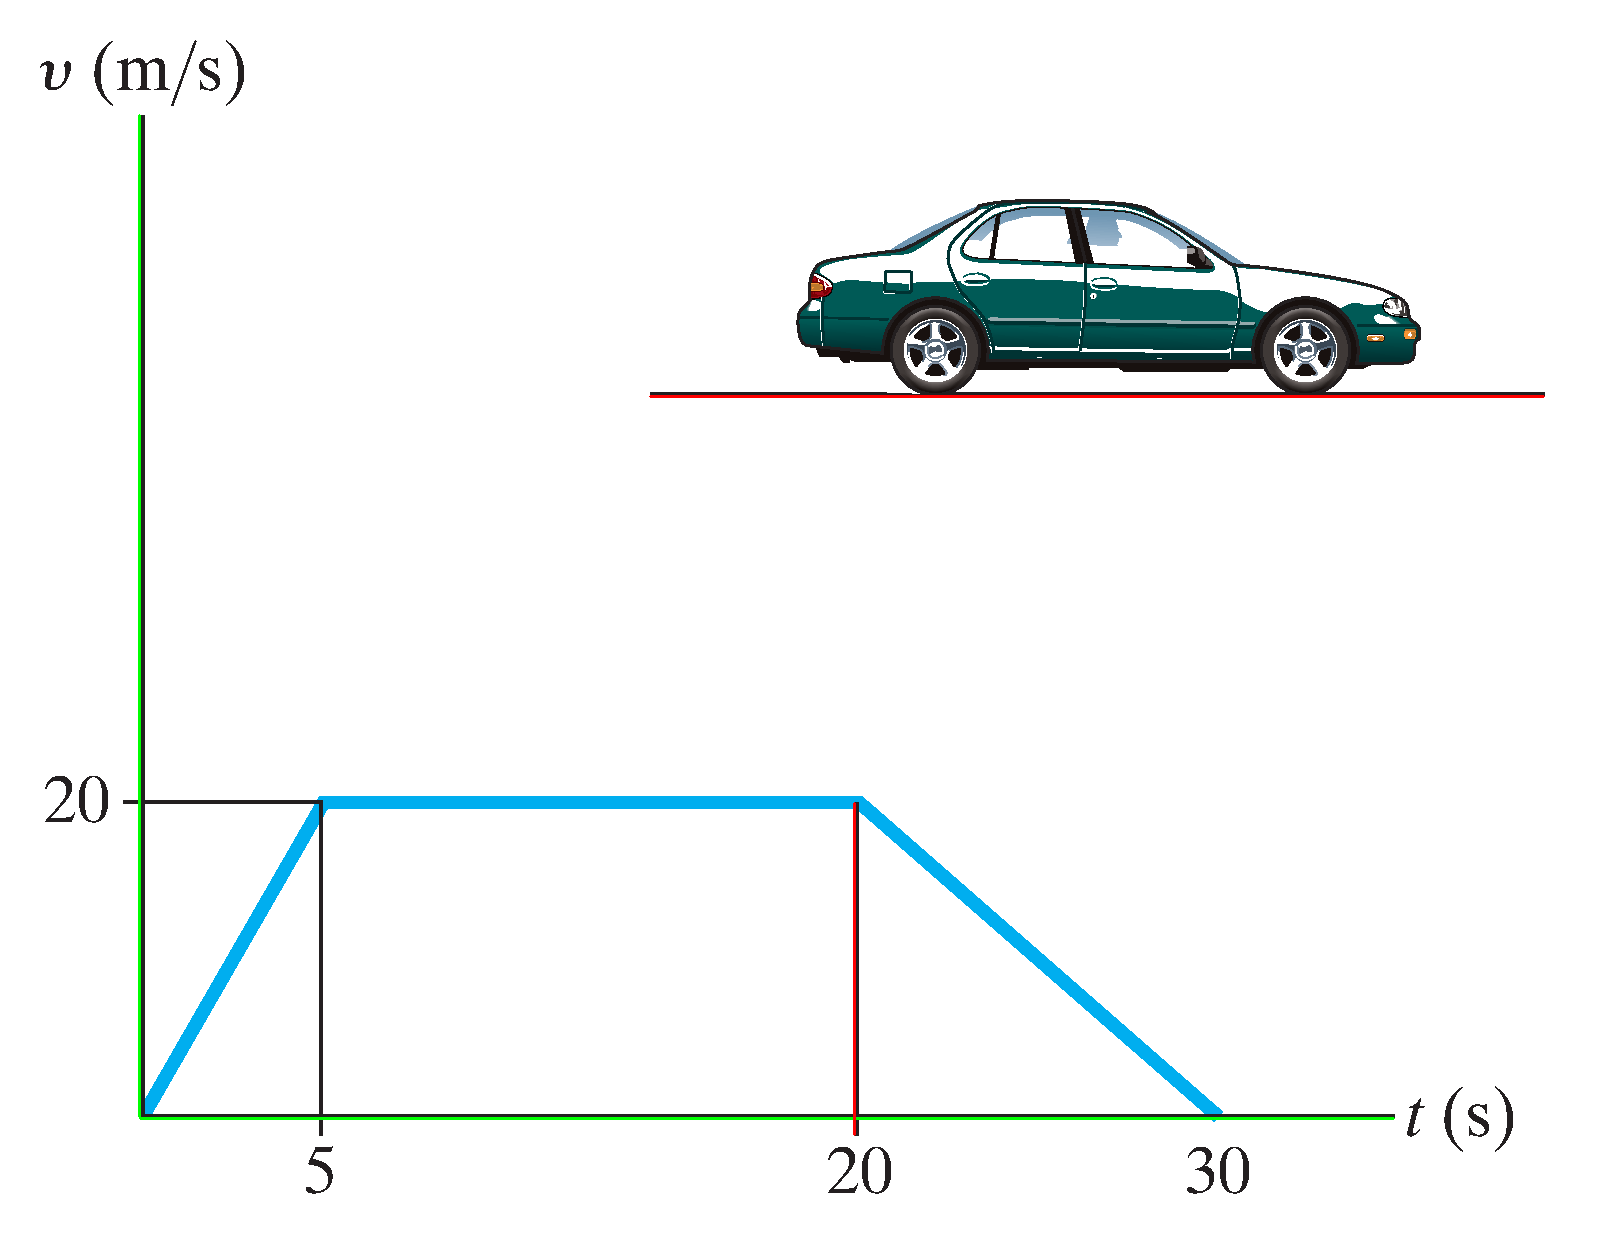

202
202


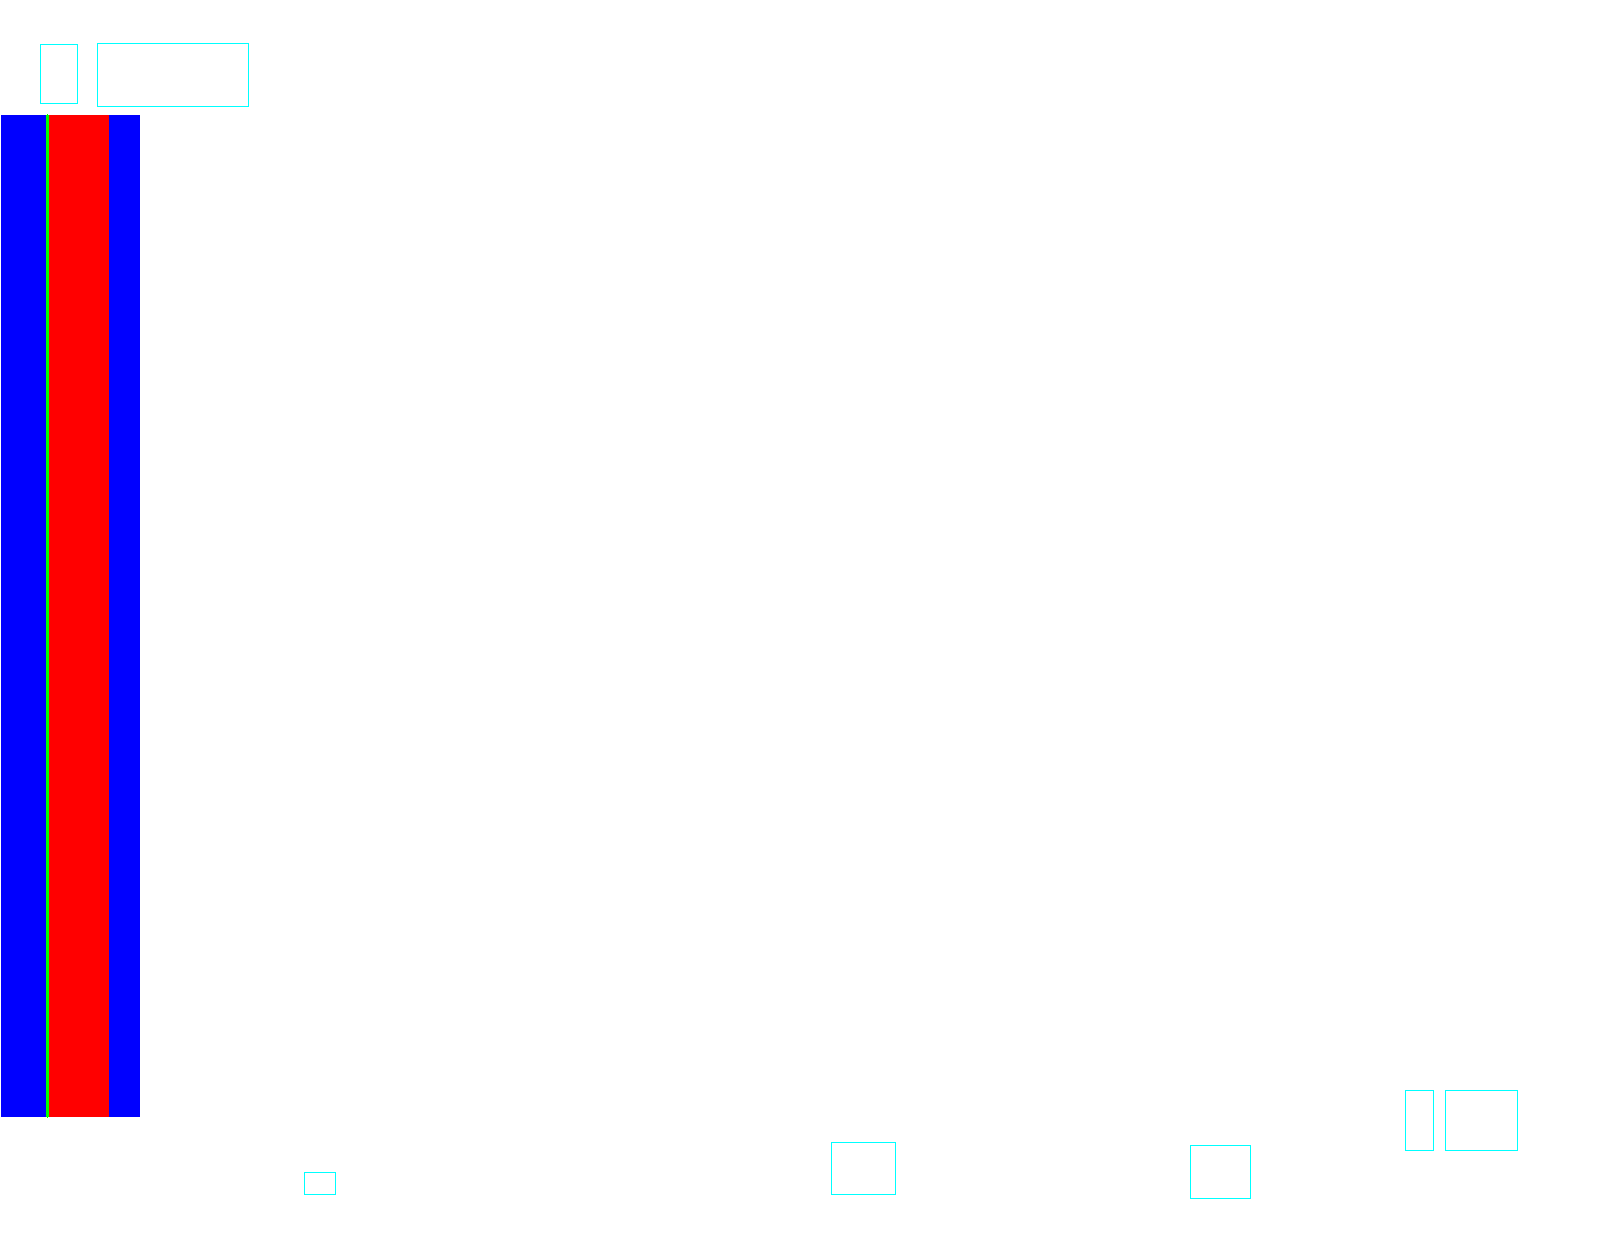

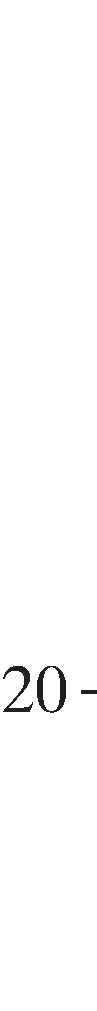

(1011, 97, 3)


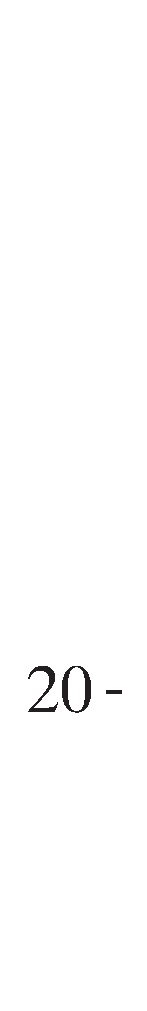

(1011, 147, 3)
202
202
[{'boundingBox': [29, 663, 95, 662, 96, 712, 30, 713], 'text': '20'}, {'boundingBox': [105, 662, 115, 662, 116, 711, 106, 712], 'text': '-'}]
[{'boundingBox': [4, 663, 70, 662, 71, 712, 5, 713], 'text': '20'}, {'boundingBox': [80, 662, 90, 662, 91, 711, 81, 712], 'text': '-'}]
[{'boundingBox': [46, 773, 112, 772, 113, 822, 47, 823], 'text': '20'}, {'boundingBox': [122, 772, 132, 772, 133, 821, 123, 822], 'text': '-'}]


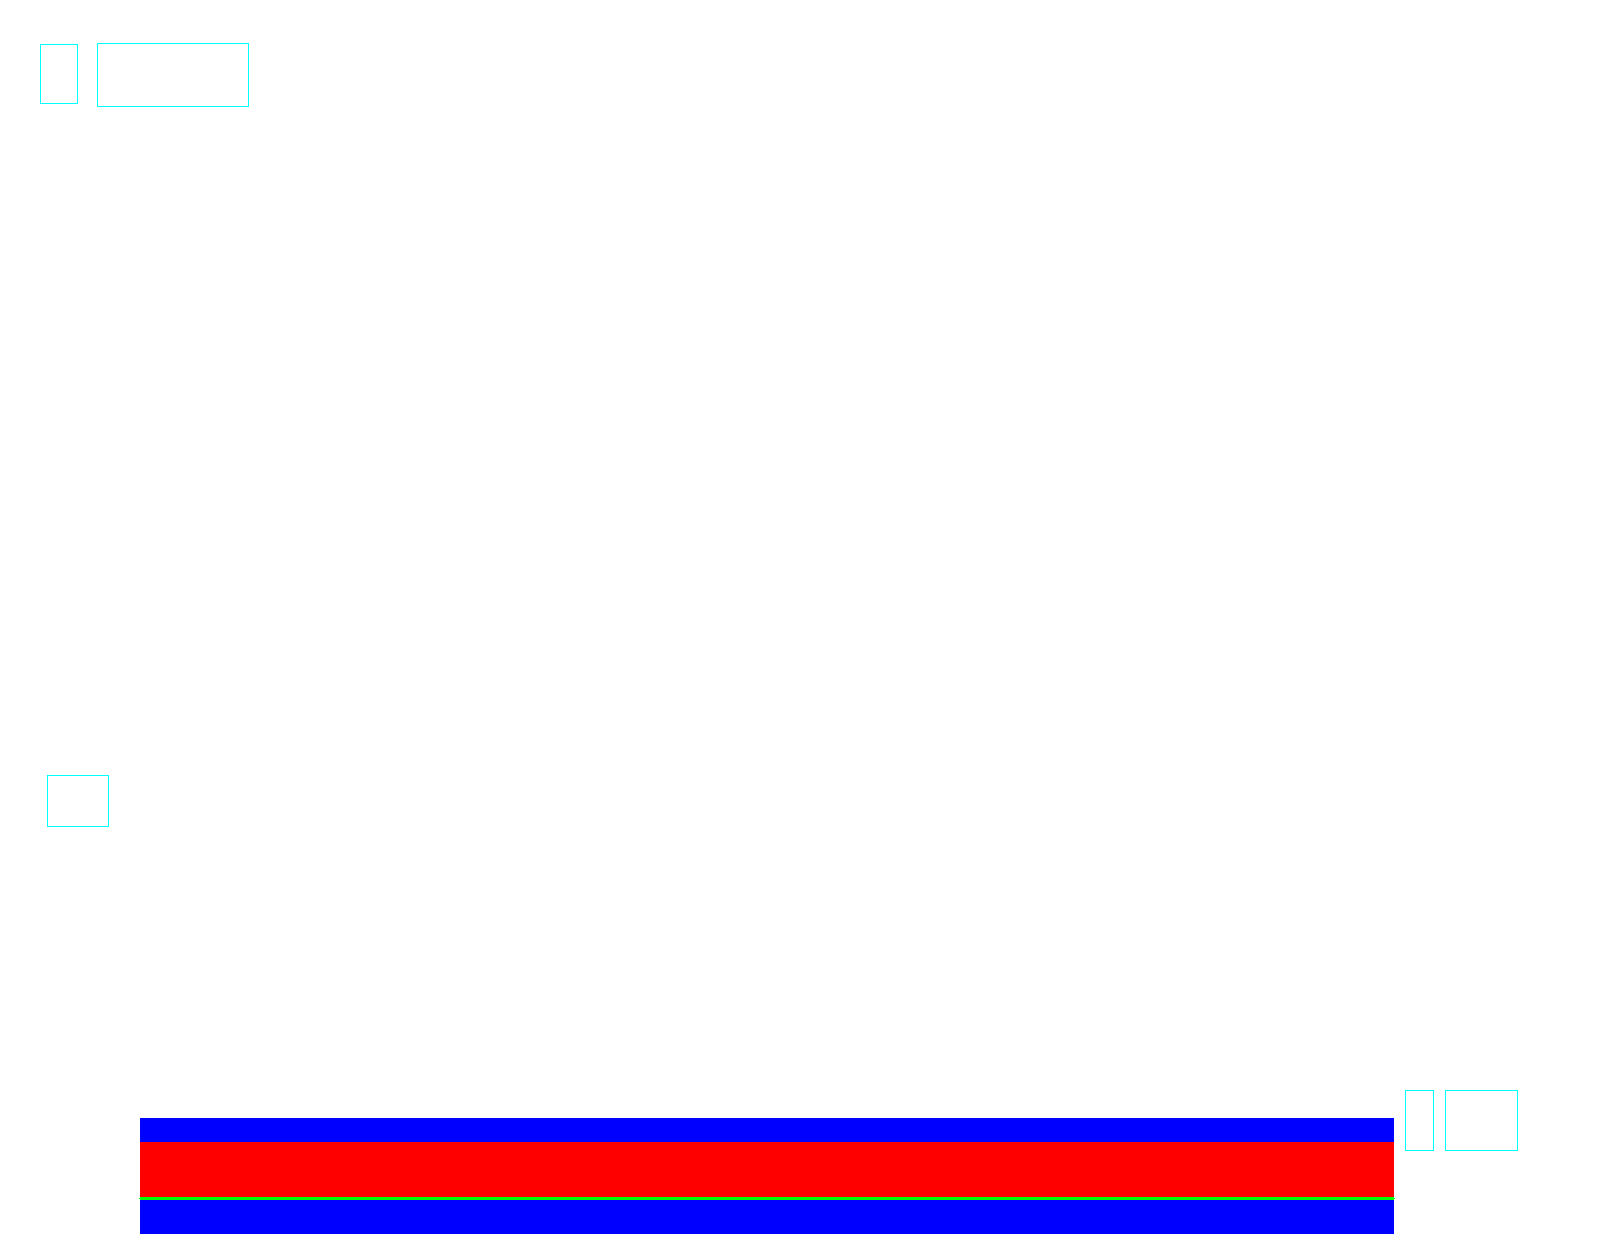

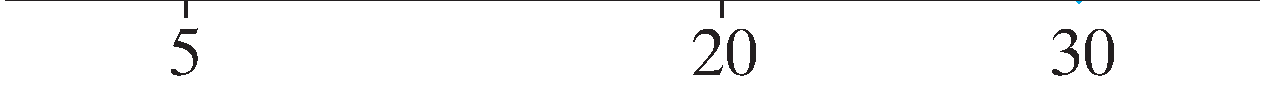

(85, 1263, 3)


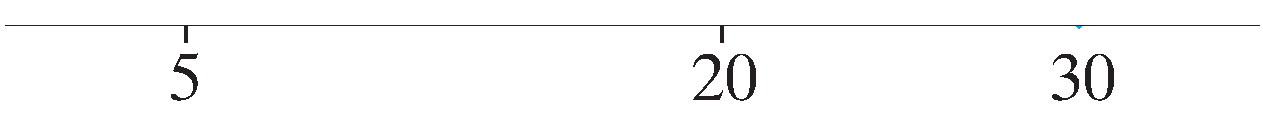

(135, 1263, 3)
202
202
[{'boundingBox': [165, 99, 169, 21, 201, 22, 197, 101], 'text': 'U-', 'confidence': 'Low'}, {'boundingBox': [695, 52, 755, 51, 756, 101, 696, 102], 'text': '20'}, {'boundingBox': [1056, 51, 1114, 51, 1115, 102, 1056, 103], 'text': '30'}]
[{'boundingBox': [165, 74, 169, -4, 201, -3, 197, 76], 'text': 'U-', 'confidence': 'Low'}, {'boundingBox': [695, 27, 755, 26, 756, 76, 696, 77], 'text': '20'}, {'boundingBox': [1056, 26, 1114, 26, 1115, 77, 1056, 78], 'text': '30'}]
[{'boundingBox': [300, 1192, 304, 1114, 336, 1115, 332, 1194], 'text': 'U-', 'confidence': 'Low'}, {'boundingBox': [830, 1145, 890, 1144, 891, 1194, 831, 1195], 'text': '20'}, {'boundingBox': [1191, 1144, 1249, 1144, 1250, 1195, 1191, 1196], 'text': '30'}]
[{'boundingBox': [46, 773, 112, 772, 113, 822, 47, 823], 'text': '20'}, {'boundingBox': [122, 772, 132, 772, 133, 821, 123, 822], 'text': '-'}]
[{'boundingBox': [300, 1192, 304, 1114, 336, 1115, 332, 1194], 'text': 'U-', 'confidence': 'Low'}, {'boun

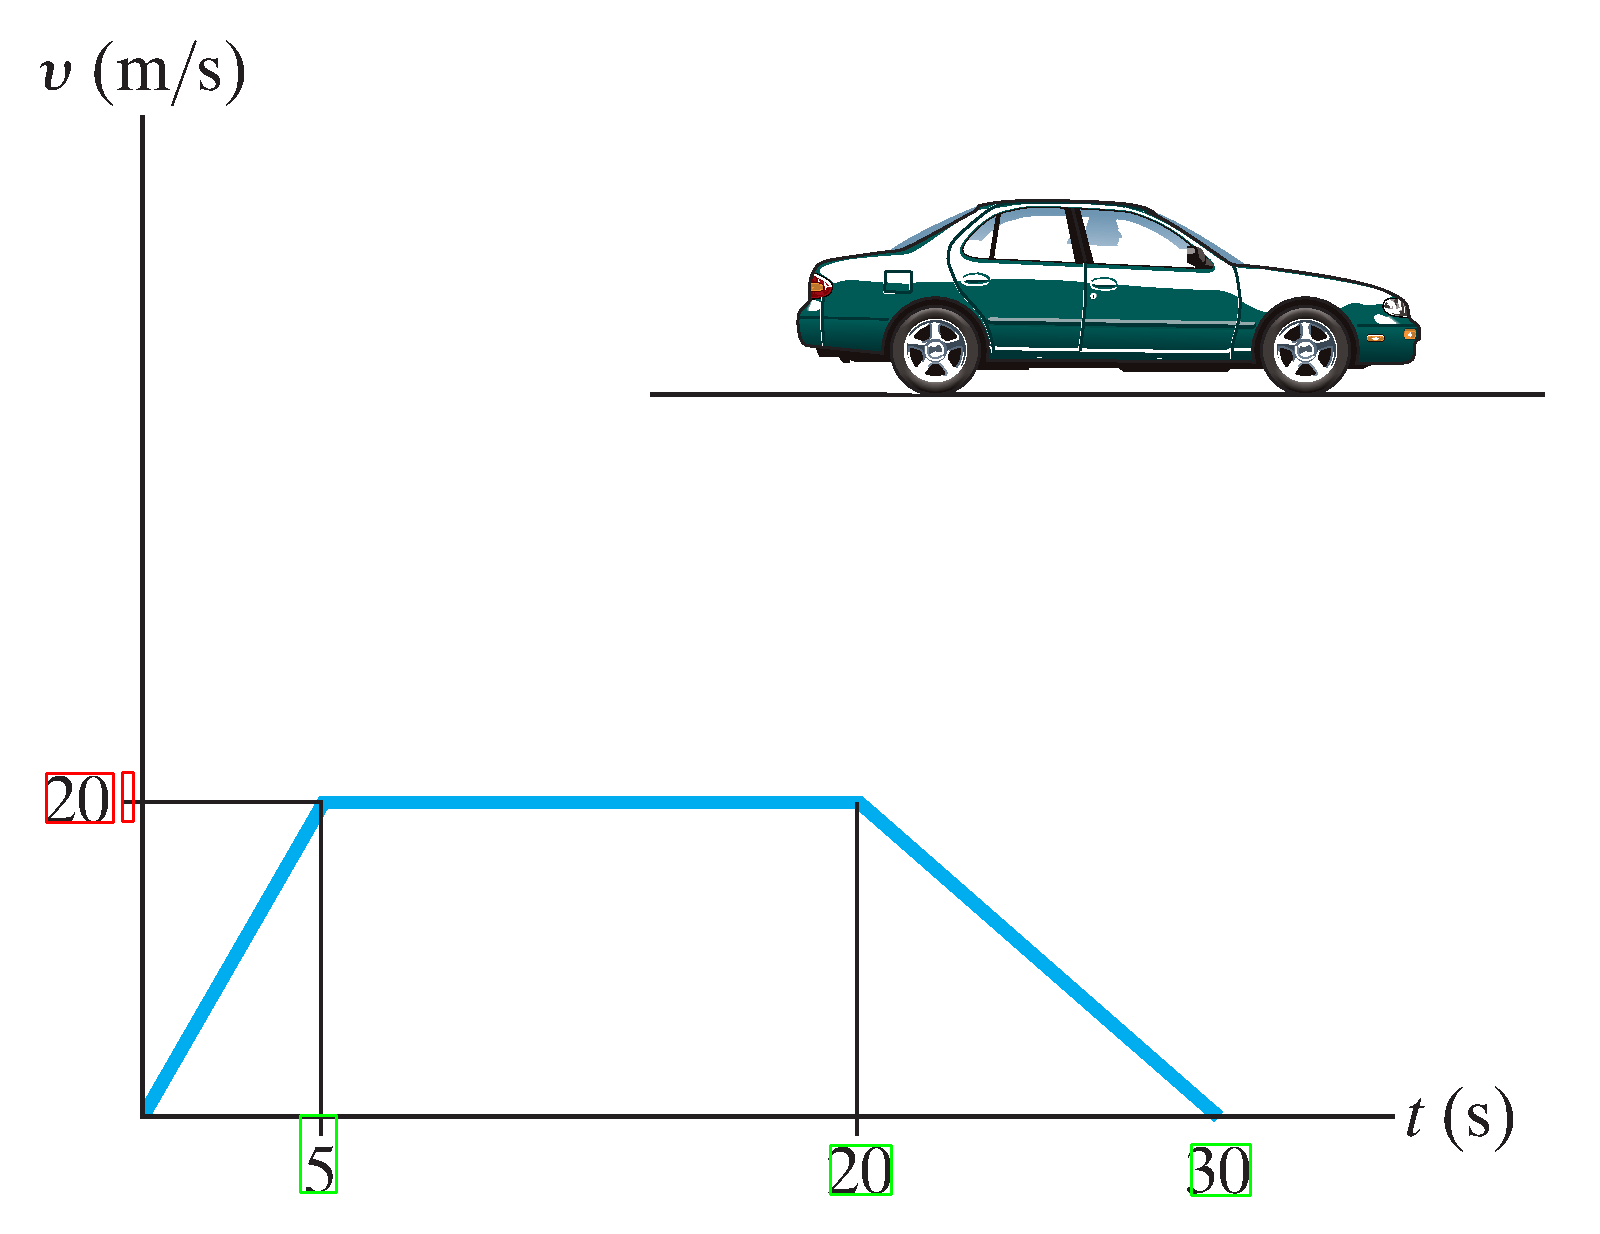

202
202
[[[861, 370], [1556, 370]], [[613, 893], [1281, 893]]] [[[339, 181], [339, 1074]], [[608, 536], [608, 1109]]]


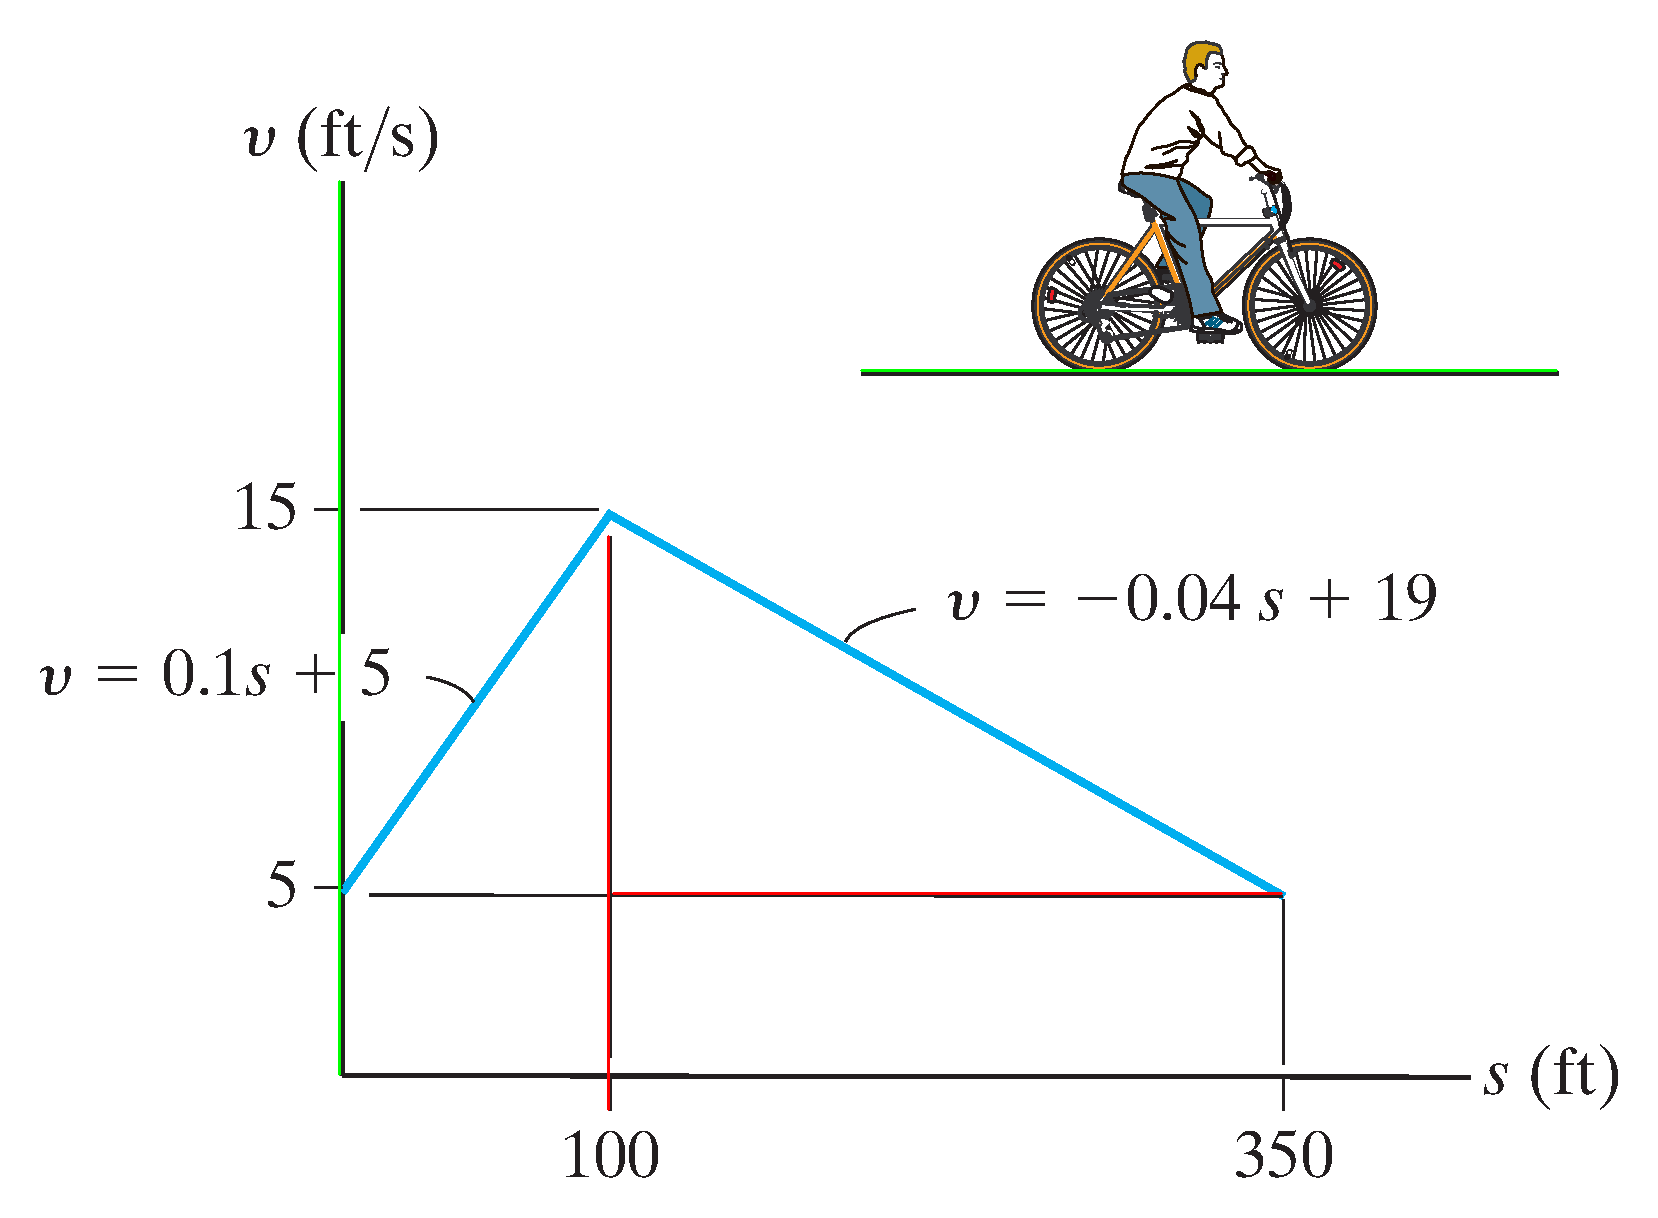

202
202


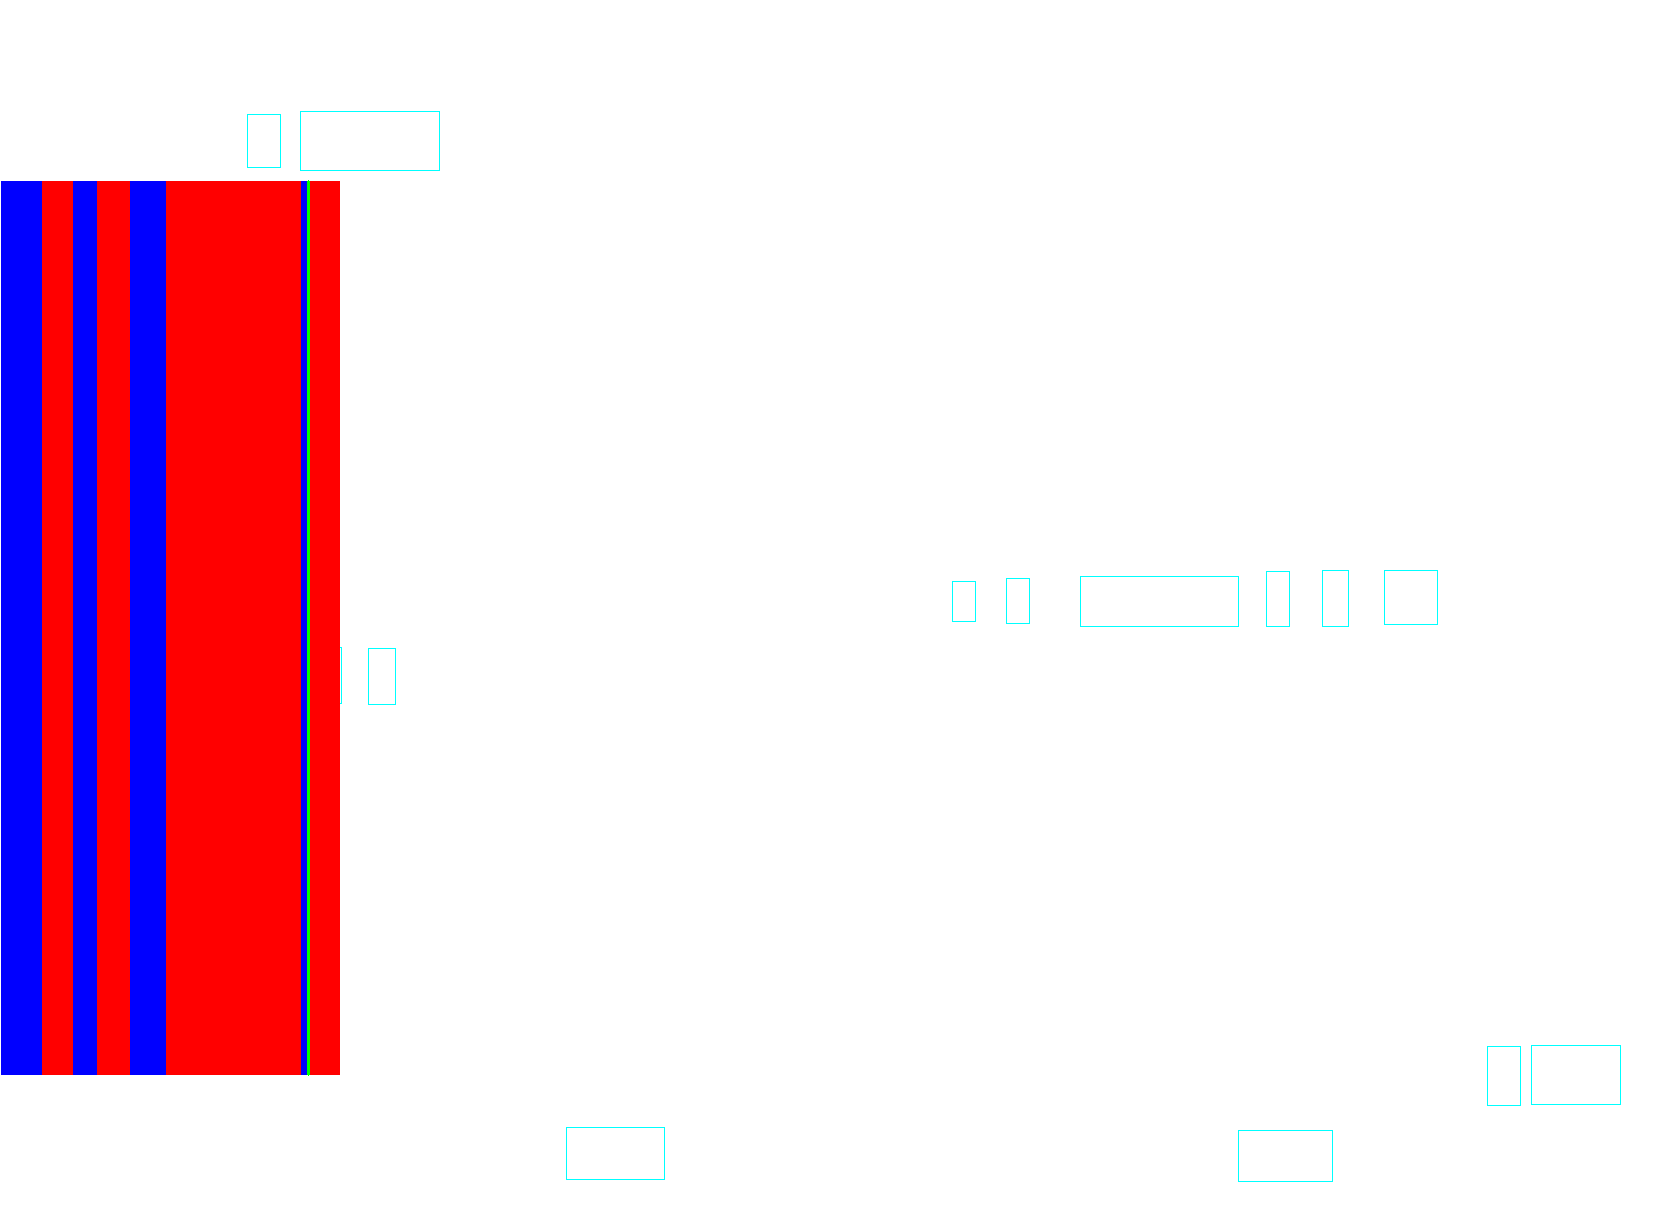

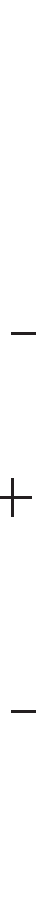

(903, 36, 3)


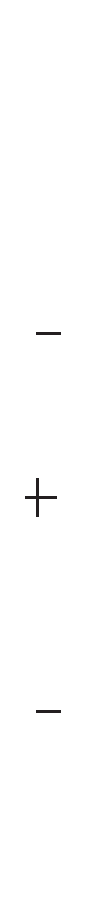

(903, 86, 3)
202
202
[{'boundingBox': [33, 480, 55, 481, 54, 514, 32, 513], 'text': '+'}]
[{'boundingBox': [8, 480, 30, 481, 29, 514, 7, 513], 'text': '+'}]
[{'boundingBox': [311, 656, 333, 657, 332, 690, 310, 689], 'text': '+'}]


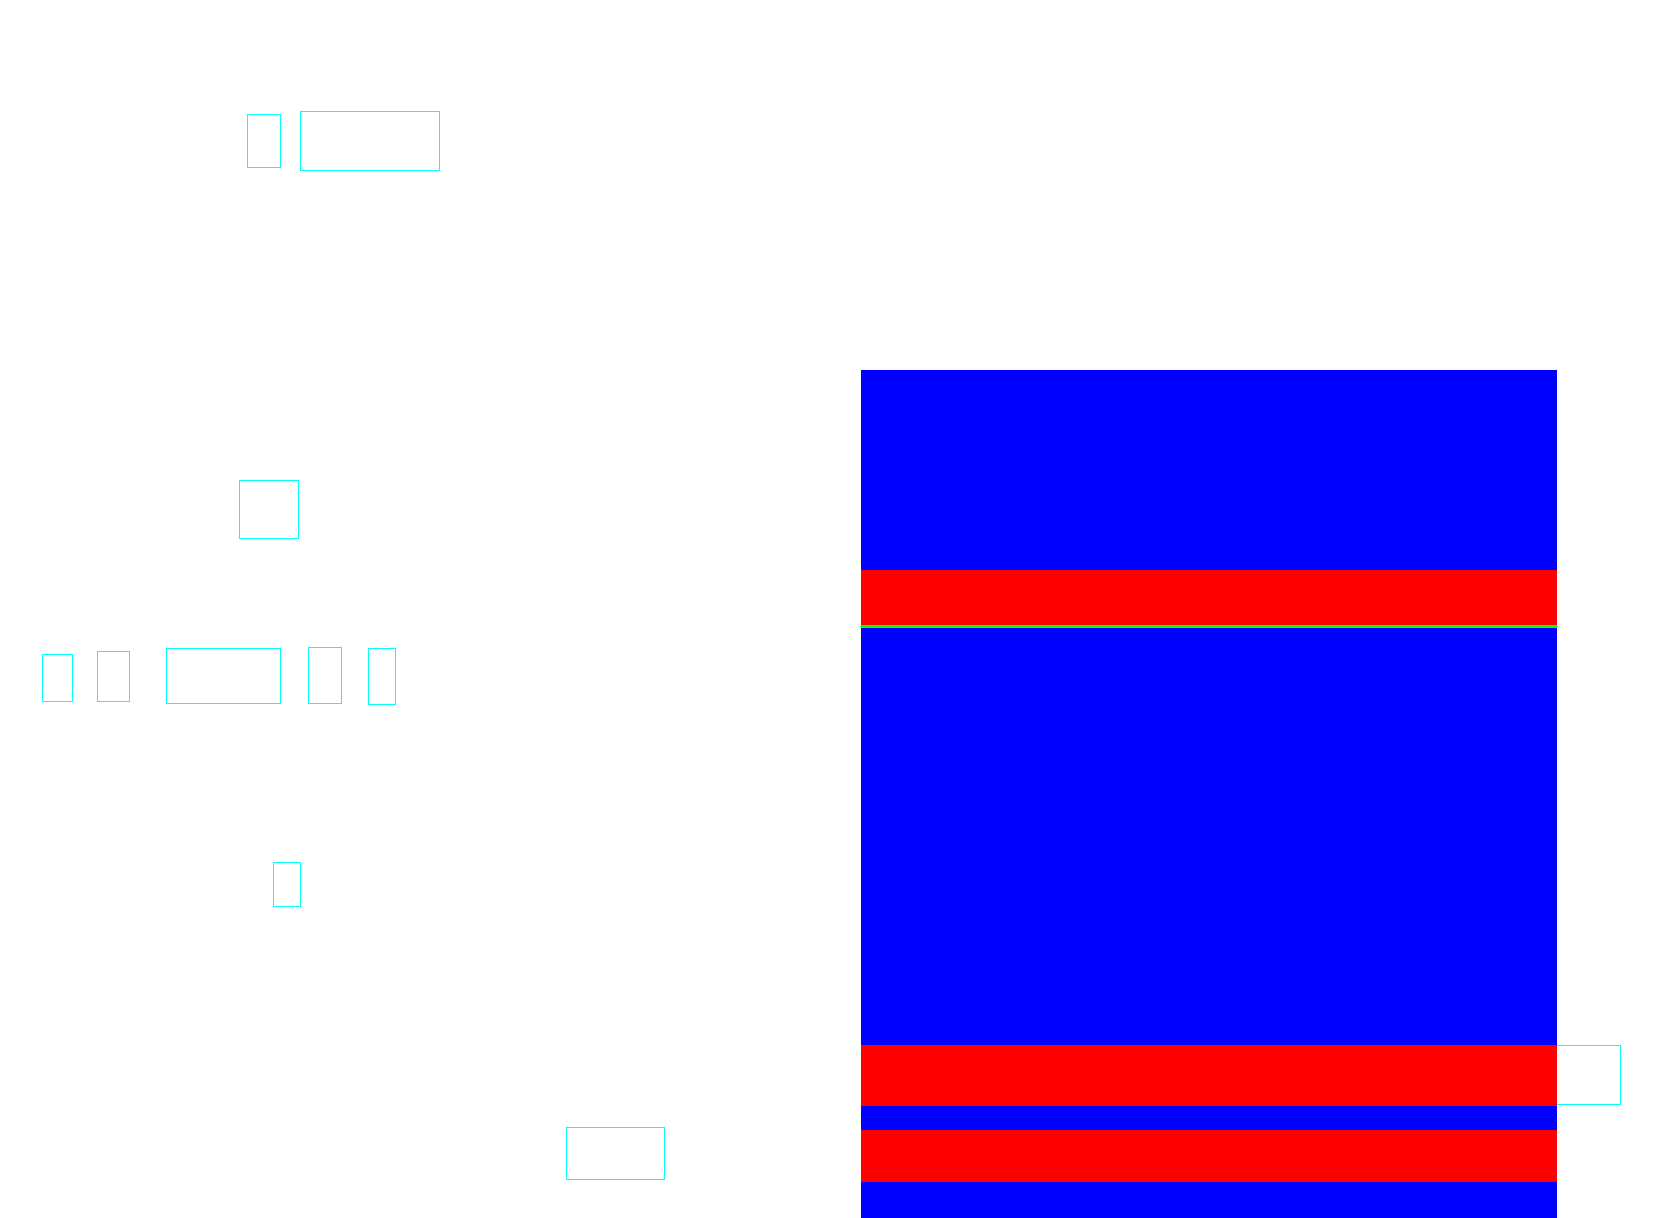

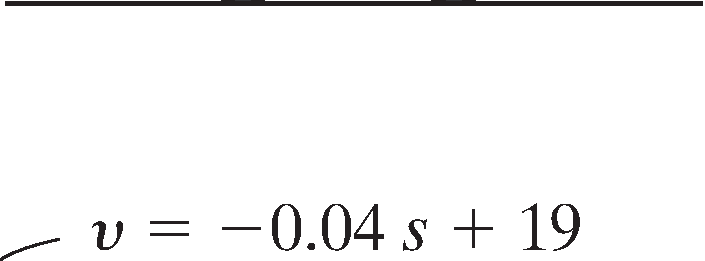

(261, 705, 3)


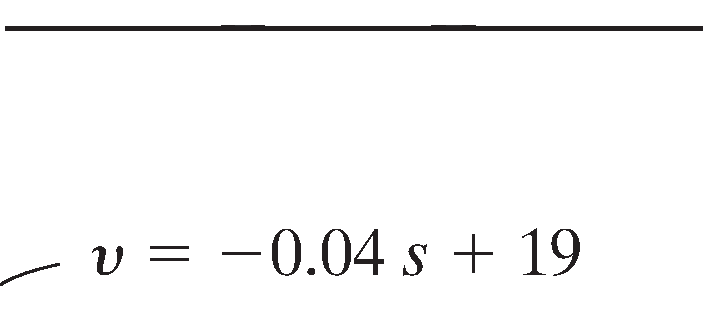

(311, 705, 3)
202
202
[{'boundingBox': [93, 244, 111, 242, 114, 274, 95, 273], 'text': 'V', 'confidence': 'Low'}, {'boundingBox': [149, 238, 167, 237, 169, 275, 151, 275], 'text': '='}, {'boundingBox': [223, 232, 377, 226, 378, 278, 225, 276], 'text': '-0.04'}, {'boundingBox': [408, 226, 427, 226, 428, 278, 410, 278], 'text': 's'}, {'boundingBox': [468, 226, 487, 226, 488, 278, 469, 278], 'text': '+'}, {'boundingBox': [526, 227, 575, 229, 575, 278, 527, 278], 'text': '19'}]
[{'boundingBox': [93, 219, 111, 217, 114, 249, 95, 248], 'text': 'V', 'confidence': 'Low'}, {'boundingBox': [149, 213, 167, 212, 169, 250, 151, 250], 'text': '='}, {'boundingBox': [223, 207, 377, 201, 378, 253, 225, 251], 'text': '-0.04'}, {'boundingBox': [408, 201, 427, 201, 428, 253, 410, 253], 'text': 's'}, {'boundingBox': [468, 201, 487, 201, 488, 253, 469, 253], 'text': '+'}, {'boundingBox': [526, 202, 575, 204, 575, 253, 527, 253], 'text': '19'}]
[{'boundingBox': [949, 589, 967, 587, 970, 619, 951, 618], 'text

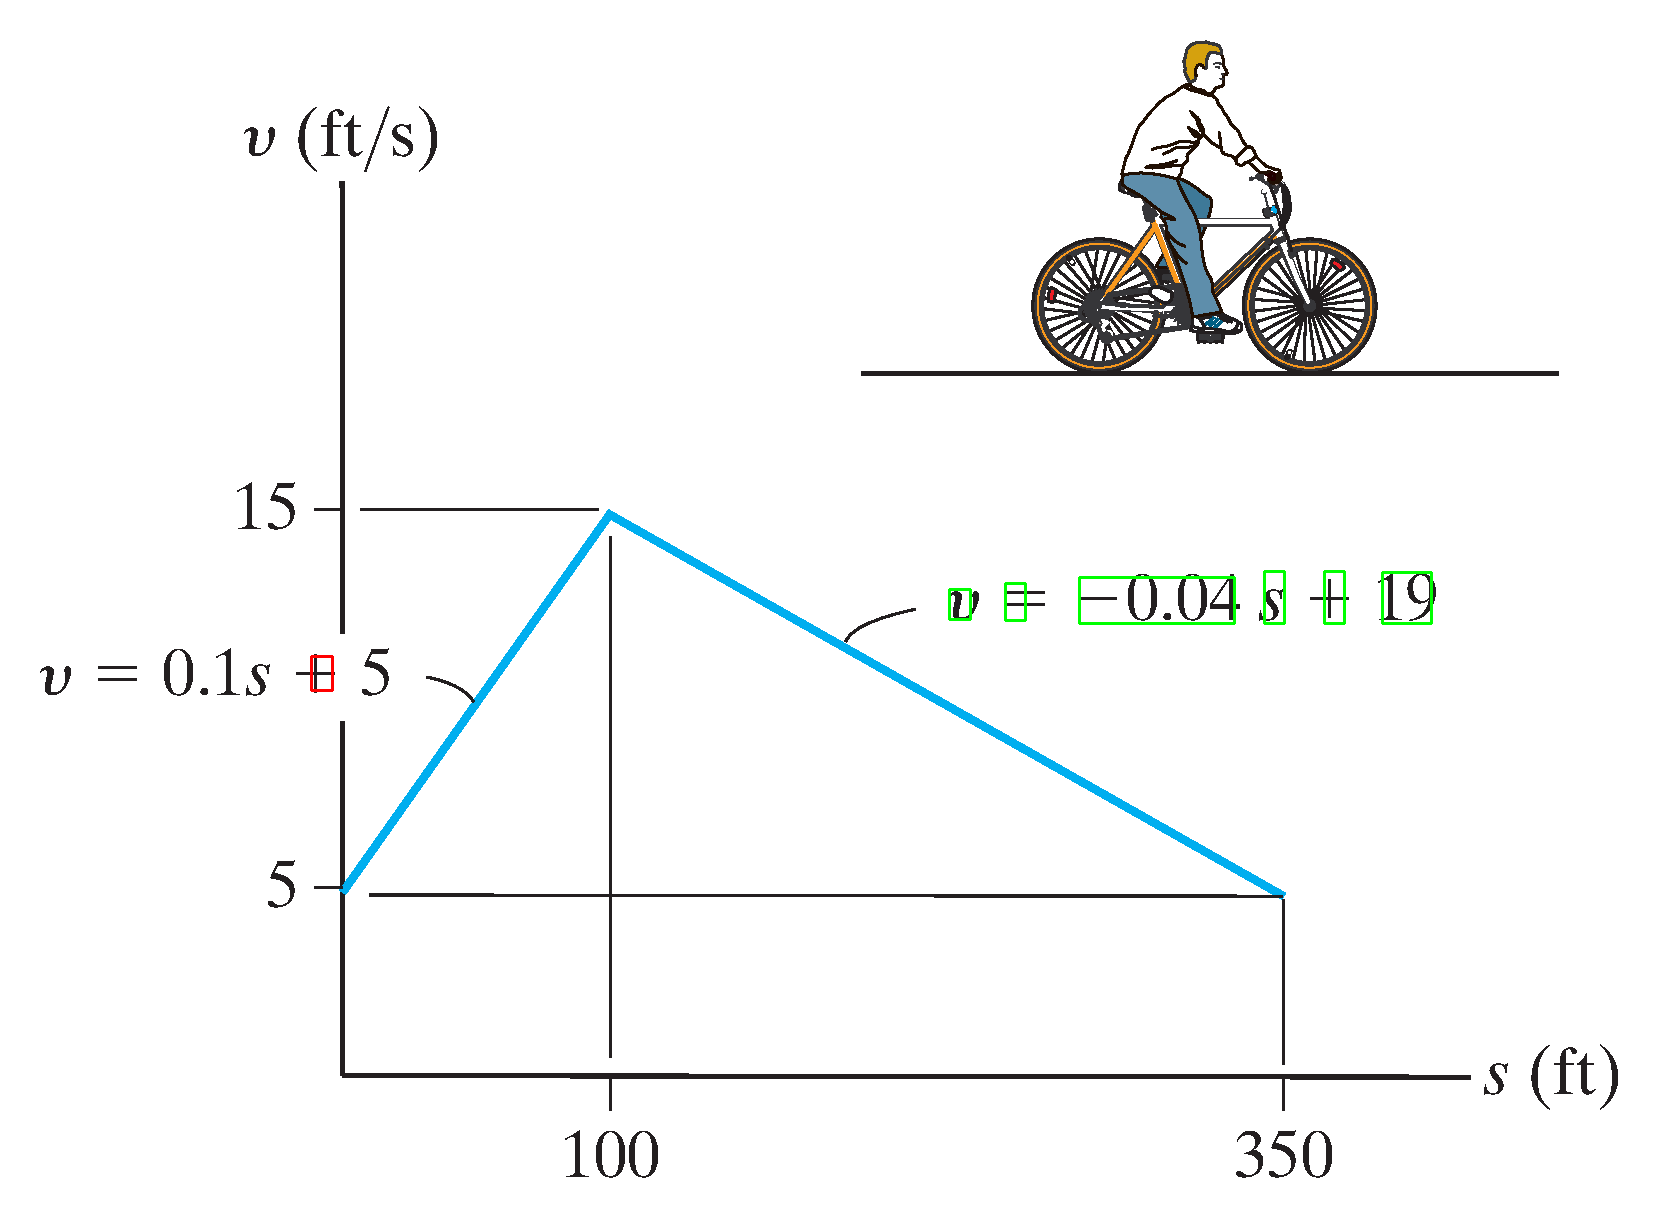

202
202
[[[128, 828], [1229, 828]], [[253, 446], [1254, 446]]] [[[127, 126], [127, 826]], [[528, 626], [528, 821]]]


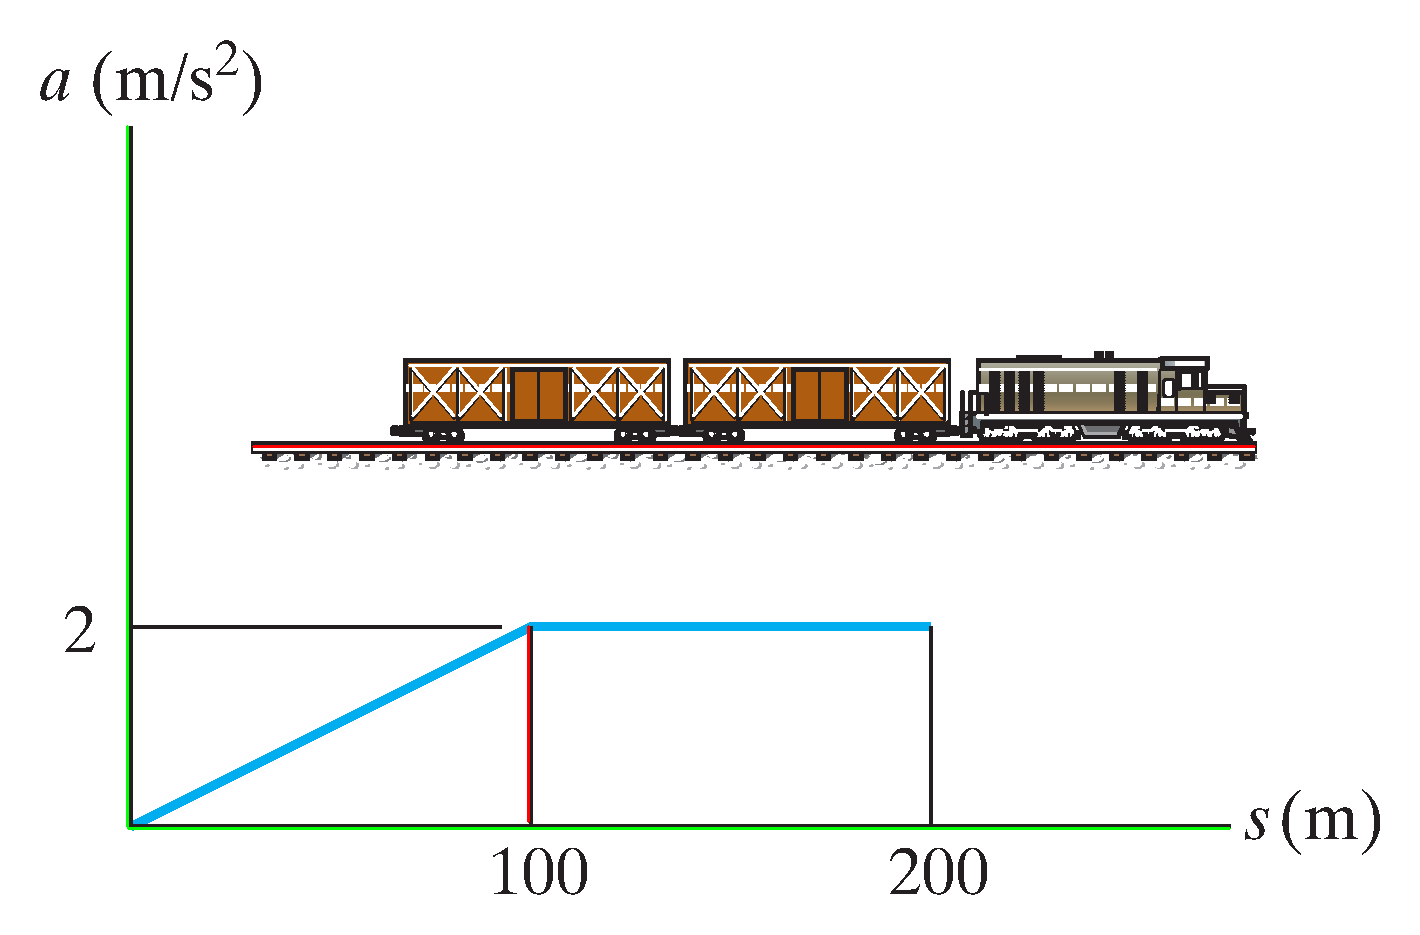

202
202


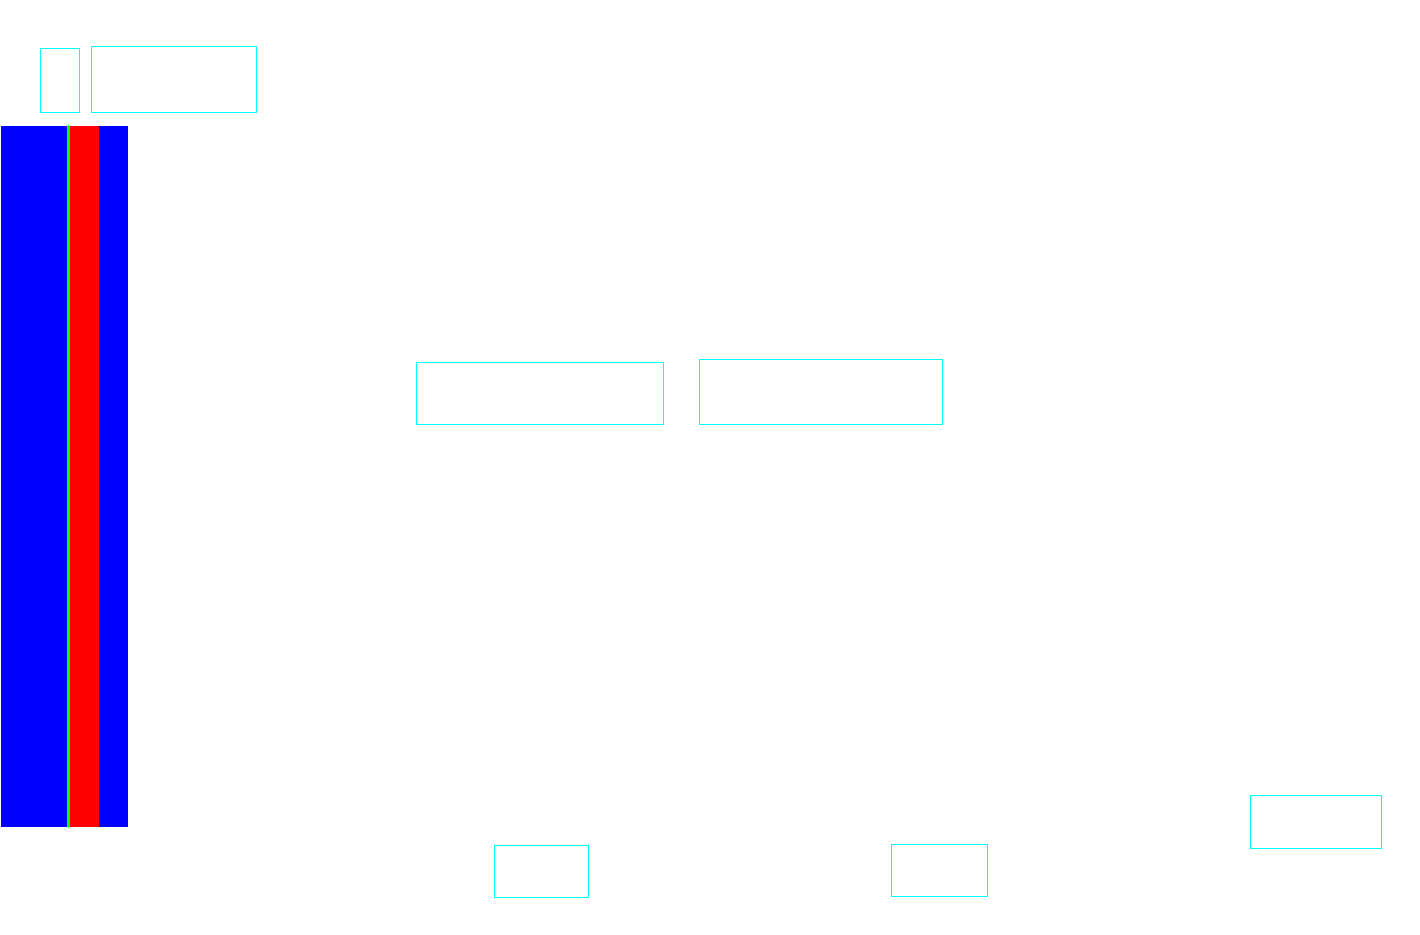

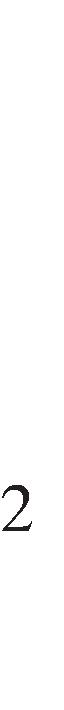

(710, 64, 3)


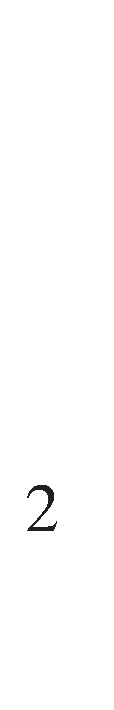

(710, 114, 3)
202
202
202
[{'boundingBox': [23, 530, 22, 503, 58, 502, 59, 528], 'text': 'N'}, {'boundingBox': [27, 484, 41, 484, 42, 505, 28, 505], 'text': 'n'}]
[{'boundingBox': [-2, 530, -3, 503, 33, 502, 34, 528], 'text': 'N'}, {'boundingBox': [2, 484, 16, 484, 17, 505, 3, 505], 'text': 'n'}]
[{'boundingBox': [61, 651, 60, 624, 96, 623, 97, 649], 'text': 'N'}, {'boundingBox': [65, 605, 79, 605, 80, 626, 66, 626], 'text': 'n'}]


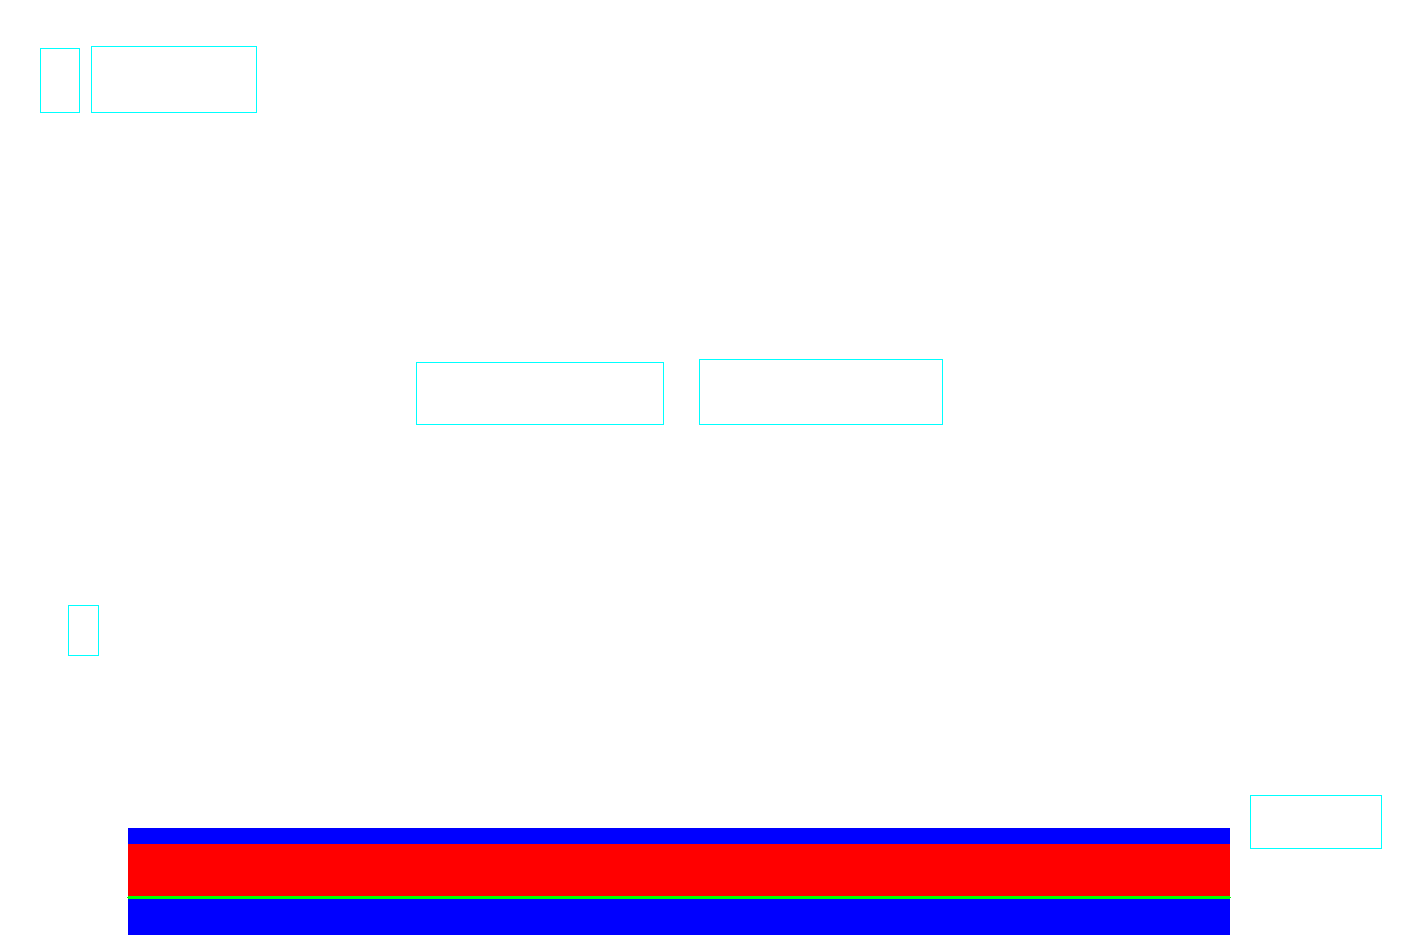

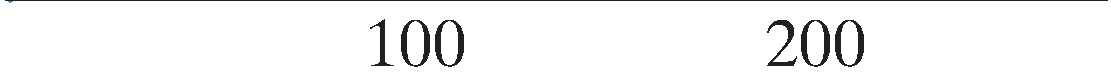

(74, 1111, 3)


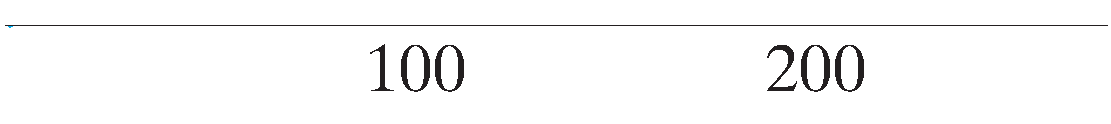

(124, 1111, 3)
202
202
[{'boundingBox': [371, 42, 465, 41, 465, 93, 371, 94], 'text': '100'}, {'boundingBox': [770, 42, 865, 40, 867, 95, 771, 97], 'text': '200'}]
[{'boundingBox': [371, 17, 465, 16, 465, 68, 371, 69], 'text': '100'}, {'boundingBox': [770, 17, 865, 15, 867, 70, 771, 72], 'text': '200'}]
[{'boundingBox': [494, 845, 588, 844, 588, 896, 494, 897], 'text': '100'}, {'boundingBox': [893, 845, 988, 843, 990, 898, 894, 900], 'text': '200'}]
[{'boundingBox': [61, 651, 60, 624, 96, 623, 97, 649], 'text': 'N'}, {'boundingBox': [65, 605, 79, 605, 80, 626, 66, 626], 'text': 'n'}]
[{'boundingBox': [494, 845, 588, 844, 588, 896, 494, 897], 'text': '100'}, {'boundingBox': [893, 845, 988, 843, 990, 898, 894, 900], 'text': '200'}]


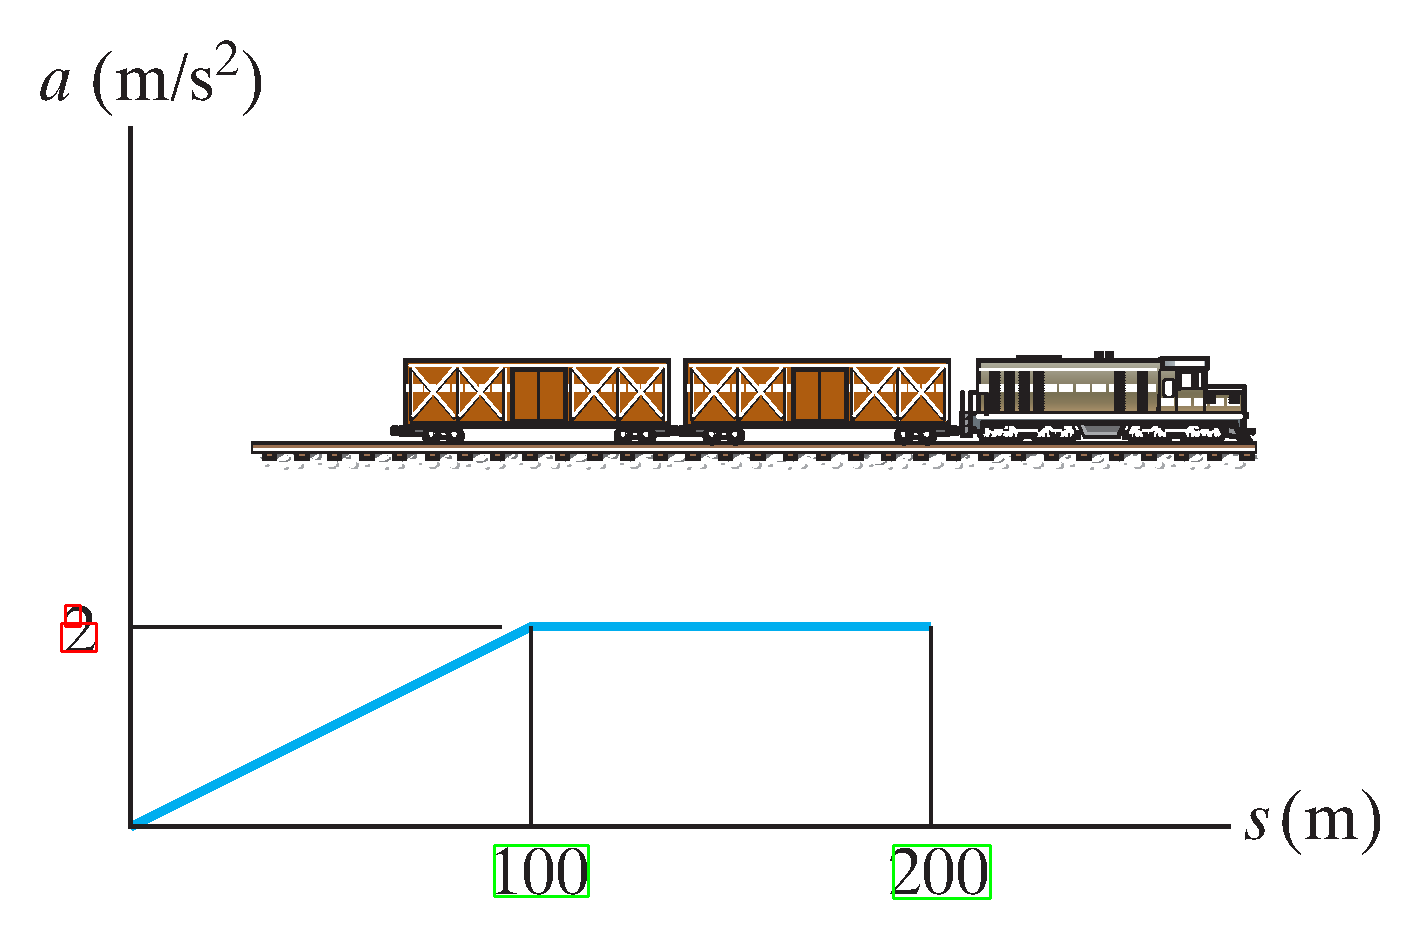

202
202
202
[[[160, 989], [1430, 989]], [[165, 583], [756, 583]]] [[[159, 136], [159, 988]], [[765, 586], [765, 983]]]


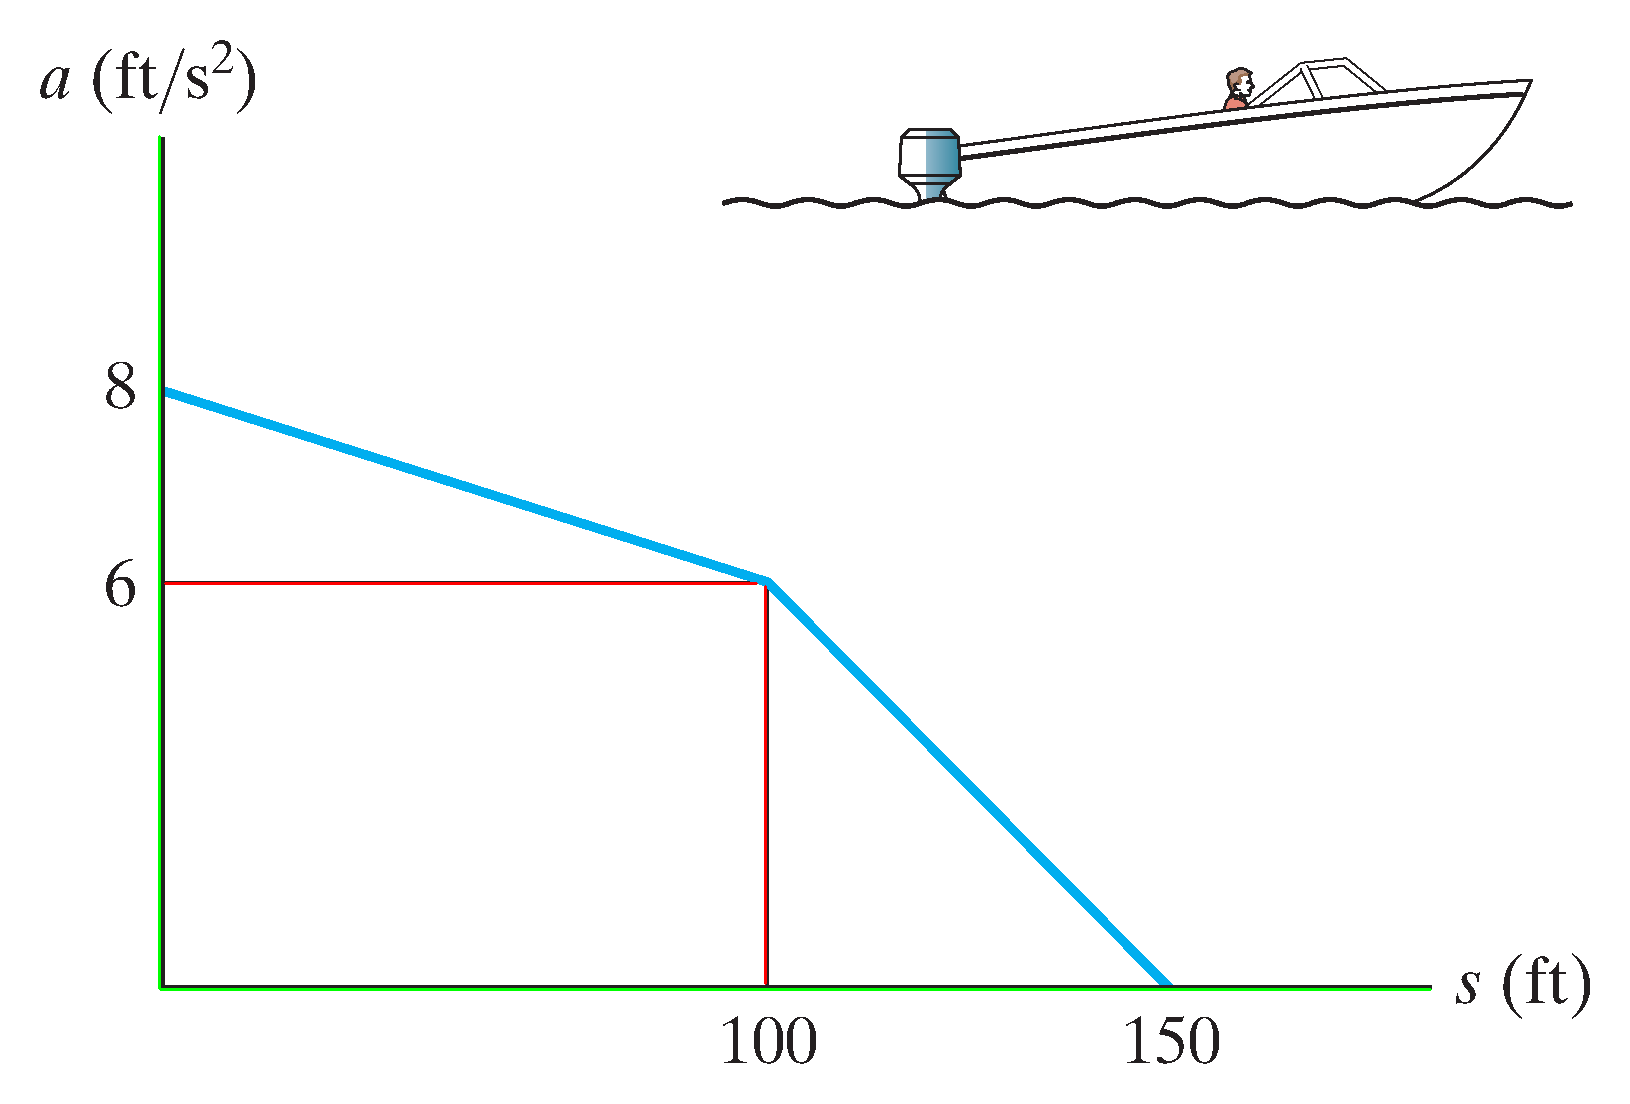

202
202
202


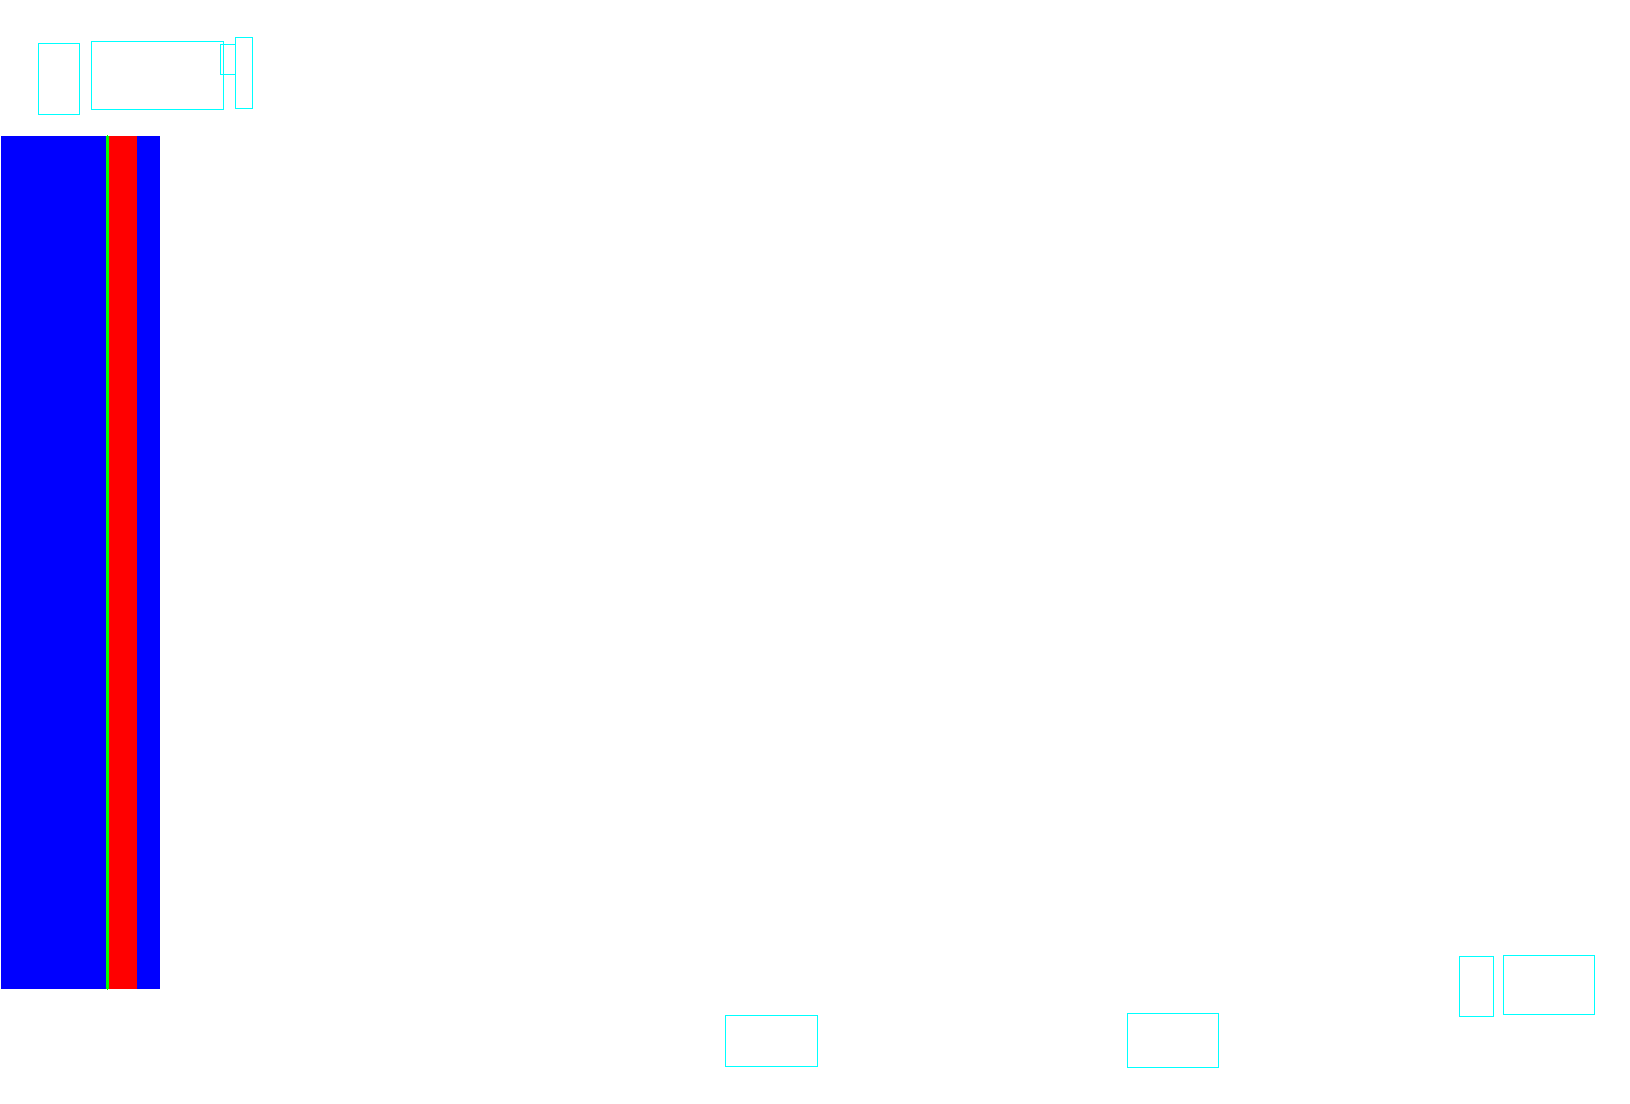

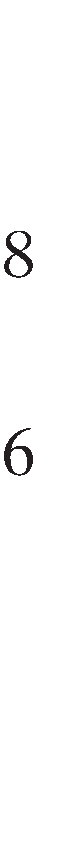

(862, 57, 3)


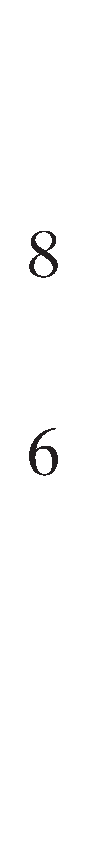

(862, 107, 3)
202
202
[{'boundingBox': [34, 231, 63, 233, 60, 277, 31, 275], 'text': '8'}, {'boundingBox': [28, 430, 58, 427, 62, 472, 32, 474], 'text': '6'}]
[{'boundingBox': [9, 231, 38, 233, 35, 277, 6, 275], 'text': '8'}, {'boundingBox': [3, 430, 33, 427, 37, 472, 7, 474], 'text': '6'}]
[{'boundingBox': [111, 362, 140, 364, 137, 408, 108, 406], 'text': '8'}, {'boundingBox': [105, 561, 135, 558, 139, 603, 109, 605], 'text': '6'}]


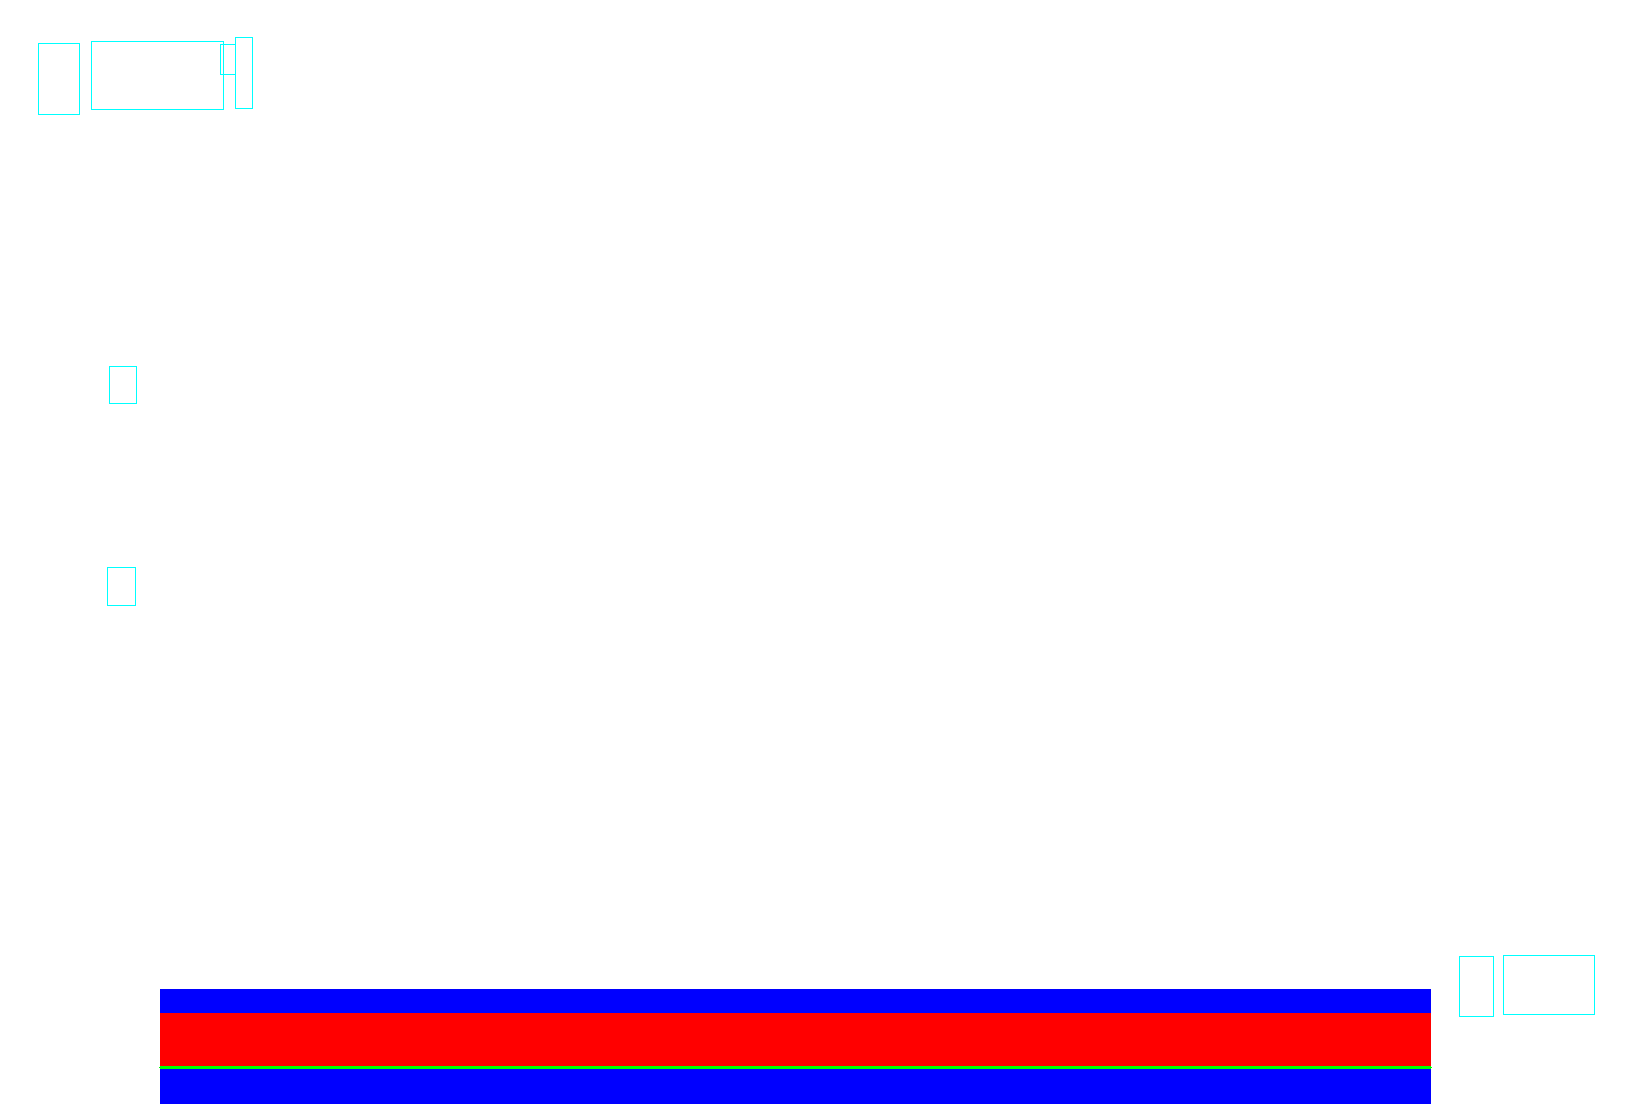

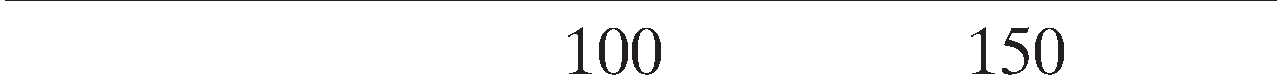

(83, 1280, 3)


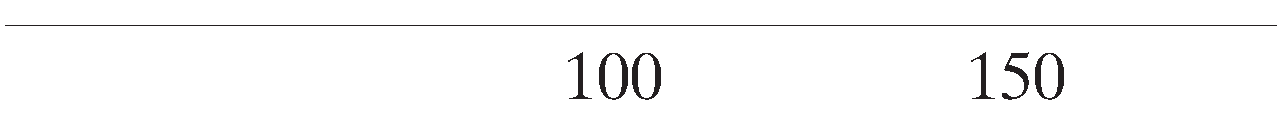

(133, 1280, 3)
202
202
[{'boundingBox': [571, 50, 661, 50, 662, 102, 571, 102], 'text': '100'}, {'boundingBox': [974, 52, 1065, 51, 1065, 98, 974, 99], 'text': '150'}]
[{'boundingBox': [571, 25, 661, 25, 662, 77, 571, 77], 'text': '100'}, {'boundingBox': [974, 27, 1065, 26, 1065, 73, 974, 74], 'text': '150'}]
[{'boundingBox': [726, 1014, 816, 1014, 817, 1066, 726, 1066], 'text': '100'}, {'boundingBox': [1129, 1016, 1220, 1015, 1220, 1062, 1129, 1063], 'text': '150'}]
[{'boundingBox': [111, 362, 140, 364, 137, 408, 108, 406], 'text': '8'}, {'boundingBox': [105, 561, 135, 558, 139, 603, 109, 605], 'text': '6'}]
[{'boundingBox': [726, 1014, 816, 1014, 817, 1066, 726, 1066], 'text': '100'}, {'boundingBox': [1129, 1016, 1220, 1015, 1220, 1062, 1129, 1063], 'text': '150'}]


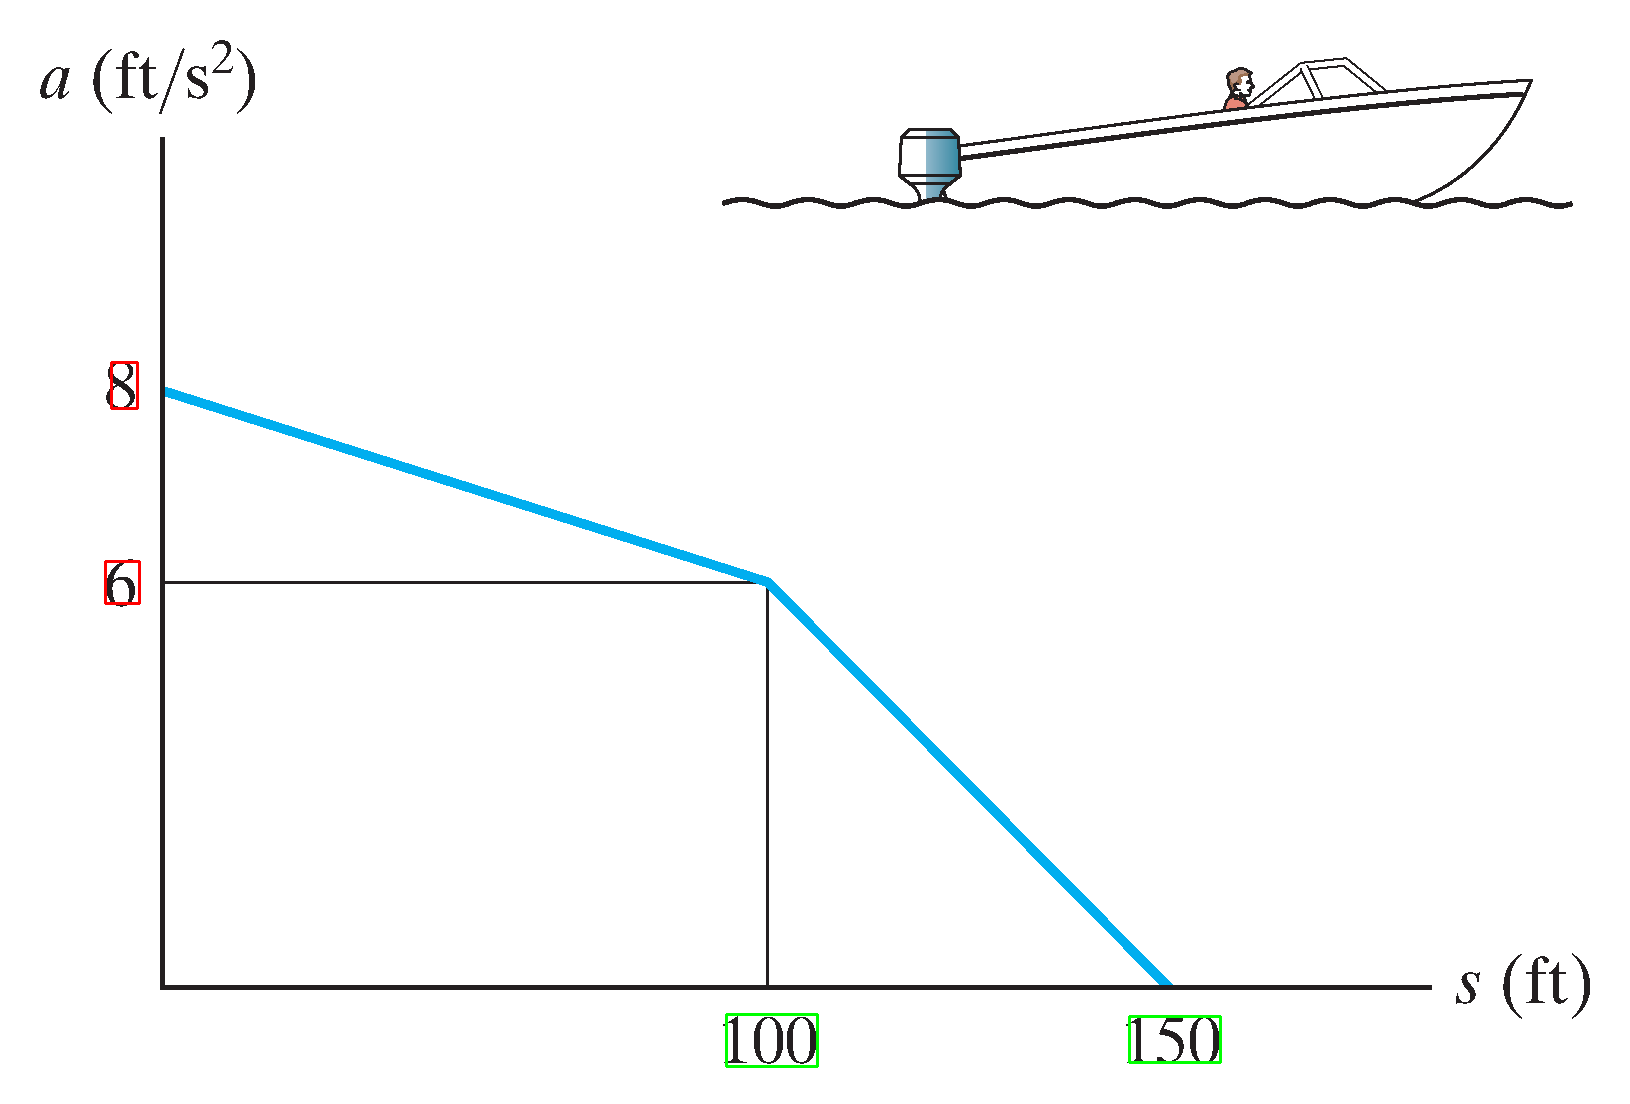

202
202
202
202
[[[146, 821], [1241, 821]], [[514, 290], [1291, 290]]] [[[140, 125], [140, 1023]], [[1140, 828], [1140, 973]]]


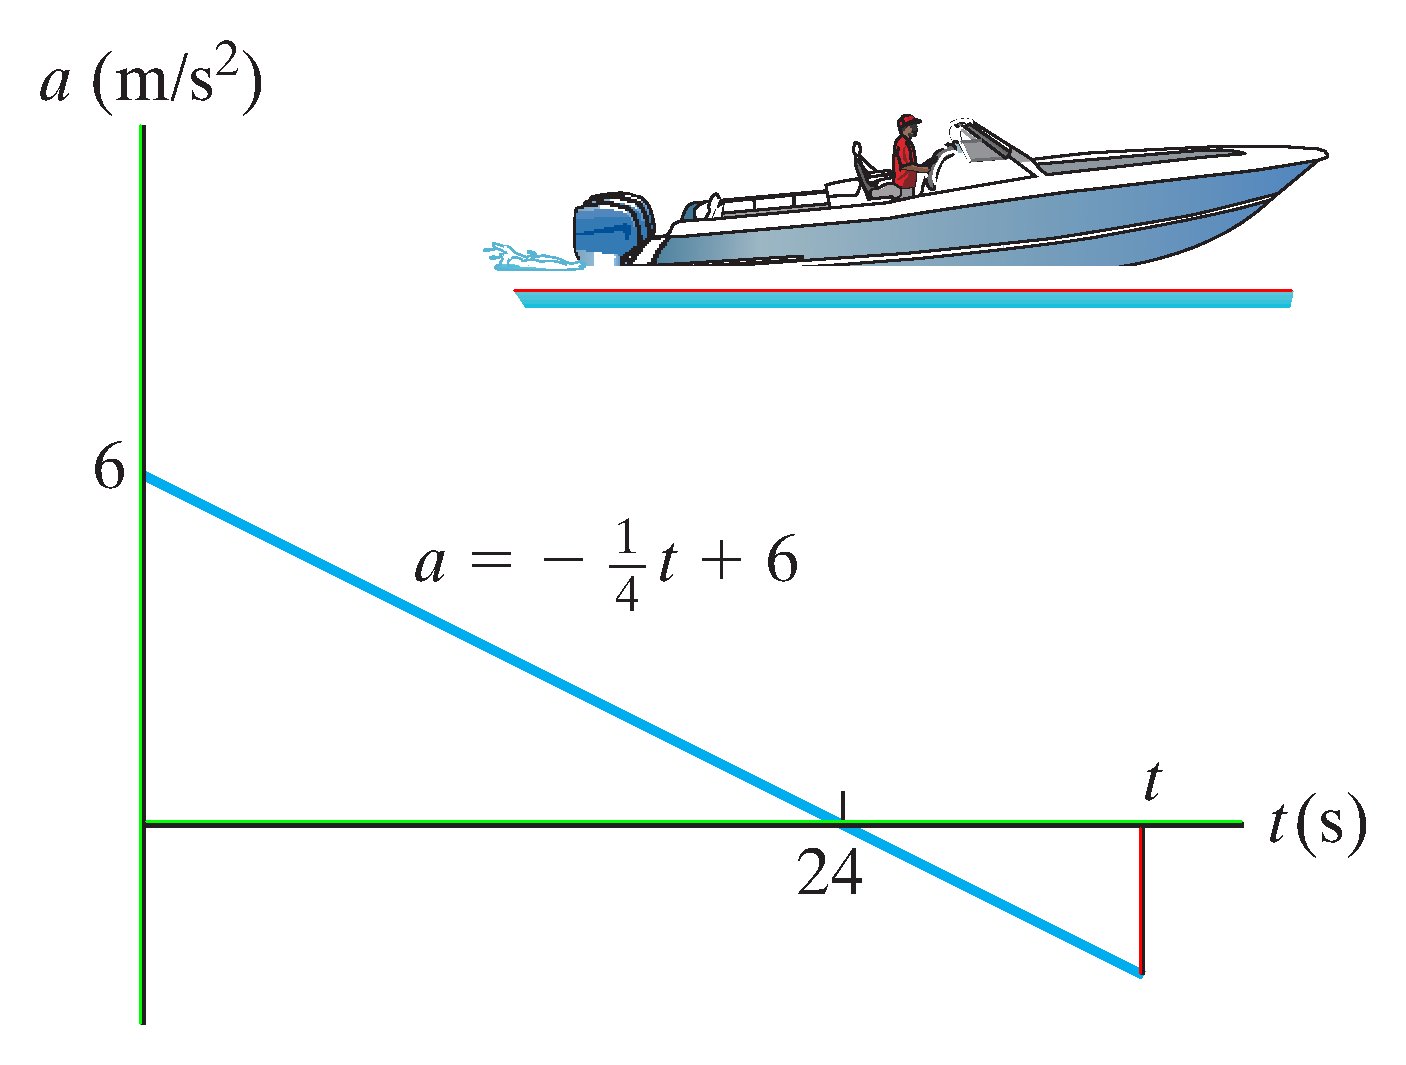

202
202
202
202


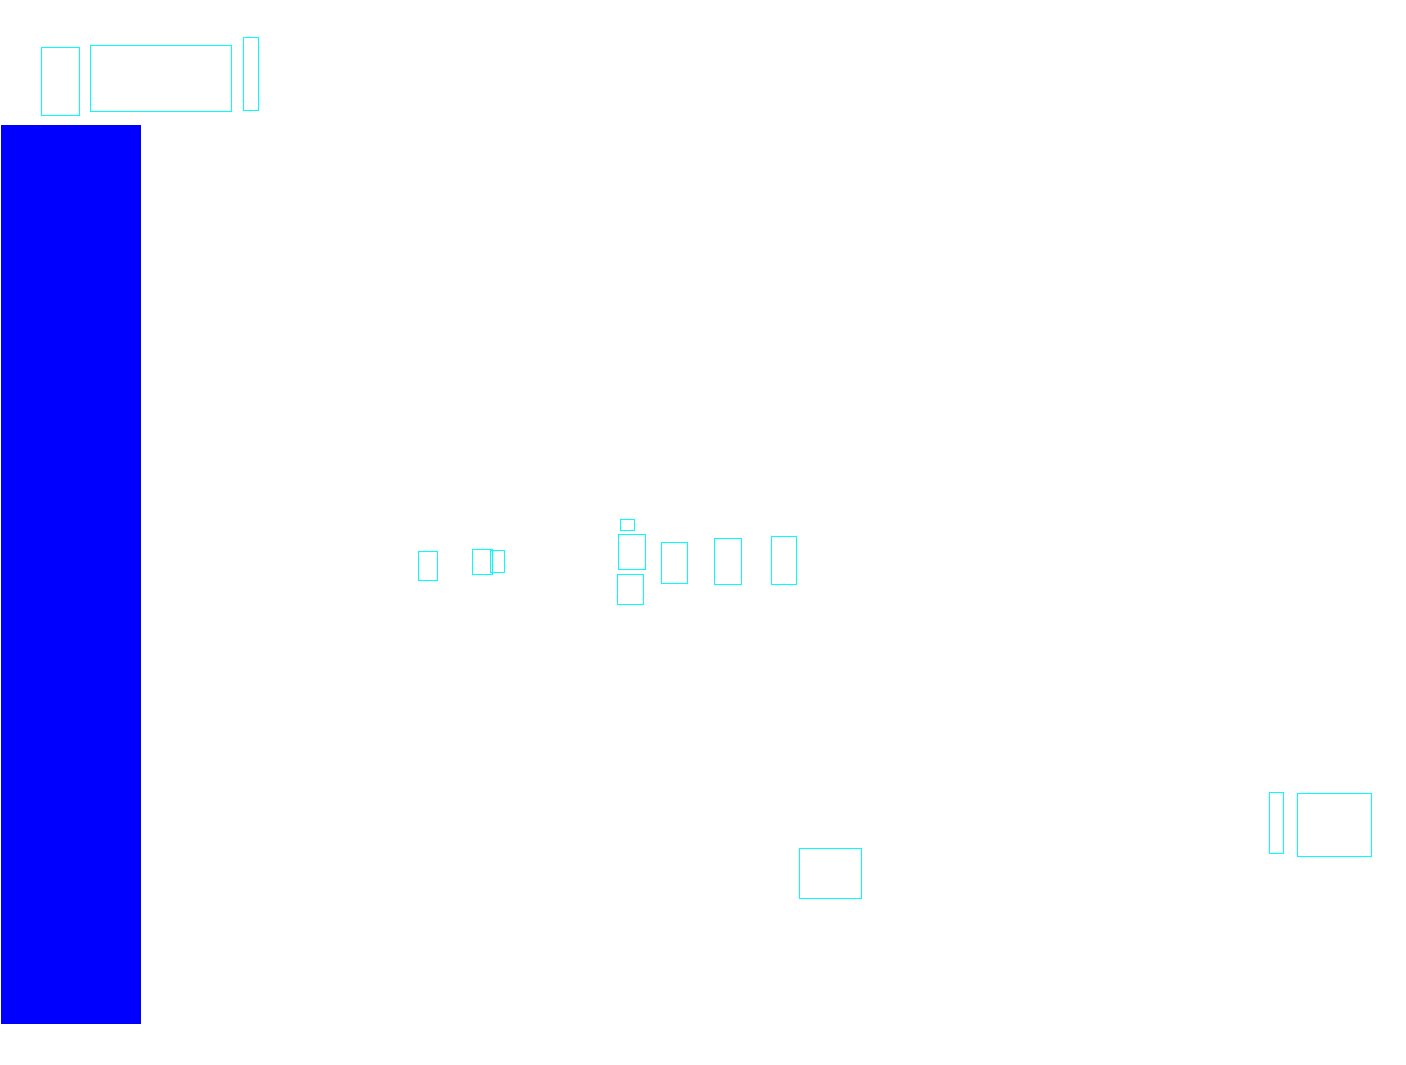

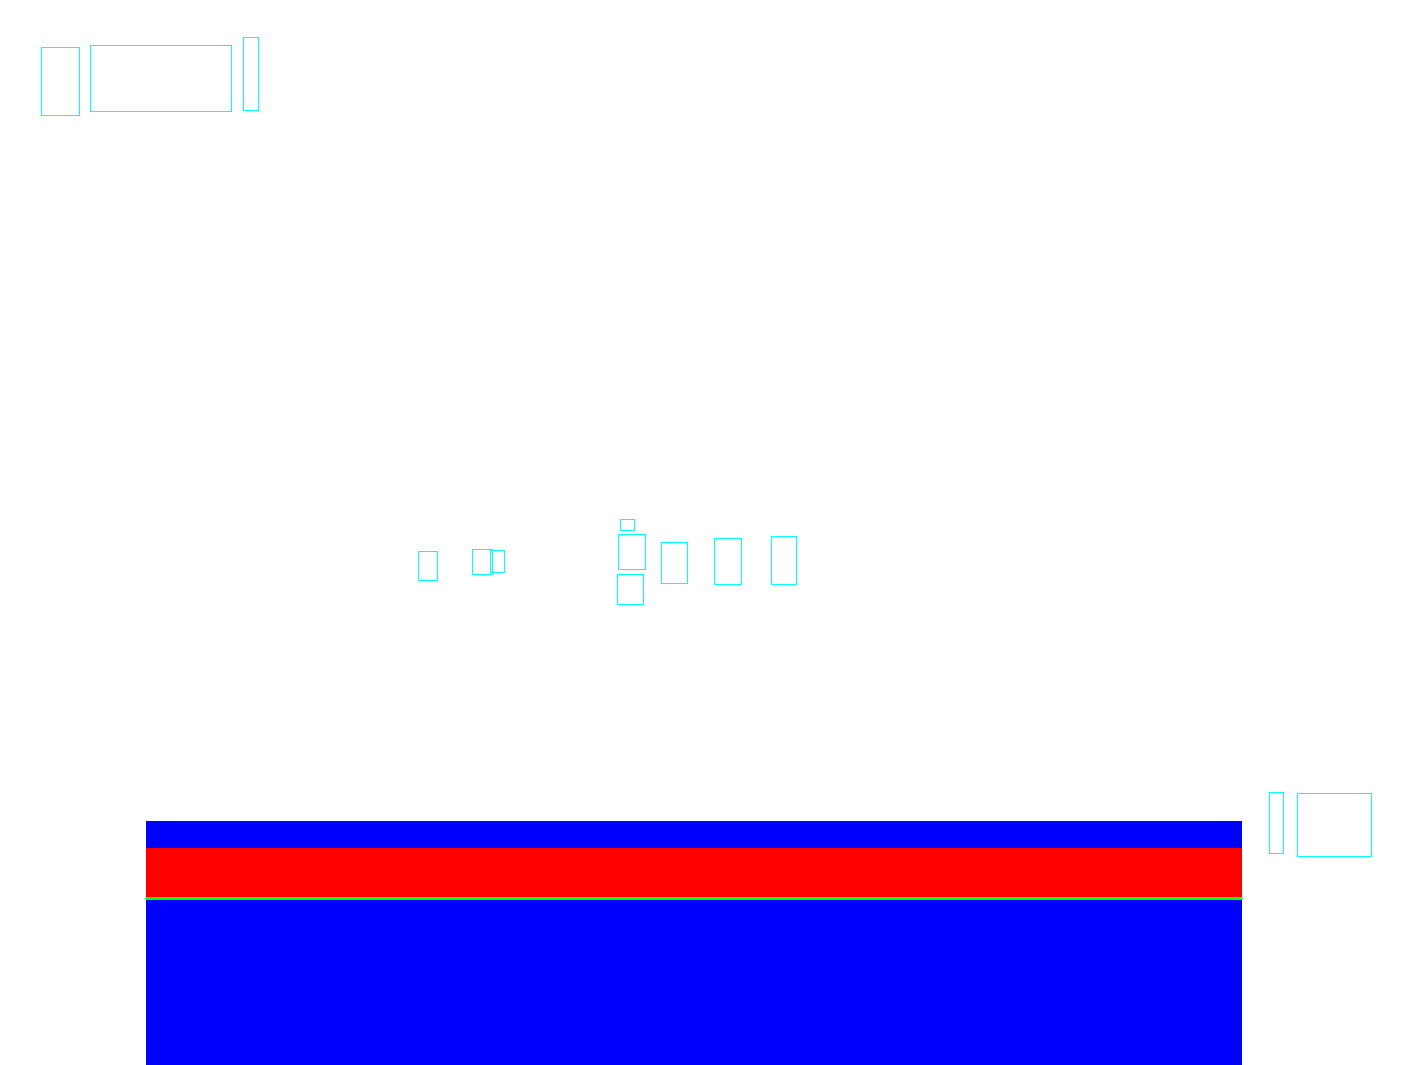

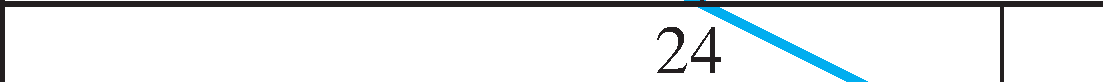

(82, 1105, 3)


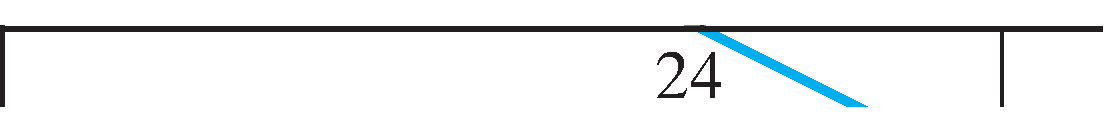

(132, 1105, 3)
202
202
[{'boundingBox': [661, 48, 722, 48, 722, 102, 661, 102], 'text': '24'}]
[{'boundingBox': [661, 23, 722, 23, 722, 77, 661, 77], 'text': '24'}]
[{'boundingBox': [802, 844, 863, 844, 863, 898, 802, 898], 'text': '24'}]
[]
[{'boundingBox': [802, 844, 863, 844, 863, 898, 802, 898], 'text': '24'}]


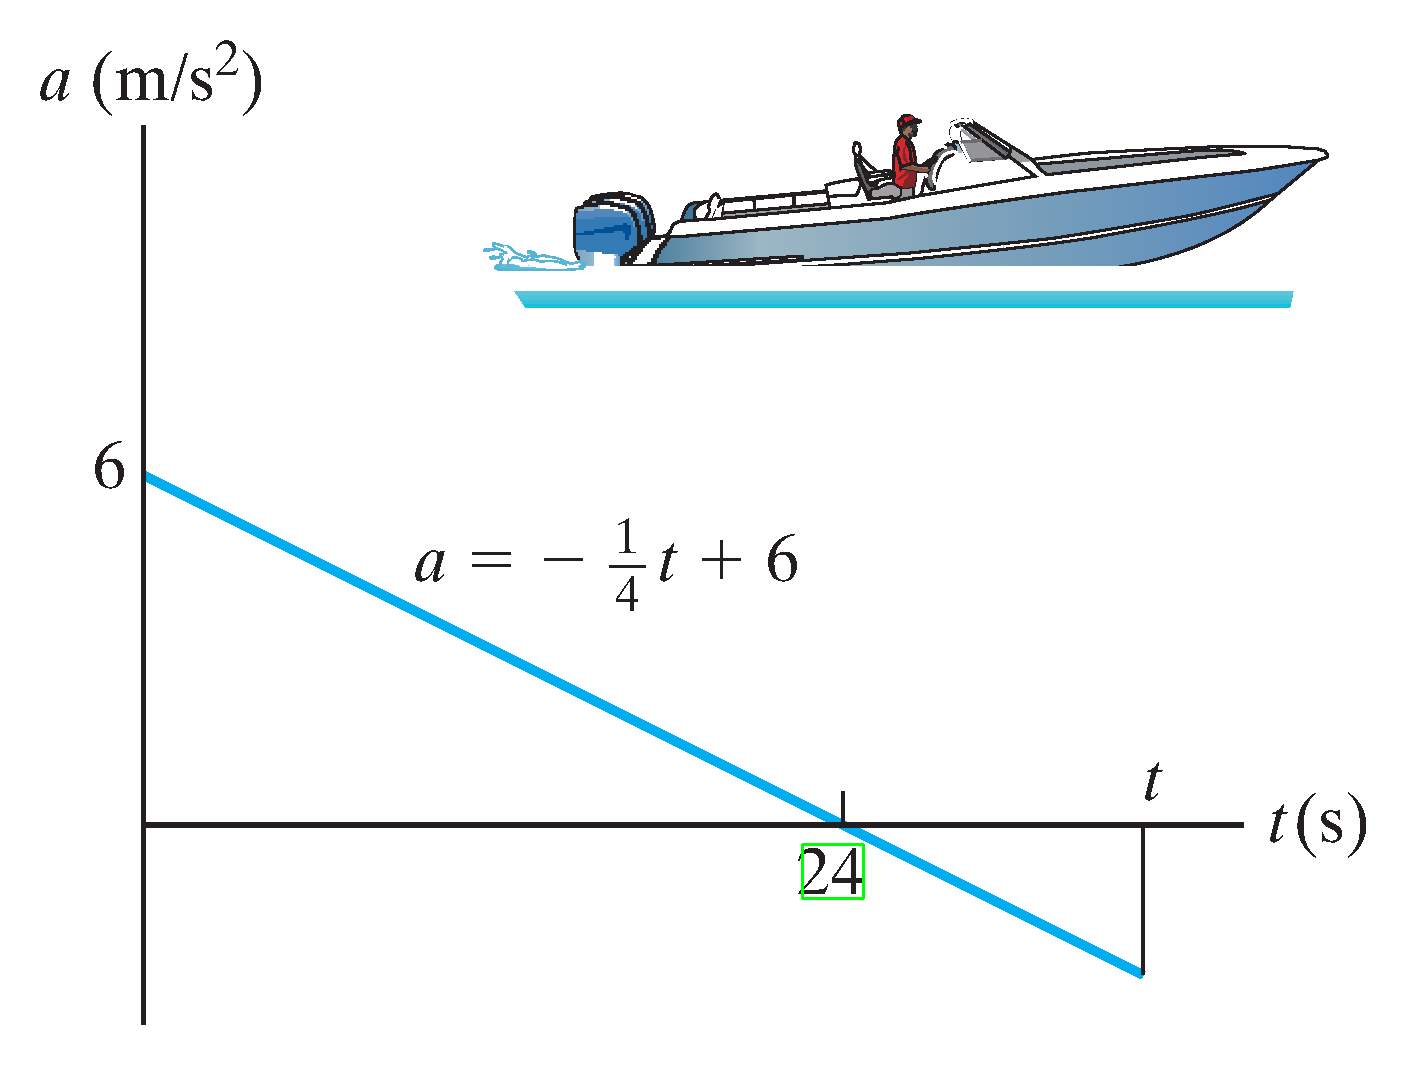

202
202
[[[151, 1072], [1404, 1072]], [[615, 224], [1504, 224]]] [[[150, 430], [150, 1071]], [[495, 585], [495, 1089]]]


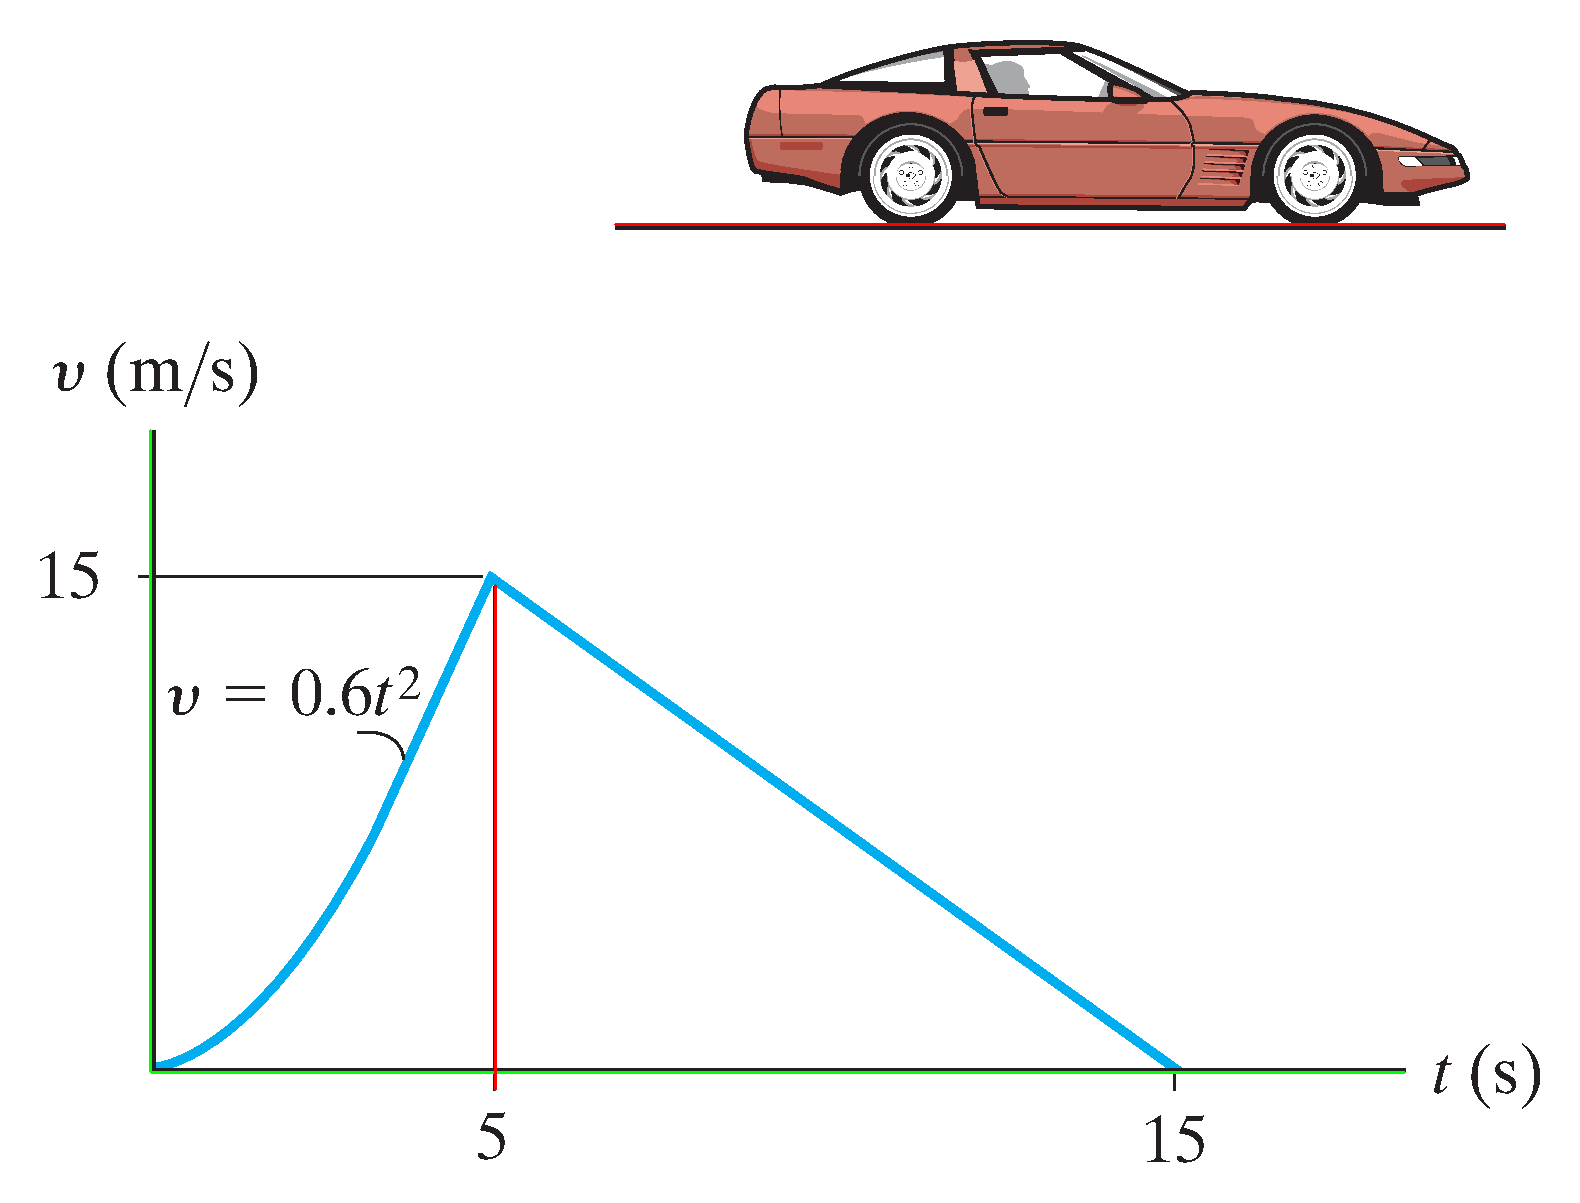

202
202
202


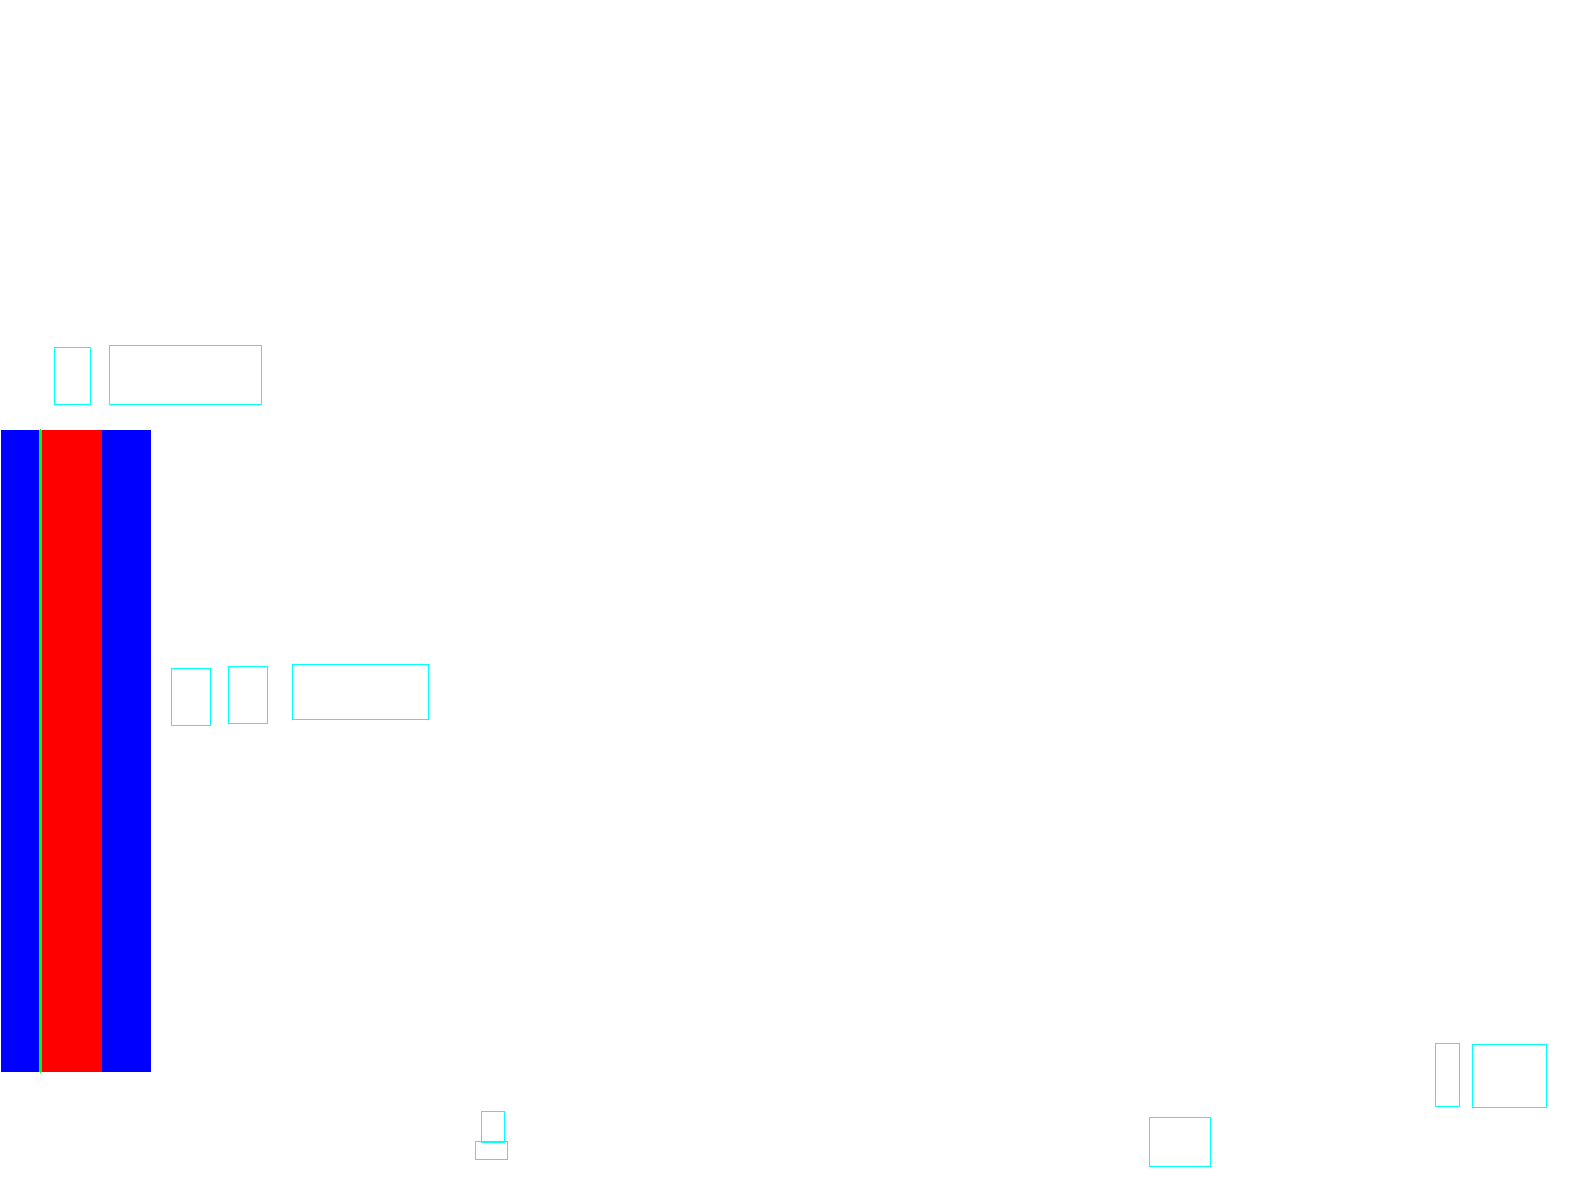

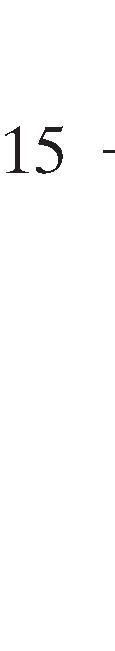

(651, 115, 3)


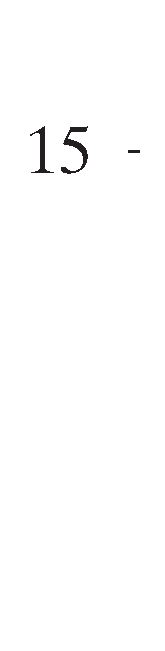

(651, 165, 3)
202
202
[{'boundingBox': [30, 123, 99, 121, 100, 175, 32, 177], 'text': '15'}, {'boundingBox': [127, 120, 138, 120, 140, 174, 129, 174], 'text': '-'}]
[{'boundingBox': [5, 123, 74, 121, 75, 175, 7, 177], 'text': '15'}, {'boundingBox': [102, 120, 113, 120, 115, 174, 104, 174], 'text': '-'}]
[{'boundingBox': [40, 548, 109, 546, 110, 600, 42, 602], 'text': '15'}, {'boundingBox': [137, 545, 148, 545, 150, 599, 139, 599], 'text': '-'}]


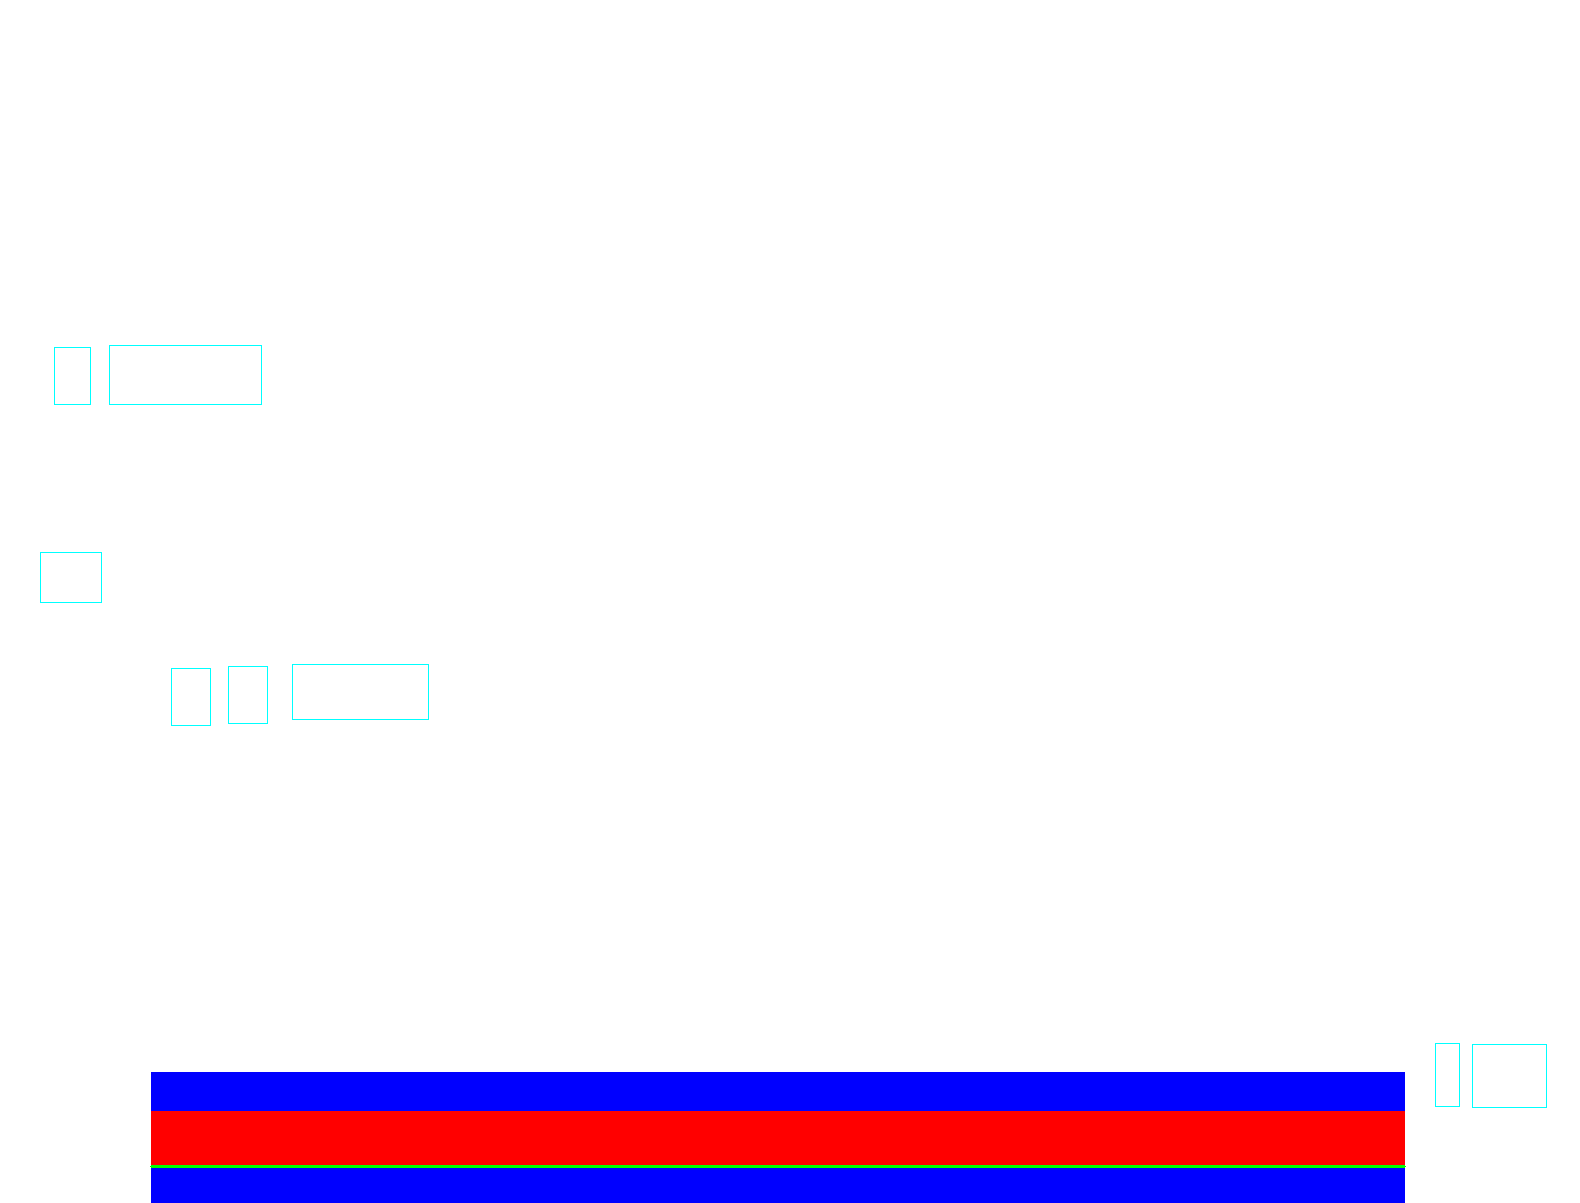

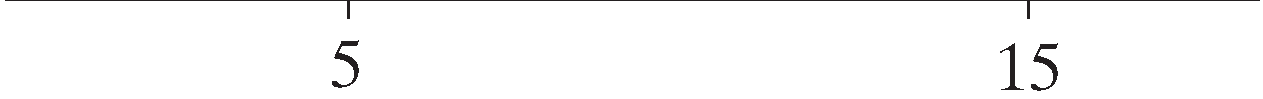

(99, 1263, 3)


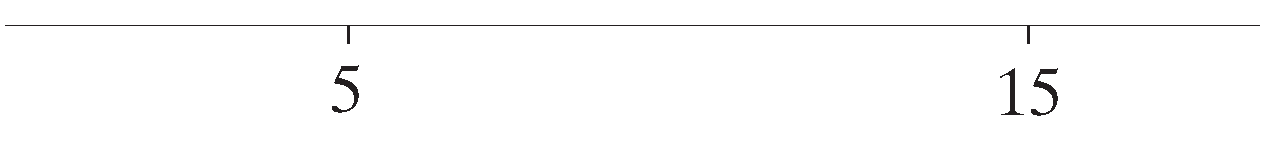

(149, 1263, 3)
202
202
202
[{'boundingBox': [325, 110, 327, 88, 360, 92, 358, 114], 'text': 'U'}, {'boundingBox': [1002, 67, 1057, 67, 1058, 119, 1002, 119], 'text': '15'}, {'boundingBox': [332, 112, 333, 100, 351, 101, 350, 114], 'text': '1', 'confidence': 'Low'}]
[{'boundingBox': [325, 85, 327, 63, 360, 67, 358, 89], 'text': 'U'}, {'boundingBox': [1002, 42, 1057, 42, 1058, 94, 1002, 94], 'text': '15'}, {'boundingBox': [332, 87, 333, 75, 351, 76, 350, 89], 'text': '1', 'confidence': 'Low'}]
[{'boundingBox': [471, 1157, 473, 1135, 506, 1139, 504, 1161], 'text': 'U'}, {'boundingBox': [1148, 1114, 1203, 1114, 1204, 1166, 1148, 1166], 'text': '15'}, {'boundingBox': [478, 1159, 479, 1147, 497, 1148, 496, 1161], 'text': '1', 'confidence': 'Low'}]
[{'boundingBox': [40, 548, 109, 546, 110, 600, 42, 602], 'text': '15'}, {'boundingBox': [137, 545, 148, 545, 150, 599, 139, 599], 'text': '-'}]
[{'boundingBox': [471, 1157, 473, 1135, 506, 1139, 504, 1161], 'text': 'U'}, {'boundingBox': [1148, 1114

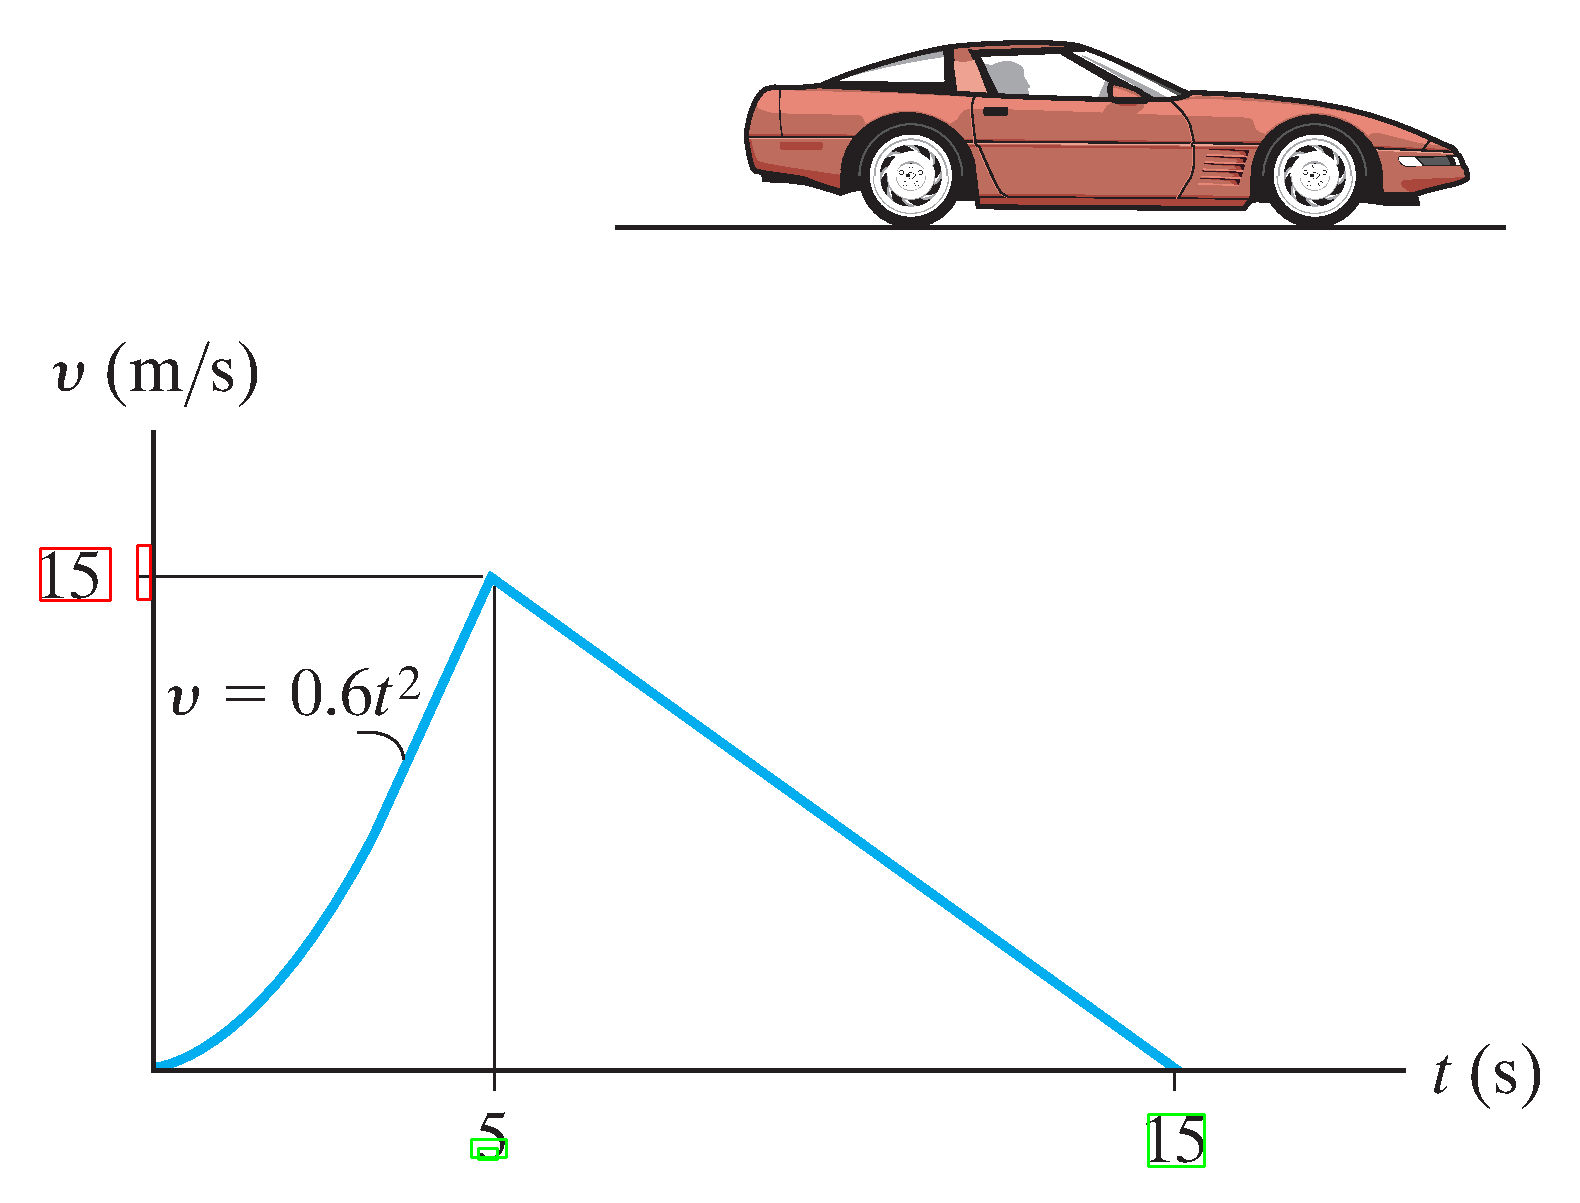

202
202
202
[[[140, 864], [1476, 864]], [[774, 326], [1623, 326]]] [[[139, 185], [139, 863]], [[819, 436], [819, 858]]]


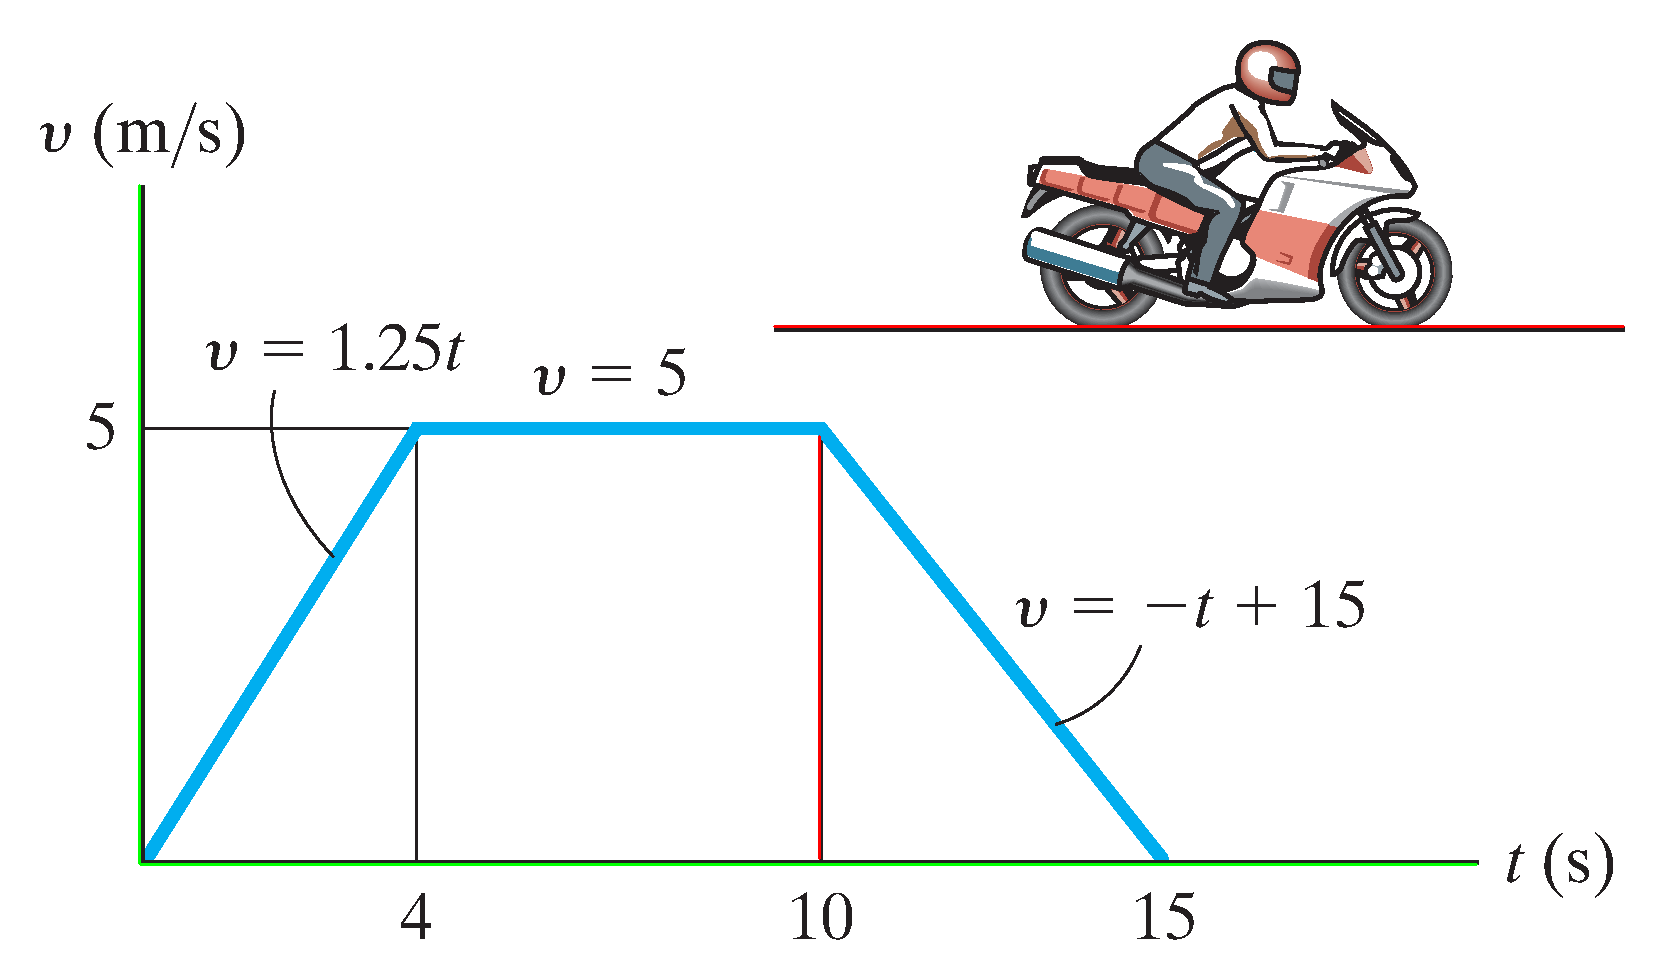

202
202
202


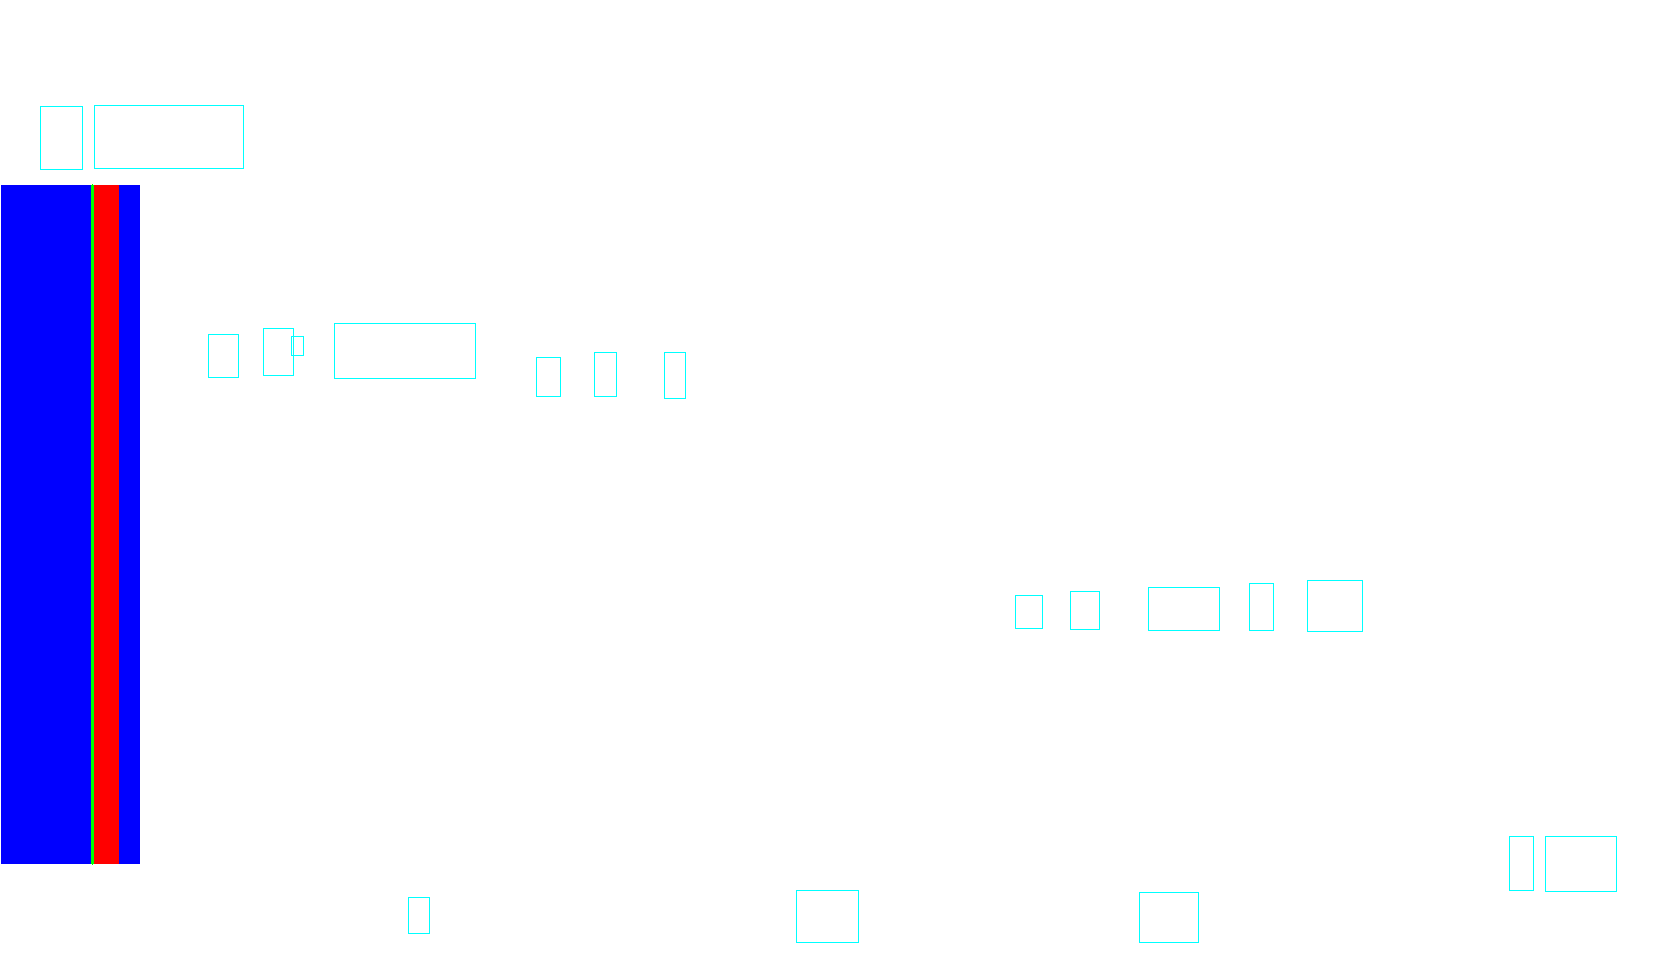

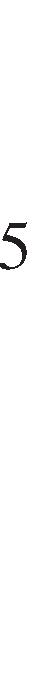

(688, 52, 3)


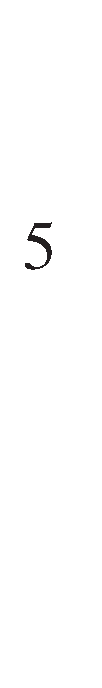

(688, 102, 3)
202
202
[{'boundingBox': [19, 269, 22, 245, 54, 249, 51, 272], 'text': 'U'}]
[{'boundingBox': [-6, 269, -3, 245, 29, 249, 26, 272], 'text': 'U'}]
[{'boundingBox': [81, 449, 84, 425, 116, 429, 113, 452], 'text': 'U'}]


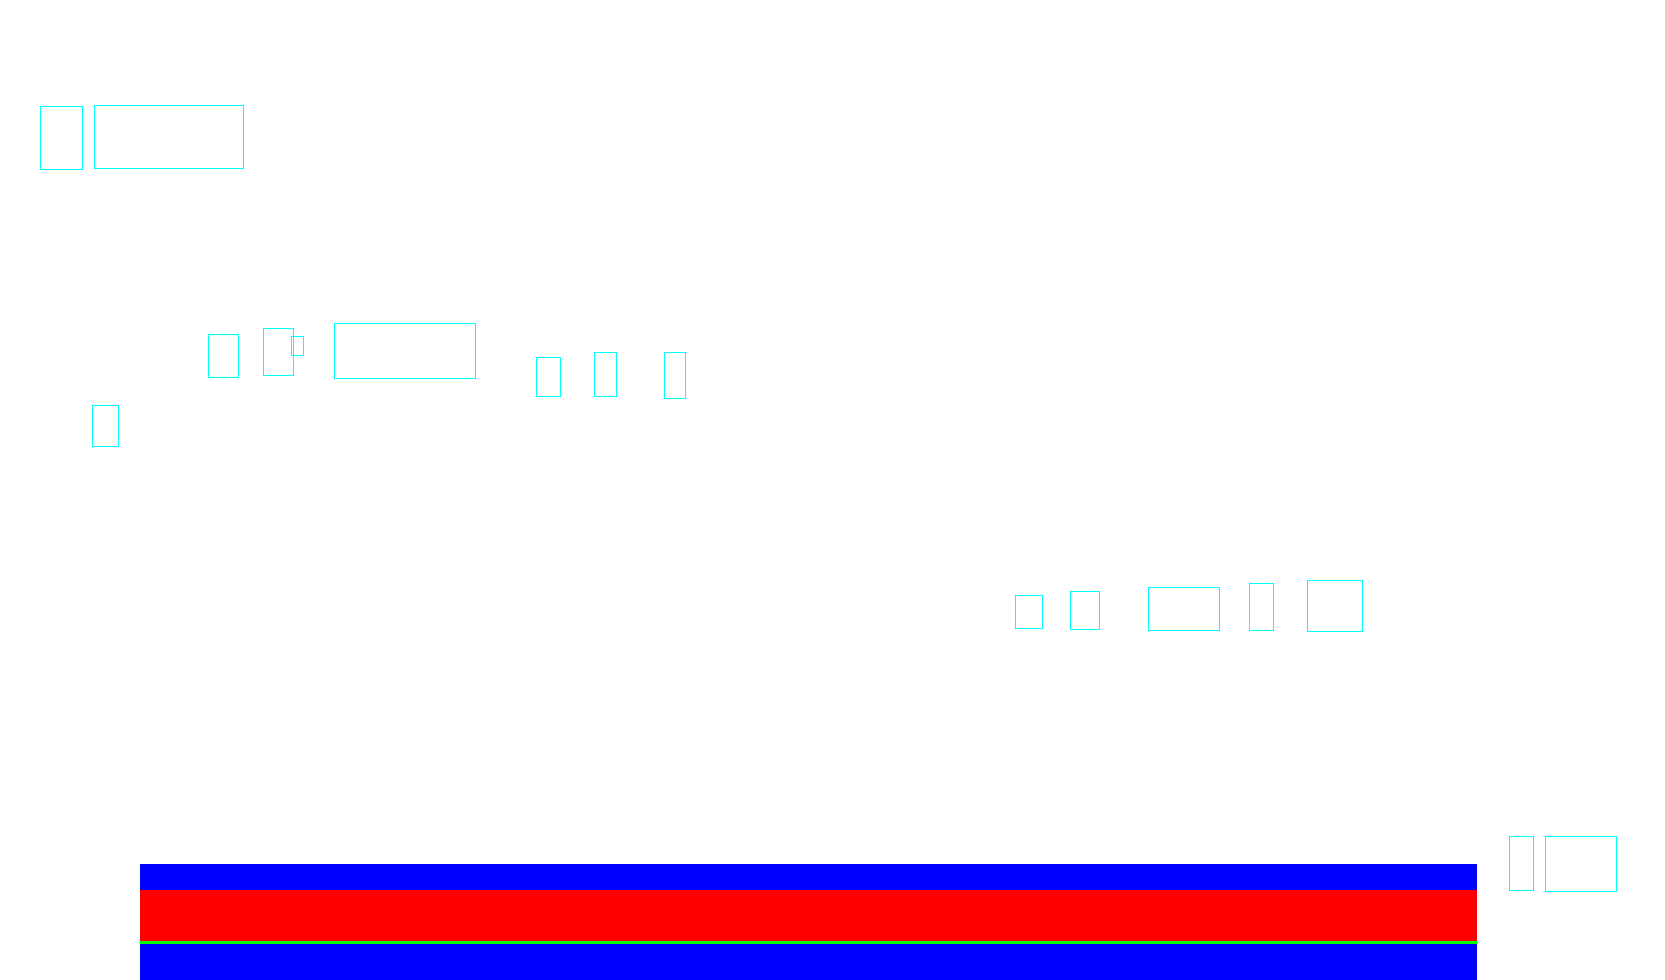

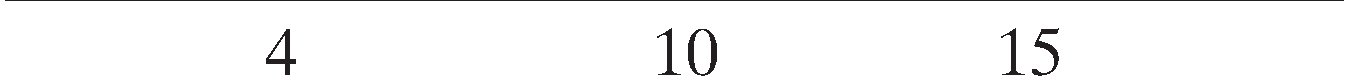

(83, 1346, 3)


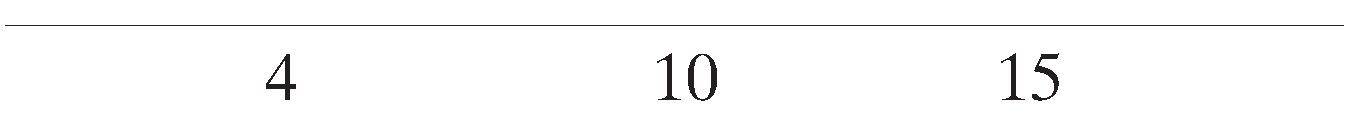

(133, 1346, 3)
202
202
[{'boundingBox': [270, 56, 293, 55, 295, 97, 273, 98], 'text': '4'}, {'boundingBox': [658, 51, 717, 50, 718, 101, 659, 103], 'text': '10'}, {'boundingBox': [1002, 52, 1060, 52, 1060, 103, 1002, 103], 'text': '15'}]
[{'boundingBox': [270, 31, 293, 30, 295, 72, 273, 73], 'text': '4'}, {'boundingBox': [658, 26, 717, 25, 718, 76, 659, 78], 'text': '10'}, {'boundingBox': [1002, 27, 1060, 27, 1060, 78, 1002, 78], 'text': '15'}]
[{'boundingBox': [405, 895, 428, 894, 430, 936, 408, 937], 'text': '4'}, {'boundingBox': [793, 890, 852, 889, 853, 940, 794, 942], 'text': '10'}, {'boundingBox': [1137, 891, 1195, 891, 1195, 942, 1137, 942], 'text': '15'}]
[{'boundingBox': [81, 449, 84, 425, 116, 429, 113, 452], 'text': 'U'}]
[{'boundingBox': [405, 895, 428, 894, 430, 936, 408, 937], 'text': '4'}, {'boundingBox': [793, 890, 852, 889, 853, 940, 794, 942], 'text': '10'}, {'boundingBox': [1137, 891, 1195, 891, 1195, 942, 1137, 942], 'text': '15'}]


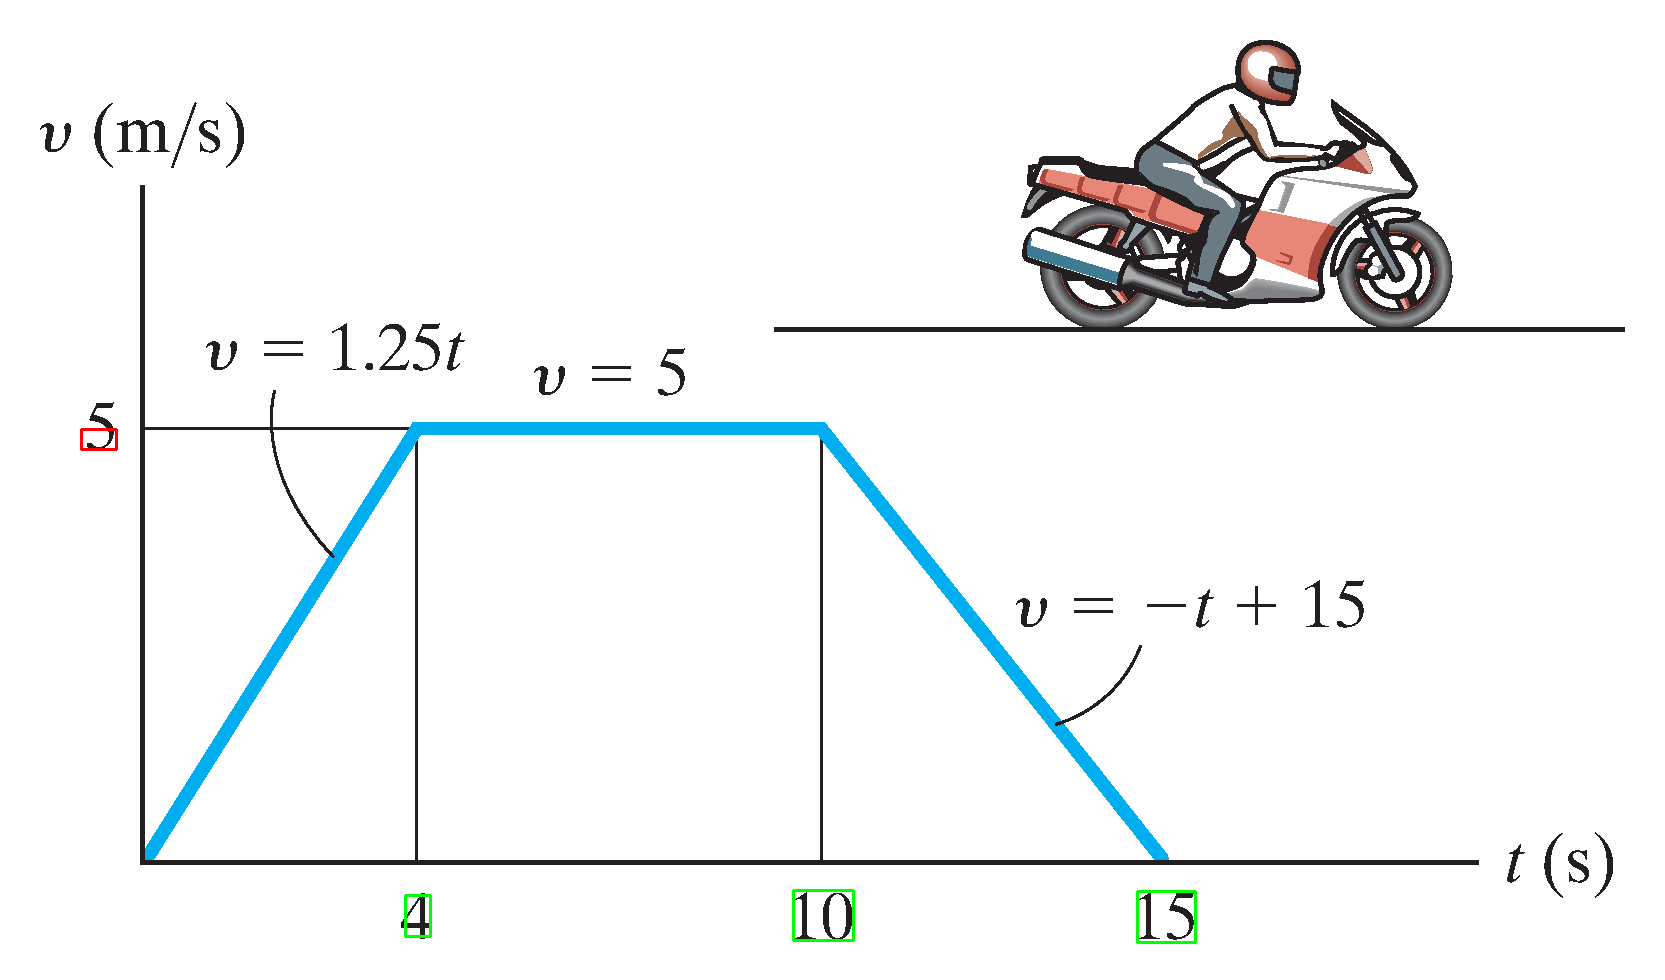

202
202
[[[143, 1291], [1828, 1291]], [[310, 253], [1958, 253]]] [[[137, 139], [137, 1283]], [[1531, 498], [1531, 1285]]]


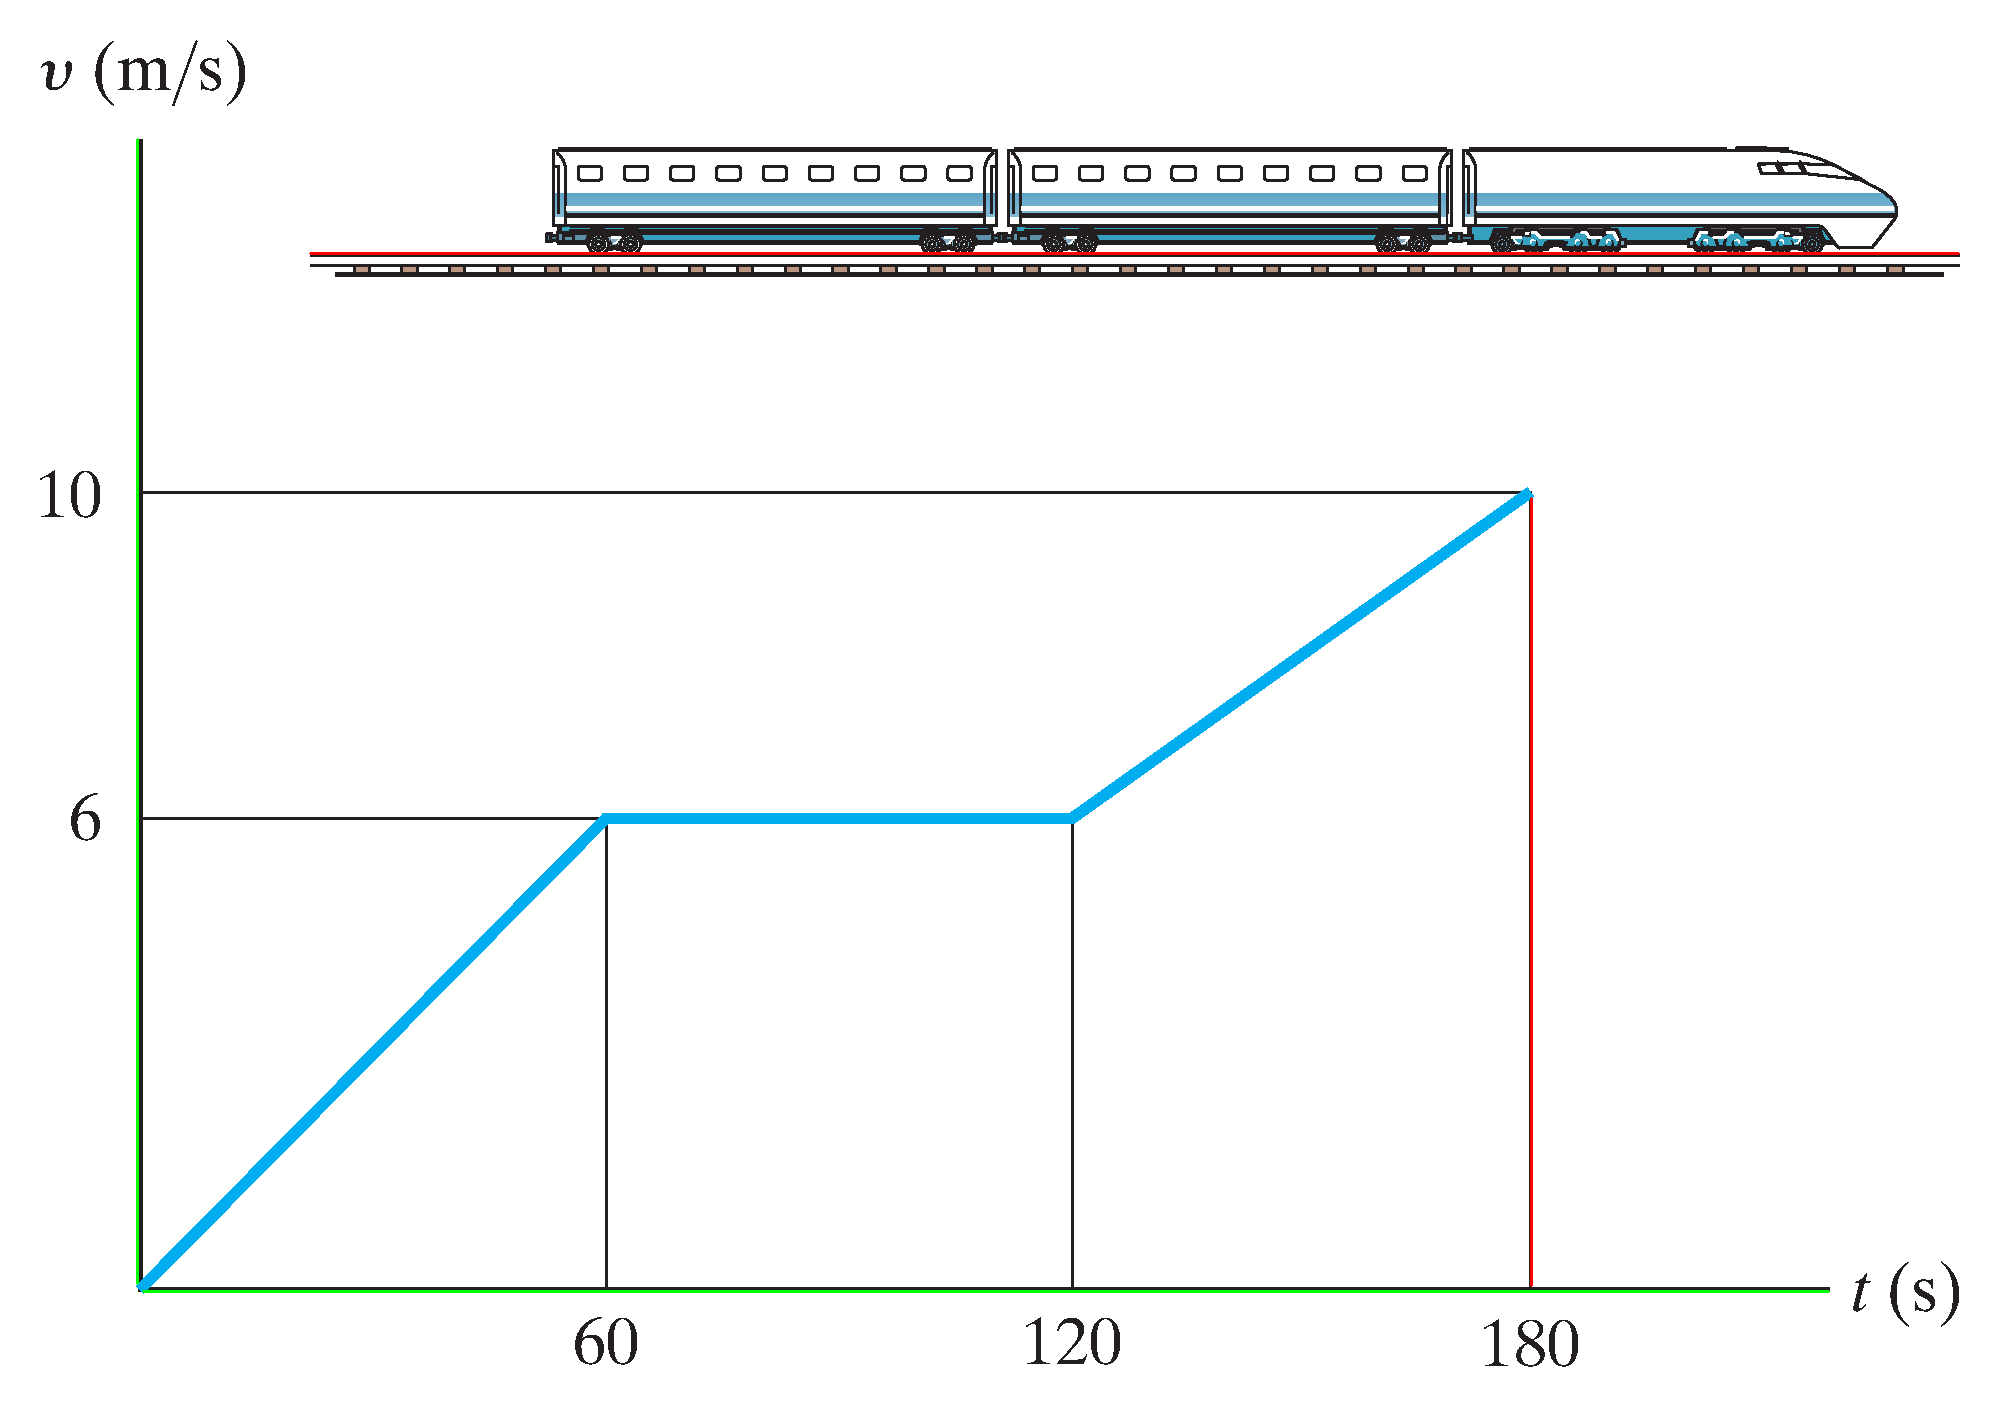

202
202
202


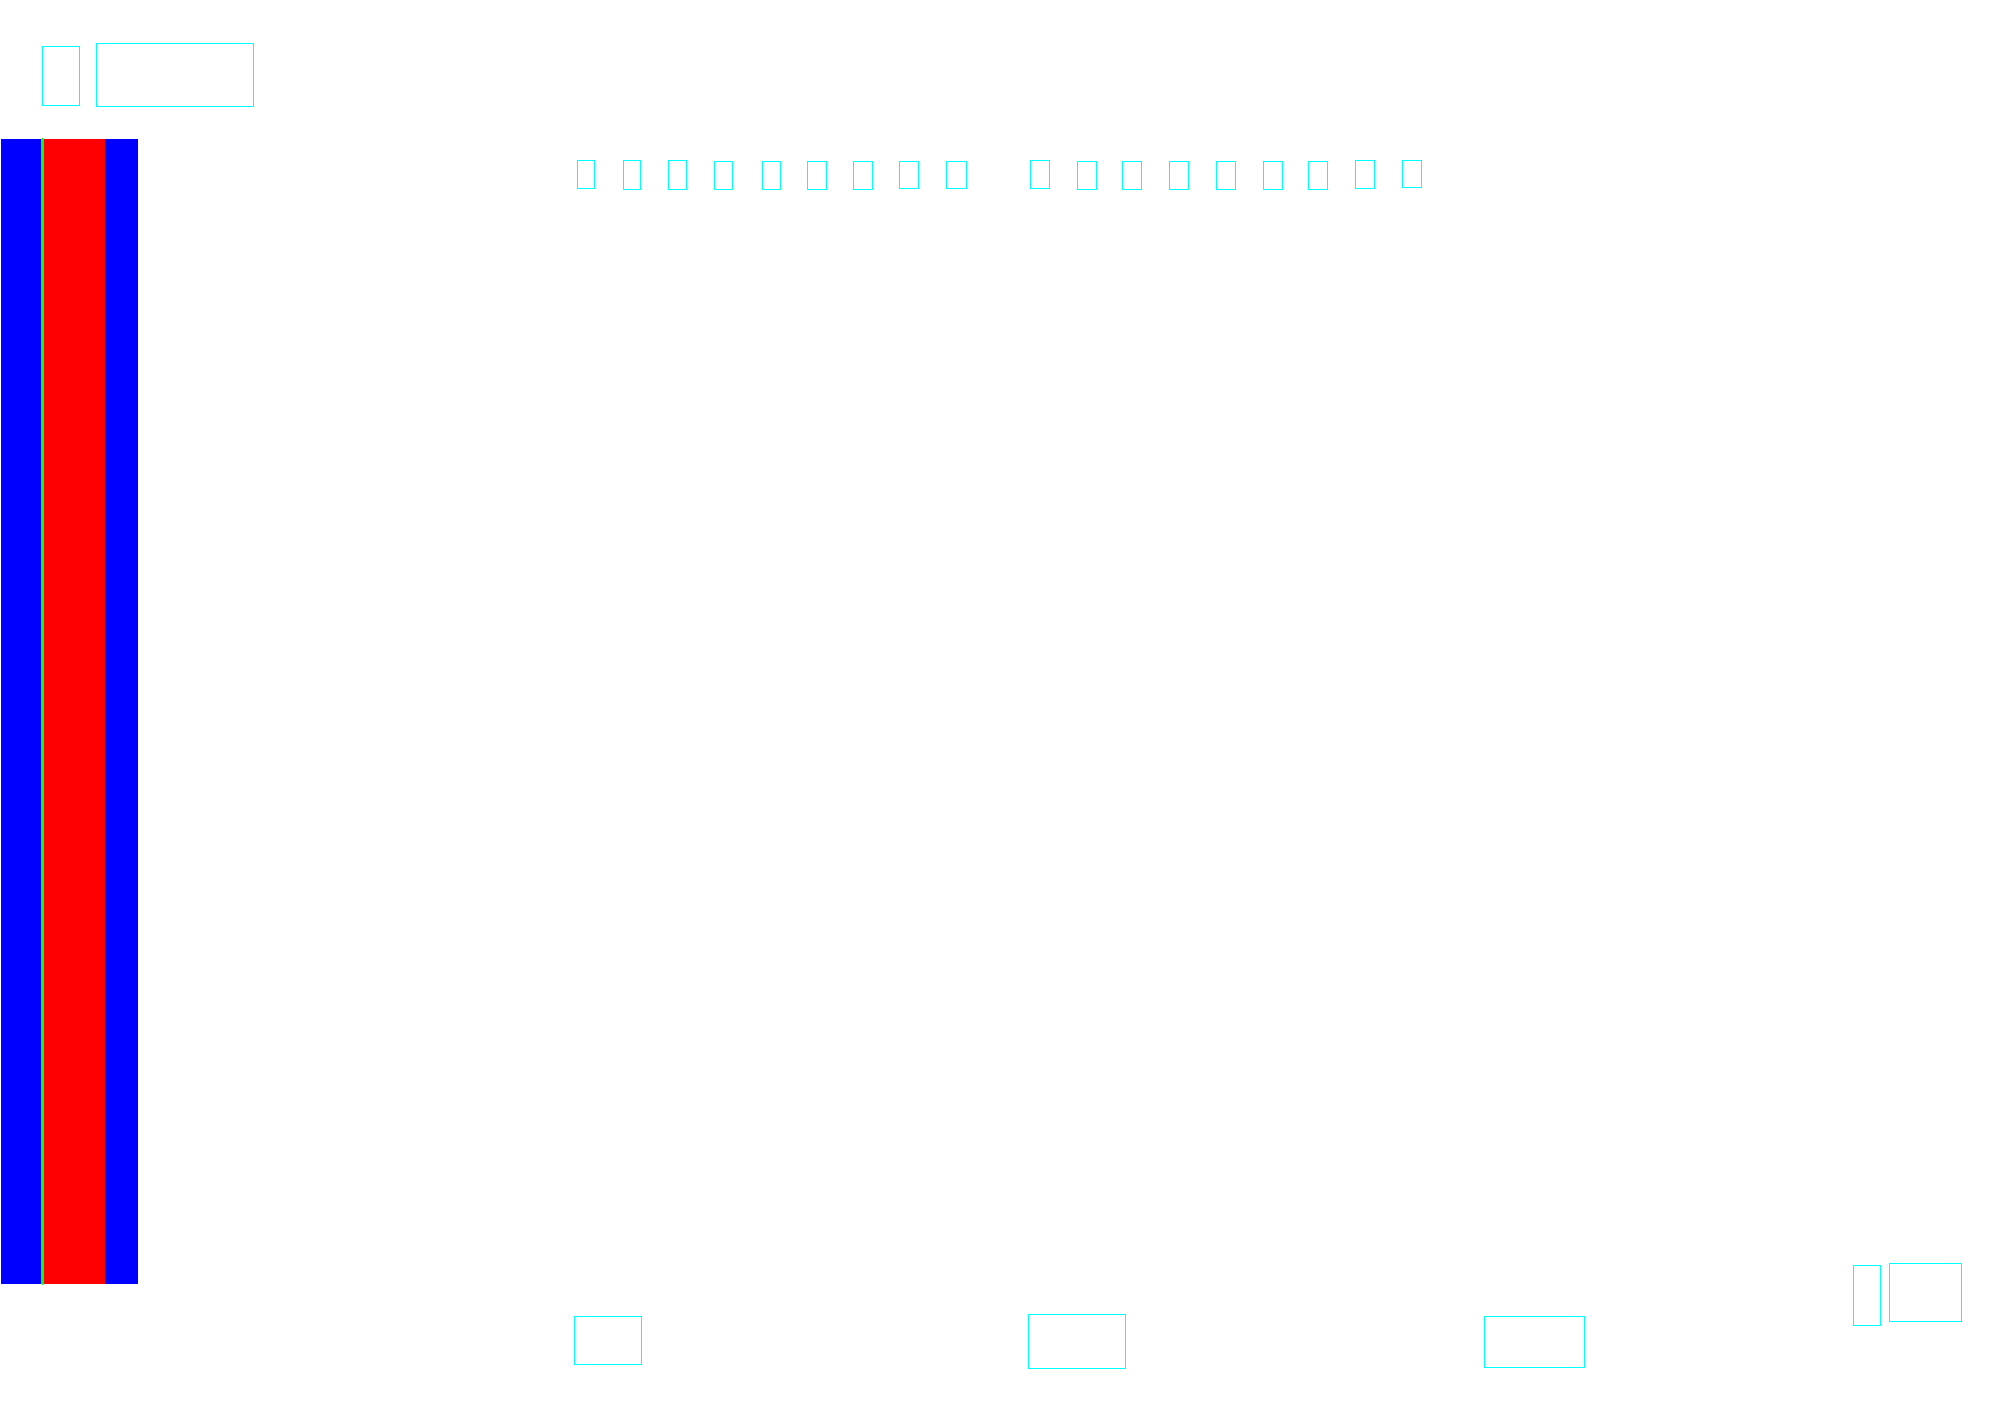

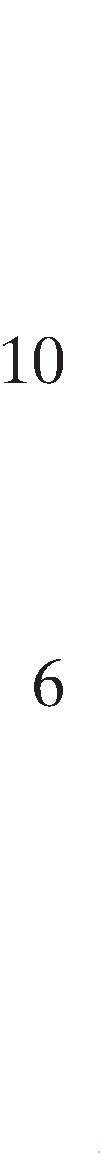

(1154, 100, 3)


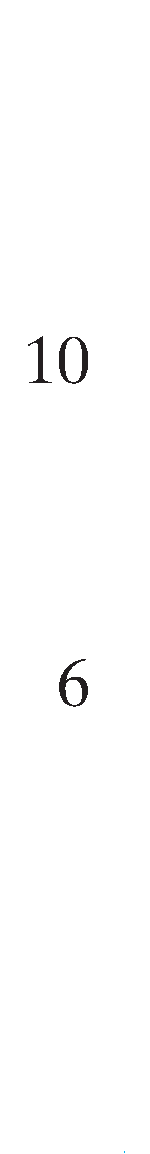

(1154, 150, 3)
202
202
[{'boundingBox': [30, 334, 88, 334, 88, 385, 30, 385], 'text': '10'}, {'boundingBox': [60, 660, 89, 661, 88, 705, 59, 704], 'text': '6'}]
[{'boundingBox': [5, 334, 63, 334, 63, 385, 5, 385], 'text': '10'}, {'boundingBox': [35, 660, 64, 661, 63, 705, 34, 704], 'text': '6'}]
[{'boundingBox': [42, 468, 100, 468, 100, 519, 42, 519], 'text': '10'}, {'boundingBox': [72, 794, 101, 795, 100, 839, 71, 838], 'text': '6'}]


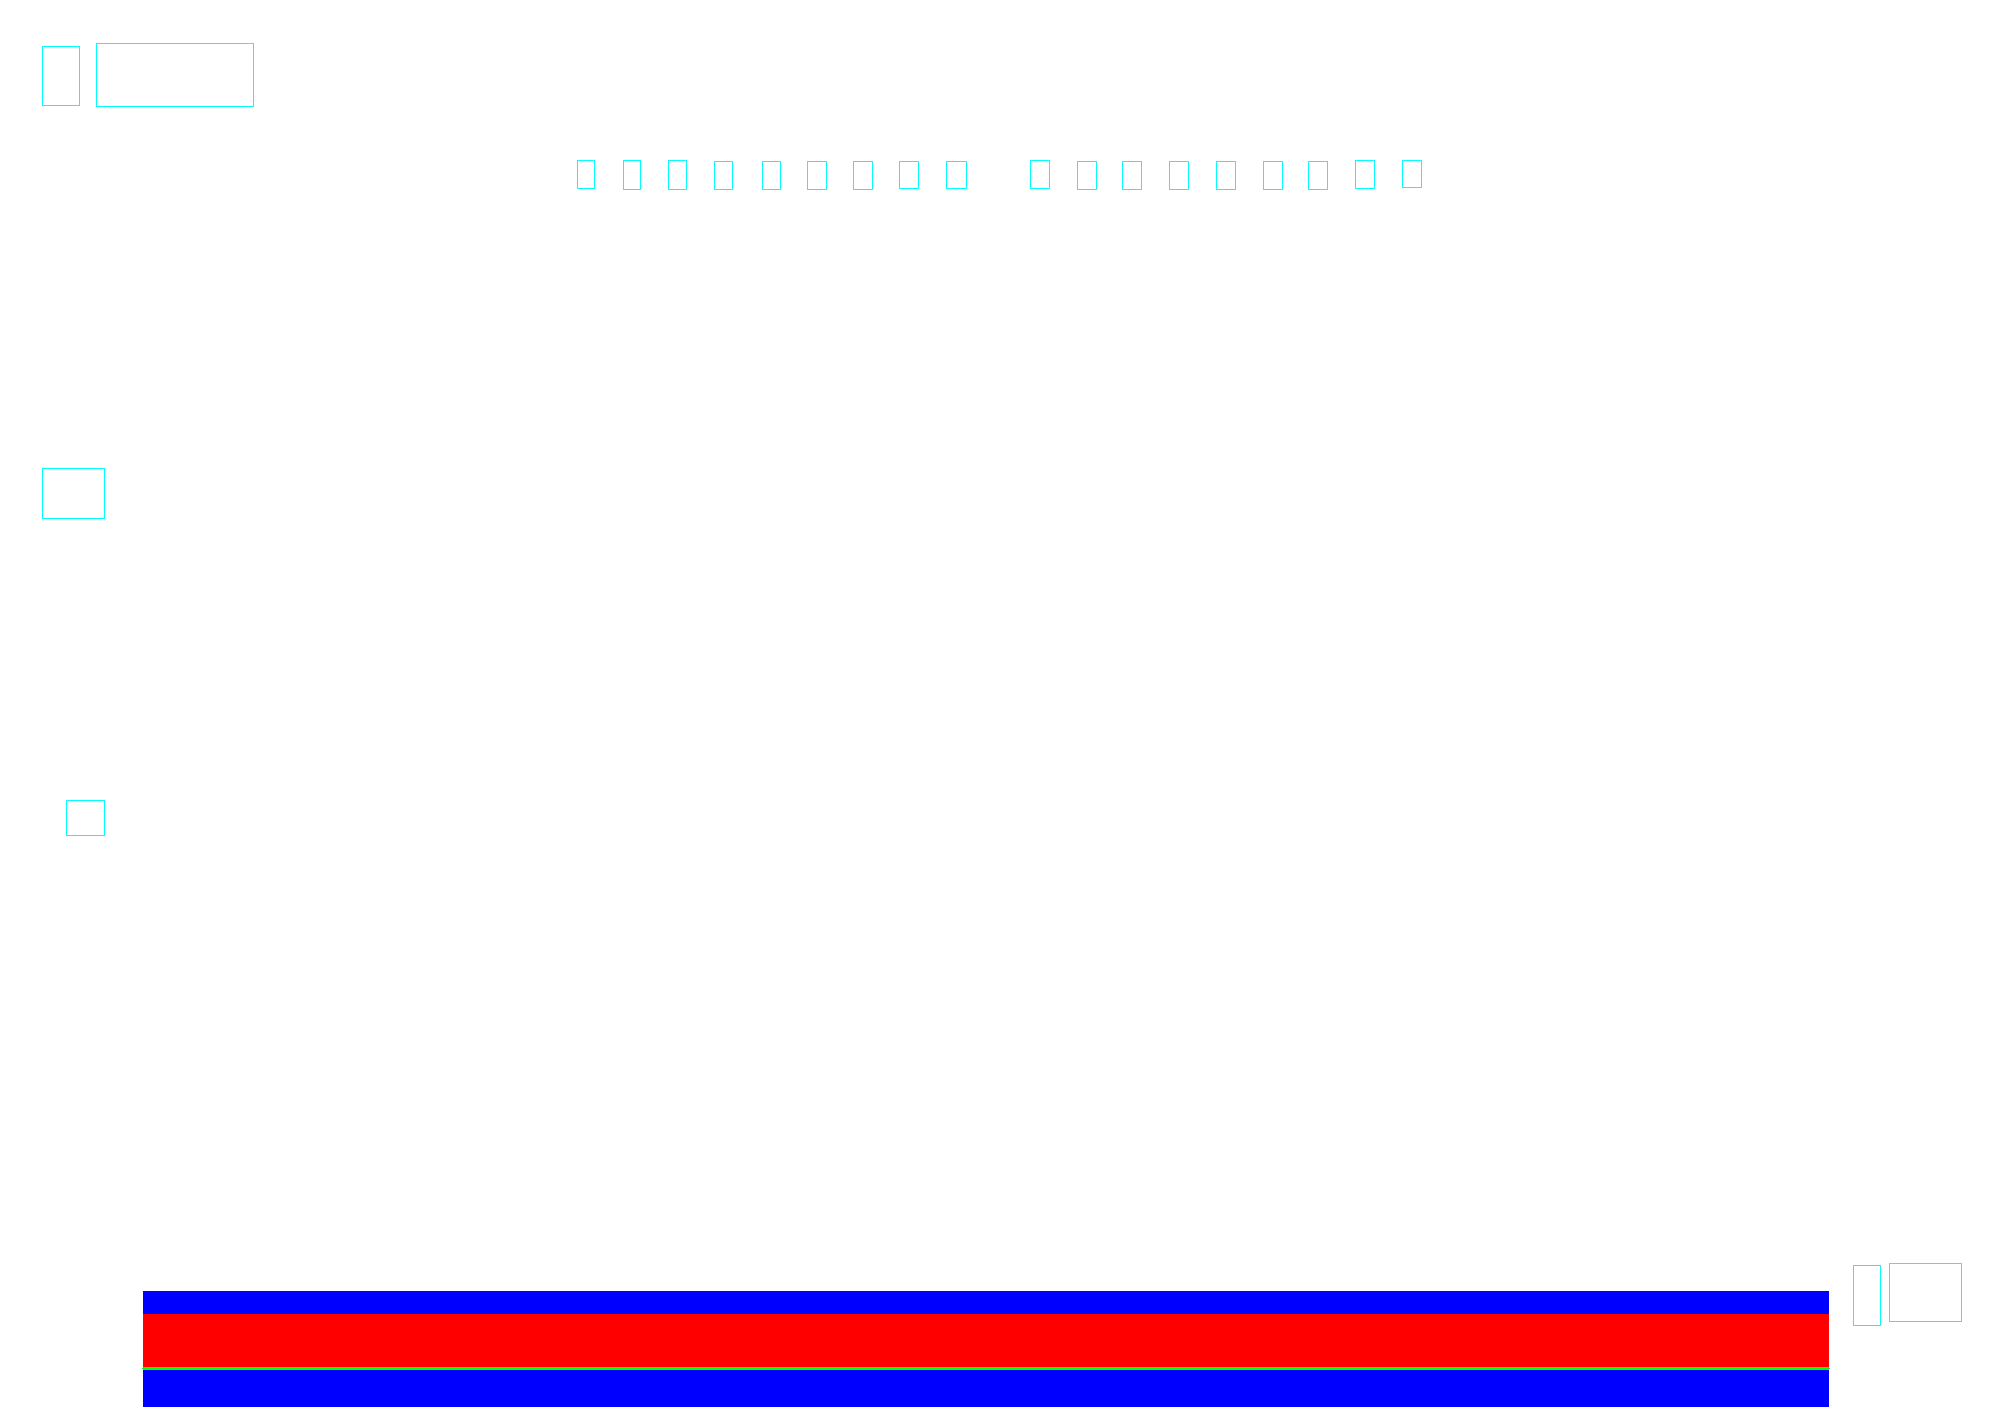

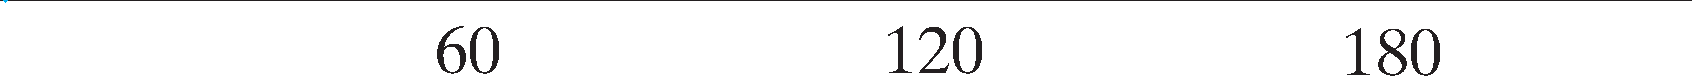

(82, 1695, 3)


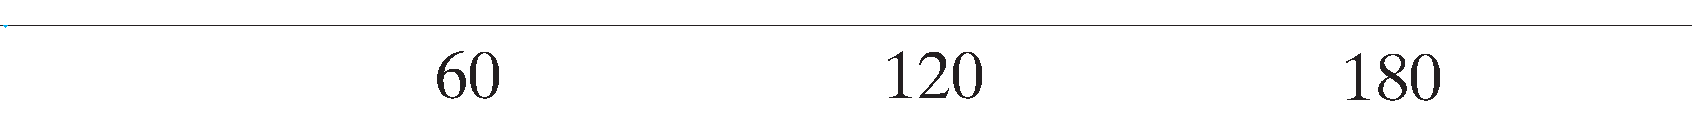

(132, 1695, 3)
202
202
[{'boundingBox': [436, 51, 495, 48, 497, 100, 438, 103], 'text': '60'}, {'boundingBox': [893, 48, 981, 49, 980, 102, 892, 101], 'text': '120'}, {'boundingBox': [1347, 51, 1441, 51, 1441, 103, 1347, 103], 'text': '180'}]
[{'boundingBox': [436, 26, 495, 23, 497, 75, 438, 78], 'text': '60'}, {'boundingBox': [893, 23, 981, 24, 980, 77, 892, 76], 'text': '120'}, {'boundingBox': [1347, 26, 1441, 26, 1441, 78, 1347, 78], 'text': '180'}]
[{'boundingBox': [574, 1317, 633, 1314, 635, 1366, 576, 1369], 'text': '60'}, {'boundingBox': [1031, 1314, 1119, 1315, 1118, 1368, 1030, 1367], 'text': '120'}, {'boundingBox': [1485, 1317, 1579, 1317, 1579, 1369, 1485, 1369], 'text': '180'}]
[{'boundingBox': [42, 468, 100, 468, 100, 519, 42, 519], 'text': '10'}, {'boundingBox': [72, 794, 101, 795, 100, 839, 71, 838], 'text': '6'}]
[{'boundingBox': [574, 1317, 633, 1314, 635, 1366, 576, 1369], 'text': '60'}, {'boundingBox': [1031, 1314, 1119, 1315, 1118, 1368, 1030, 1367], 'text': '120'},

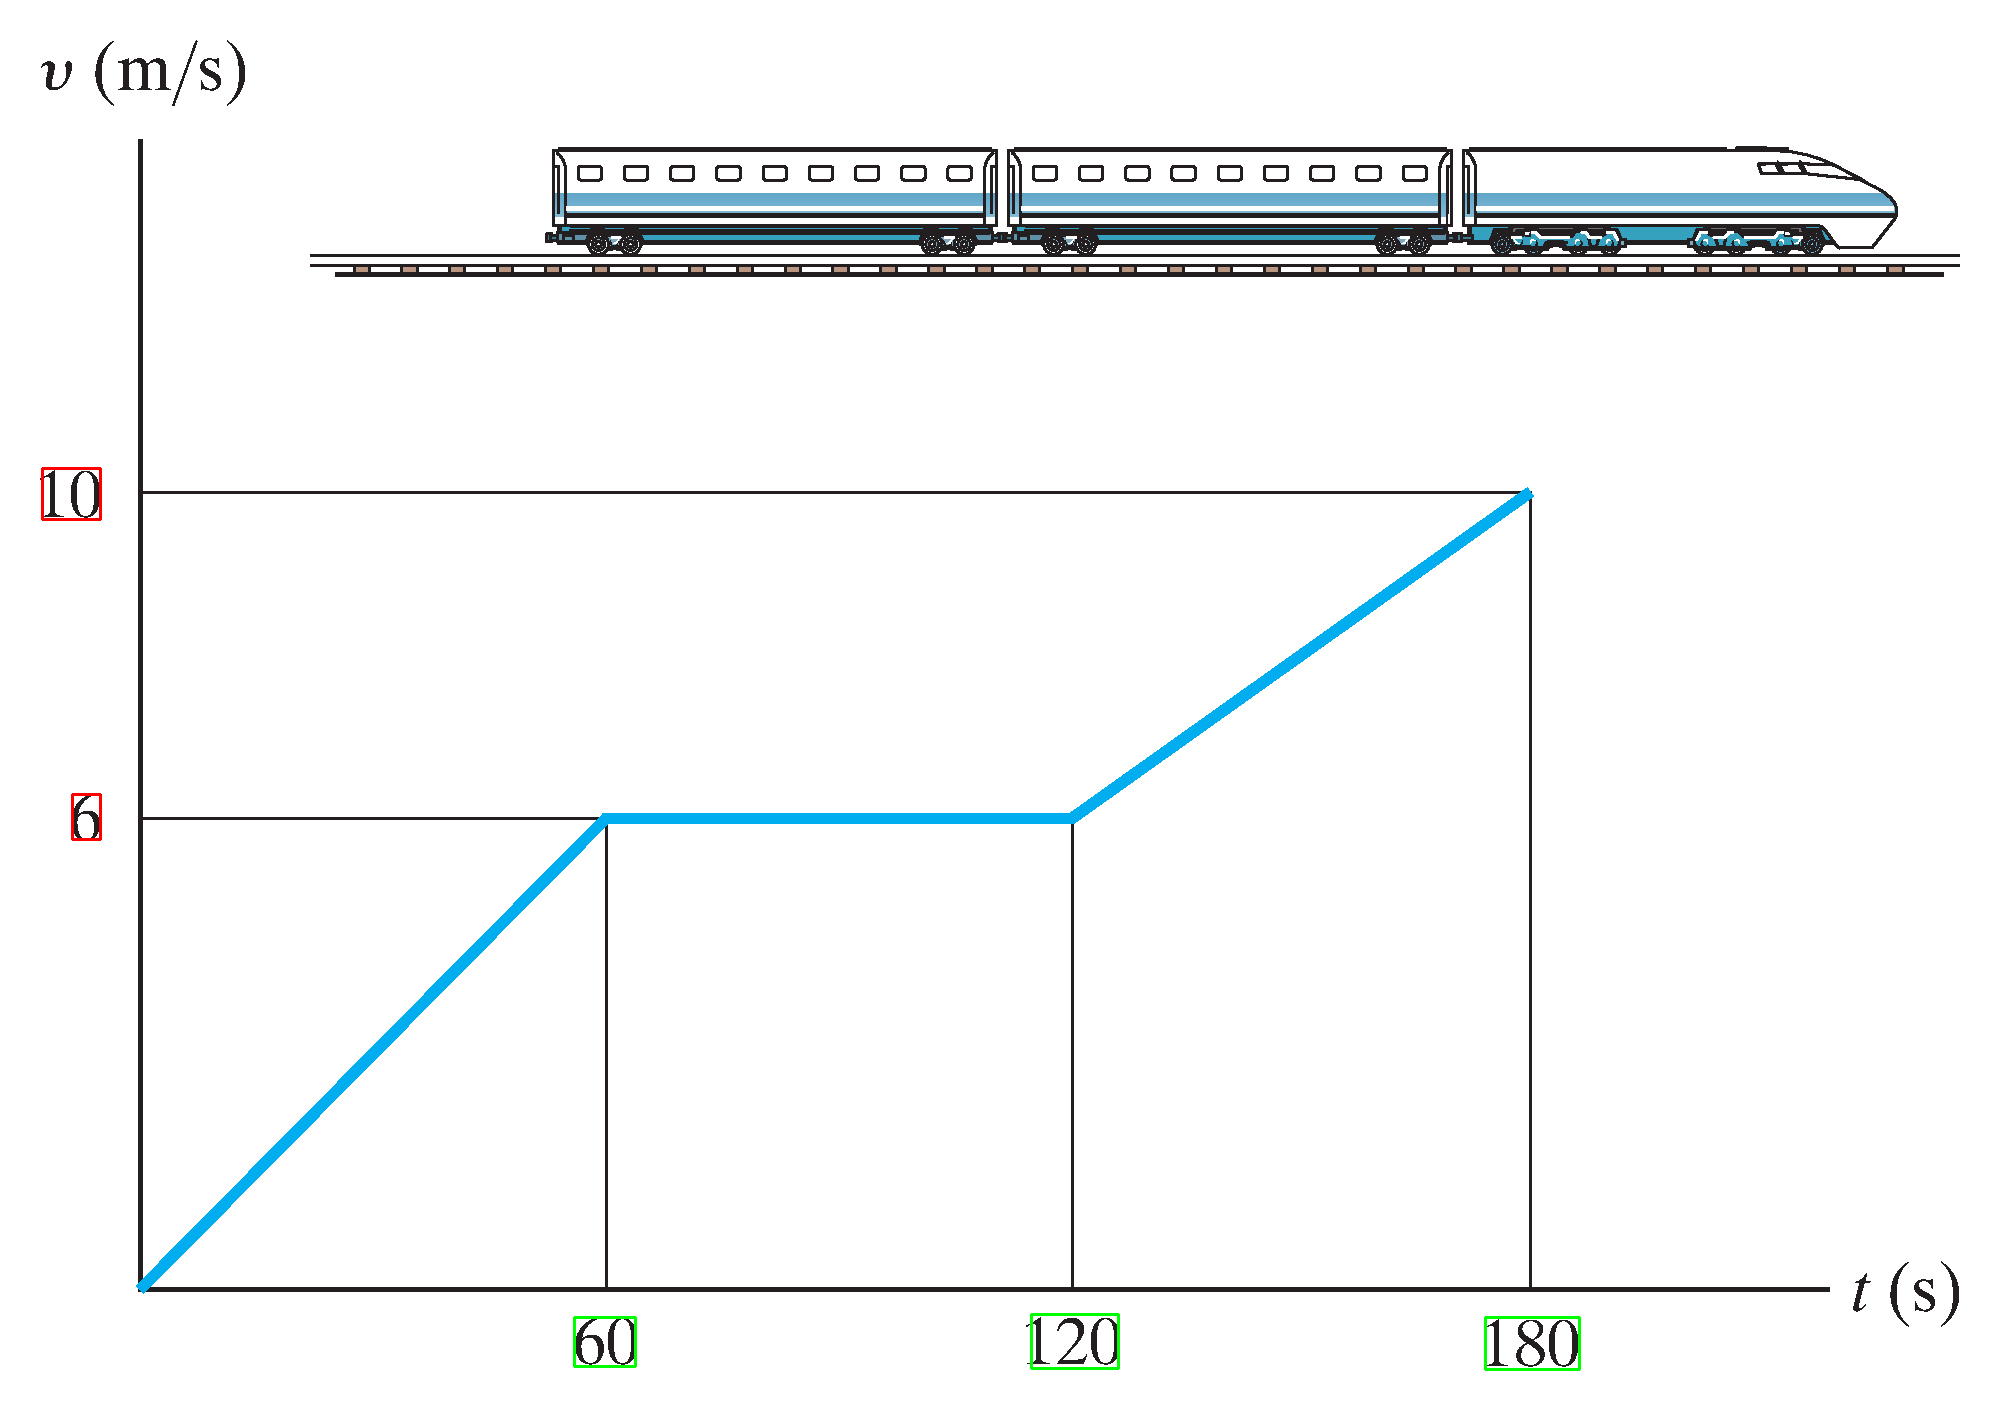

202
202
202
[[[416, 262], [1625, 262]], [[525, 510], [1673, 510]]] [[[175, 313], [175, 994]], [[517, 513], [517, 838]]]


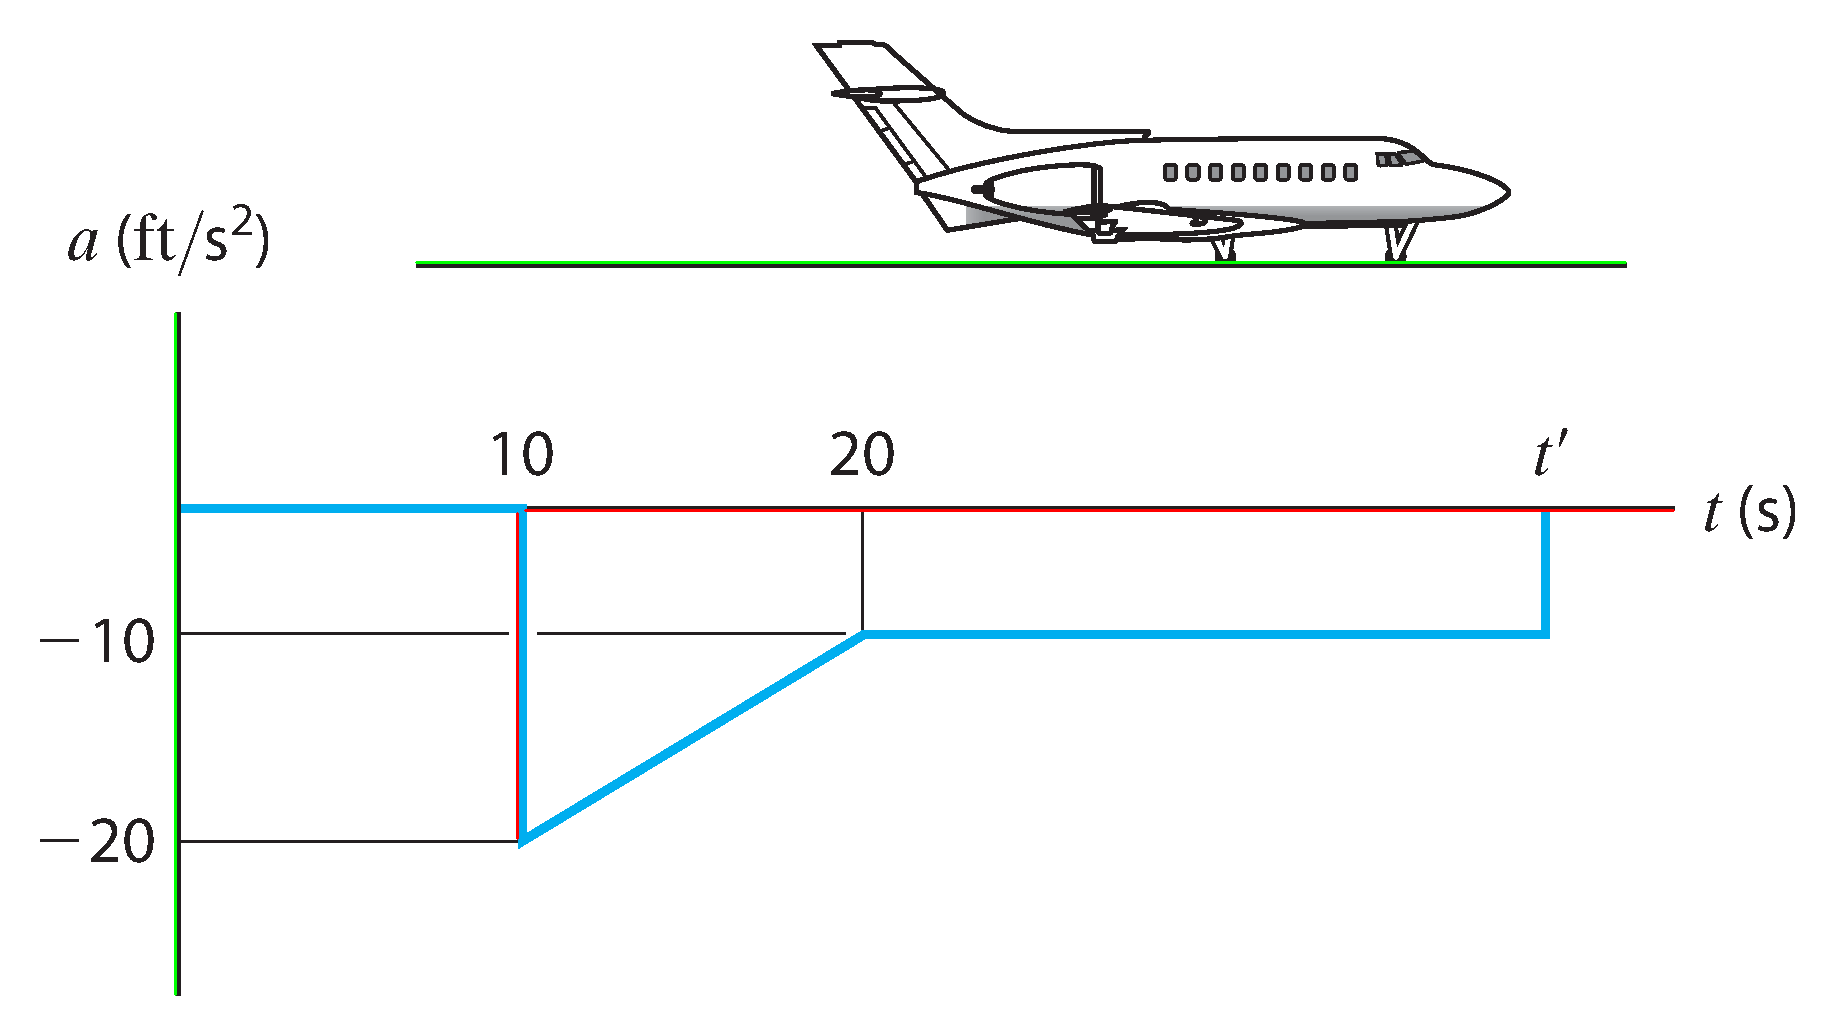

202
202
202


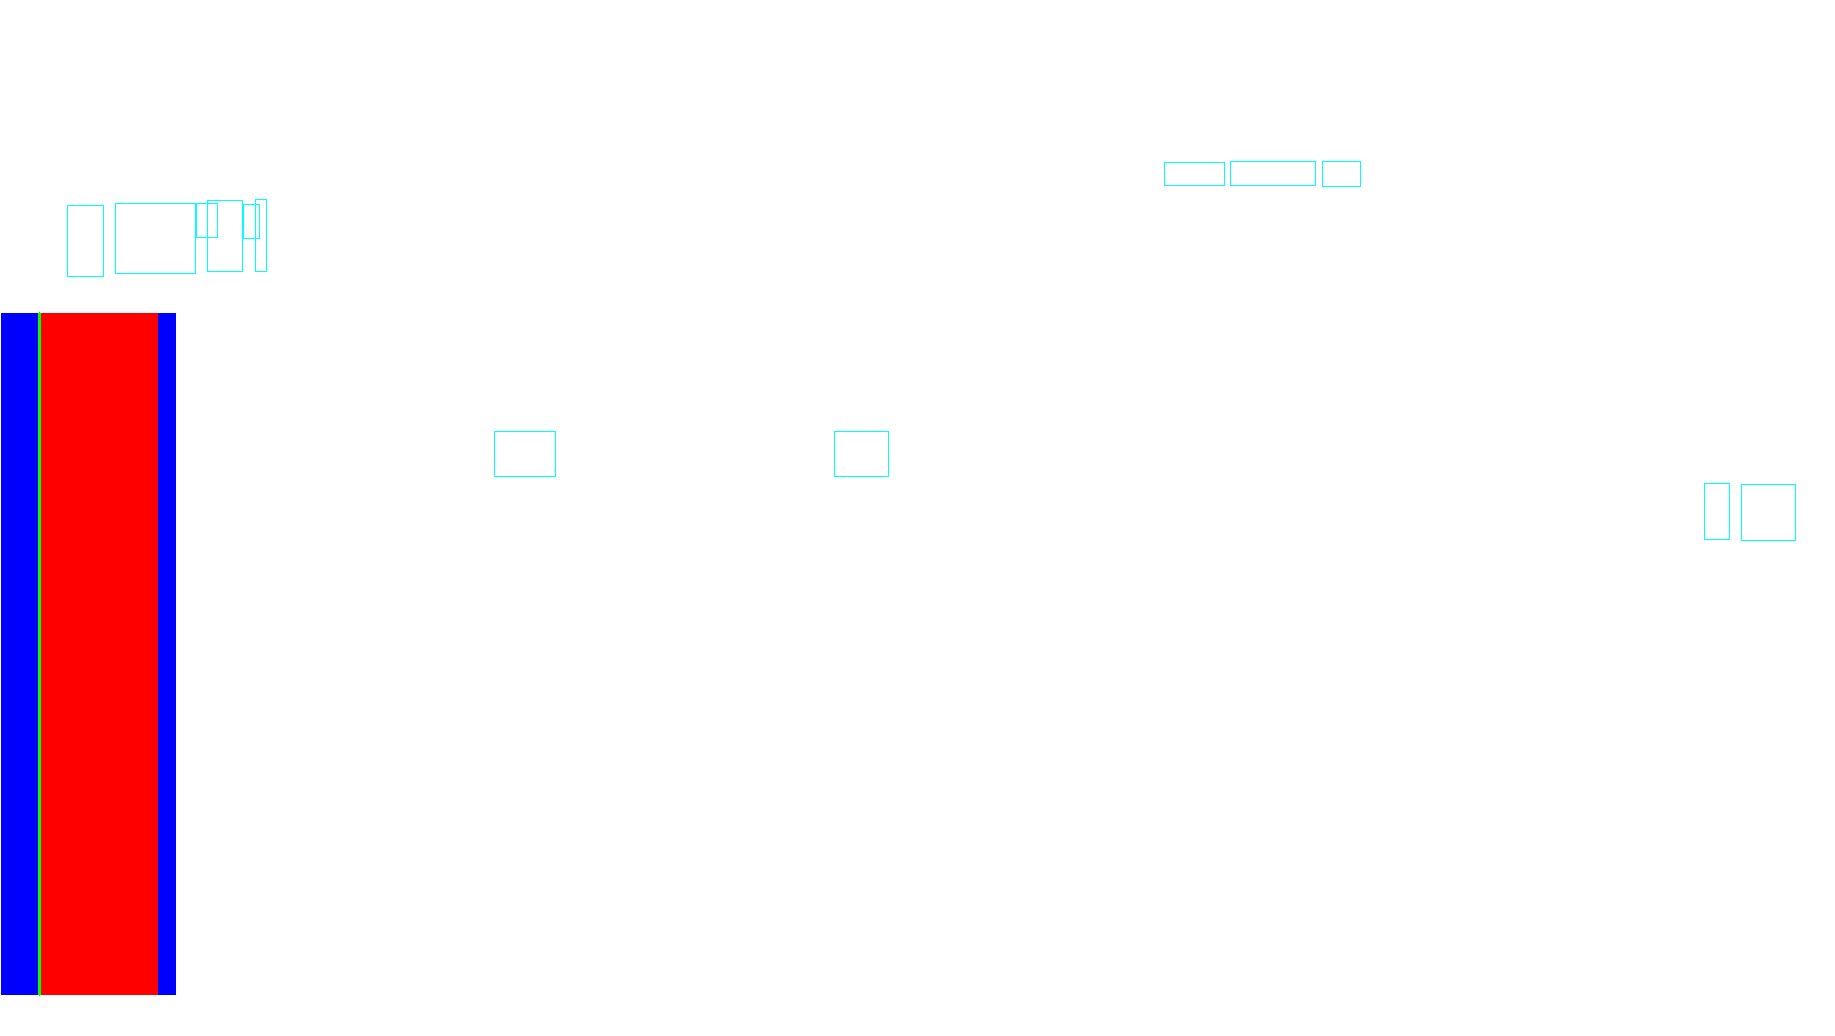

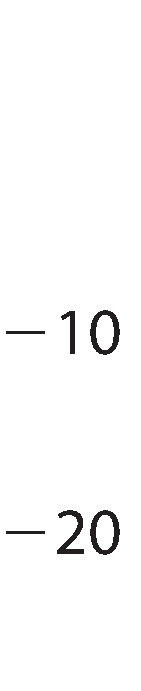

(691, 141, 3)


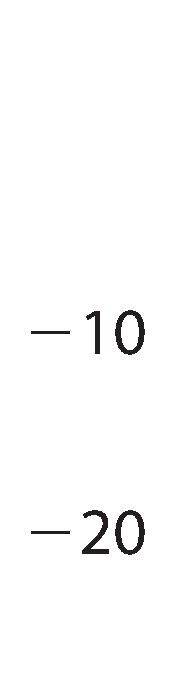

(691, 191, 3)
202
202
[{'boundingBox': [30, 307, 65, 308, 64, 355, 30, 354], 'text': '-'}, {'boundingBox': [90, 308, 143, 308, 143, 355, 89, 355], 'text': '10'}, {'boundingBox': [33, 509, 61, 509, 60, 551, 32, 551], 'text': '-'}, {'boundingBox': [83, 511, 145, 510, 146, 557, 83, 558], 'text': '20'}]
[{'boundingBox': [5, 307, 40, 308, 39, 355, 5, 354], 'text': '-'}, {'boundingBox': [65, 308, 118, 308, 118, 355, 64, 355], 'text': '10'}, {'boundingBox': [8, 509, 36, 509, 35, 551, 7, 551], 'text': '-'}, {'boundingBox': [58, 511, 120, 510, 121, 557, 58, 558], 'text': '20'}]
[{'boundingBox': [39, 615, 74, 616, 73, 663, 39, 662], 'text': '-'}, {'boundingBox': [99, 616, 152, 616, 152, 663, 98, 663], 'text': '10'}, {'boundingBox': [42, 817, 70, 817, 69, 859, 41, 859], 'text': '-'}, {'boundingBox': [92, 819, 154, 818, 155, 865, 92, 866], 'text': '20'}]


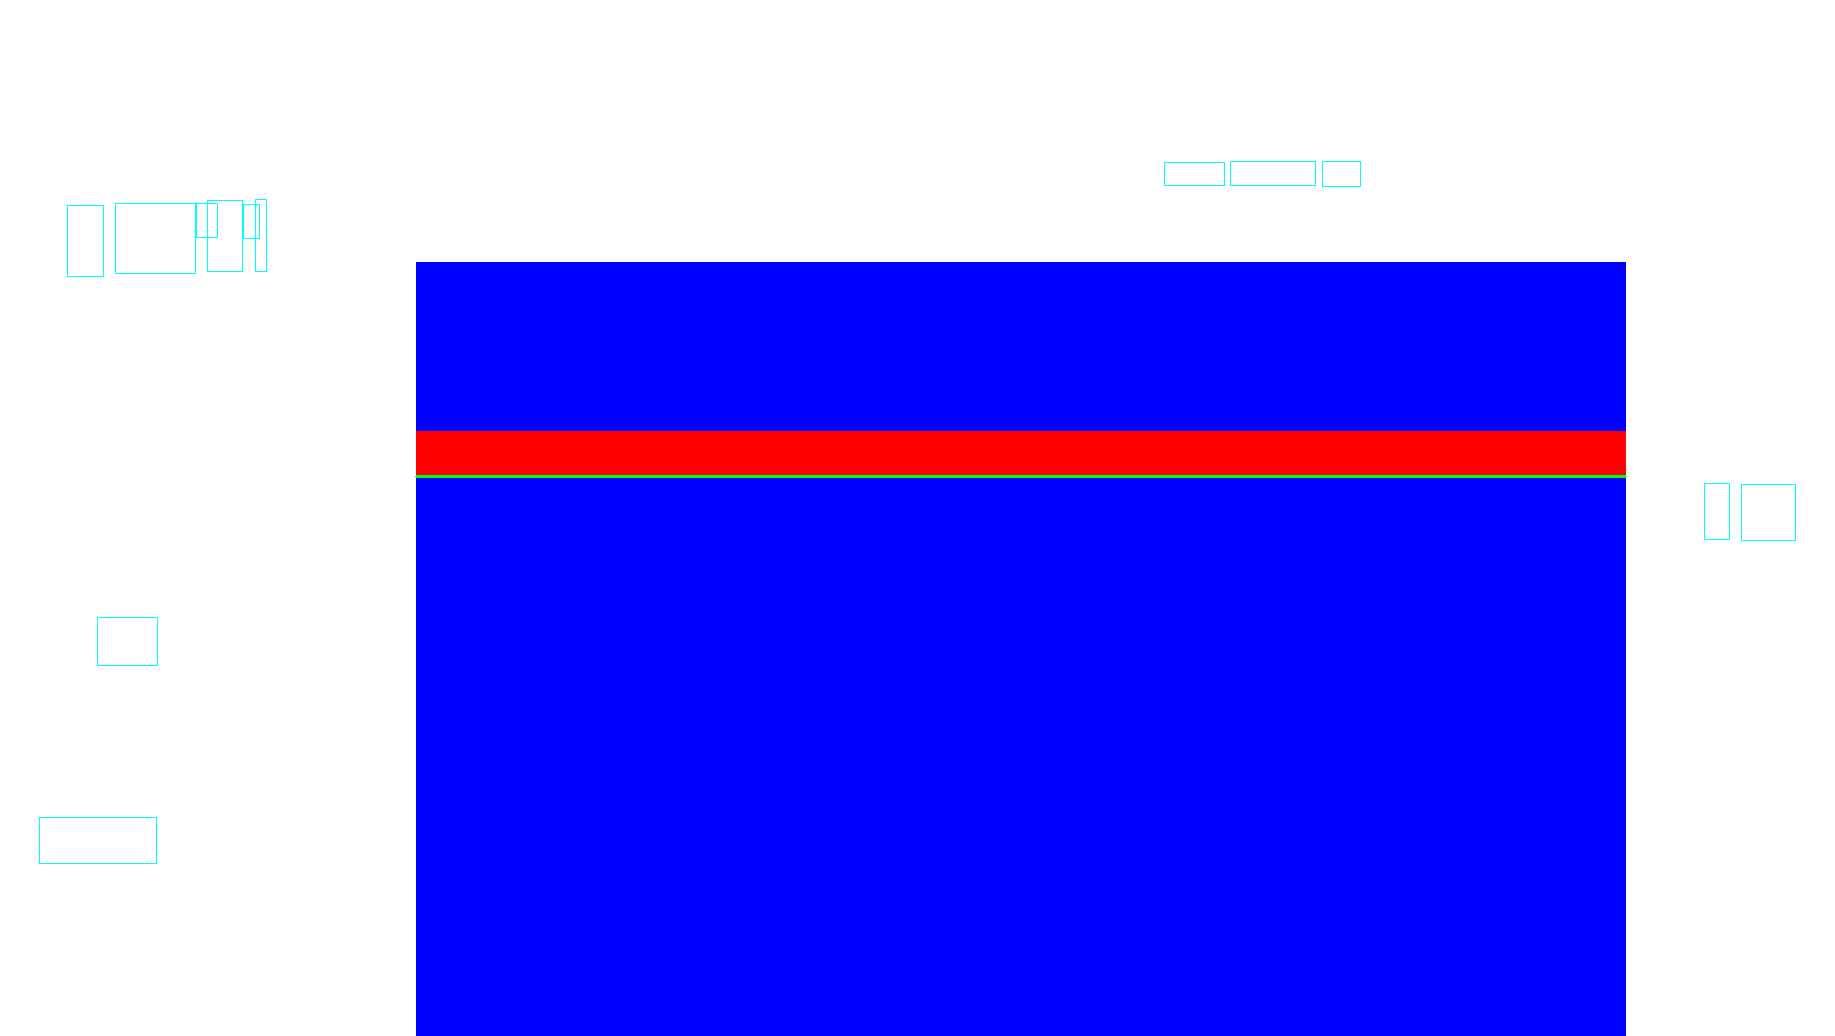

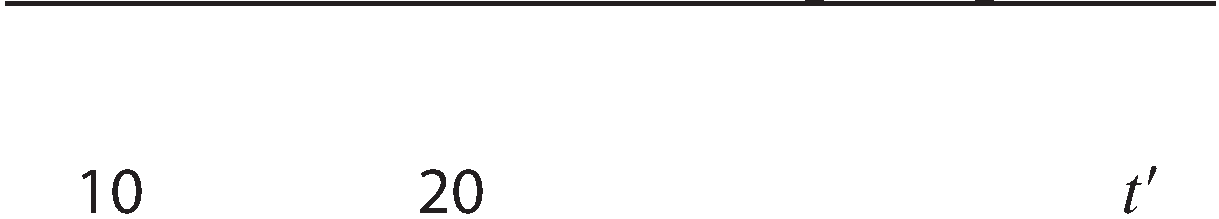

(219, 1219, 3)


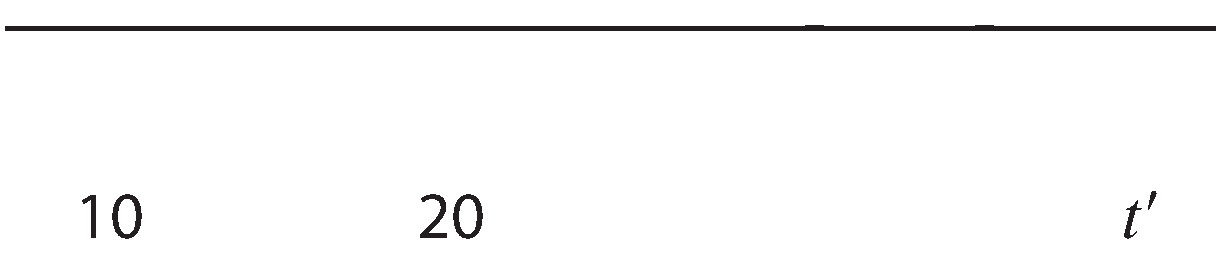

(269, 1219, 3)
202
202
[{'boundingBox': [85, 192, 142, 191, 143, 238, 86, 239], 'text': '10'}, {'boundingBox': [424, 195, 484, 196, 483, 239, 423, 238], 'text': '20'}]
[{'boundingBox': [85, 167, 142, 166, 143, 213, 86, 214], 'text': '10'}, {'boundingBox': [424, 170, 484, 171, 483, 214, 423, 213], 'text': '20'}]
[{'boundingBox': [496, 429, 553, 428, 554, 475, 497, 476], 'text': '10'}, {'boundingBox': [835, 432, 895, 433, 894, 476, 834, 475], 'text': '20'}]
[{'boundingBox': [39, 615, 74, 616, 73, 663, 39, 662], 'text': '-'}, {'boundingBox': [99, 616, 152, 616, 152, 663, 98, 663], 'text': '10'}, {'boundingBox': [42, 817, 70, 817, 69, 859, 41, 859], 'text': '-'}, {'boundingBox': [92, 819, 154, 818, 155, 865, 92, 866], 'text': '20'}]
[{'boundingBox': [496, 429, 553, 428, 554, 475, 497, 476], 'text': '10'}, {'boundingBox': [835, 432, 895, 433, 894, 476, 834, 475], 'text': '20'}]


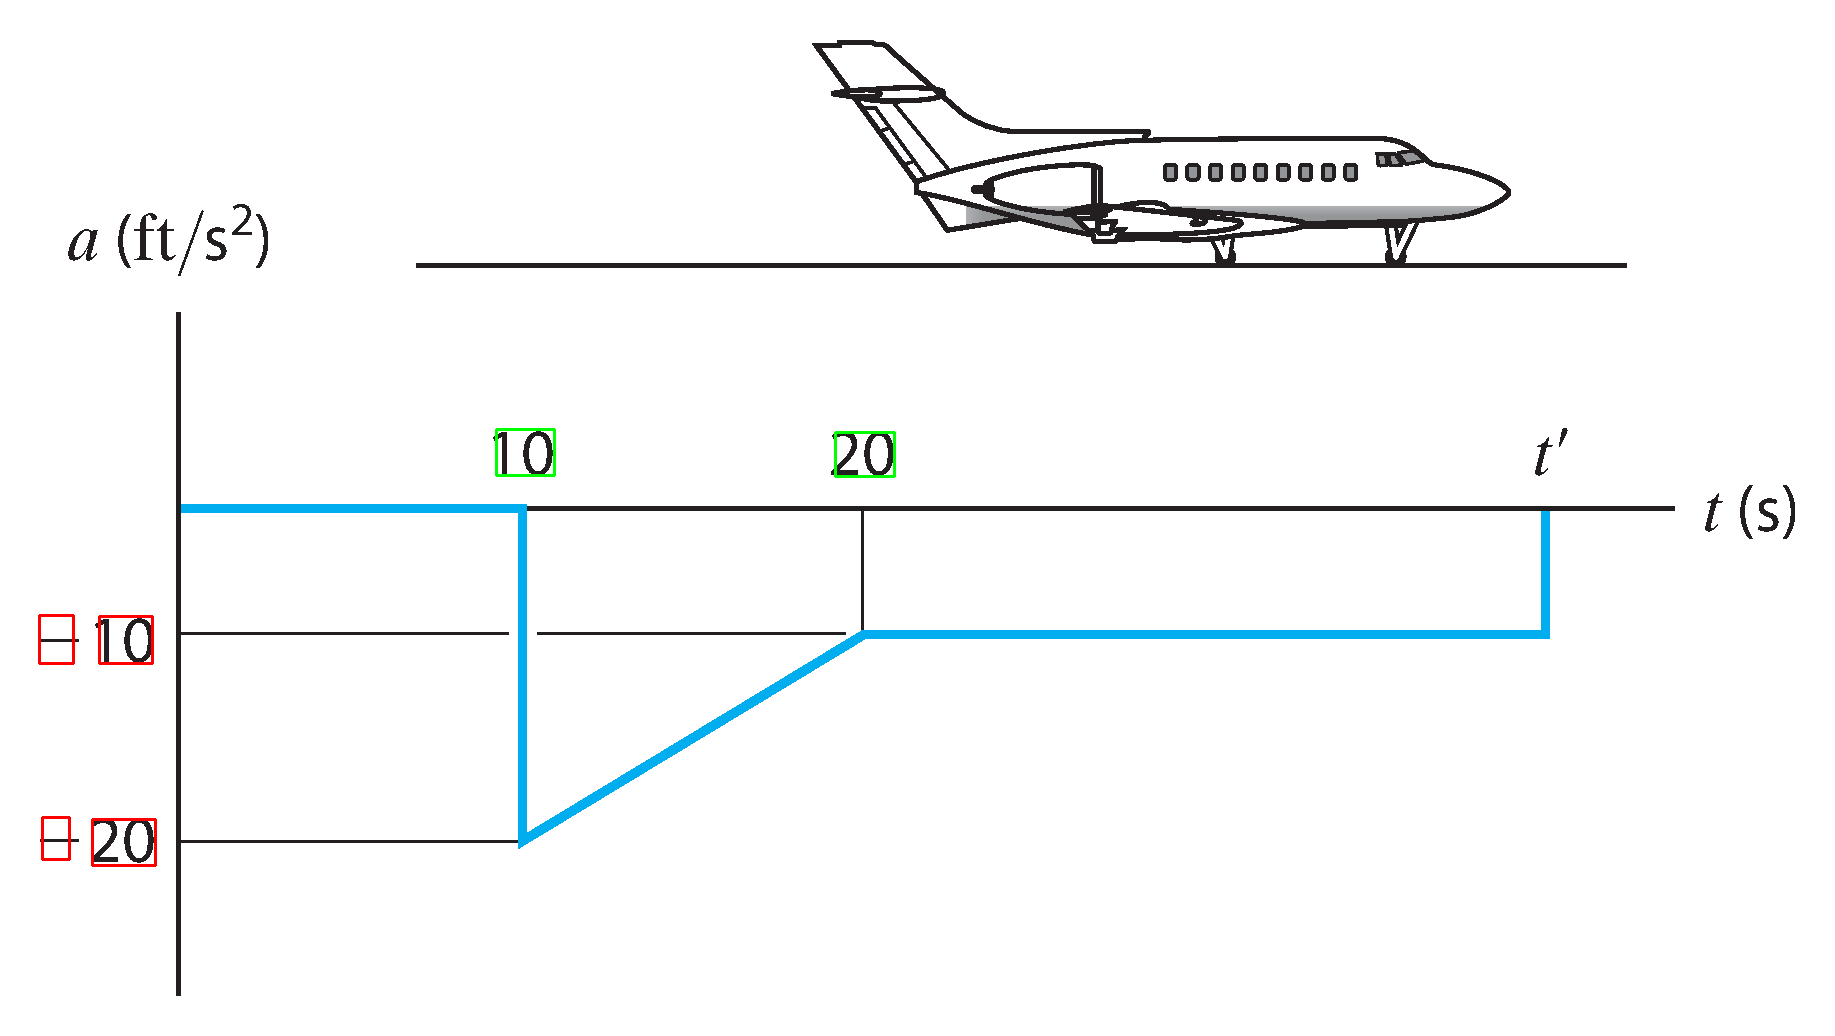

202
202
[[[100, 992], [1389, 992]], [[40, 1197], [1229, 1197]]] [[[159, 136], [159, 1356]], [[771, 700], [771, 1205]]]


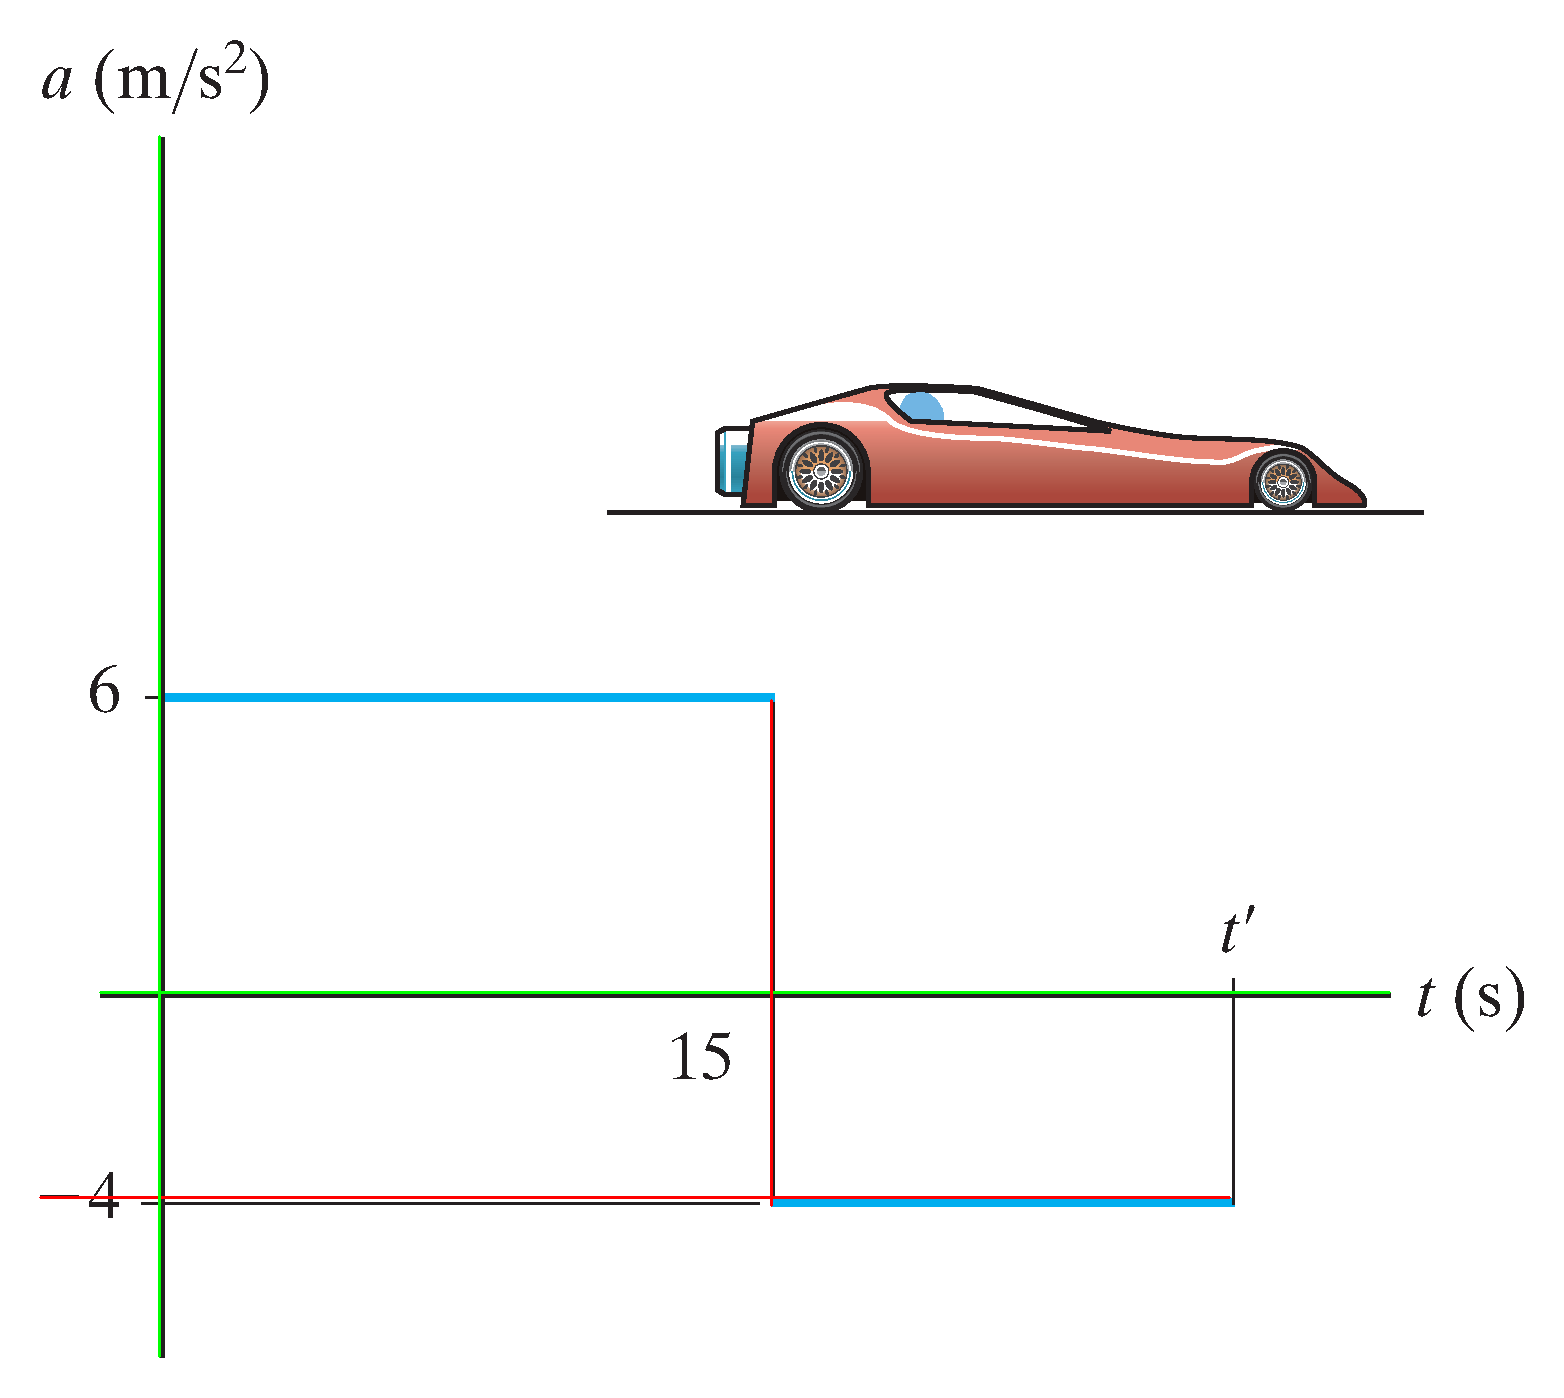

202
202


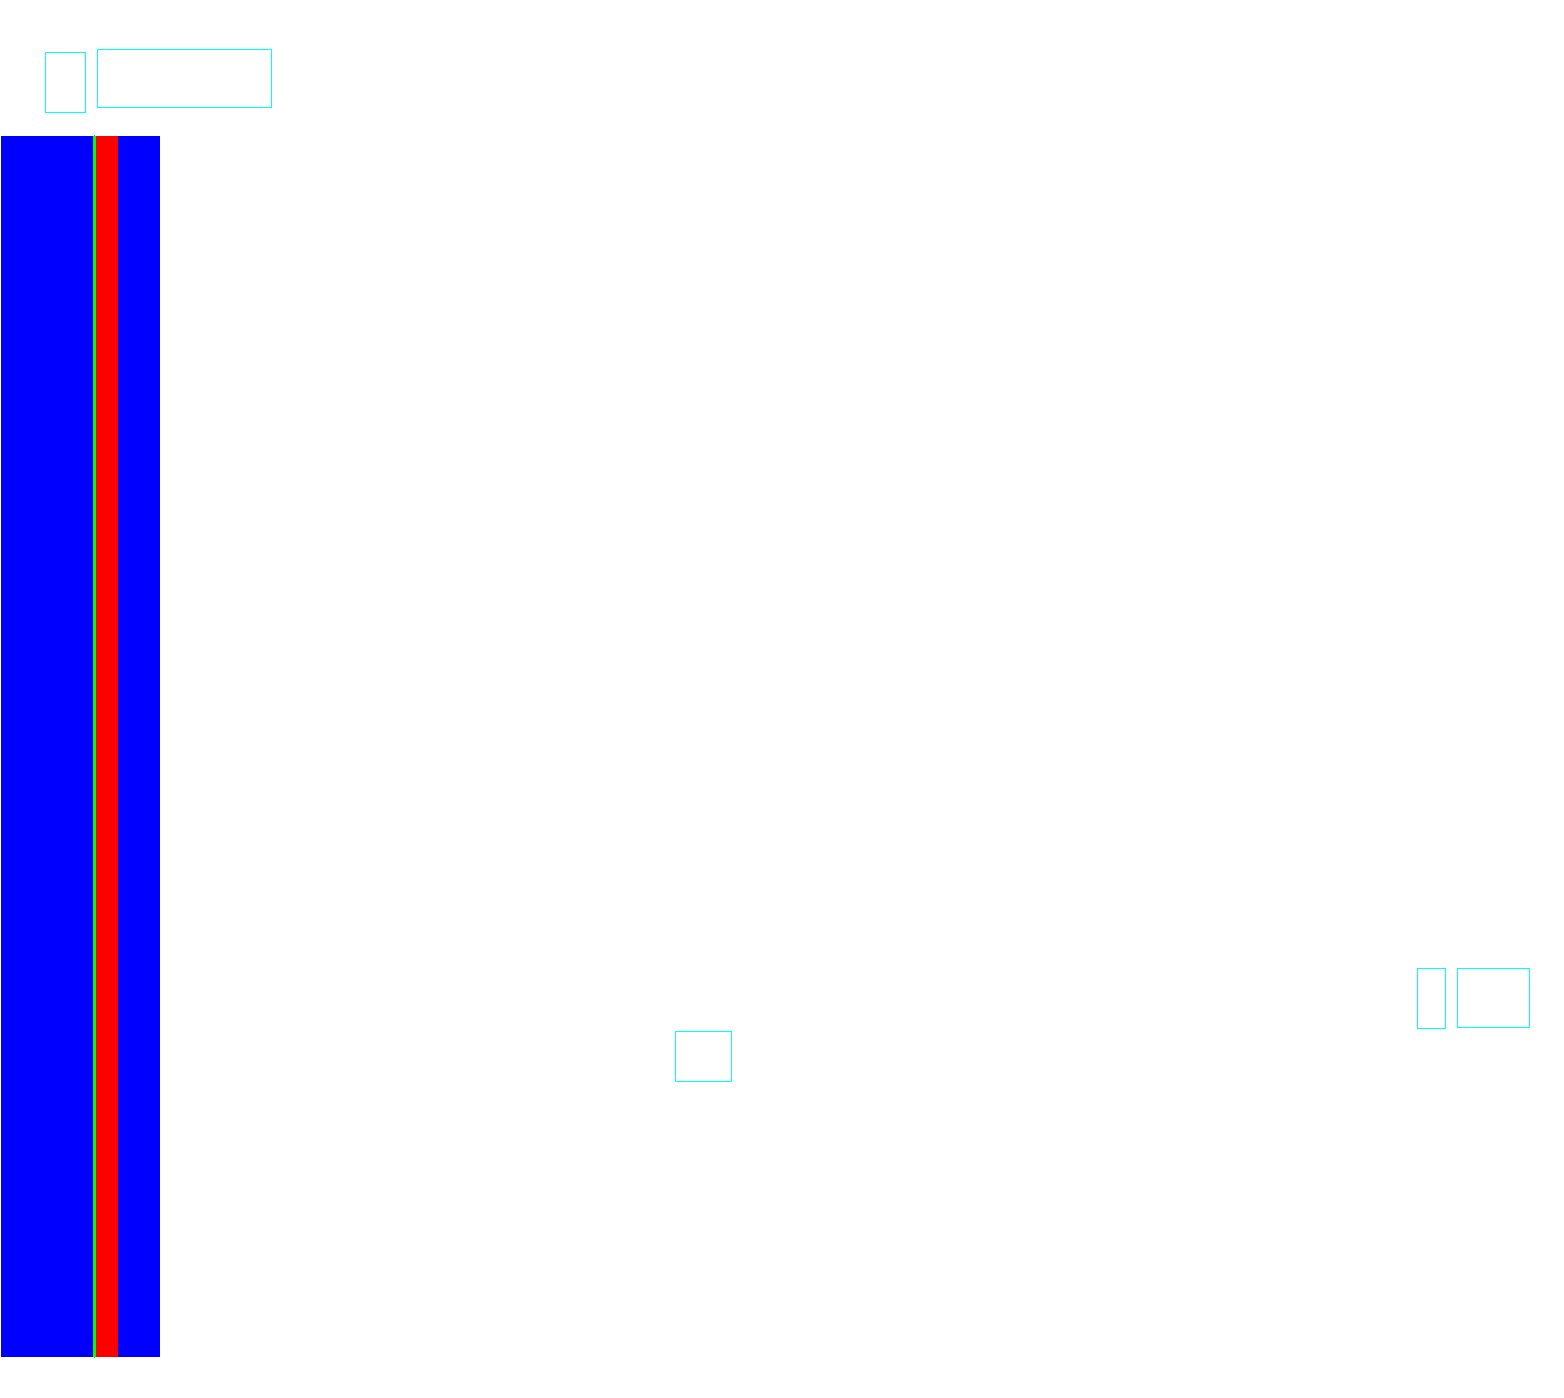

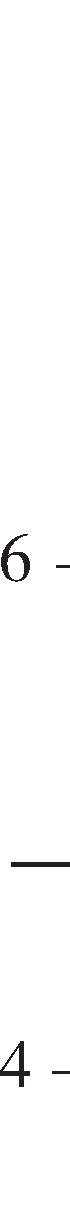

(1230, 70, 3)


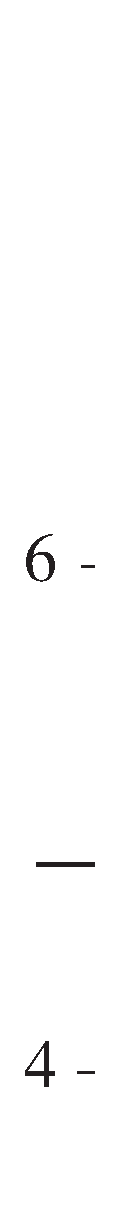

(1230, 120, 3)
202
202
[{'boundingBox': [24, 541, 44, 537, 53, 576, 32, 581], 'text': '6'}, {'boundingBox': [33, 1046, 55, 1047, 53, 1080, 31, 1078], 'text': '4'}]
[{'boundingBox': [-1, 541, 19, 537, 28, 576, 7, 581], 'text': '6'}, {'boundingBox': [8, 1046, 30, 1047, 28, 1080, 6, 1078], 'text': '4'}]
[{'boundingBox': [88, 672, 108, 668, 117, 707, 96, 712], 'text': '6'}, {'boundingBox': [97, 1177, 119, 1178, 117, 1211, 95, 1209], 'text': '4'}]


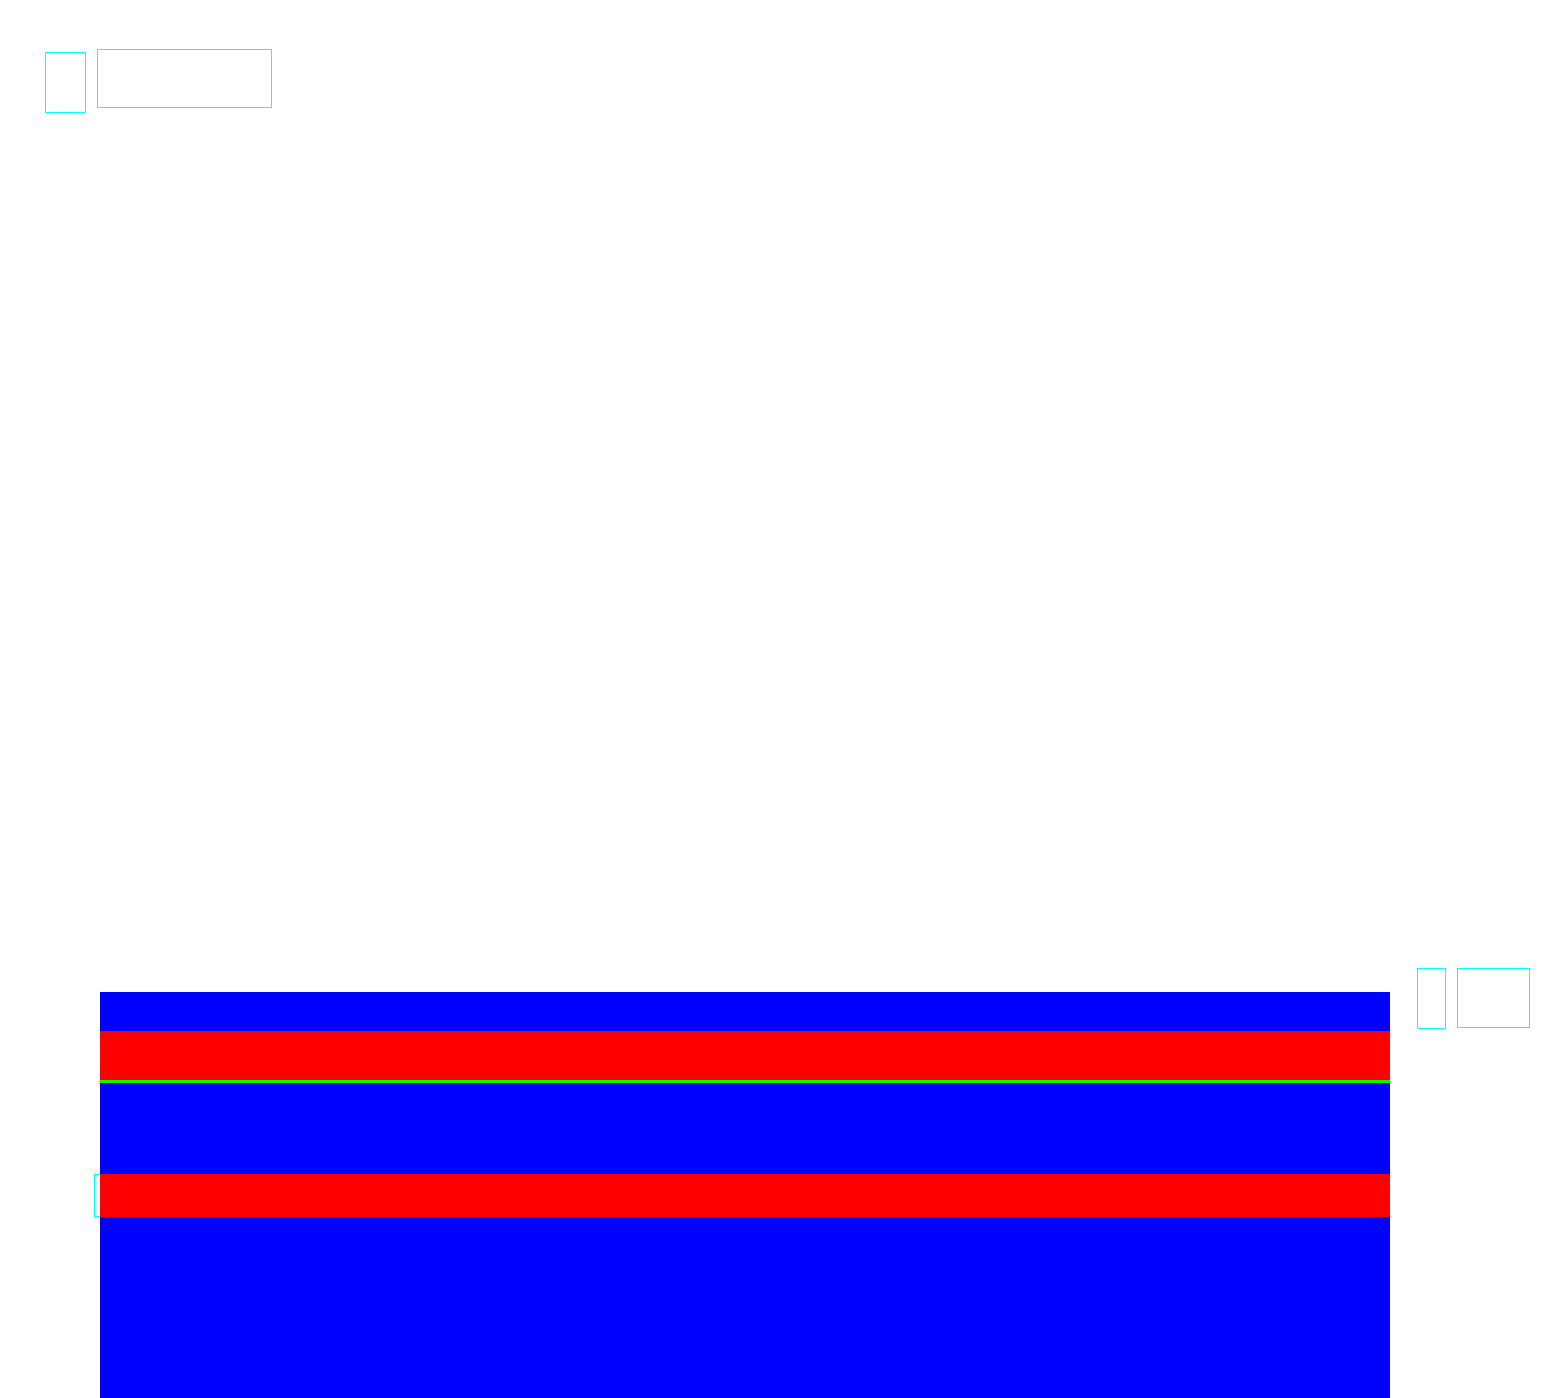

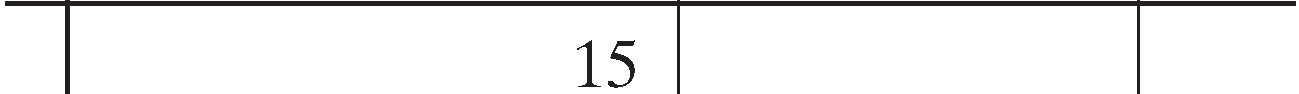

(94, 1299, 3)


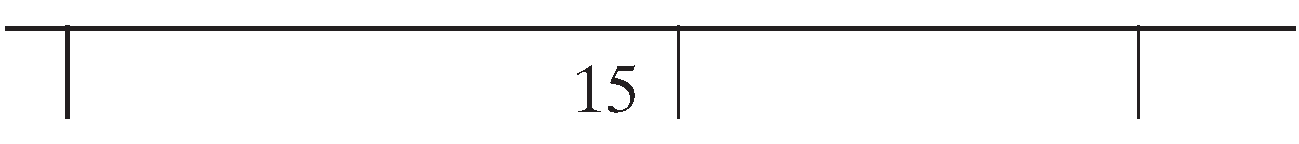

(144, 1299, 3)
202
202
[{'boundingBox': [579, 64, 633, 63, 635, 114, 580, 115], 'text': '15'}]
[{'boundingBox': [579, 39, 633, 38, 635, 89, 580, 90], 'text': '15'}]
[{'boundingBox': [674, 1031, 728, 1030, 730, 1081, 675, 1082], 'text': '15'}]
[{'boundingBox': [88, 672, 108, 668, 117, 707, 96, 712], 'text': '6'}, {'boundingBox': [97, 1177, 119, 1178, 117, 1211, 95, 1209], 'text': '4'}]
[{'boundingBox': [674, 1031, 728, 1030, 730, 1081, 675, 1082], 'text': '15'}]


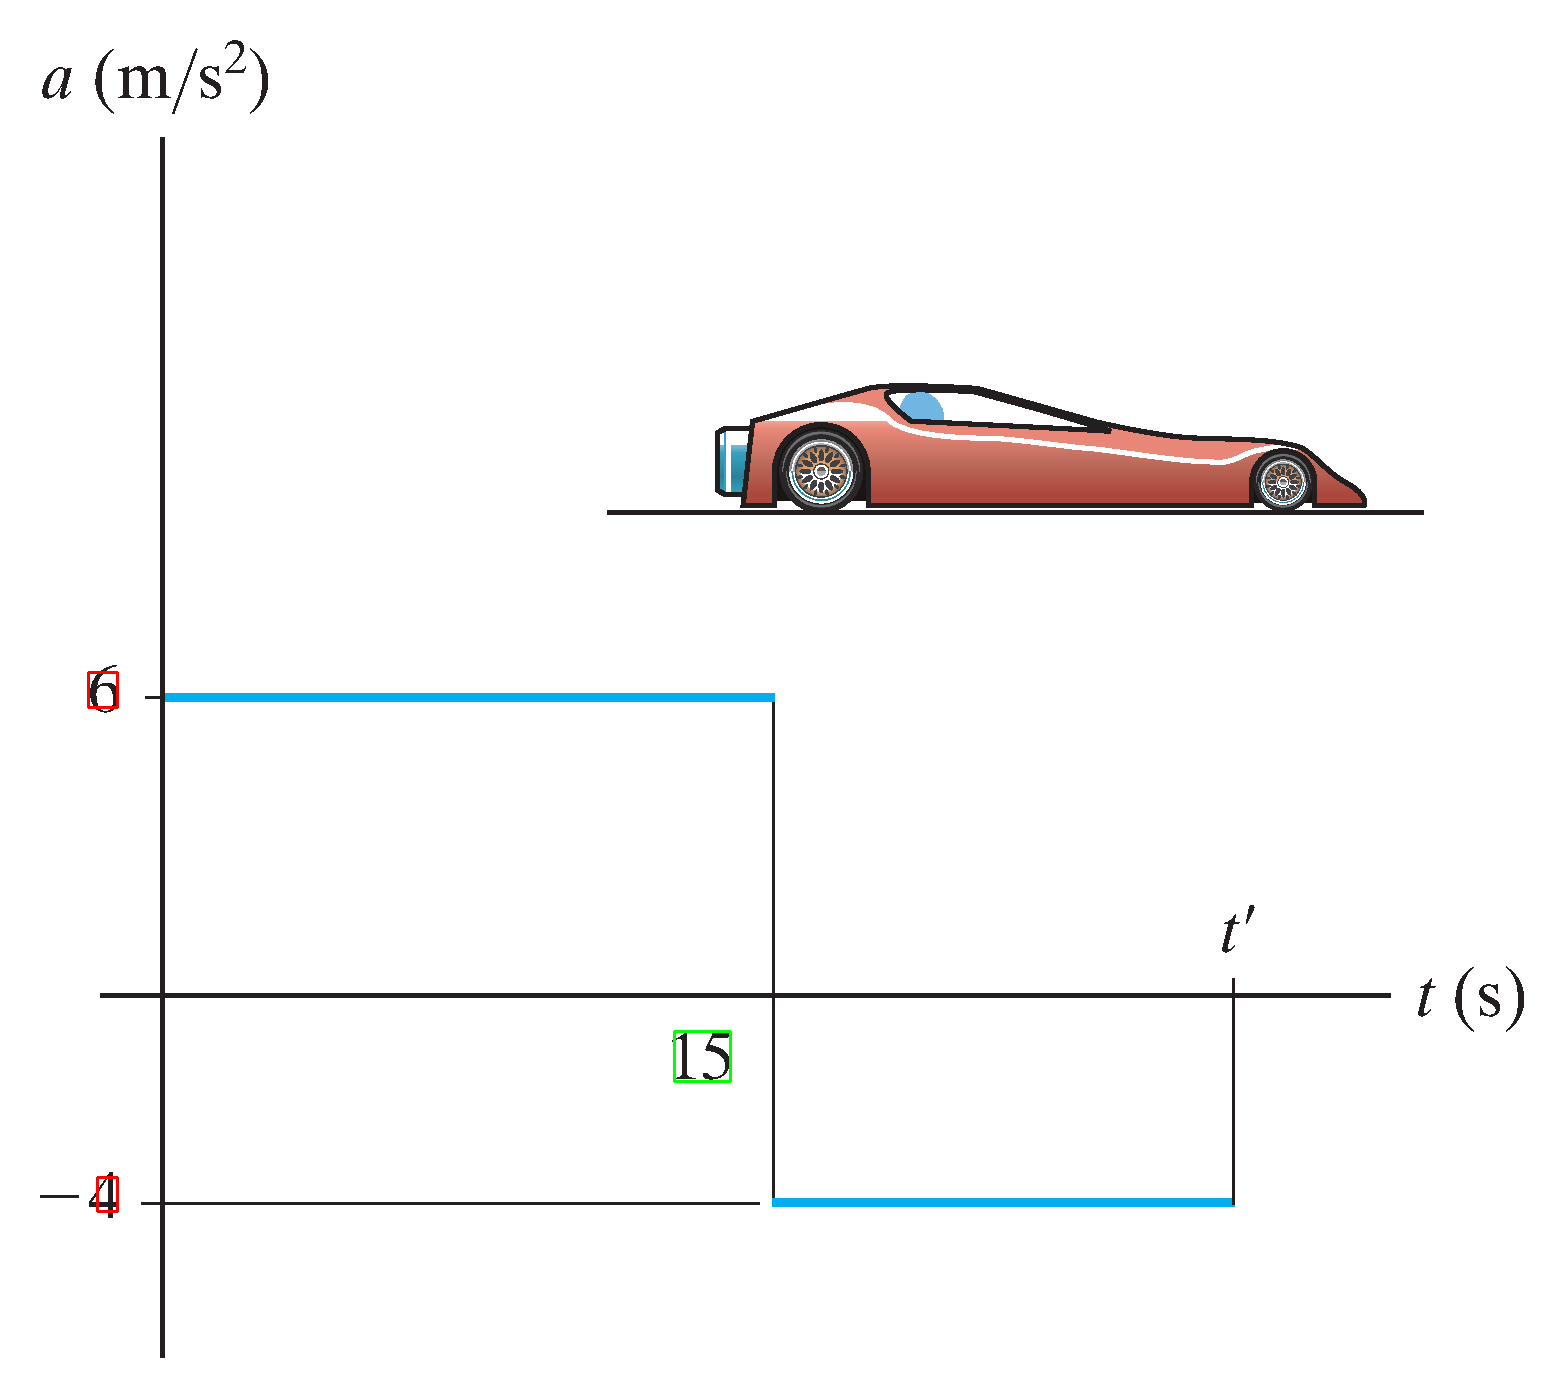

202
202
[[[76, 1024], [1434, 1024]], [[824, 120], [1466, 120]]] [[[183, 351], [183, 1136]], [[841, 40], [841, 561]]]


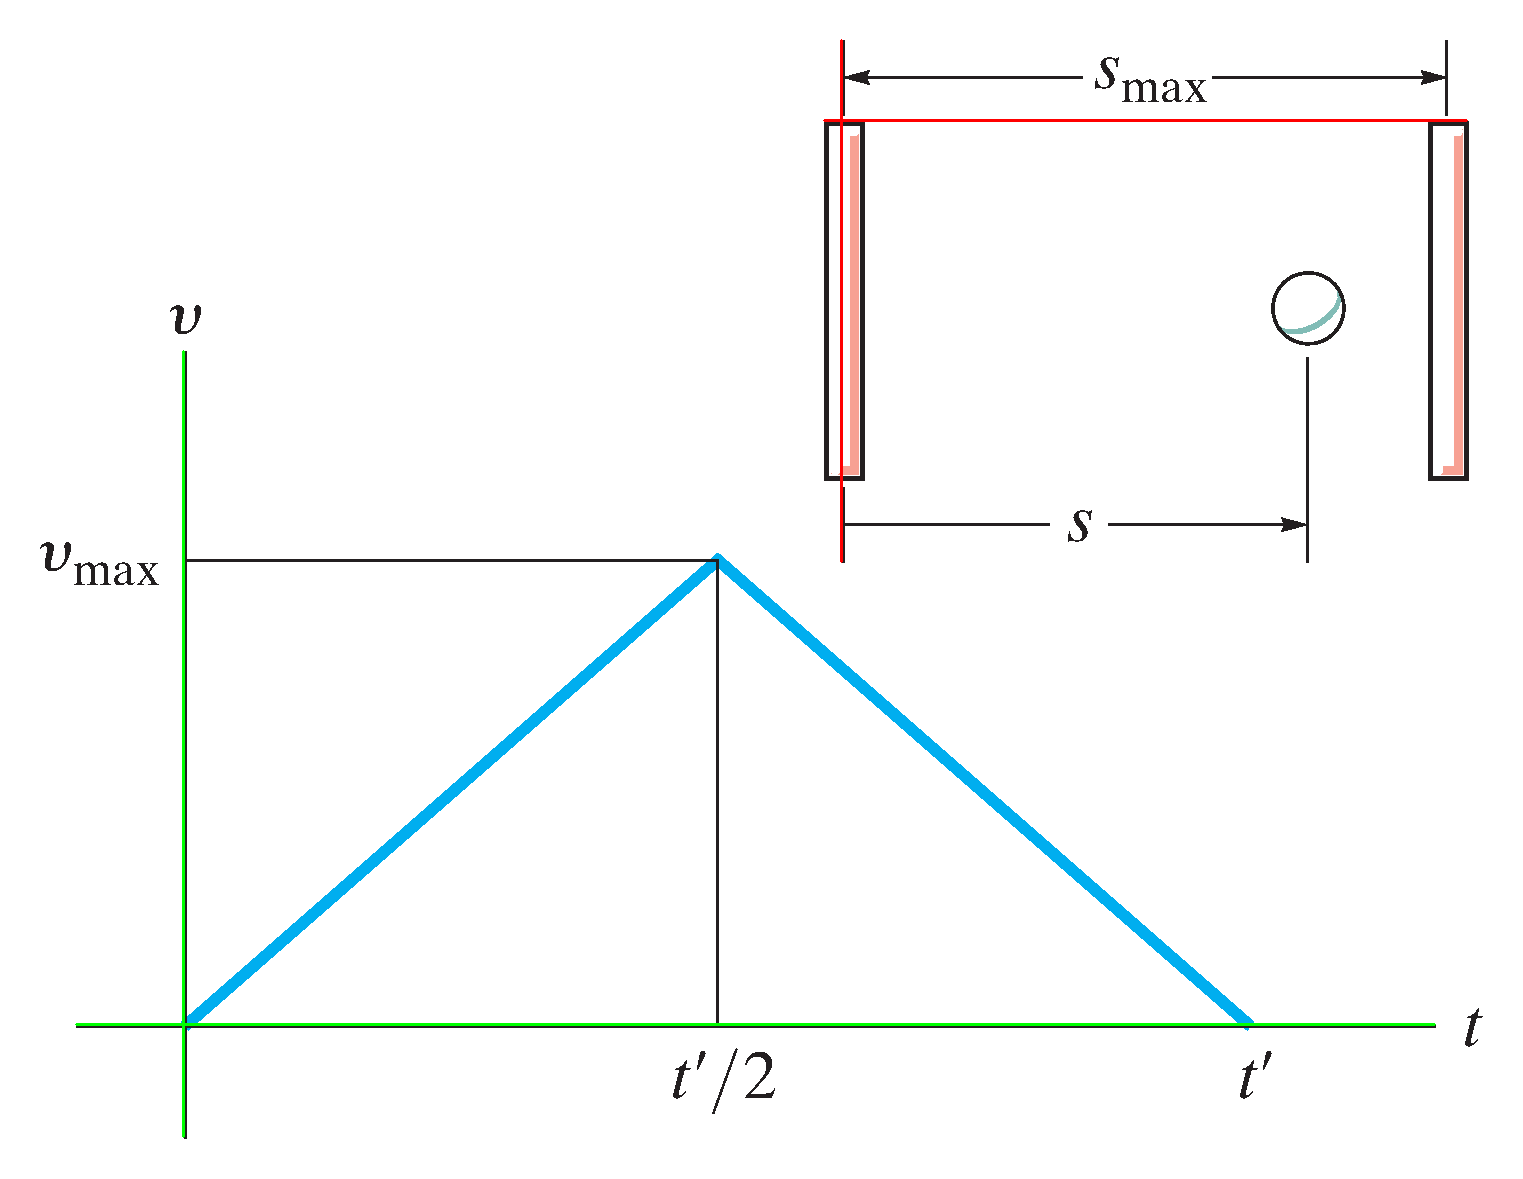

202
202


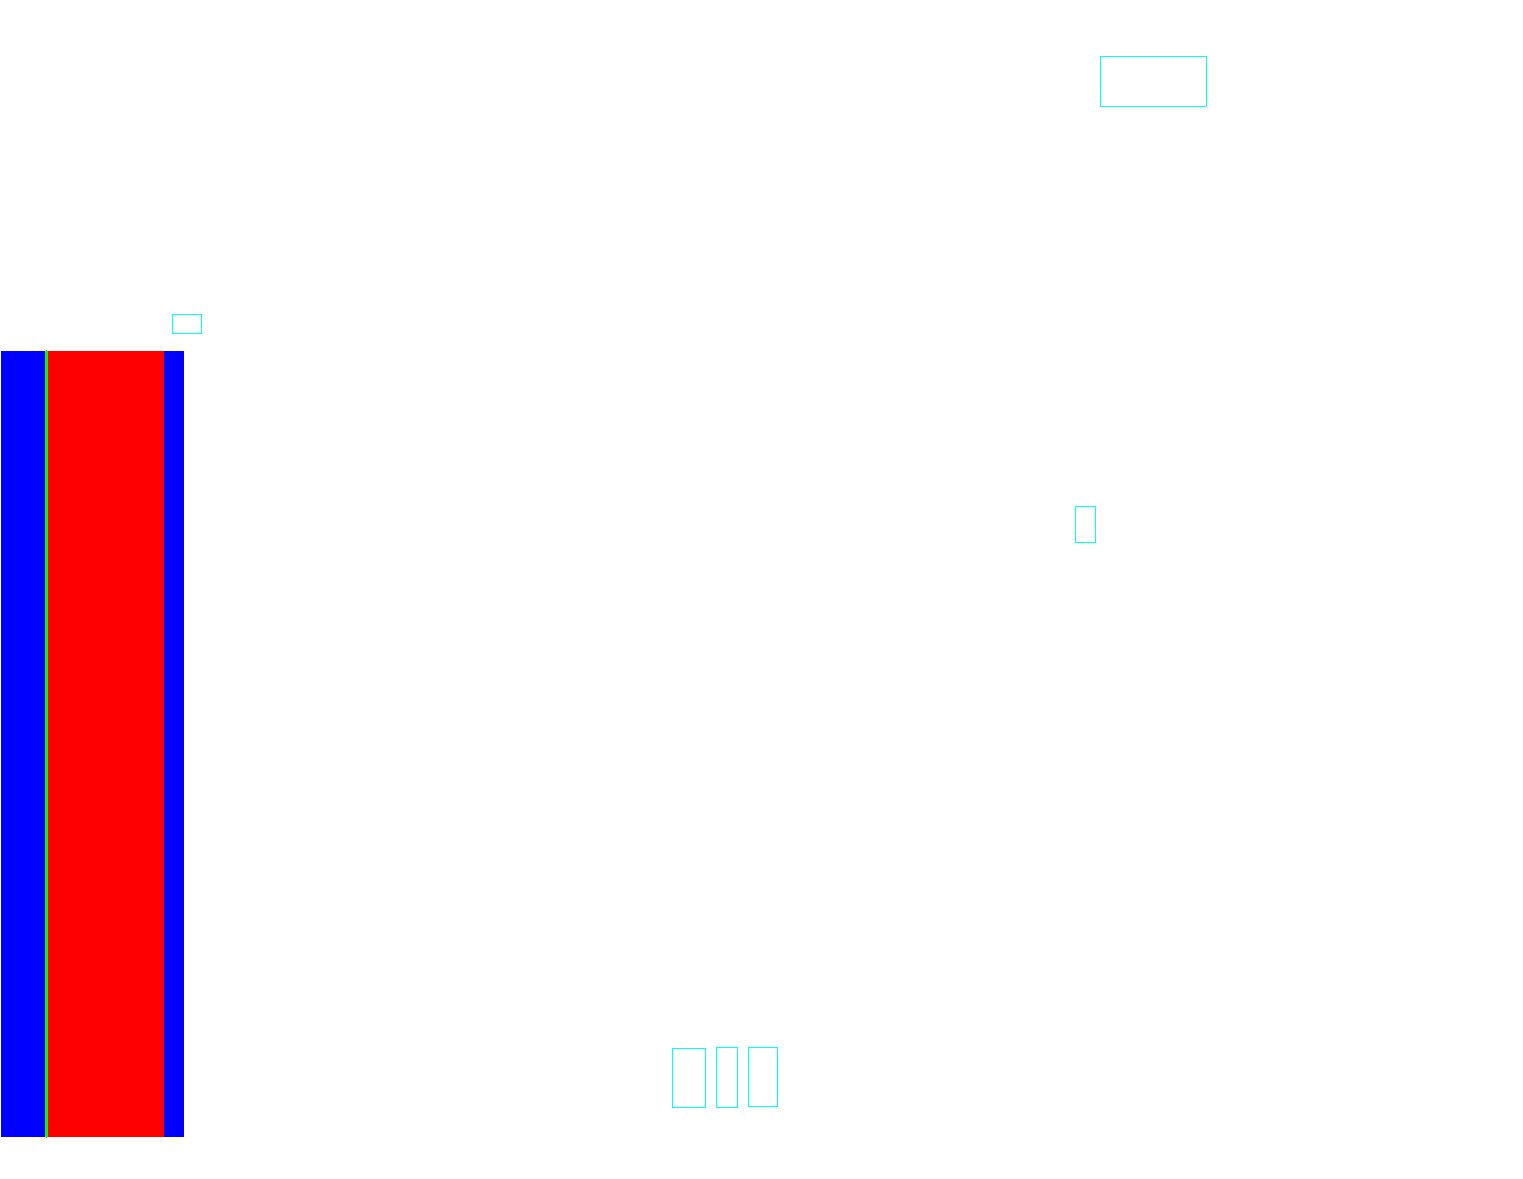

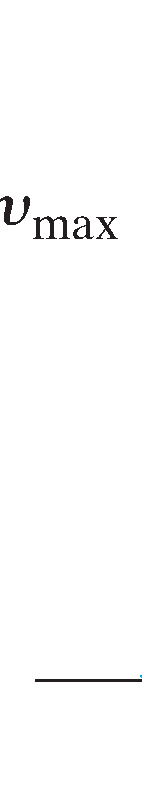

(795, 142, 3)


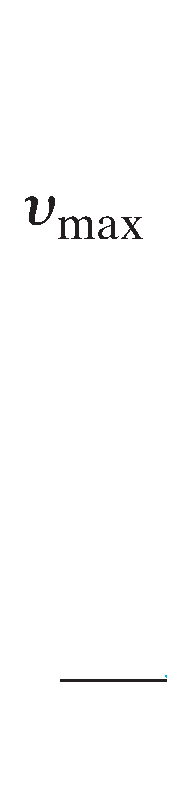

(795, 192, 3)
202
202
[{'boundingBox': [29, 195, 50, 196, 49, 227, 28, 226], 'text': 'U'}, {'boundingBox': [57, 213, 144, 213, 142, 242, 58, 240], 'text': 'max'}]
[{'boundingBox': [4, 195, 25, 196, 24, 227, 3, 226], 'text': 'U'}, {'boundingBox': [32, 213, 119, 213, 117, 242, 33, 240], 'text': 'max'}]
[{'boundingBox': [45, 541, 66, 542, 65, 573, 44, 572], 'text': 'U'}, {'boundingBox': [73, 559, 160, 559, 158, 588, 74, 586], 'text': 'max'}]


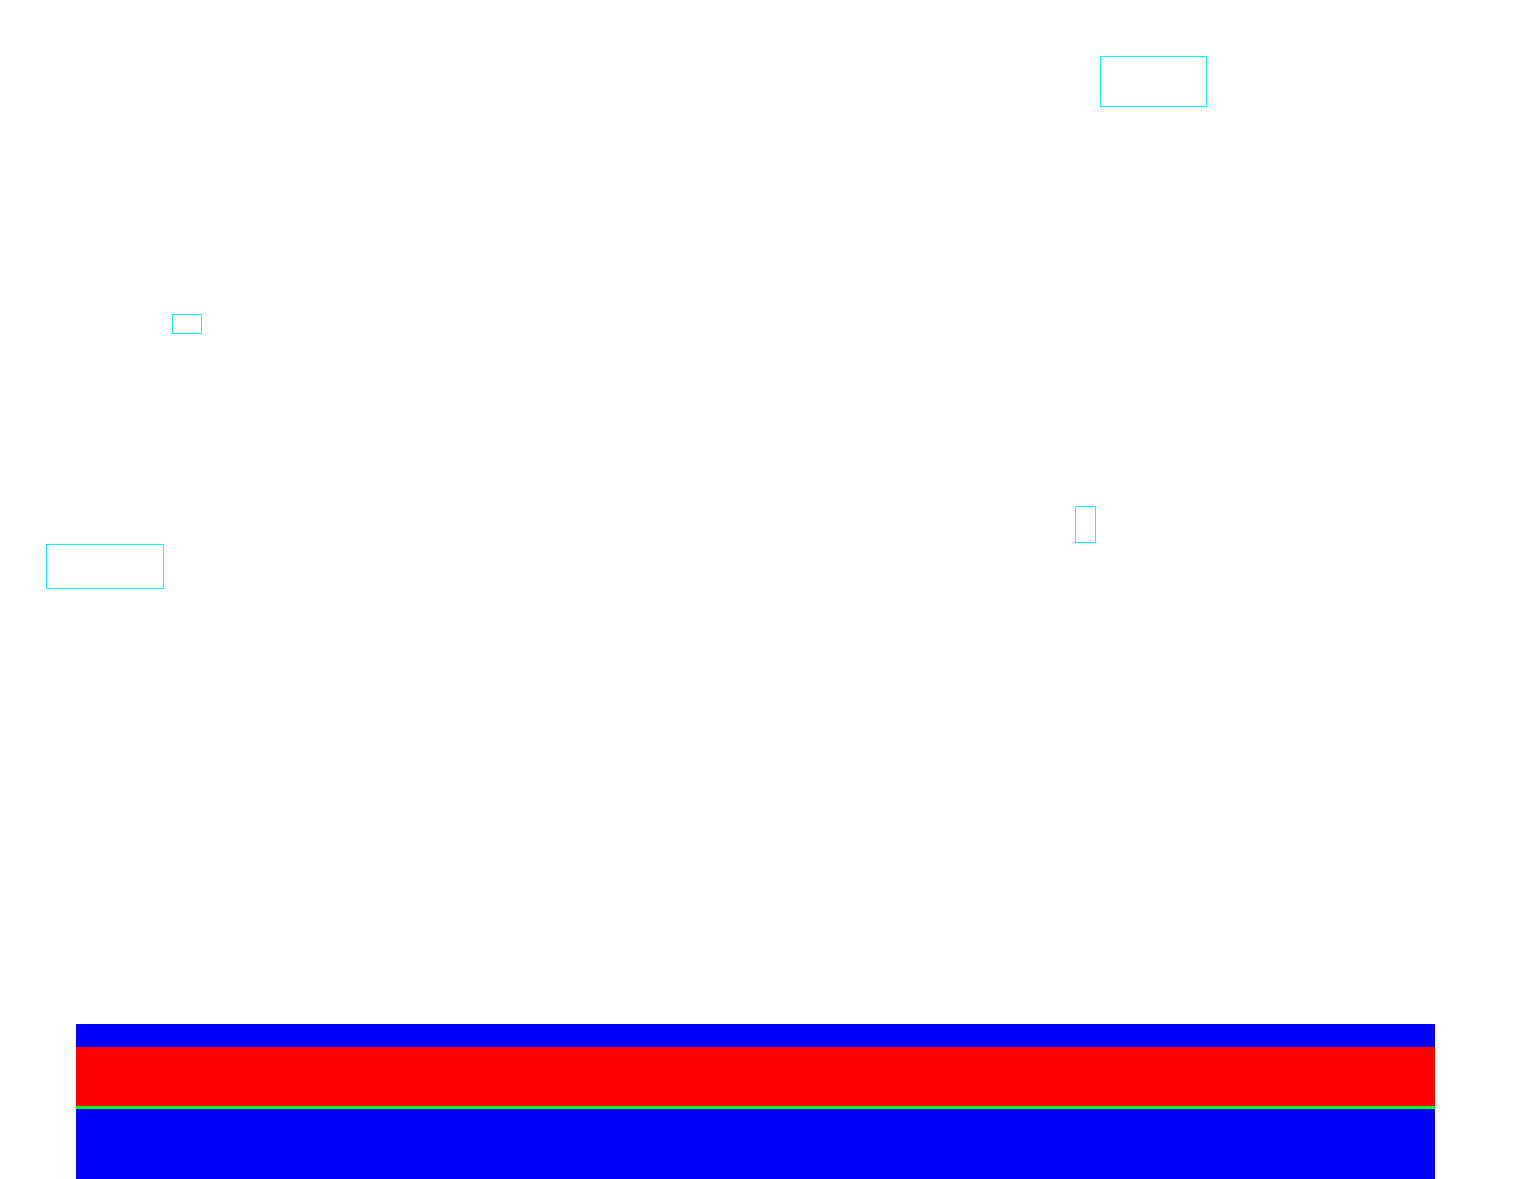

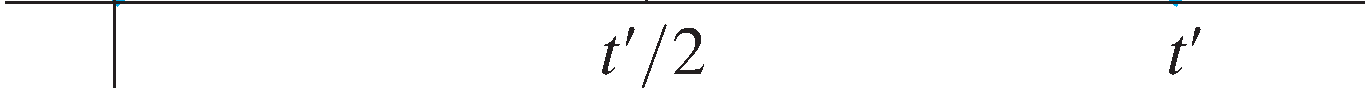

(88, 1368, 3)


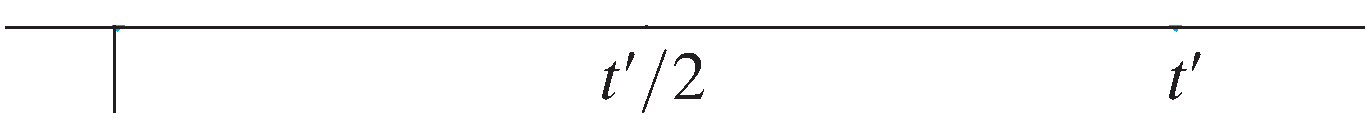

(138, 1368, 3)
202
202
[{'boundingBox': [603, 46, 632, 46, 631, 108, 602, 108], 'text': "t'"}, {'boundingBox': [644, 47, 665, 47, 664, 109, 643, 109], 'text': '/'}, {'boundingBox': [678, 47, 702, 48, 701, 110, 676, 109], 'text': '2'}]
[{'boundingBox': [603, 21, 632, 21, 631, 83, 602, 83], 'text': "t'"}, {'boundingBox': [644, 22, 665, 22, 664, 84, 643, 84], 'text': '/'}, {'boundingBox': [678, 22, 702, 23, 701, 85, 676, 84], 'text': '2'}]
[{'boundingBox': [674, 1045, 703, 1045, 702, 1107, 673, 1107], 'text': "t'"}, {'boundingBox': [715, 1046, 736, 1046, 735, 1108, 714, 1108], 'text': '/'}, {'boundingBox': [749, 1046, 773, 1047, 772, 1109, 747, 1108], 'text': '2'}]
[{'boundingBox': [45, 541, 66, 542, 65, 573, 44, 572], 'text': 'U'}, {'boundingBox': [73, 559, 160, 559, 158, 588, 74, 586], 'text': 'max'}]
[{'boundingBox': [674, 1045, 703, 1045, 702, 1107, 673, 1107], 'text': "t'"}, {'boundingBox': [715, 1046, 736, 1046, 735, 1108, 714, 1108], 'text': '/'}, {'boundingBox': [749, 1046, 773, 1

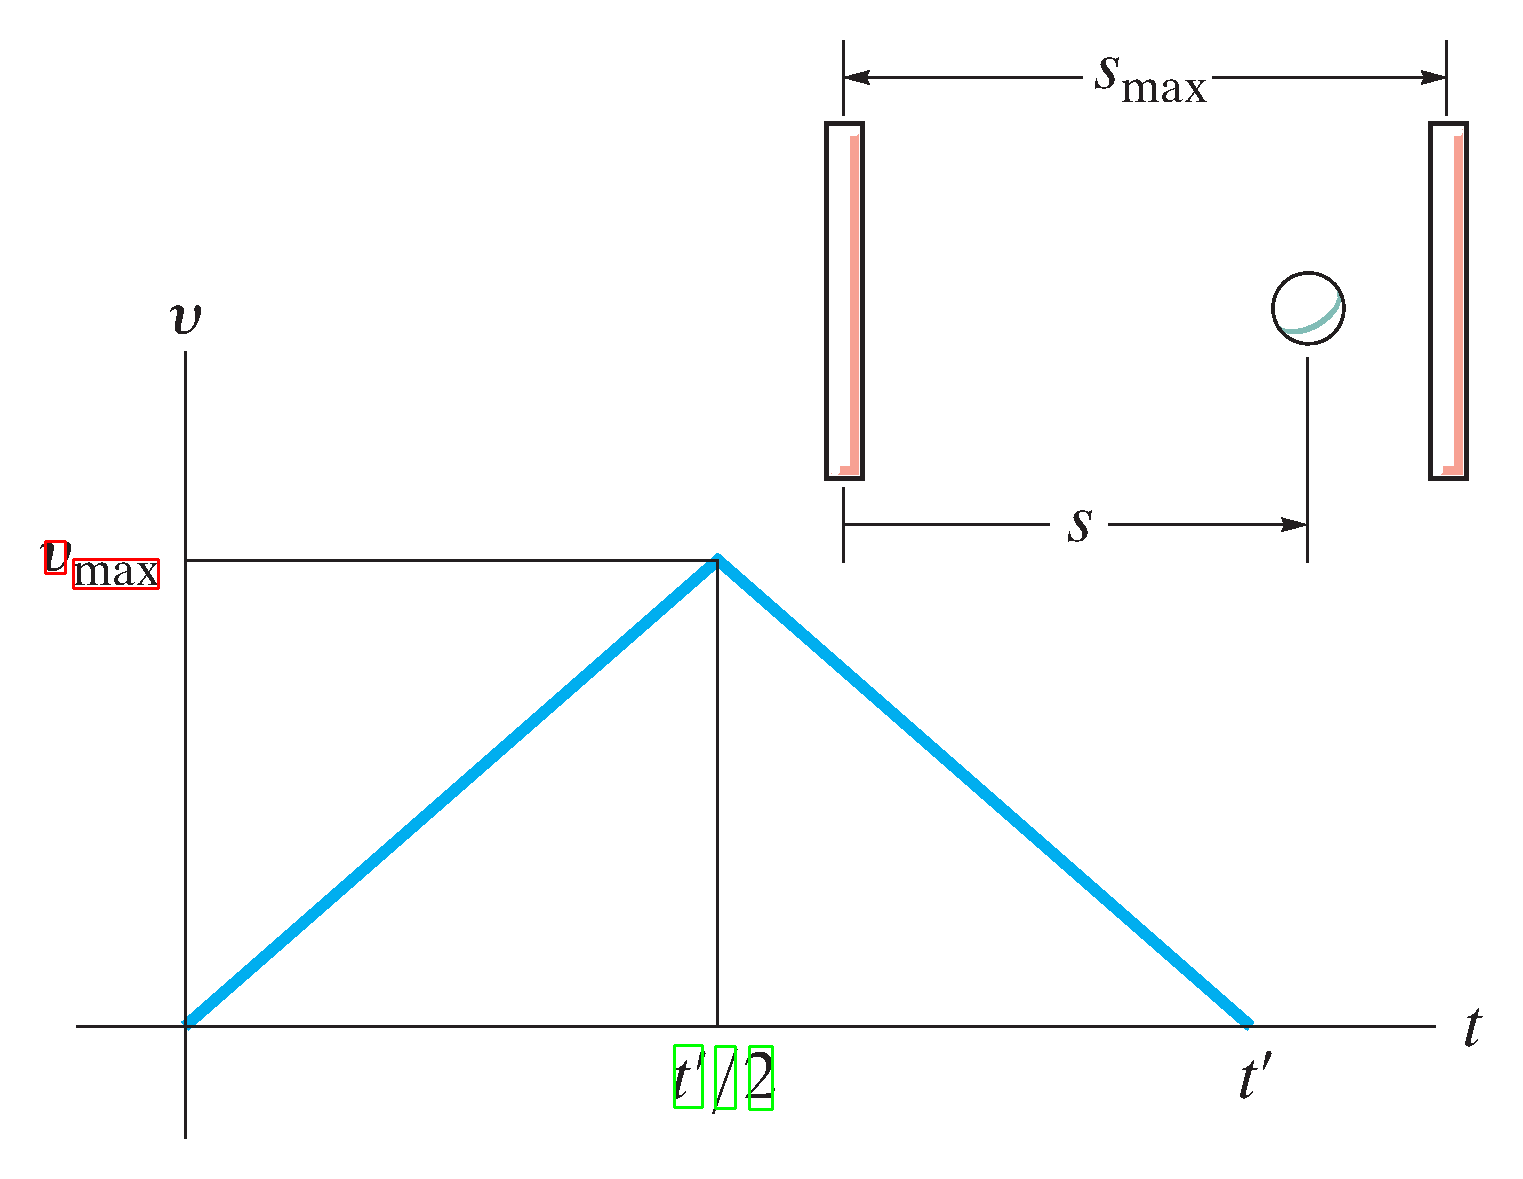

202
202
[[[270, 58], [2283, 58]], [[270, 1446], [2283, 1446]]] [[[2284, 59], [2284, 1445]], [[276, 66], [276, 1438]]]


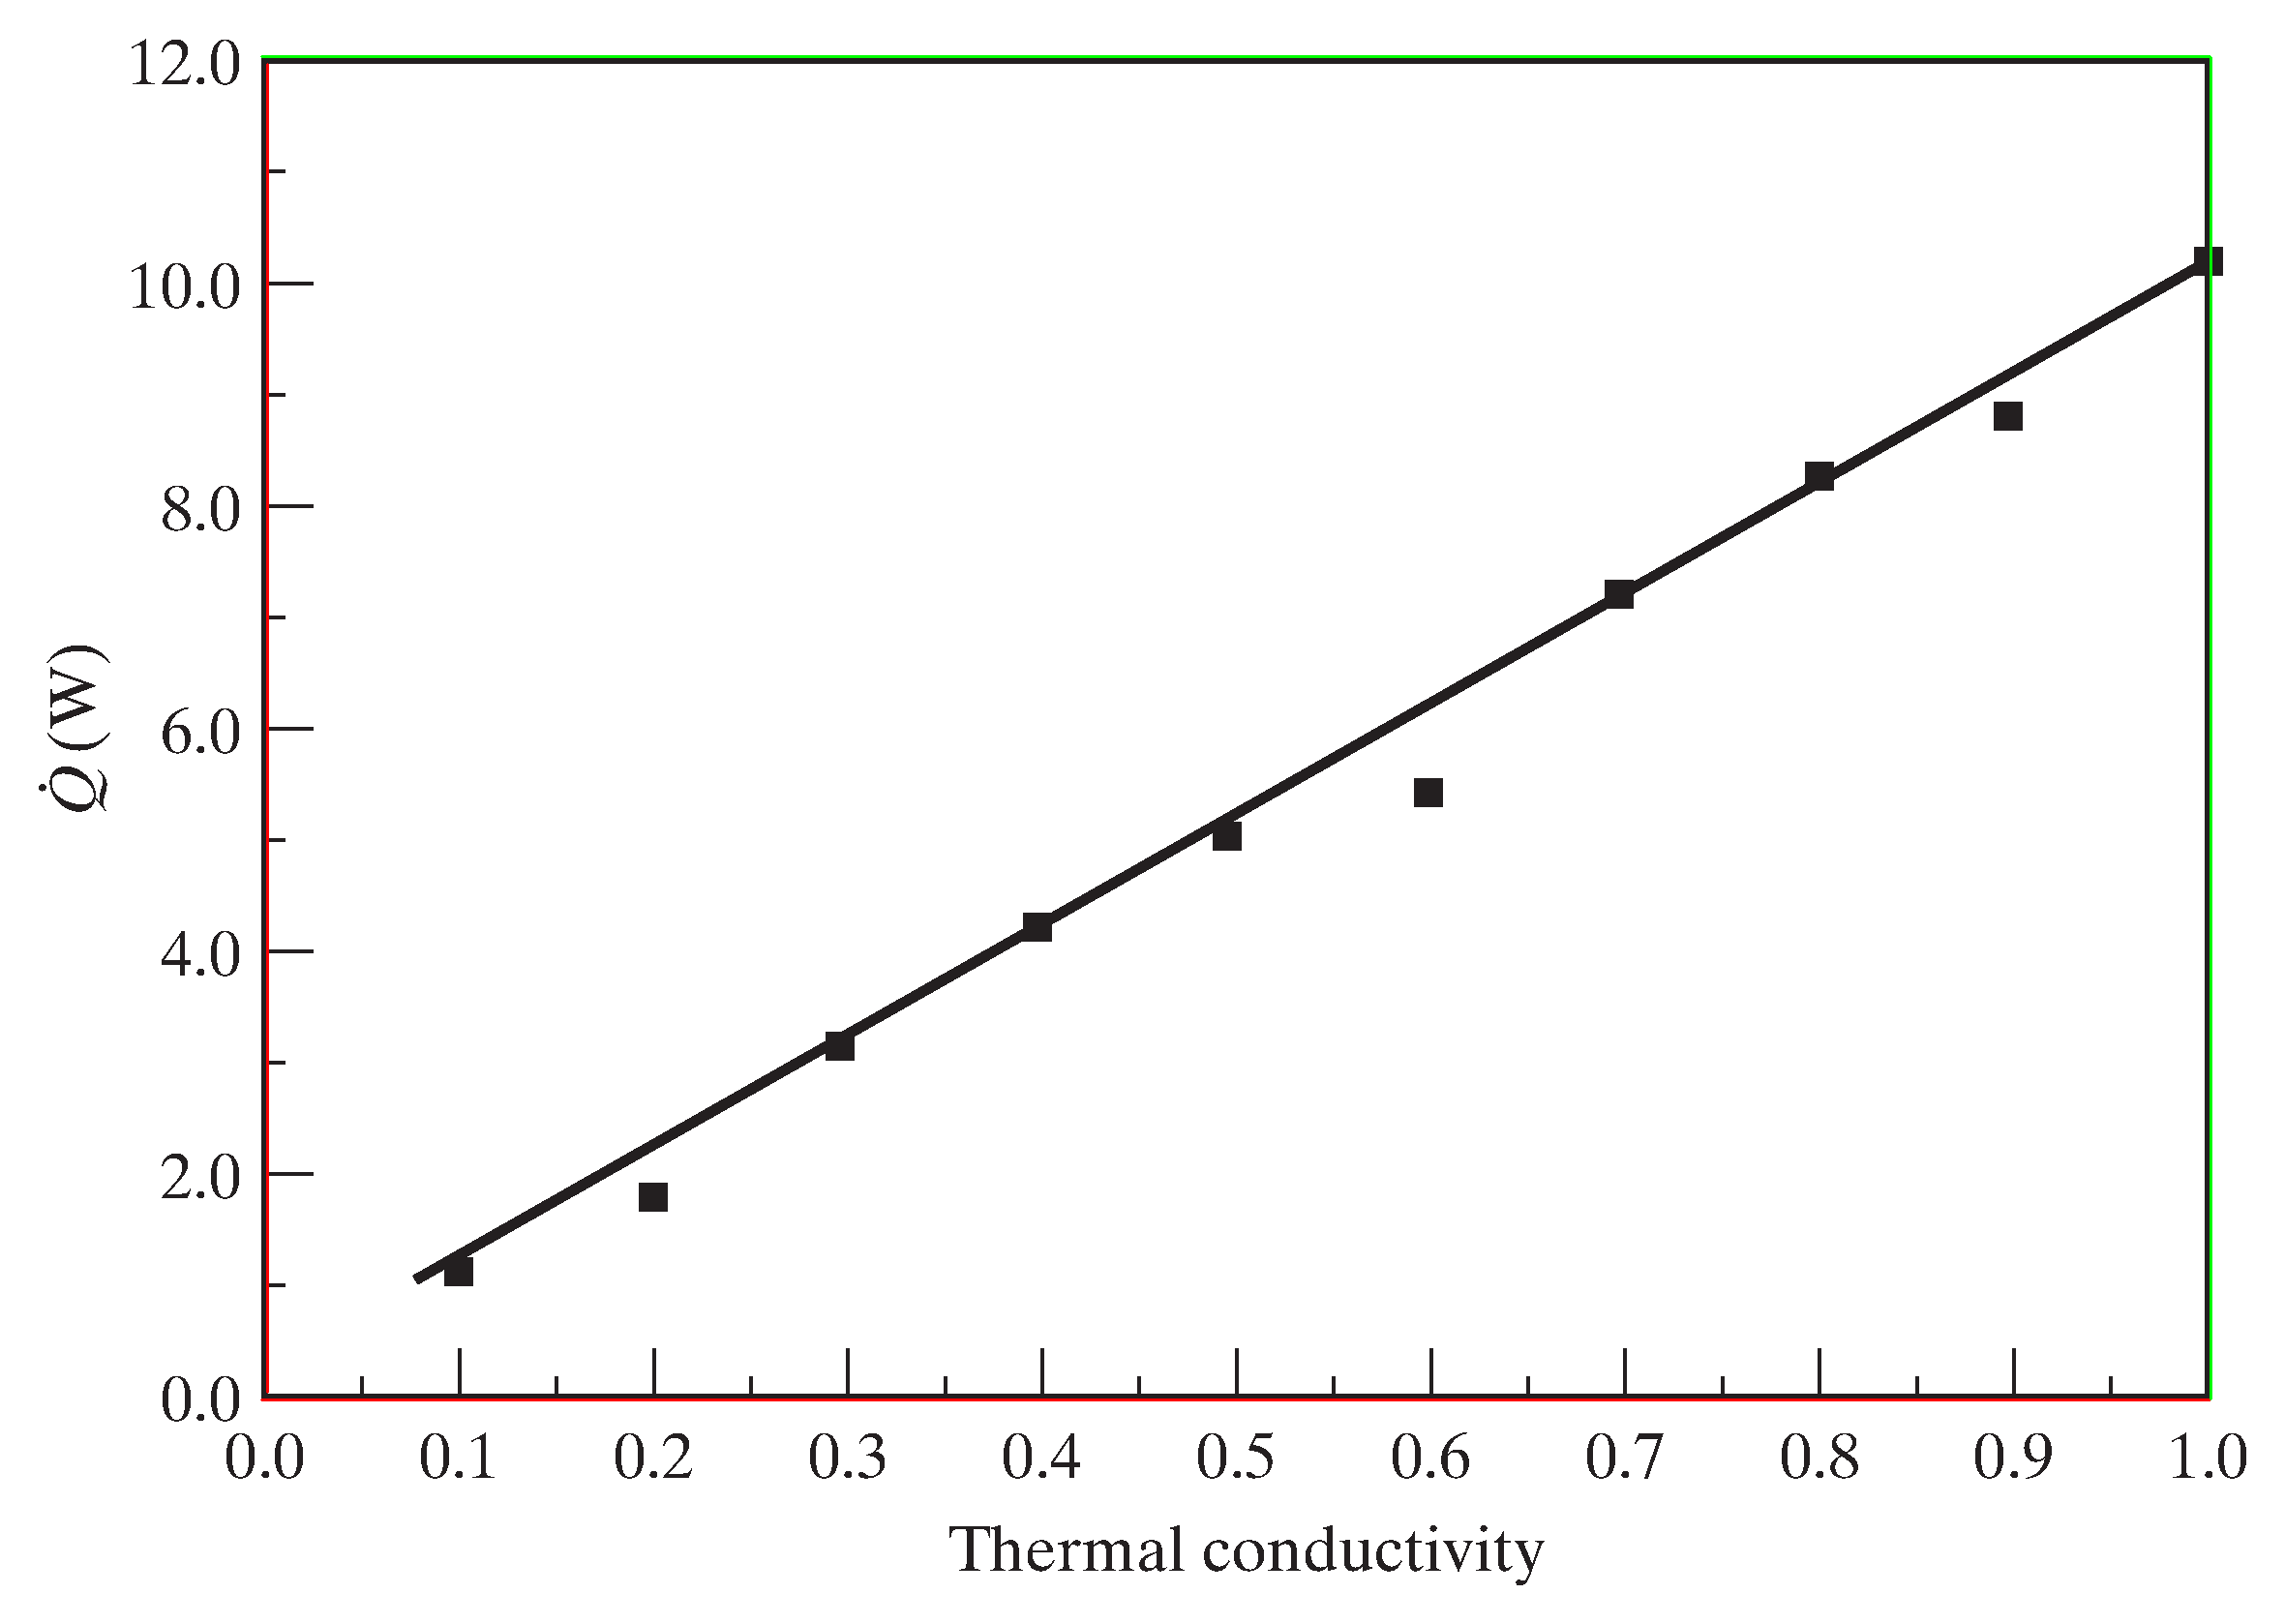

202
202


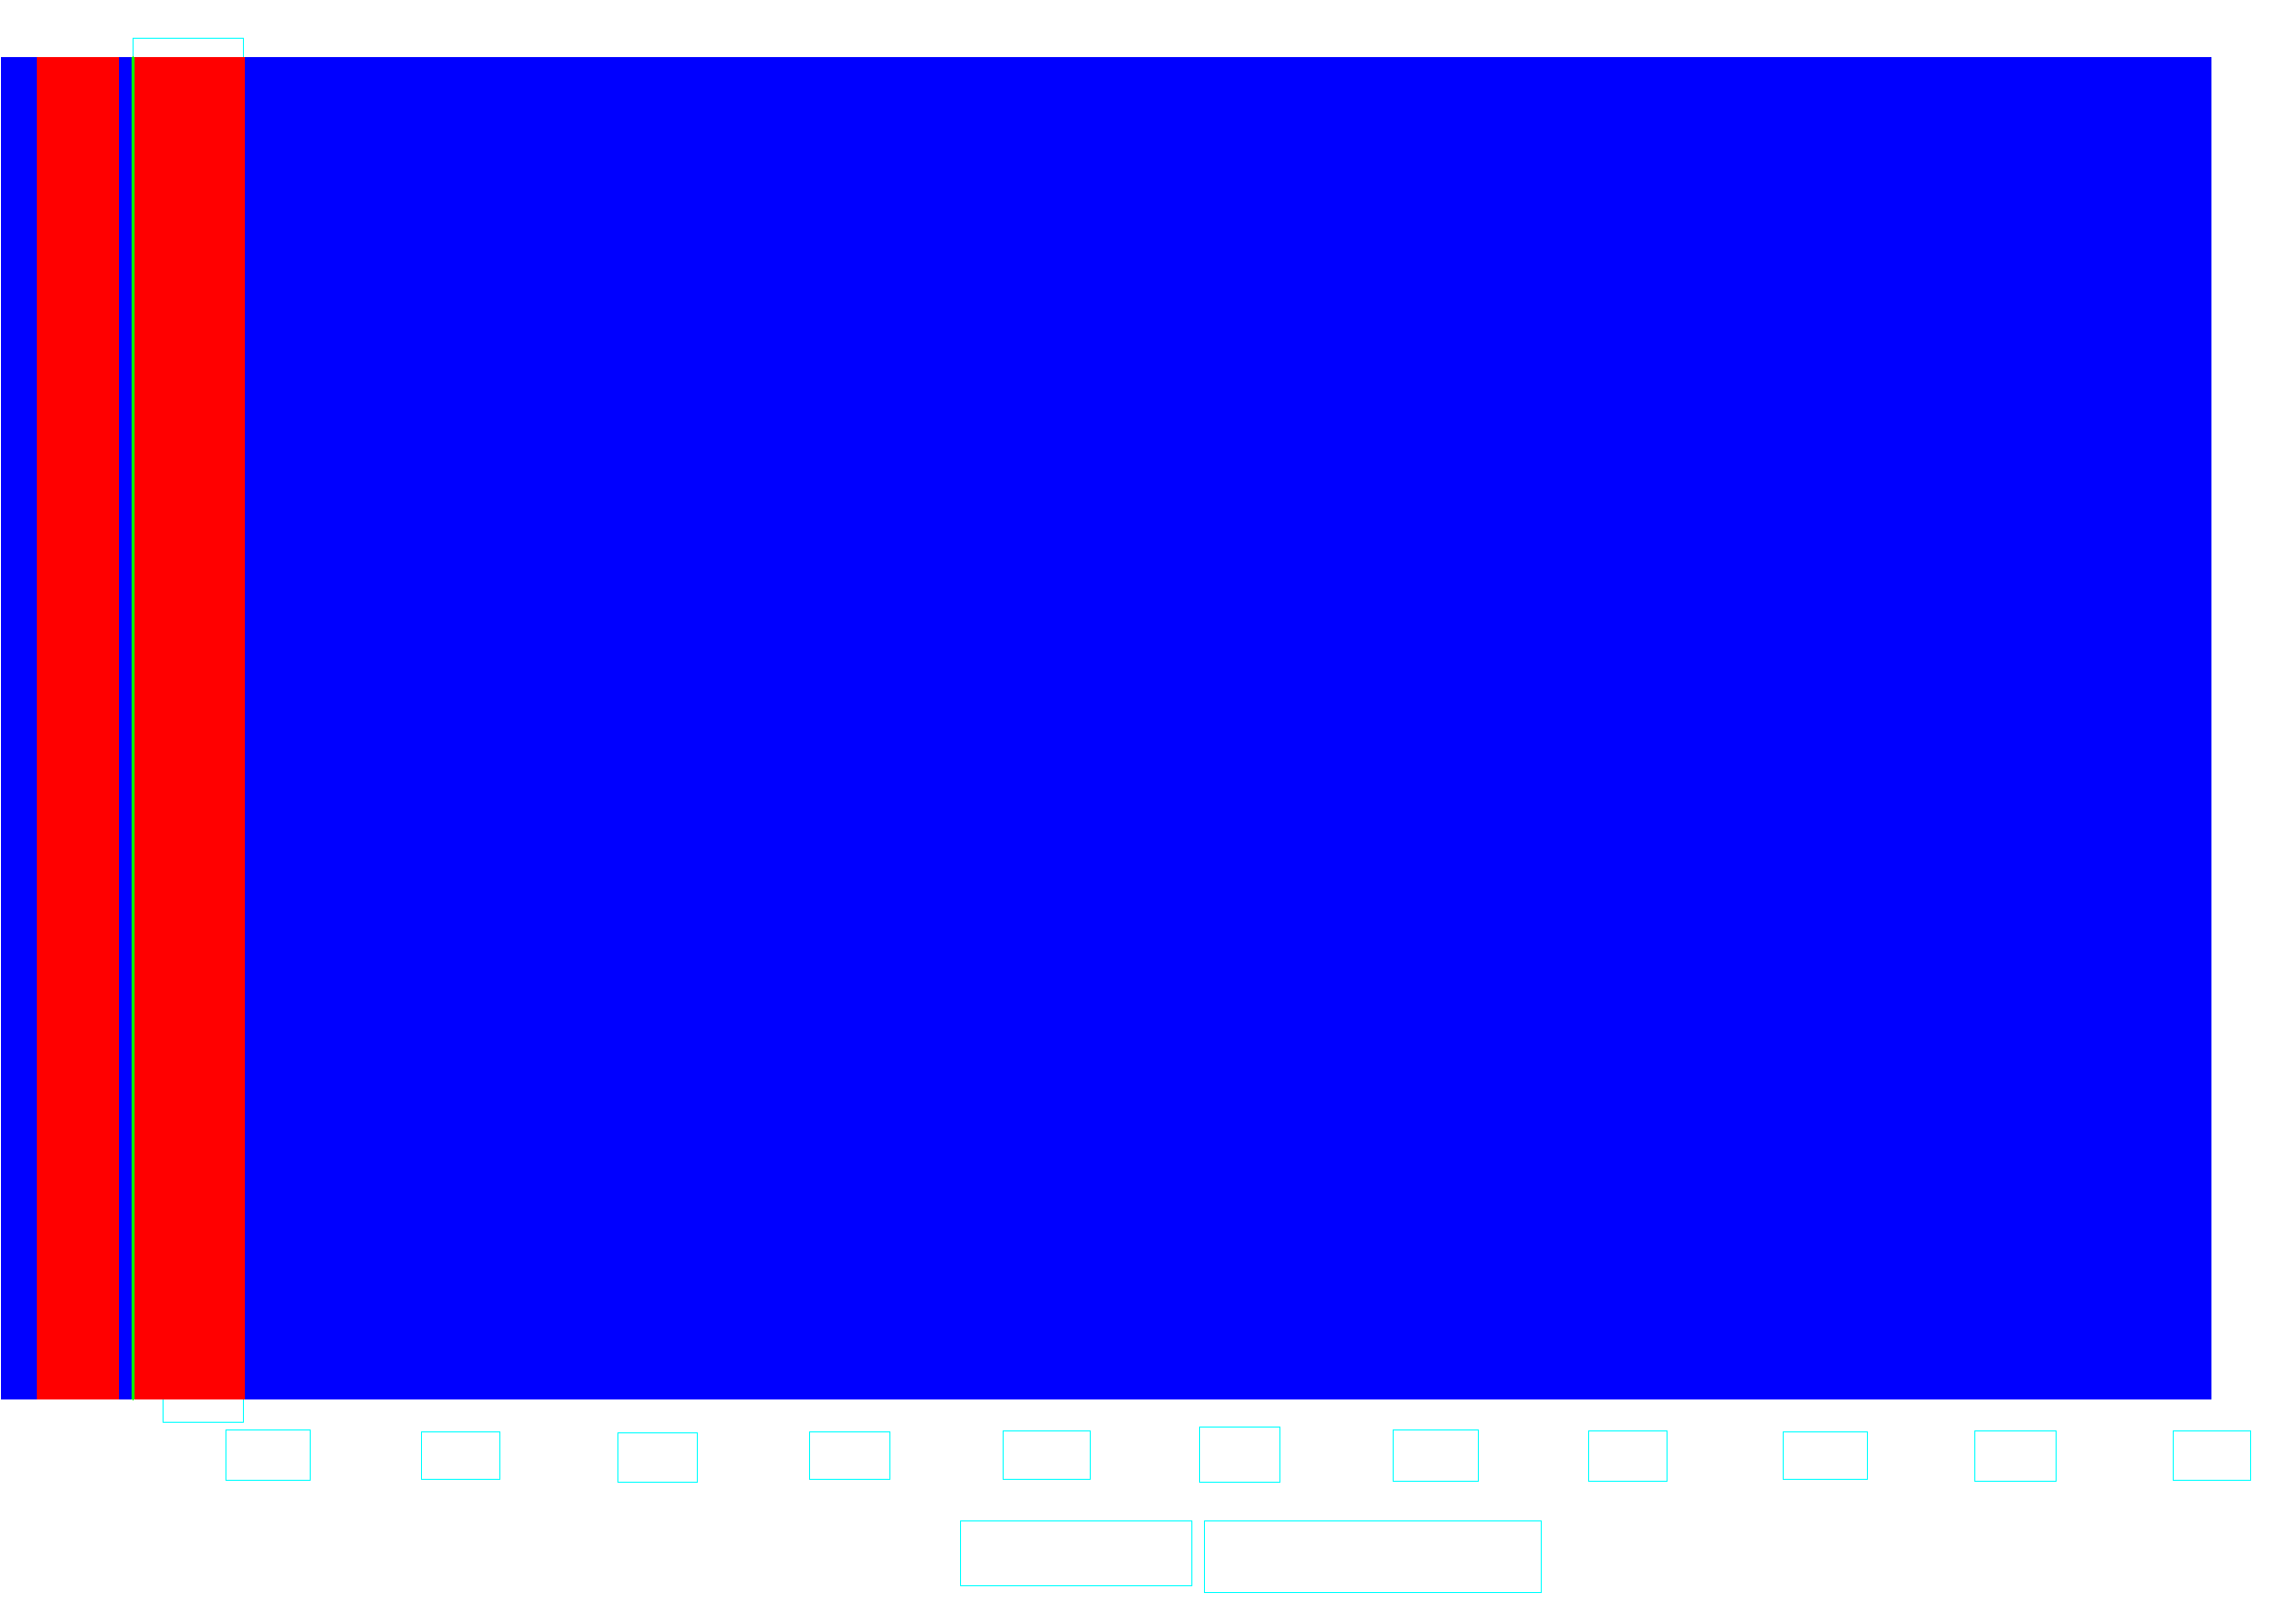

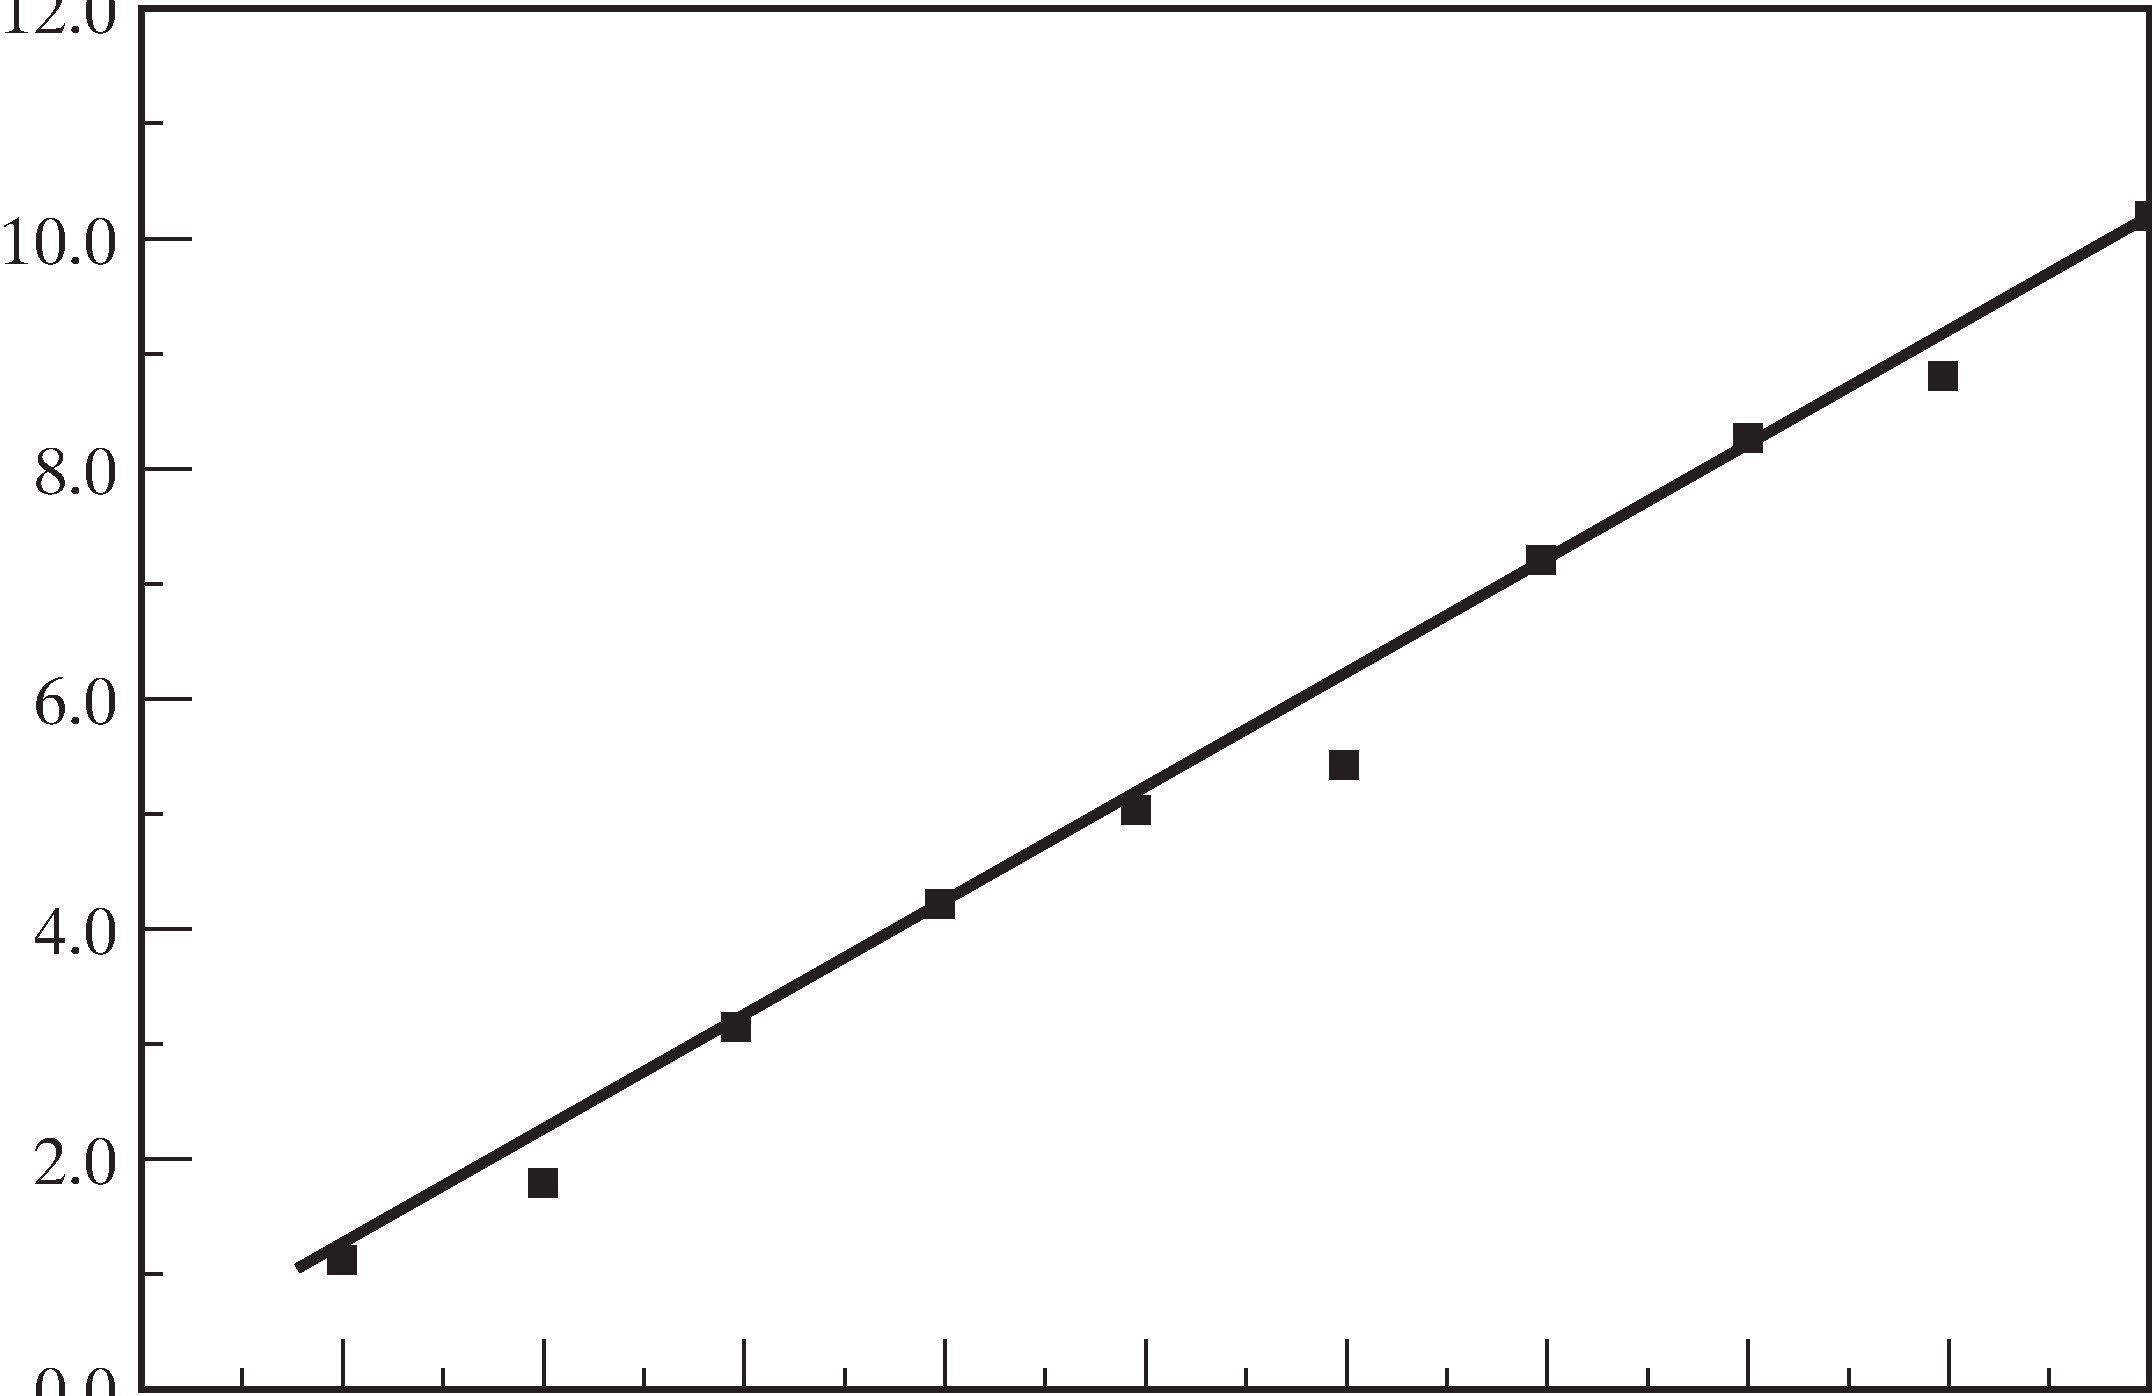

(1396, 2152, 3)


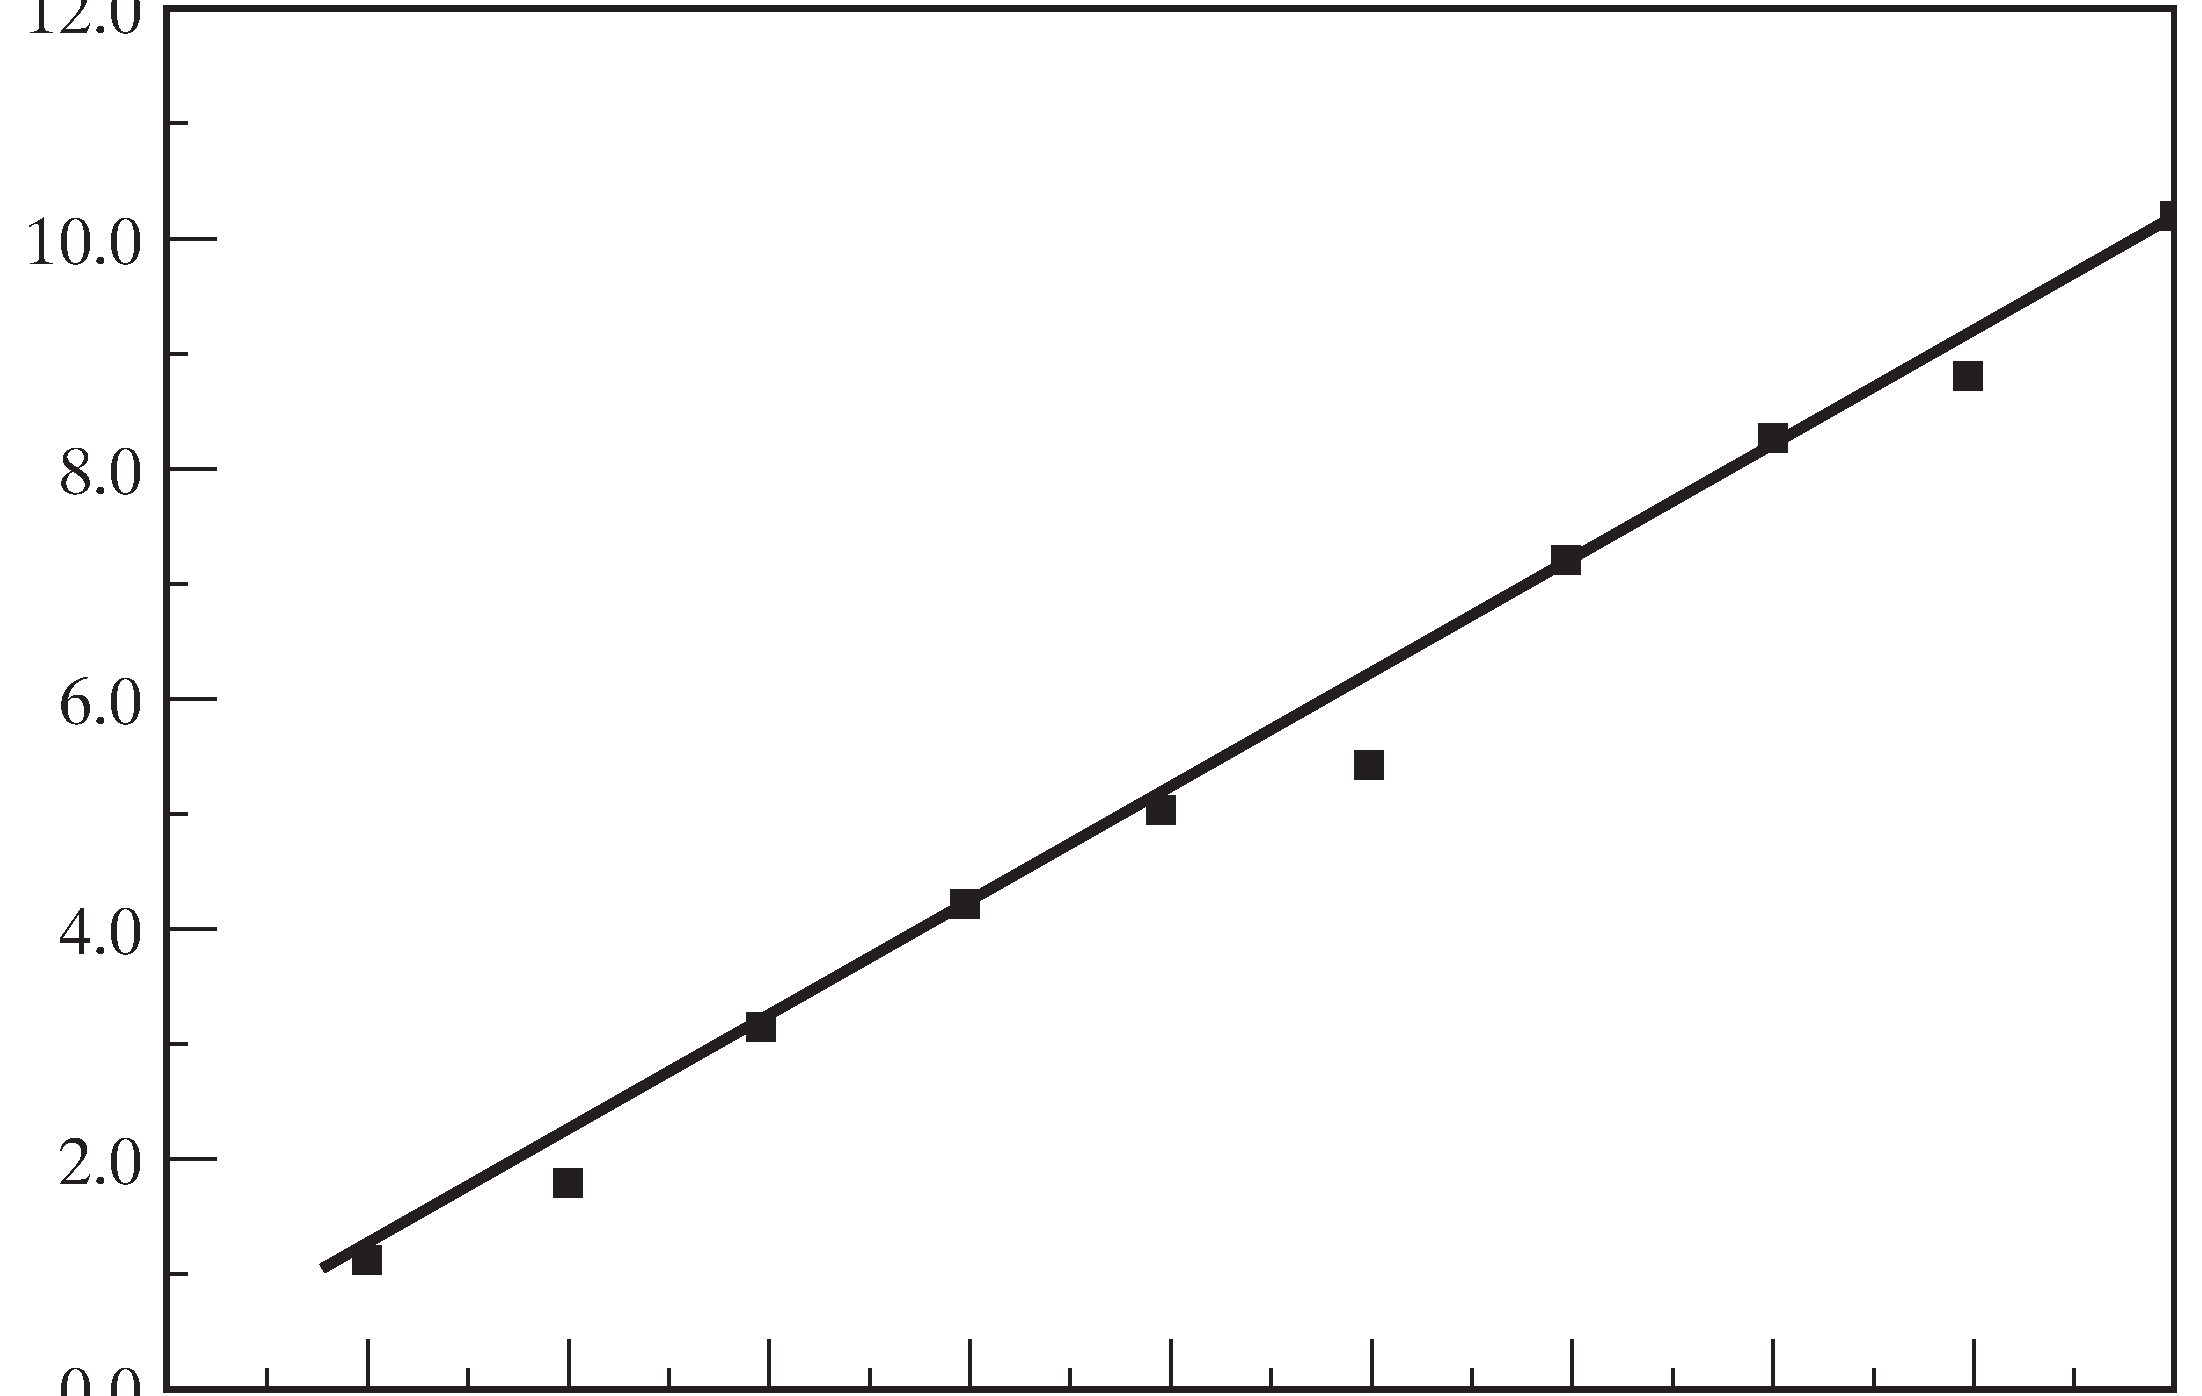

(1396, 2202, 3)
202
202
[{'boundingBox': [34, 3, 139, 1, 139, 38, 33, 41], 'text': '12.0', 'confidence': 'Low'}, {'boundingBox': [29, 212, 138, 211, 138, 269, 30, 270], 'text': '10.0'}, {'boundingBox': [62, 445, 141, 445, 140, 496, 62, 496], 'text': '8.0'}, {'boundingBox': [61, 676, 142, 673, 144, 724, 62, 727], 'text': '6.0'}, {'boundingBox': [63, 907, 140, 908, 139, 956, 63, 955], 'text': '4.0'}, {'boundingBox': [63, 1136, 143, 1136, 143, 1186, 63, 1186], 'text': '2.0'}]
[{'boundingBox': [9, 3, 114, 1, 114, 38, 8, 41], 'text': '12.0', 'confidence': 'Low'}, {'boundingBox': [4, 212, 113, 211, 113, 269, 5, 270], 'text': '10.0'}, {'boundingBox': [37, 445, 116, 445, 115, 496, 37, 496], 'text': '8.0'}, {'boundingBox': [36, 676, 117, 673, 119, 724, 37, 727], 'text': '6.0'}, {'boundingBox': [38, 907, 115, 908, 114, 956, 38, 955], 'text': '4.0'}, {'boundingBox': [38, 1136, 118, 1136, 118, 1186, 38, 1186], 'text': '2.0'}]
[{'boundingBox': [141, 57, 246, 55, 246, 92, 140, 95], 'text': '12.0', '

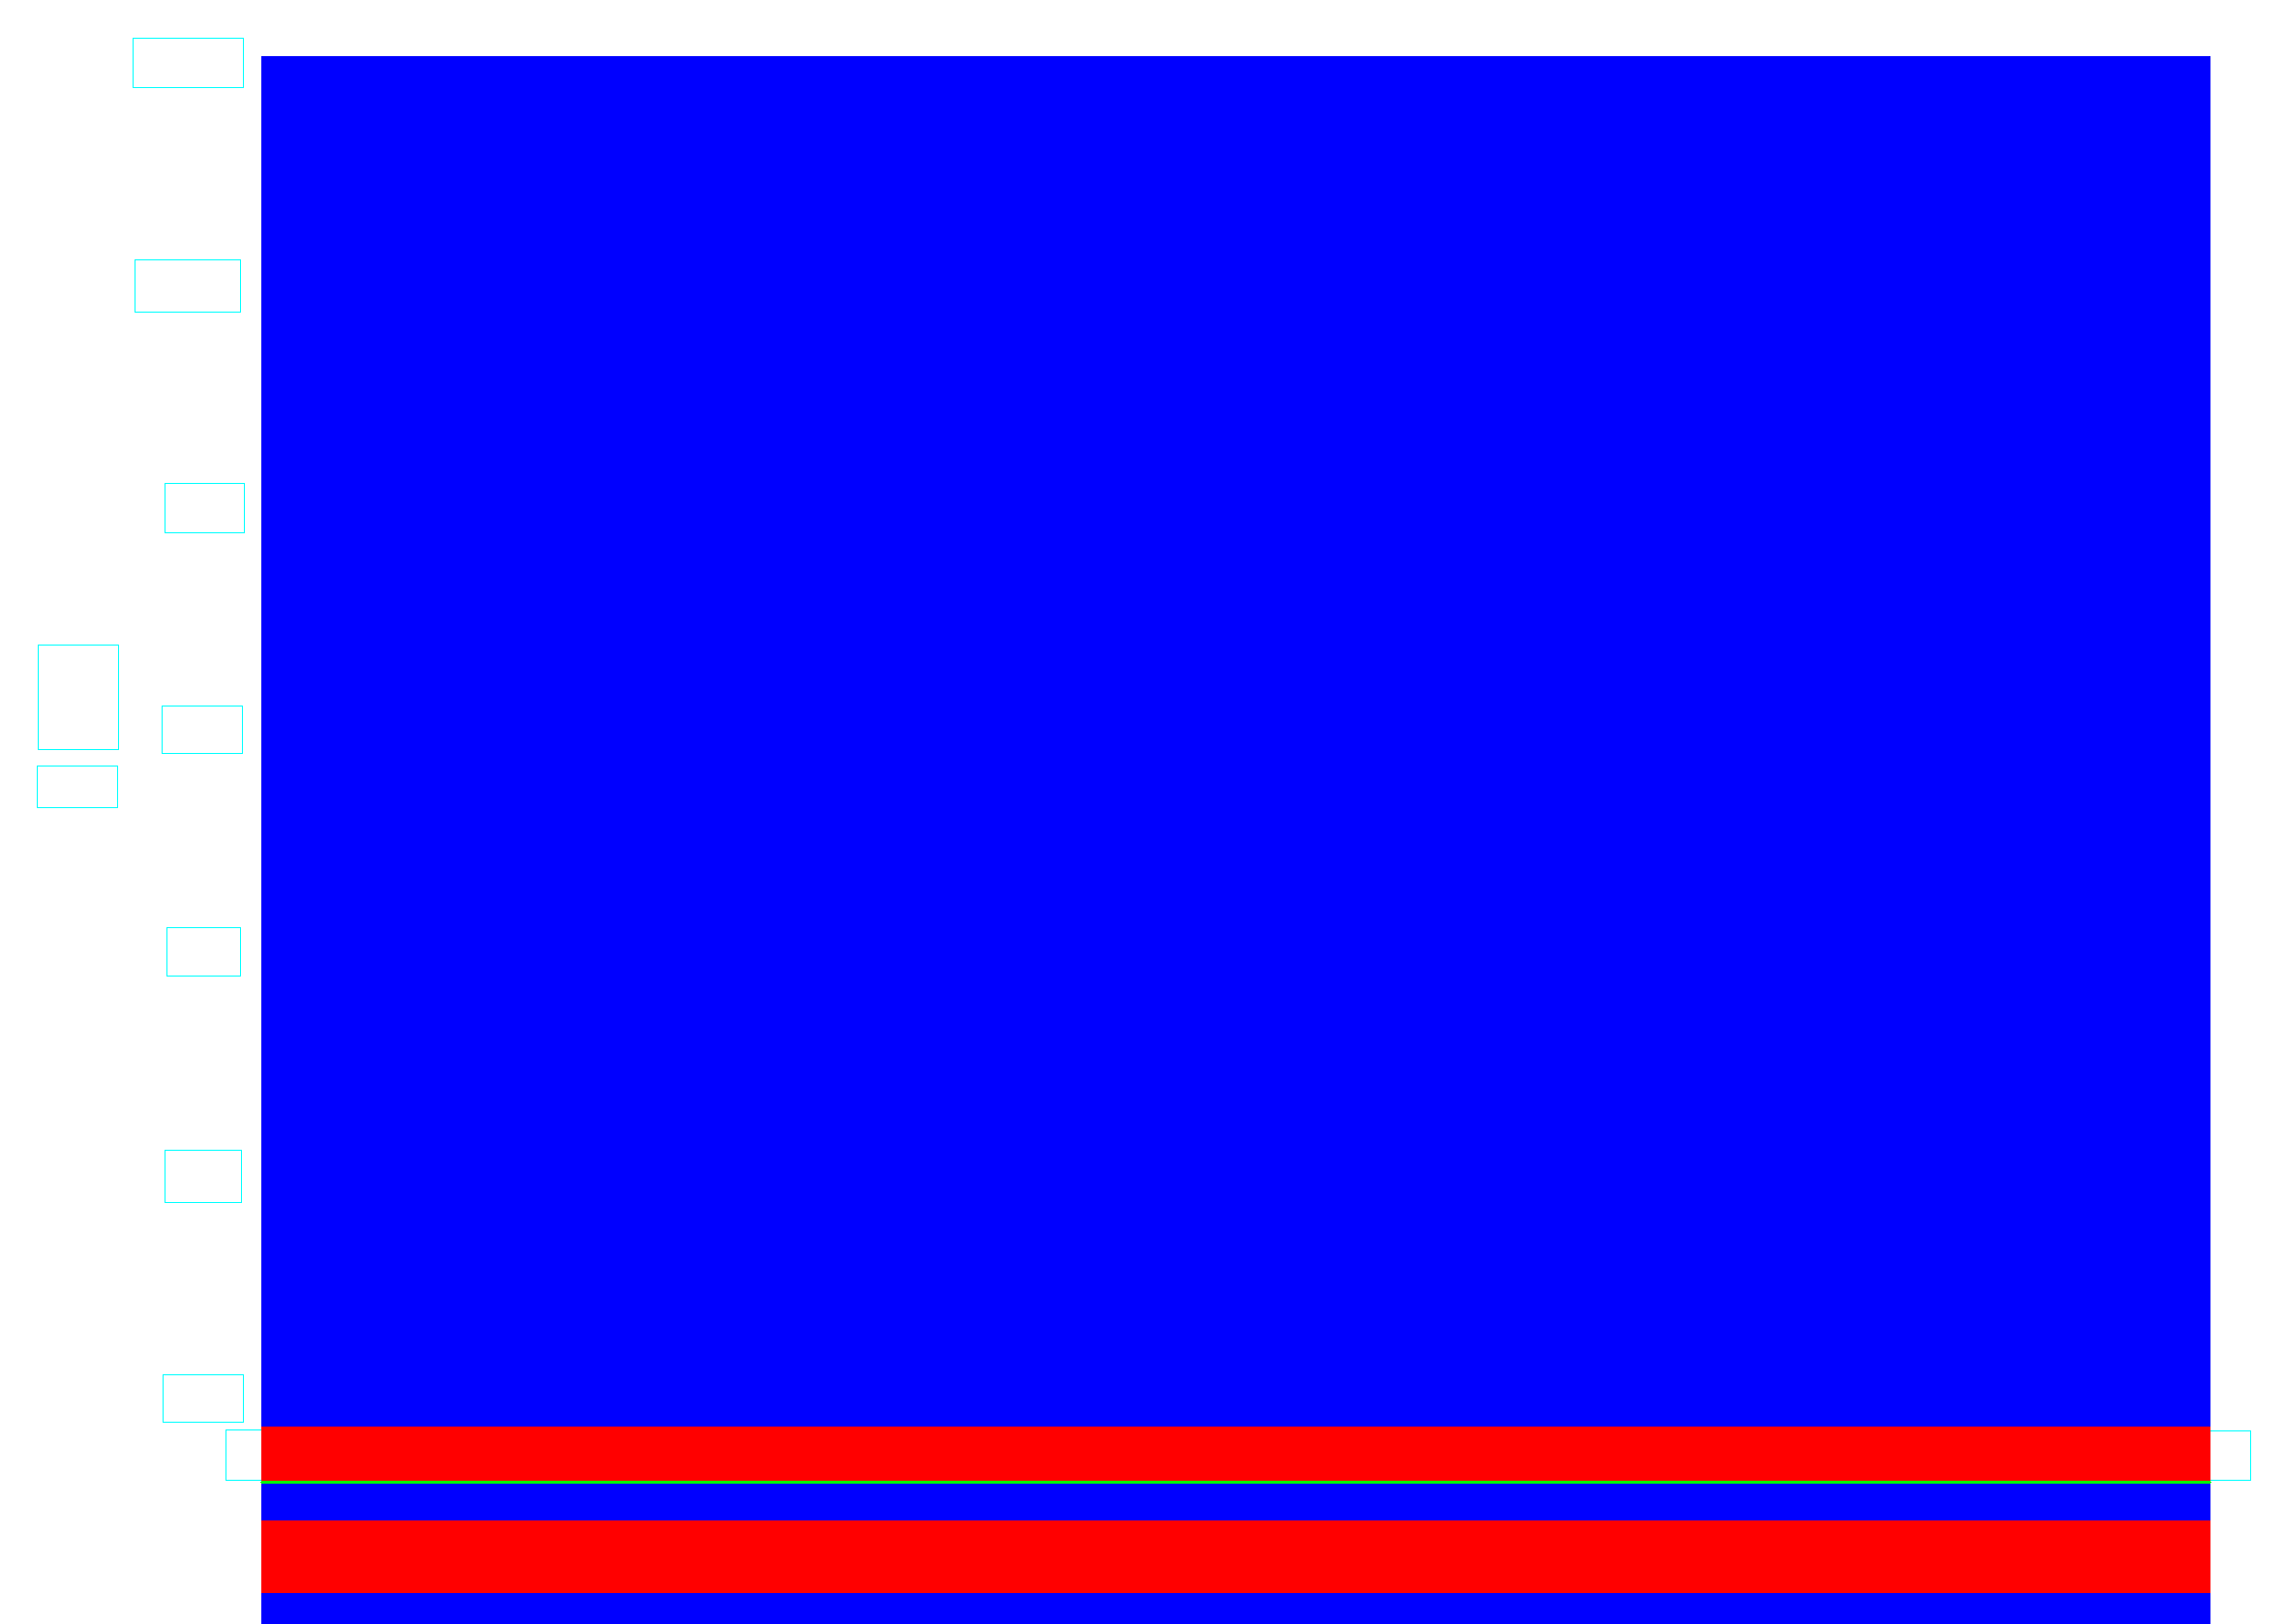

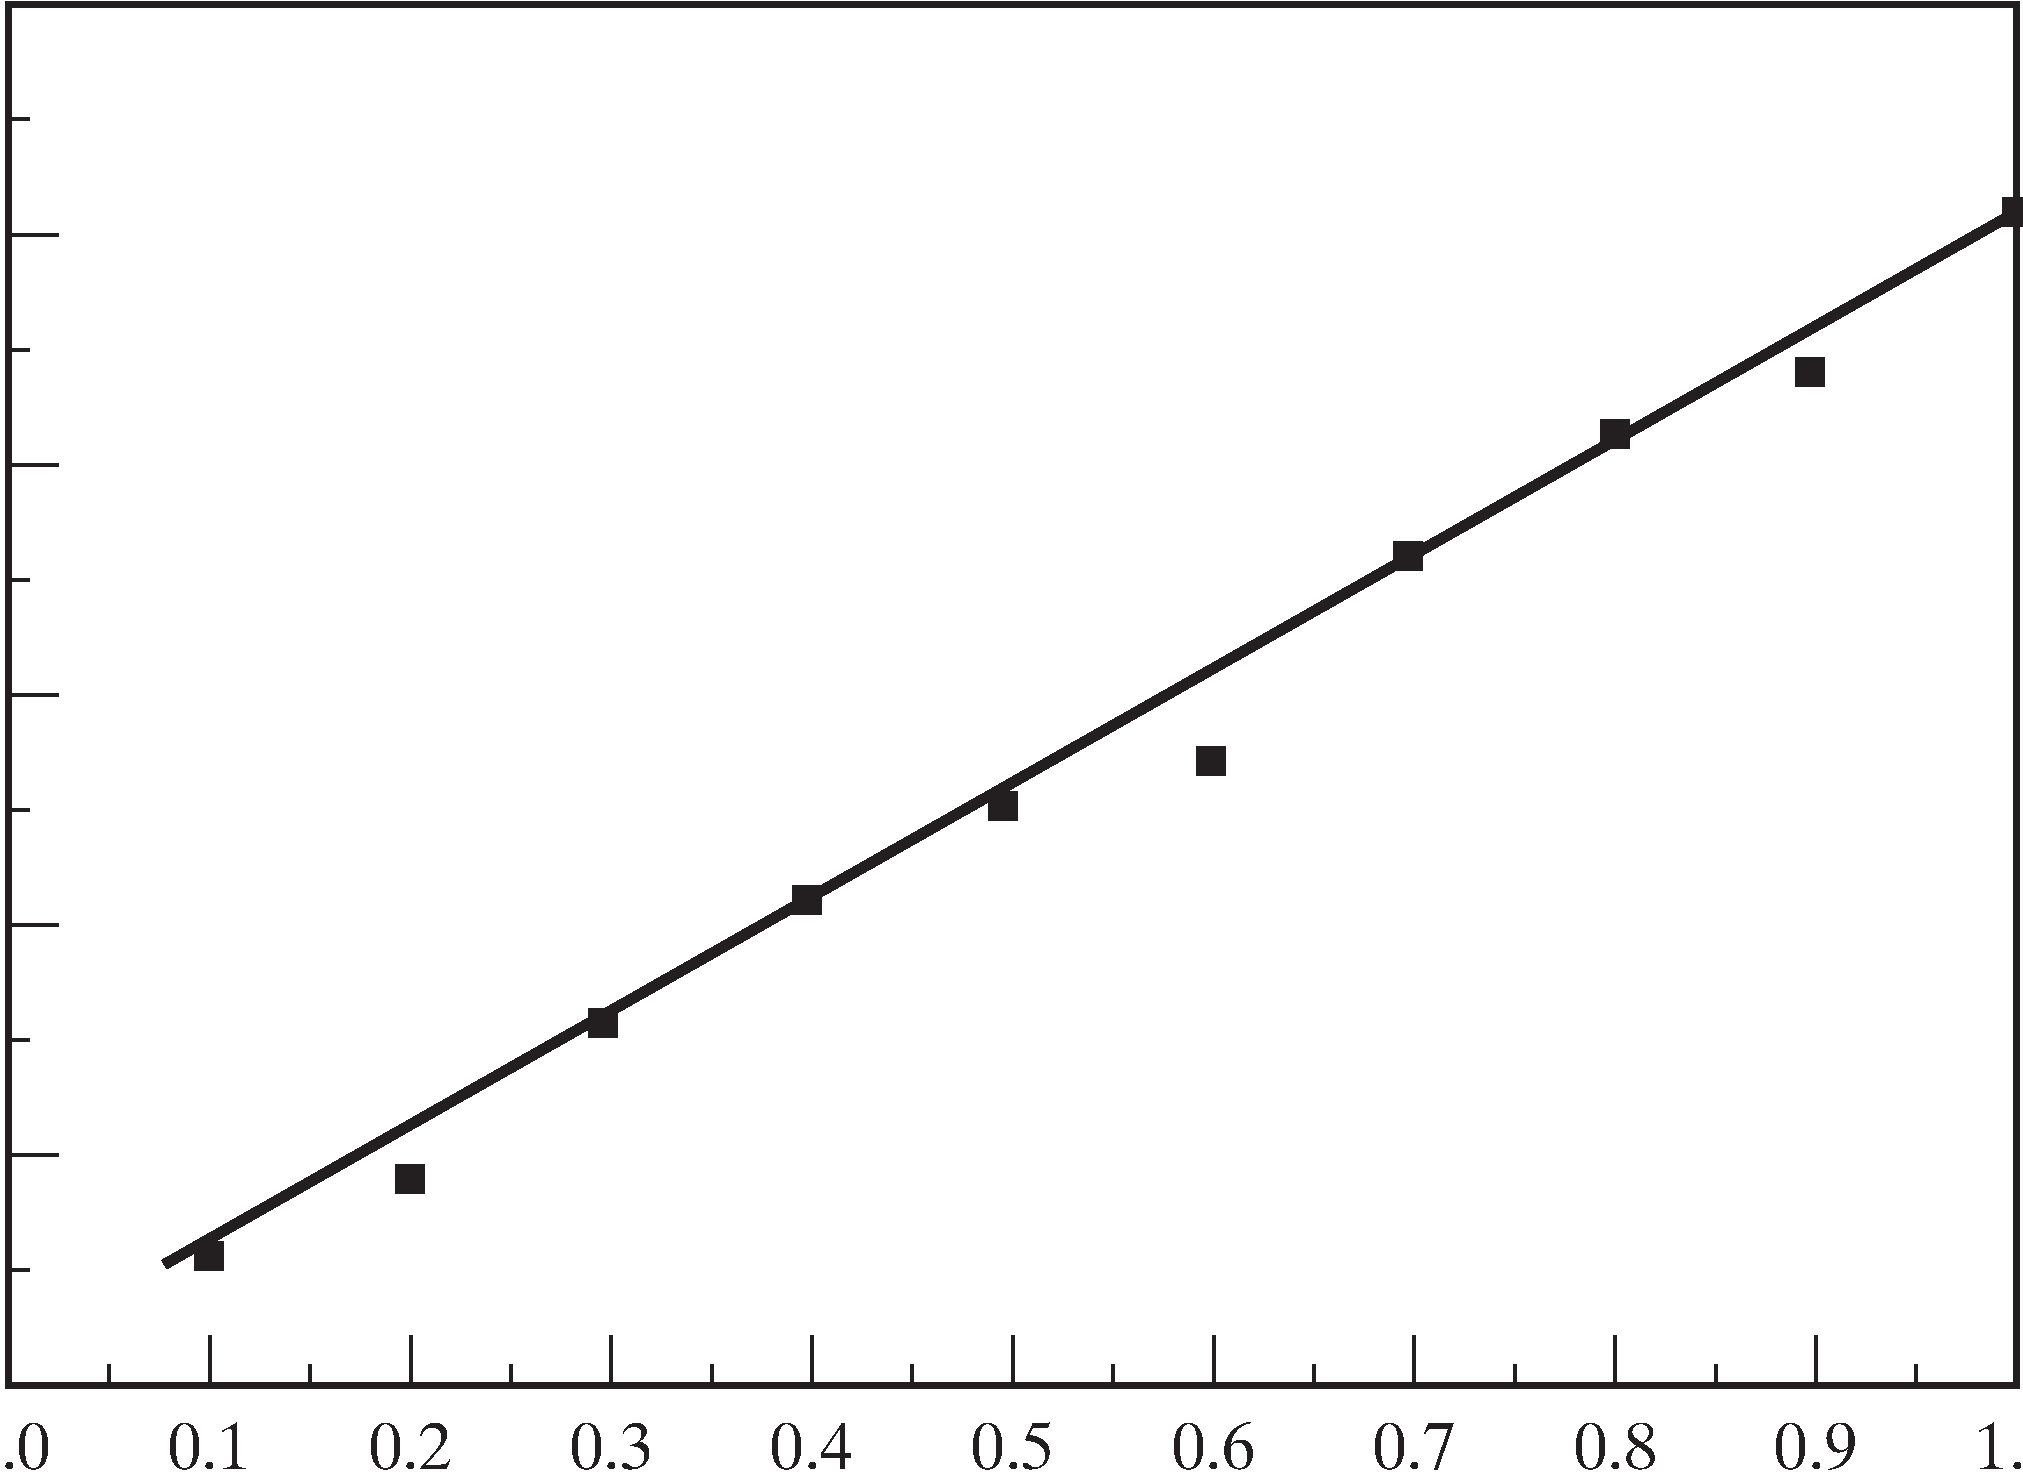

(1478, 2023, 3)


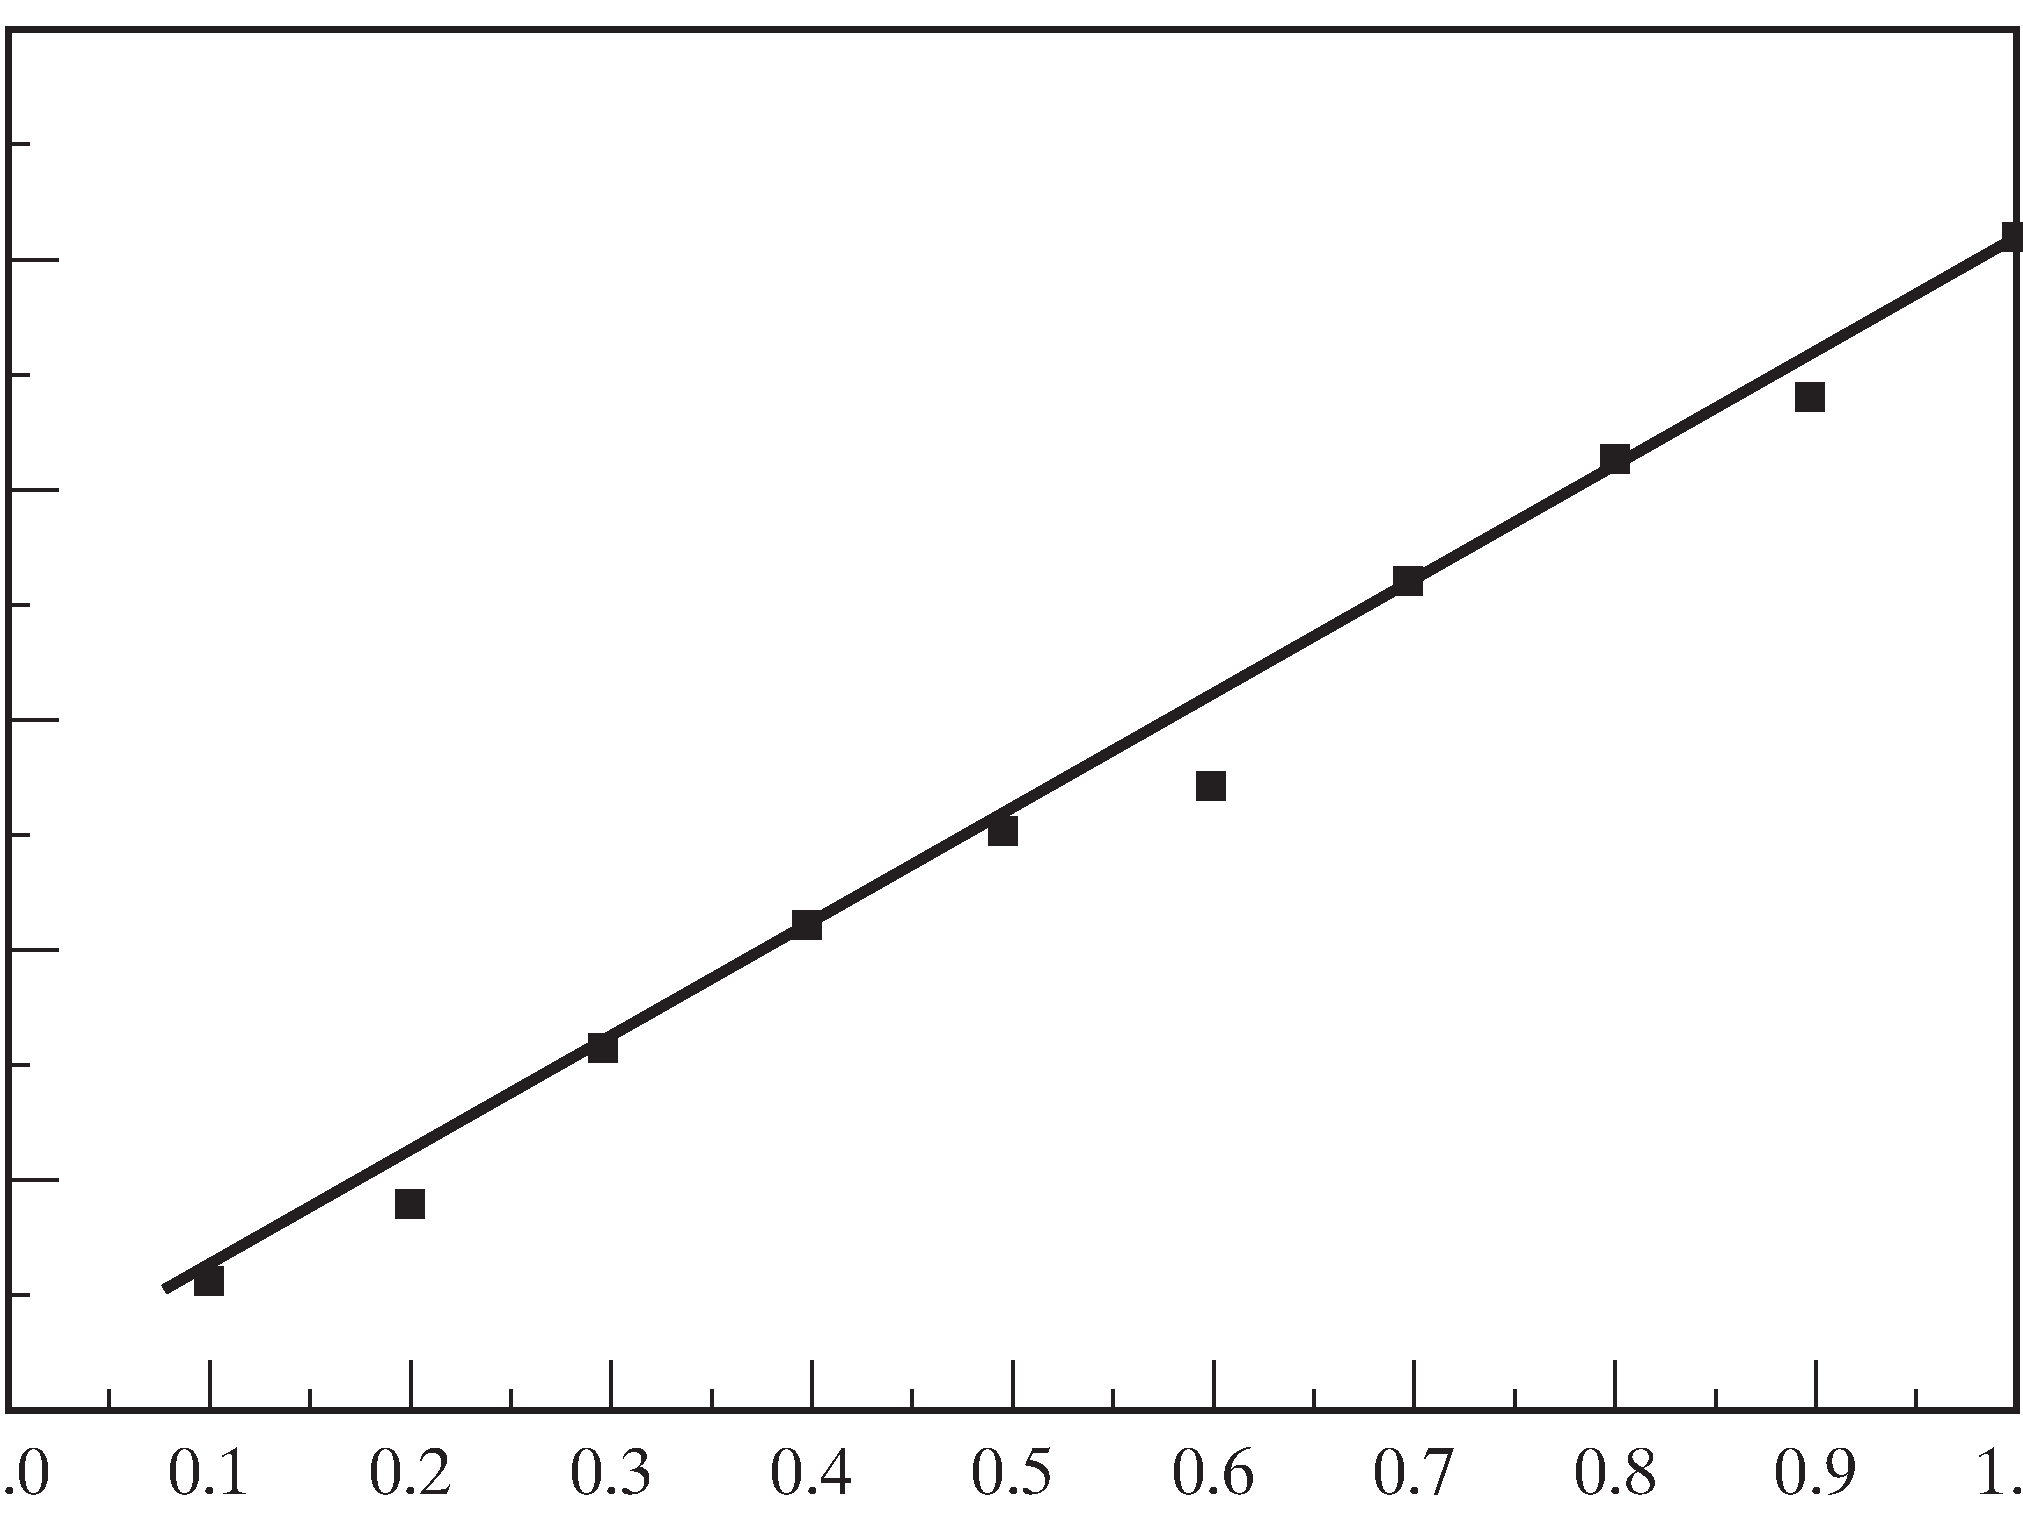

(1528, 2023, 3)


In [ ]:
Files = os.listdir("/content/drive/MyDrive/Graph API Work/preprocessed_image")
for file in Files:
  image_path = "/content/drive/MyDrive/Graph API Work/preprocessed_image/" + file
  x_axis,y_axis = get_axis_detection(image_path,0,0)
  print(x_axis,y_axis)
  result_image_path, img_axis = display_axis(image_path,x_axis,y_axis,axis_output,PADDING_THRESHOLD)
  cv2_imshow(img_axis)

  image_without_OCR,word_bounding_boxes,image_with_OCR_boxes,text_bounding_boxes = clean_OCR_boxes(image_path)

  img = cv2.imread(image_path)
  height_of_img = img.shape[0]
  X_axis = x_axis[0]
  Y_axis = y_axis[0]

  blank_ocr_image = get_OCR_image(image_path,word_bounding_boxes)
  y_axis_info = get_y_axis_info(X_axis,Y_axis, blank_ocr_image, word_bounding_boxes,crop_bin)

  blank_ocr_image = get_OCR_image(image_path,word_bounding_boxes)
  x_axis_info = get_x_axis_info(X_axis, Y_axis, blank_ocr_image, height_of_img, word_bounding_boxes,crop_bin)
  print(y_axis_info)
  print(x_axis_info)

  image_marks =  display_markings(image_path,x_axis_info,y_axis_info,axis_markings_result)
  cv2_imshow(image_marks)